### This notebook details the processing, formatting and analysis of the data generated from the simulation runs that explored the parameter space. 

Thejasvi Beleyur, Max Planck Institute for Ornithology, Seewiesen
Last Updated : September 2019

In [14]:
import random
import dill 
import datetime as dt
import glob 
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial as spatial
import sys 
sys.path.append('..//CPN//')
import numpy as np 
import statsmodels.api as sm
from tqdm import tqdm_notebook, tqdm

In [15]:
%matplotlib notebook

In [52]:
## A series of functions to parse the  simulation output
def get_run_uuid(sim_output, **kwargs):
    sim_id, sim_data = sim_output
    return(sim_id['uuid'])

def get_run_random_seed(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    random_seed = sim_ids['np.random.seed']
    return(random_seed)

def get_num_echoes_heard(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    num_echoes_heard = np.sum(sim_data[0])
    return(num_echoes_heard)

which_echo = {True: 1 , False:0}

def get_echoids(sim_data, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    echo_indices = np.argwhere(sim_data[0]==which_echo[heard]).flatten()
    return(echo_indices)    

def get_echo_levels(sim_output, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output
    echo_ids = get_echoids(sim_data, **kwargs)
    
    echo_levels = sim_data[1]['target_echoes'].loc[echo_ids,'level']
    return(echo_levels)


def get_echo_direction(sim_output, **kwargs):
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output
    echo_ids = get_echoids(sim_data, **kwargs)
    
    echo_direction = sim_data[1]['target_echoes'].loc[echo_ids,'theta']
    return(echo_direction)

def get_group_size(sim_output, **kwargs):
    ''' This function is necessary because of the
    stupid way I stored the parameter sets using classes
    '''
    sim_ids, sim_data = sim_output
    num_bats_in_group = sim_data[0].size +1 
    return(num_bats_in_group)

def split_by_groupsize(df):
    all_subdfs = []
    group_sizes = np.unique(df['groupsize'])
    for each_groupsize in group_sizes:
        subdf = df[df['groupsize']==each_groupsize]
        all_subdfs.append(subdf)
    return(group_sizes, all_subdfs)



def get_individual_positions(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    _, _b, geometry = sim_data
    positions = geometry['positions']
    return(positions)


def get_detection_distance(sim_output, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output 
    echo_inds = get_echoids(sim_data, **kwargs)
    individuals_inds = echo_inds +1 # because focal individ is 0 index
    all_positions = get_individual_positions(sim_output)
    heard_individual_positions = all_positions[individuals_inds,:]
    focal_ind = all_positions[0,:]
    distances = spatial.distance
    
    positions_of_relevance = np.row_stack((focal_ind, heard_individual_positions))
    distances = spatial.distance_matrix(positions_of_relevance, 
                                        positions_of_relevance)[1:,0]
    return(distances)


def get_nearest_neighbour_distances(sim_output, **kwargs):
    '''Extract the distance to the nearest neighbour of the focal bat
    
    Parameters
    -----------
    sim_output : output from a simulation run. 
    
    Keyword Arguments
    ------------------
    nearest_nbrs : int.
                    The number of distance measurements given. 
                    Defaults to 5. 


    Returns
    ---------
    nearest_neighbour_distances : 1 x nearest_nbrs np.array
    '''
    nearest_nbrs = kwargs.get('nearest_nbrs',5)
    positions = get_individual_positions(sim_output)
    distances = spatial.distance_matrix(positions, positions)[1:,0]
    nearest_neighbour_distances = np.sort(distances)[:nearest_nbrs]
    return(nearest_neighbour_distances)

def get_furthest_bat2bat_distance(sim_output, **kwargs):
    '''
    '''
    positions = get_individual_positions(sim_output)
    distances = spatial.distance_matrix(positions, positions)
    furthest_distance = np.max(distances)
    return(furthest_distance)
    

def extract_parameter_values(one_sim_result, **kwargs):
    '''
    Extracts the variables from the simulation result
    by extracting the values from the 
    'parameter set'
    
    Parameters
    -----------
    one_sim_results : tuple/list with 2 entries. 
                      entry 1 should have the simulation identifiers
                      entry 2 may be anything.
    Keyword Arguments
    -----------------
    variables_to_extract : list with str.
                           The names of the variables that are to be extracted.
                           Notes: 
                           If 'source_level' is one of the variables - only the 
                           emitted levels as dBSPL is output - the reference distance
                           is *ignored*.

    Returns
    --------
    param_set : list.
                A list with the numeric or Boolean values of each of the variables extracted. 
    '''
    sim_identifiers, sim_data = one_sim_result
    all_parameter_values = sim_identifiers['parameter_set']
    
    param_set_for_this_run = []
    for each in kwargs['variables_to_extract']:
        if each != 'source_level':
            param_set_for_this_run.append(all_parameter_values[each])
        elif each == 'source_level':
            param_set_for_this_run.append(all_parameter_values[each]['dBSPL'])
    
    return(param_set_for_this_run)
        
make_to_string = lambda X: str(X)

def join_all_parameters(parameter_list):
    '''
    '''
    params_as_string = map(make_to_string, parameter_list)
    param_joined = '*'.join(params_as_string)
    return(param_joined)

def make_paramset_id(sim_output, **kwargs):
    '''
    '''
    all_parameter_values = extract_parameter_values(sim_output, **kwargs)
    param_id = join_all_parameters(all_parameter_values)
    return(param_id)


def load_simresult(path_to_simresult):
    '''
    '''
    with open(path_to_simresult, 'rb') as sim:
        output = dill.load(sim)
    return(output)

def load_and_extract(simresult_path, extraction_functions, **kwargs):
    '''
    Parameters
    ----------
    simresult_path : str/path object

    extraction_functions : list/tuple with one or more function that work on 
                            the simulation output

    Keyword Arguments
    -----------------
    As defined by the extraction functions. 
    Every key must be unique and correspond to a particular extraction function!

    Returns
    ---------
    extracted_output : str OR object type thats returned by the extraction function
                       If the loading or extraction fails then 
                       the path of file is returned. 
    '''
    try:
        simresult = load_simresult(simresult_path)
        extracted_outputs = [ extract(simresult, **kwargs) for extract in extraction_functions]
        return(extracted_outputs)
    except:
        return(simresult_path)
    

In [26]:
# Some functions that deal with formatting the simulation data after it's been loaded from the csv file. 

def format_nearest_neighbour_distances(nearest_nbr_entry):
    '''
    Parameters
    ----------
    nearest_nbr_entry : string. 
                        pd.DataFrame column entry with 
                        the following format 
                        '[<float>, <float>, <float>]'
    
    Returns
    -------
    np.array
    
    '''
    only_float_as_string = nearest_nbr_entry[1:-1]
    all_strings_separated = only_float_as_string.split()
    floats = map(lambda X : float(X), all_strings_separated)
    
    distances = np.array(floats)
    return(distances)
    
    


In [27]:
### Load the data : this needs a decent amount of RAM !! and takes some time - remember this. 

In [28]:
results_folder = '..//simulations/multivariable_simulations//'

In [29]:
all_results = glob.glob(results_folder+'*.simresults')
some_results =random.sample(all_results, int(len(all_results)*1.0))

In [30]:
extraction_fns = [get_num_echoes_heard, get_group_size, get_furthest_bat2bat_distance,
                 get_nearest_neighbour_distances, get_detection_distance, get_run_uuid,
                  get_run_random_seed, make_paramset_id, extract_parameter_values,
                 get_echo_levels, get_echo_direction]


In [31]:
keyword_arguments = {'nearest_nbrs':3}
keyword_arguments['variables_to_extract'] = ['heading_variation', 'echocall_duration','atmospheric_attenuation','min_spacing','source_level',
                        'interpulse_interval', 'implement_shadowing']

In [59]:
#### Un comment into Python cells if you need to re-run the analysis by loading the raw data 
#### this can take 45mins-1 hour even when done in parallel
%time extracted_simdata = Parallel(n_jobs=8)(delayed(load_and_extract)(each, extraction_fns, **keyword_arguments) for each in tqdm(some_results))






  0%|          | 0/240584 [00:00<?, ?it/s]




  0%|          | 1/240584 [00:00<8:02:57,  8.30it/s]




  0%|          | 16/240584 [00:10<19:48:45,  3.37it/s]




  0%|          | 24/240584 [00:10<14:18:16,  4.67it/s]




  0%|          | 29/240584 [00:11<10:25:12,  6.41it/s]




  0%|          | 38/240584 [00:11<7:31:57,  8.87it/s] 




  0%|          | 43/240584 [00:11<5:44:03, 11.65it/s]




  0%|          | 48/240584 [00:11<4:29:04, 14.90it/s]




  0%|          | 55/240584 [00:11<3:25:34, 19.50it/s]




  0%|          | 61/240584 [00:11<2:51:21, 23.39it/s]




  0%|          | 66/240584 [00:11<2:31:09, 26.52it/s]




  0%|          | 72/240584 [00:11<2:12:57, 30.15it/s]




  0%|          | 78/240584 [00:11<1:53:59, 35.16it/s]




  0%|          | 83/240584 [00:12<1:55:19, 34.76it/s]




  0%|          | 88/240584 [00:12<1:45:50, 37.87it/s]




  0%|          | 94/240584 [00:12<1:35:13, 42.09it/s]




  0%|          | 99/240584 [00:12<1:41:52, 39.34it/s]




  0%|          | 

  0%|          | 655/240584 [00:24<1:29:04, 44.89it/s]




  0%|          | 661/240584 [00:24<1:27:01, 45.95it/s]




  0%|          | 666/240584 [00:24<1:26:33, 46.19it/s]




  0%|          | 671/240584 [00:24<1:25:52, 46.56it/s]




  0%|          | 676/240584 [00:24<1:28:45, 45.05it/s]




  0%|          | 681/240584 [00:25<1:34:09, 42.46it/s]




  0%|          | 687/240584 [00:25<1:31:01, 43.92it/s]




  0%|          | 694/240584 [00:25<1:23:19, 47.98it/s]




  0%|          | 699/240584 [00:25<1:26:22, 46.29it/s]




  0%|          | 704/240584 [00:25<1:29:00, 44.92it/s]




  0%|          | 711/240584 [00:25<1:22:12, 48.63it/s]




  0%|          | 717/240584 [00:25<1:26:11, 46.38it/s]




  0%|          | 723/240584 [00:25<1:25:00, 47.02it/s]




  0%|          | 729/240584 [00:26<1:20:05, 49.91it/s]




  0%|          | 735/240584 [00:26<1:26:49, 46.04it/s]




  0%|          | 740/240584 [00:26<1:24:57, 47.05it/s]




  0%|          | 745/240584 [00:26<1:33:37, 42.70it/s]



  1%|          | 1290/240584 [00:38<1:29:48, 44.41it/s]




  1%|          | 1295/240584 [00:38<1:32:24, 43.16it/s]




  1%|          | 1301/240584 [00:38<1:29:15, 44.68it/s]




  1%|          | 1308/240584 [00:38<1:24:56, 46.95it/s]




  1%|          | 1313/240584 [00:38<1:27:27, 45.60it/s]




  1%|          | 1318/240584 [00:38<1:30:40, 43.98it/s]




  1%|          | 1323/240584 [00:38<1:41:28, 39.30it/s]




  1%|          | 1328/240584 [00:39<1:37:05, 41.07it/s]




  1%|          | 1333/240584 [00:39<1:39:17, 40.16it/s]




  1%|          | 1338/240584 [00:39<1:36:58, 41.12it/s]




  1%|          | 1345/240584 [00:39<1:26:47, 45.94it/s]




  1%|          | 1350/240584 [00:39<1:32:29, 43.11it/s]




  1%|          | 1357/240584 [00:39<1:23:19, 47.85it/s]




  1%|          | 1363/240584 [00:39<1:28:31, 45.03it/s]




  1%|          | 1368/240584 [00:39<1:29:03, 44.77it/s]




  1%|          | 1373/240584 [00:40<1:29:15, 44.66it/s]




  1%|          | 1379/240584 [00:40<1:25

  1%|          | 1937/240584 [00:51<1:19:44, 49.88it/s]




  1%|          | 1943/240584 [00:51<1:24:09, 47.26it/s]




  1%|          | 1948/240584 [00:51<1:23:31, 47.62it/s]




  1%|          | 1954/240584 [00:52<1:25:39, 46.43it/s]




  1%|          | 1960/240584 [00:52<1:20:05, 49.66it/s]




  1%|          | 1966/240584 [00:52<1:28:09, 45.11it/s]




  1%|          | 1971/240584 [00:52<1:33:40, 42.45it/s]




  1%|          | 1977/240584 [00:52<1:28:10, 45.10it/s]




  1%|          | 1984/240584 [00:52<1:19:33, 49.98it/s]




  1%|          | 1990/240584 [00:52<1:23:46, 47.46it/s]




  1%|          | 1995/240584 [00:52<1:24:09, 47.25it/s]




  1%|          | 2000/240584 [00:53<1:30:14, 44.06it/s]




  1%|          | 2005/240584 [00:53<1:28:31, 44.91it/s]




  1%|          | 2011/240584 [00:53<1:23:55, 47.38it/s]




  1%|          | 2016/240584 [00:53<1:23:56, 47.36it/s]




  1%|          | 2021/240584 [00:53<1:24:46, 46.90it/s]




  1%|          | 2026/240584 [00:53<1:23

  1%|          | 2558/240584 [01:05<1:17:46, 51.01it/s]




  1%|          | 2564/240584 [01:05<1:21:46, 48.51it/s]




  1%|          | 2569/240584 [01:05<1:25:12, 46.56it/s]




  1%|          | 2575/240584 [01:05<1:26:24, 45.91it/s]




  1%|          | 2581/240584 [01:05<1:20:31, 49.26it/s]




  1%|          | 2587/240584 [01:05<1:24:40, 46.85it/s]




  1%|          | 2592/240584 [01:05<1:24:28, 46.95it/s]




  1%|          | 2597/240584 [01:05<1:25:31, 46.38it/s]




  1%|          | 2602/240584 [01:06<1:37:25, 40.71it/s]




  1%|          | 2608/240584 [01:06<1:29:16, 44.43it/s]




  1%|          | 2614/240584 [01:06<1:32:07, 43.05it/s]




  1%|          | 2621/240584 [01:06<1:23:58, 47.23it/s]




  1%|          | 2626/240584 [01:06<1:38:49, 40.13it/s]




  1%|          | 2631/240584 [01:06<1:41:51, 38.94it/s]




  1%|          | 2638/240584 [01:06<1:29:43, 44.20it/s]




  1%|          | 2643/240584 [01:07<1:38:23, 40.31it/s]




  1%|          | 2650/240584 [01:07<1:34

  1%|▏         | 3183/240584 [01:19<1:30:30, 43.72it/s]




  1%|▏         | 3190/240584 [01:19<1:24:08, 47.02it/s]




  1%|▏         | 3195/240584 [01:19<1:29:49, 44.05it/s]




  1%|▏         | 3200/240584 [01:19<1:29:28, 44.22it/s]




  1%|▏         | 3205/240584 [01:19<1:30:09, 43.88it/s]




  1%|▏         | 3210/240584 [01:20<1:34:21, 41.93it/s]




  1%|▏         | 3216/240584 [01:20<1:31:25, 43.27it/s]




  1%|▏         | 3222/240584 [01:20<1:27:39, 45.13it/s]




  1%|▏         | 3229/240584 [01:20<1:20:33, 49.11it/s]




  1%|▏         | 3235/240584 [01:20<1:28:40, 44.61it/s]




  1%|▏         | 3240/240584 [01:20<1:34:53, 41.69it/s]




  1%|▏         | 3247/240584 [01:20<1:23:39, 47.29it/s]




  1%|▏         | 3253/240584 [01:20<1:20:25, 49.19it/s]




  1%|▏         | 3259/240584 [01:21<1:20:58, 48.85it/s]




  1%|▏         | 3265/240584 [01:21<1:25:17, 46.37it/s]




  1%|▏         | 3272/240584 [01:21<1:18:42, 50.26it/s]




  1%|▏         | 3278/240584 [01:21<1:24

  2%|▏         | 3806/240584 [01:32<1:25:26, 46.18it/s]




  2%|▏         | 3811/240584 [01:32<1:27:57, 44.86it/s]




  2%|▏         | 3816/240584 [01:33<1:26:55, 45.40it/s]




  2%|▏         | 3822/240584 [01:33<1:29:18, 44.18it/s]




  2%|▏         | 3827/240584 [01:33<1:34:51, 41.60it/s]




  2%|▏         | 3834/240584 [01:33<1:24:58, 46.43it/s]




  2%|▏         | 3840/240584 [01:33<1:19:32, 49.60it/s]




  2%|▏         | 3846/240584 [01:33<1:35:46, 41.19it/s]




  2%|▏         | 3852/240584 [01:33<1:26:58, 45.37it/s]




  2%|▏         | 3857/240584 [01:33<1:32:10, 42.81it/s]




  2%|▏         | 3864/240584 [01:34<1:21:53, 48.18it/s]




  2%|▏         | 3870/240584 [01:34<1:29:53, 43.89it/s]




  2%|▏         | 3876/240584 [01:34<1:23:29, 47.25it/s]




  2%|▏         | 3882/240584 [01:34<1:28:44, 44.46it/s]




  2%|▏         | 3888/240584 [01:34<1:27:18, 45.18it/s]




  2%|▏         | 3894/240584 [01:34<1:20:50, 48.80it/s]




  2%|▏         | 3900/240584 [01:34<1:21

  2%|▏         | 4441/240584 [01:46<1:27:58, 44.74it/s]




  2%|▏         | 4446/240584 [01:46<1:30:09, 43.66it/s]




  2%|▏         | 4452/240584 [01:46<1:23:37, 47.06it/s]




  2%|▏         | 4458/240584 [01:46<1:24:29, 46.58it/s]




  2%|▏         | 4463/240584 [01:47<1:23:59, 46.85it/s]




  2%|▏         | 4469/240584 [01:47<1:20:59, 48.59it/s]




  2%|▏         | 4474/240584 [01:47<1:23:59, 46.85it/s]




  2%|▏         | 4479/240584 [01:47<1:25:39, 45.94it/s]




  2%|▏         | 4484/240584 [01:47<1:34:52, 41.47it/s]




  2%|▏         | 4489/240584 [01:47<1:30:07, 43.66it/s]




  2%|▏         | 4496/240584 [01:47<1:21:37, 48.20it/s]




  2%|▏         | 4502/240584 [01:47<1:33:33, 42.06it/s]




  2%|▏         | 4510/240584 [01:48<1:20:53, 48.64it/s]




  2%|▏         | 4516/240584 [01:48<1:23:52, 46.90it/s]




  2%|▏         | 4522/240584 [01:48<1:33:02, 42.29it/s]




  2%|▏         | 4528/240584 [01:48<1:34:35, 41.59it/s]




  2%|▏         | 4533/240584 [01:48<1:32

  2%|▏         | 5062/240584 [02:00<1:19:22, 49.45it/s]




  2%|▏         | 5068/240584 [02:00<1:23:43, 46.89it/s]




  2%|▏         | 5074/240584 [02:00<1:20:10, 48.96it/s]




  2%|▏         | 5080/240584 [02:00<1:23:59, 46.73it/s]




  2%|▏         | 5087/240584 [02:00<1:18:50, 49.78it/s]




  2%|▏         | 5093/240584 [02:00<1:21:24, 48.21it/s]




  2%|▏         | 5098/240584 [02:00<1:25:27, 45.93it/s]




  2%|▏         | 5103/240584 [02:01<1:28:12, 44.49it/s]




  2%|▏         | 5108/240584 [02:01<1:32:00, 42.66it/s]




  2%|▏         | 5115/240584 [02:01<1:24:08, 46.64it/s]




  2%|▏         | 5121/240584 [02:01<1:26:20, 45.46it/s]




  2%|▏         | 5126/240584 [02:01<1:27:50, 44.67it/s]




  2%|▏         | 5131/240584 [02:01<1:27:32, 44.83it/s]




  2%|▏         | 5136/240584 [02:01<1:34:45, 41.41it/s]




  2%|▏         | 5143/240584 [02:01<1:27:12, 45.00it/s]




  2%|▏         | 5149/240584 [02:02<1:21:49, 47.96it/s]




  2%|▏         | 5154/240584 [02:02<1:23

  2%|▏         | 5684/240584 [02:13<1:27:18, 44.84it/s]




  2%|▏         | 5689/240584 [02:13<1:41:04, 38.73it/s]




  2%|▏         | 5697/240584 [02:13<1:30:40, 43.18it/s]




  2%|▏         | 5702/240584 [02:13<1:27:44, 44.61it/s]




  2%|▏         | 5707/240584 [02:14<1:25:47, 45.63it/s]




  2%|▏         | 5712/240584 [02:14<1:30:40, 43.17it/s]




  2%|▏         | 5718/240584 [02:14<1:28:47, 44.08it/s]




  2%|▏         | 5725/240584 [02:14<1:23:42, 46.76it/s]




  2%|▏         | 5730/240584 [02:14<1:23:26, 46.91it/s]




  2%|▏         | 5735/240584 [02:14<1:29:16, 43.84it/s]




  2%|▏         | 5740/240584 [02:14<1:27:16, 44.85it/s]




  2%|▏         | 5745/240584 [02:14<1:29:48, 43.58it/s]




  2%|▏         | 5751/240584 [02:15<1:31:28, 42.79it/s]




  2%|▏         | 5757/240584 [02:15<1:27:32, 44.70it/s]




  2%|▏         | 5762/240584 [02:15<1:26:41, 45.15it/s]




  2%|▏         | 5768/240584 [02:15<1:23:48, 46.70it/s]




  2%|▏         | 5773/240584 [02:15<1:24

  3%|▎         | 6285/240584 [02:27<1:29:35, 43.59it/s]




  3%|▎         | 6291/240584 [02:27<1:32:08, 42.38it/s]




  3%|▎         | 6298/240584 [02:27<1:23:08, 46.97it/s]




  3%|▎         | 6303/240584 [02:27<1:28:36, 44.07it/s]




  3%|▎         | 6308/240584 [02:27<1:26:47, 44.99it/s]




  3%|▎         | 6313/240584 [02:27<1:25:36, 45.61it/s]




  3%|▎         | 6319/240584 [02:27<1:21:44, 47.77it/s]




  3%|▎         | 6326/240584 [02:27<1:17:12, 50.57it/s]




  3%|▎         | 6332/240584 [02:27<1:17:11, 50.57it/s]




  3%|▎         | 6338/240584 [02:28<1:30:12, 43.28it/s]




  3%|▎         | 6345/240584 [02:28<1:19:55, 48.84it/s]




  3%|▎         | 6351/240584 [02:28<1:17:31, 50.36it/s]




  3%|▎         | 6357/240584 [02:28<1:18:11, 49.93it/s]




  3%|▎         | 6363/240584 [02:28<1:24:57, 45.95it/s]




  3%|▎         | 6368/240584 [02:28<1:23:11, 46.93it/s]




  3%|▎         | 6373/240584 [02:28<1:23:26, 46.78it/s]




  3%|▎         | 6380/240584 [02:28<1:18

  3%|▎         | 6908/240584 [02:40<1:23:15, 46.78it/s]




  3%|▎         | 6913/240584 [02:40<1:22:36, 47.15it/s]




  3%|▎         | 6918/240584 [02:40<1:22:25, 47.25it/s]




  3%|▎         | 6924/240584 [02:40<1:19:33, 48.95it/s]




  3%|▎         | 6930/240584 [02:40<1:26:43, 44.90it/s]




  3%|▎         | 6938/240584 [02:41<1:18:12, 49.80it/s]




  3%|▎         | 6944/240584 [02:41<1:20:32, 48.35it/s]




  3%|▎         | 6950/240584 [02:41<1:22:37, 47.13it/s]




  3%|▎         | 6956/240584 [02:41<1:24:26, 46.11it/s]




  3%|▎         | 6962/240584 [02:41<1:24:39, 46.00it/s]




  3%|▎         | 6967/240584 [02:41<1:31:40, 42.47it/s]




  3%|▎         | 6974/240584 [02:41<1:21:57, 47.51it/s]




  3%|▎         | 6980/240584 [02:41<1:17:14, 50.41it/s]




  3%|▎         | 6986/240584 [02:42<1:23:23, 46.69it/s]




  3%|▎         | 6991/240584 [02:42<1:30:16, 43.12it/s]




  3%|▎         | 6996/240584 [02:42<1:32:49, 41.94it/s]




  3%|▎         | 7001/240584 [02:42<1:28

  3%|▎         | 7534/240584 [02:53<1:20:11, 48.44it/s]




  3%|▎         | 7539/240584 [02:53<1:19:44, 48.71it/s]




  3%|▎         | 7544/240584 [02:54<1:23:18, 46.63it/s]




  3%|▎         | 7549/240584 [02:54<1:22:17, 47.20it/s]




  3%|▎         | 7555/240584 [02:54<1:21:32, 47.63it/s]




  3%|▎         | 7560/240584 [02:54<1:26:45, 44.77it/s]




  3%|▎         | 7566/240584 [02:54<1:20:58, 47.96it/s]




  3%|▎         | 7571/240584 [02:54<1:31:48, 42.30it/s]




  3%|▎         | 7576/240584 [02:54<1:28:24, 43.93it/s]




  3%|▎         | 7582/240584 [02:54<1:24:51, 45.76it/s]




  3%|▎         | 7587/240584 [02:55<1:23:11, 46.68it/s]




  3%|▎         | 7593/240584 [02:55<1:20:06, 48.47it/s]




  3%|▎         | 7598/240584 [02:55<1:23:00, 46.78it/s]




  3%|▎         | 7604/240584 [02:55<1:18:39, 49.37it/s]




  3%|▎         | 7610/240584 [02:55<1:15:58, 51.11it/s]




  3%|▎         | 7616/240584 [02:55<1:15:55, 51.14it/s]




  3%|▎         | 7622/240584 [02:55<1:22

  3%|▎         | 8173/240584 [03:07<1:26:50, 44.60it/s]




  3%|▎         | 8180/240584 [03:07<1:18:34, 49.30it/s]




  3%|▎         | 8186/240584 [03:07<1:22:57, 46.69it/s]




  3%|▎         | 8192/240584 [03:07<1:28:30, 43.76it/s]




  3%|▎         | 8201/240584 [03:08<1:19:41, 48.60it/s]




  3%|▎         | 8207/240584 [03:08<1:16:47, 50.44it/s]




  3%|▎         | 8213/240584 [03:08<1:23:43, 46.26it/s]




  3%|▎         | 8218/240584 [03:08<1:27:53, 44.06it/s]




  3%|▎         | 8225/240584 [03:08<1:28:05, 43.96it/s]




  3%|▎         | 8232/240584 [03:08<1:21:57, 47.25it/s]




  3%|▎         | 8237/240584 [03:08<1:27:14, 44.39it/s]




  3%|▎         | 8243/240584 [03:08<1:22:34, 46.89it/s]




  3%|▎         | 8248/240584 [03:09<1:25:25, 45.33it/s]




  3%|▎         | 8253/240584 [03:09<1:31:29, 42.32it/s]




  3%|▎         | 8258/240584 [03:09<1:28:31, 43.74it/s]




  3%|▎         | 8264/240584 [03:09<1:23:16, 46.50it/s]




  3%|▎         | 8269/240584 [03:09<1:27

  4%|▎         | 8794/240584 [03:20<1:22:07, 47.04it/s]




  4%|▎         | 8799/240584 [03:21<1:21:30, 47.40it/s]




  4%|▎         | 8805/240584 [03:21<1:20:06, 48.22it/s]




  4%|▎         | 8811/240584 [03:21<1:24:49, 45.54it/s]




  4%|▎         | 8817/240584 [03:21<1:19:46, 48.42it/s]




  4%|▎         | 8823/240584 [03:21<1:15:56, 50.86it/s]




  4%|▎         | 8829/240584 [03:21<1:21:41, 47.28it/s]




  4%|▎         | 8834/240584 [03:21<1:25:27, 45.20it/s]




  4%|▎         | 8841/240584 [03:21<1:18:15, 49.36it/s]




  4%|▎         | 8847/240584 [03:22<1:22:11, 47.00it/s]




  4%|▎         | 8852/240584 [03:22<1:29:35, 43.11it/s]




  4%|▎         | 8859/240584 [03:22<1:21:35, 47.34it/s]




  4%|▎         | 8864/240584 [03:22<1:27:34, 44.10it/s]




  4%|▎         | 8869/240584 [03:22<1:28:03, 43.86it/s]




  4%|▎         | 8875/240584 [03:22<1:26:46, 44.50it/s]




  4%|▎         | 8880/240584 [03:22<1:26:25, 44.69it/s]




  4%|▎         | 8885/240584 [03:22<1:31

  4%|▍         | 9416/240584 [03:34<1:24:29, 45.60it/s]




  4%|▍         | 9421/240584 [03:34<1:28:56, 43.32it/s]




  4%|▍         | 9428/240584 [03:34<1:25:12, 45.21it/s]




  4%|▍         | 9433/240584 [03:34<1:38:48, 38.99it/s]




  4%|▍         | 9440/240584 [03:34<1:26:30, 44.53it/s]




  4%|▍         | 9445/240584 [03:34<1:28:02, 43.76it/s]




  4%|▍         | 9450/240584 [03:35<1:35:24, 40.38it/s]




  4%|▍         | 9456/240584 [03:35<1:28:56, 43.31it/s]




  4%|▍         | 9461/240584 [03:35<1:29:23, 43.09it/s]




  4%|▍         | 9468/240584 [03:35<1:27:36, 43.97it/s]




  4%|▍         | 9475/240584 [03:35<1:18:40, 48.96it/s]




  4%|▍         | 9481/240584 [03:35<1:24:01, 45.84it/s]




  4%|▍         | 9487/240584 [03:35<1:18:27, 49.09it/s]




  4%|▍         | 9493/240584 [03:36<1:25:17, 45.16it/s]




  4%|▍         | 9499/240584 [03:36<1:21:32, 47.23it/s]




  4%|▍         | 9505/240584 [03:36<1:21:30, 47.25it/s]




  4%|▍         | 9511/240584 [03:36<1:16

  4%|▍         | 10048/240584 [03:48<1:34:41, 40.58it/s]




  4%|▍         | 10054/240584 [03:48<1:29:24, 42.98it/s]




  4%|▍         | 10059/240584 [03:48<1:35:03, 40.42it/s]




  4%|▍         | 10064/240584 [03:48<1:30:22, 42.51it/s]




  4%|▍         | 10071/240584 [03:48<1:23:53, 45.79it/s]




  4%|▍         | 10076/240584 [03:48<1:28:36, 43.35it/s]




  4%|▍         | 10081/240584 [03:48<1:26:04, 44.63it/s]




  4%|▍         | 10087/240584 [03:49<1:23:13, 46.16it/s]




  4%|▍         | 10092/240584 [03:49<1:22:19, 46.66it/s]




  4%|▍         | 10097/240584 [03:49<1:22:34, 46.52it/s]




  4%|▍         | 10103/240584 [03:49<1:19:37, 48.24it/s]




  4%|▍         | 10108/240584 [03:49<1:20:46, 47.56it/s]




  4%|▍         | 10113/240584 [03:49<1:20:17, 47.84it/s]




  4%|▍         | 10118/240584 [03:49<1:21:43, 47.00it/s]




  4%|▍         | 10123/240584 [03:49<1:24:33, 45.43it/s]




  4%|▍         | 10128/240584 [03:49<1:32:46, 41.40it/s]




  4%|▍         | 10133/2

  4%|▍         | 10633/240584 [04:00<1:27:27, 43.82it/s]




  4%|▍         | 10639/240584 [04:01<1:27:29, 43.80it/s]




  4%|▍         | 10646/240584 [04:01<1:17:59, 49.14it/s]




  4%|▍         | 10652/240584 [04:01<1:25:15, 44.95it/s]




  4%|▍         | 10657/240584 [04:01<1:25:01, 45.07it/s]




  4%|▍         | 10662/240584 [04:01<1:27:31, 43.78it/s]




  4%|▍         | 10667/240584 [04:01<1:28:59, 43.06it/s]




  4%|▍         | 10673/240584 [04:01<1:25:08, 45.01it/s]




  4%|▍         | 10679/240584 [04:01<1:22:36, 46.39it/s]




  4%|▍         | 10684/240584 [04:02<1:27:24, 43.84it/s]




  4%|▍         | 10689/240584 [04:02<1:28:09, 43.46it/s]




  4%|▍         | 10695/240584 [04:02<1:23:27, 45.91it/s]




  4%|▍         | 10700/240584 [04:02<1:24:15, 45.47it/s]




  4%|▍         | 10705/240584 [04:02<1:23:26, 45.91it/s]




  4%|▍         | 10710/240584 [04:02<1:28:50, 43.13it/s]




  4%|▍         | 10717/240584 [04:02<1:20:54, 47.35it/s]




  4%|▍         | 10722/2

  5%|▍         | 11248/240584 [04:14<1:23:49, 45.60it/s]




  5%|▍         | 11254/240584 [04:14<1:19:30, 48.07it/s]




  5%|▍         | 11259/240584 [04:14<1:20:28, 47.50it/s]




  5%|▍         | 11264/240584 [04:14<1:24:47, 45.08it/s]




  5%|▍         | 11269/240584 [04:14<1:26:54, 43.98it/s]




  5%|▍         | 11275/240584 [04:14<1:28:07, 43.36it/s]




  5%|▍         | 11280/240584 [04:14<1:26:07, 44.38it/s]




  5%|▍         | 11285/240584 [04:15<1:30:16, 42.33it/s]




  5%|▍         | 11290/240584 [04:15<1:32:33, 41.29it/s]




  5%|▍         | 11296/240584 [04:15<1:32:46, 41.19it/s]




  5%|▍         | 11304/240584 [04:15<1:21:09, 47.08it/s]




  5%|▍         | 11310/240584 [04:15<1:22:26, 46.35it/s]




  5%|▍         | 11315/240584 [04:15<1:23:11, 45.93it/s]




  5%|▍         | 11321/240584 [04:15<1:18:42, 48.55it/s]




  5%|▍         | 11327/240584 [04:15<1:27:47, 43.52it/s]




  5%|▍         | 11333/240584 [04:16<1:20:42, 47.34it/s]




  5%|▍         | 11338/2

  5%|▍         | 11870/240584 [04:27<1:23:23, 45.71it/s]




  5%|▍         | 11875/240584 [04:27<1:31:09, 41.82it/s]




  5%|▍         | 11881/240584 [04:27<1:24:26, 45.14it/s]




  5%|▍         | 11886/240584 [04:28<1:26:57, 43.83it/s]




  5%|▍         | 11893/240584 [04:28<1:24:21, 45.18it/s]




  5%|▍         | 11899/240584 [04:28<1:18:58, 48.26it/s]




  5%|▍         | 11905/240584 [04:28<1:17:45, 49.01it/s]




  5%|▍         | 11911/240584 [04:28<1:20:10, 47.54it/s]




  5%|▍         | 11916/240584 [04:28<1:25:33, 44.54it/s]




  5%|▍         | 11921/240584 [04:28<1:24:27, 45.12it/s]




  5%|▍         | 11926/240584 [04:28<1:33:24, 40.80it/s]




  5%|▍         | 11932/240584 [04:29<1:27:22, 43.61it/s]




  5%|▍         | 11937/240584 [04:29<1:29:16, 42.69it/s]




  5%|▍         | 11942/240584 [04:29<1:27:13, 43.69it/s]




  5%|▍         | 11947/240584 [04:29<1:32:07, 41.36it/s]




  5%|▍         | 11952/240584 [04:29<1:28:14, 43.18it/s]




  5%|▍         | 11957/2

  5%|▌         | 12478/240584 [04:40<1:18:08, 48.65it/s]




  5%|▌         | 12483/240584 [04:41<1:26:20, 44.03it/s]




  5%|▌         | 12488/240584 [04:41<1:25:46, 44.32it/s]




  5%|▌         | 12493/240584 [04:41<1:30:00, 42.24it/s]




  5%|▌         | 12499/240584 [04:41<1:28:36, 42.90it/s]




  5%|▌         | 12504/240584 [04:41<1:26:18, 44.04it/s]




  5%|▌         | 12510/240584 [04:41<1:22:00, 46.35it/s]




  5%|▌         | 12515/240584 [04:41<1:28:00, 43.19it/s]




  5%|▌         | 12523/240584 [04:41<1:18:41, 48.31it/s]




  5%|▌         | 12529/240584 [04:42<1:19:29, 47.82it/s]




  5%|▌         | 12534/240584 [04:42<1:19:52, 47.58it/s]




  5%|▌         | 12539/240584 [04:42<1:25:08, 44.64it/s]




  5%|▌         | 12544/240584 [04:42<1:29:00, 42.70it/s]




  5%|▌         | 12551/240584 [04:42<1:20:51, 47.00it/s]




  5%|▌         | 12556/240584 [04:42<1:25:49, 44.28it/s]




  5%|▌         | 12563/240584 [04:42<1:20:19, 47.31it/s]




  5%|▌         | 12569/2

  5%|▌         | 13105/240584 [04:54<1:15:20, 50.32it/s]




  5%|▌         | 13111/240584 [04:54<1:21:49, 46.34it/s]




  5%|▌         | 13116/240584 [04:54<1:24:16, 44.98it/s]




  5%|▌         | 13121/240584 [04:54<1:30:35, 41.85it/s]




  5%|▌         | 13127/240584 [04:54<1:28:00, 43.07it/s]




  5%|▌         | 13132/240584 [04:54<1:24:34, 44.83it/s]




  5%|▌         | 13138/240584 [04:55<1:19:19, 47.78it/s]




  5%|▌         | 13144/240584 [04:55<1:18:54, 48.04it/s]




  5%|▌         | 13151/240584 [04:55<1:14:11, 51.09it/s]




  5%|▌         | 13157/240584 [04:55<1:16:56, 49.26it/s]




  5%|▌         | 13163/240584 [04:55<1:21:26, 46.54it/s]




  5%|▌         | 13169/240584 [04:55<1:17:10, 49.11it/s]




  5%|▌         | 13175/240584 [04:55<1:13:51, 51.32it/s]




  5%|▌         | 13181/240584 [04:55<1:21:08, 46.71it/s]




  5%|▌         | 13187/240584 [04:56<1:17:49, 48.70it/s]




  5%|▌         | 13194/240584 [04:56<1:14:41, 50.75it/s]




  5%|▌         | 13200/2

  6%|▌         | 13717/240584 [05:07<1:17:48, 48.60it/s]




  6%|▌         | 13723/240584 [05:07<1:15:25, 50.13it/s]




  6%|▌         | 13729/240584 [05:07<1:16:24, 49.48it/s]




  6%|▌         | 13735/240584 [05:08<1:23:28, 45.30it/s]




  6%|▌         | 13743/240584 [05:08<1:13:32, 51.41it/s]




  6%|▌         | 13749/240584 [05:08<1:19:47, 47.38it/s]




  6%|▌         | 13755/240584 [05:08<1:24:18, 44.84it/s]




  6%|▌         | 13760/240584 [05:08<1:27:47, 43.06it/s]




  6%|▌         | 13765/240584 [05:08<1:24:39, 44.66it/s]




  6%|▌         | 13770/240584 [05:08<1:22:23, 45.89it/s]




  6%|▌         | 13775/240584 [05:08<1:30:11, 41.91it/s]




  6%|▌         | 13781/240584 [05:09<1:22:14, 45.96it/s]




  6%|▌         | 13786/240584 [05:09<1:27:42, 43.09it/s]




  6%|▌         | 13791/240584 [05:09<1:31:01, 41.53it/s]




  6%|▌         | 13796/240584 [05:09<1:27:52, 43.02it/s]




  6%|▌         | 13801/240584 [05:09<1:26:45, 43.56it/s]




  6%|▌         | 13806/2

  6%|▌         | 14330/240584 [05:20<1:23:15, 45.29it/s]




  6%|▌         | 14335/240584 [05:21<1:22:28, 45.72it/s]




  6%|▌         | 14340/240584 [05:21<1:20:26, 46.88it/s]




  6%|▌         | 14345/240584 [05:21<1:22:12, 45.87it/s]




  6%|▌         | 14351/240584 [05:21<1:18:48, 47.84it/s]




  6%|▌         | 14358/240584 [05:21<1:17:26, 48.69it/s]




  6%|▌         | 14363/240584 [05:21<1:22:02, 45.95it/s]




  6%|▌         | 14368/240584 [05:21<1:28:17, 42.70it/s]




  6%|▌         | 14375/240584 [05:21<1:20:31, 46.82it/s]




  6%|▌         | 14381/240584 [05:21<1:17:43, 48.50it/s]




  6%|▌         | 14386/240584 [05:22<1:18:47, 47.84it/s]




  6%|▌         | 14391/240584 [05:22<1:31:57, 40.99it/s]




  6%|▌         | 14398/240584 [05:22<1:20:53, 46.60it/s]




  6%|▌         | 14404/240584 [05:22<1:20:02, 47.09it/s]




  6%|▌         | 14410/240584 [05:22<1:31:16, 41.30it/s]




  6%|▌         | 14415/240584 [05:22<1:28:36, 42.54it/s]




  6%|▌         | 14421/2

  6%|▌         | 14911/240584 [05:34<1:15:46, 49.64it/s]




  6%|▌         | 14917/240584 [05:34<1:24:02, 44.75it/s]




  6%|▌         | 14924/240584 [05:34<1:19:26, 47.34it/s]




  6%|▌         | 14930/240584 [05:34<1:15:10, 50.03it/s]




  6%|▌         | 14936/240584 [05:34<1:16:37, 49.08it/s]




  6%|▌         | 14942/240584 [05:34<1:16:50, 48.94it/s]




  6%|▌         | 14947/240584 [05:34<1:22:53, 45.37it/s]




  6%|▌         | 14953/240584 [05:35<1:21:13, 46.30it/s]




  6%|▌         | 14958/240584 [05:35<1:29:06, 42.20it/s]




  6%|▌         | 14964/240584 [05:35<1:23:52, 44.83it/s]




  6%|▌         | 14969/240584 [05:35<1:23:01, 45.29it/s]




  6%|▌         | 14975/240584 [05:35<1:23:28, 45.04it/s]




  6%|▌         | 14980/240584 [05:35<1:27:57, 42.75it/s]




  6%|▌         | 14987/240584 [05:35<1:21:40, 46.04it/s]




  6%|▌         | 14994/240584 [05:35<1:14:06, 50.74it/s]




  6%|▌         | 15000/240584 [05:36<1:19:27, 47.31it/s]




  6%|▌         | 15006/2

  6%|▋         | 15531/240584 [05:47<1:16:09, 49.26it/s]




  6%|▋         | 15537/240584 [05:47<1:23:18, 45.02it/s]




  6%|▋         | 15542/240584 [05:47<1:21:02, 46.28it/s]




  6%|▋         | 15547/240584 [05:47<1:19:19, 47.28it/s]




  6%|▋         | 15552/240584 [05:47<1:21:50, 45.83it/s]




  6%|▋         | 15558/240584 [05:47<1:18:27, 47.80it/s]




  6%|▋         | 15563/240584 [05:48<1:25:12, 44.01it/s]




  6%|▋         | 15570/240584 [05:48<1:18:30, 47.77it/s]




  6%|▋         | 15577/240584 [05:48<1:16:03, 49.30it/s]




  6%|▋         | 15583/240584 [05:48<1:20:34, 46.54it/s]




  6%|▋         | 15588/240584 [05:48<1:22:31, 45.44it/s]




  6%|▋         | 15595/240584 [05:48<1:17:01, 48.68it/s]




  6%|▋         | 15601/240584 [05:48<1:18:36, 47.70it/s]




  6%|▋         | 15606/240584 [05:49<1:27:24, 42.90it/s]




  6%|▋         | 15611/240584 [05:49<1:28:02, 42.59it/s]




  6%|▋         | 15617/240584 [05:49<1:26:31, 43.33it/s]




  6%|▋         | 15624/2

  7%|▋         | 16152/240584 [06:00<1:23:12, 44.95it/s]




  7%|▋         | 16157/240584 [06:00<1:30:21, 41.39it/s]




  7%|▋         | 16162/240584 [06:01<1:28:15, 42.38it/s]




  7%|▋         | 16169/240584 [06:01<1:19:23, 47.11it/s]




  7%|▋         | 16175/240584 [06:01<1:23:40, 44.70it/s]




  7%|▋         | 16180/240584 [06:01<1:21:25, 45.93it/s]




  7%|▋         | 16185/240584 [06:01<1:19:37, 46.97it/s]




  7%|▋         | 16190/240584 [06:01<1:18:51, 47.43it/s]




  7%|▋         | 16197/240584 [06:01<1:14:42, 50.06it/s]




  7%|▋         | 16203/240584 [06:01<1:16:16, 49.03it/s]




  7%|▋         | 16208/240584 [06:02<1:24:38, 44.18it/s]




  7%|▋         | 16214/240584 [06:02<1:27:10, 42.89it/s]




  7%|▋         | 16221/240584 [06:02<1:23:01, 45.04it/s]




  7%|▋         | 16228/240584 [06:02<1:18:15, 47.79it/s]




  7%|▋         | 16234/240584 [06:02<1:15:48, 49.33it/s]




  7%|▋         | 16240/240584 [06:02<1:20:26, 46.49it/s]




  7%|▋         | 16245/2

  7%|▋         | 16778/240584 [06:14<1:17:51, 47.91it/s]




  7%|▋         | 16783/240584 [06:14<1:18:32, 47.50it/s]




  7%|▋         | 16788/240584 [06:14<1:19:40, 46.82it/s]




  7%|▋         | 16793/240584 [06:14<1:19:45, 46.76it/s]




  7%|▋         | 16798/240584 [06:14<1:32:56, 40.13it/s]




  7%|▋         | 16805/240584 [06:14<1:24:36, 44.08it/s]




  7%|▋         | 16810/240584 [06:14<1:22:43, 45.09it/s]




  7%|▋         | 16815/240584 [06:14<1:22:20, 45.29it/s]




  7%|▋         | 16820/240584 [06:15<1:26:28, 43.13it/s]




  7%|▋         | 16826/240584 [06:15<1:19:21, 46.99it/s]




  7%|▋         | 16831/240584 [06:15<1:26:04, 43.33it/s]




  7%|▋         | 16836/240584 [06:15<1:27:23, 42.67it/s]




  7%|▋         | 16843/240584 [06:15<1:19:18, 47.02it/s]




  7%|▋         | 16848/240584 [06:15<1:27:21, 42.68it/s]




  7%|▋         | 16853/240584 [06:15<1:24:59, 43.87it/s]




  7%|▋         | 16859/240584 [06:15<1:19:59, 46.62it/s]




  7%|▋         | 16864/2

  7%|▋         | 17388/240584 [06:28<1:29:12, 41.70it/s]




  7%|▋         | 17393/240584 [06:28<1:29:10, 41.71it/s]




  7%|▋         | 17398/240584 [06:28<1:27:36, 42.46it/s]




  7%|▋         | 17403/240584 [06:28<1:31:49, 40.51it/s]




  7%|▋         | 17408/240584 [06:28<1:33:53, 39.62it/s]




  7%|▋         | 17413/240584 [06:28<1:28:44, 41.92it/s]




  7%|▋         | 17418/240584 [06:28<1:35:20, 39.01it/s]




  7%|▋         | 17423/240584 [06:28<1:31:09, 40.80it/s]




  7%|▋         | 17428/240584 [06:28<1:27:25, 42.54it/s]




  7%|▋         | 17433/240584 [06:29<1:33:29, 39.78it/s]




  7%|▋         | 17438/240584 [06:29<1:29:51, 41.39it/s]




  7%|▋         | 17443/240584 [06:29<1:26:29, 43.00it/s]




  7%|▋         | 17448/240584 [06:29<1:30:42, 41.00it/s]




  7%|▋         | 17453/240584 [06:29<1:30:31, 41.08it/s]




  7%|▋         | 17459/240584 [06:29<1:24:32, 43.99it/s]




  7%|▋         | 17464/240584 [06:29<1:37:23, 38.19it/s]




  7%|▋         | 17471/2

  7%|▋         | 17942/240584 [06:41<1:31:06, 40.73it/s]




  7%|▋         | 17947/240584 [06:41<1:33:20, 39.76it/s]




  7%|▋         | 17953/240584 [06:41<1:32:34, 40.08it/s]




  7%|▋         | 17958/240584 [06:41<1:37:44, 37.96it/s]




  7%|▋         | 17964/240584 [06:42<1:29:18, 41.55it/s]




  7%|▋         | 17969/240584 [06:42<1:28:26, 41.95it/s]




  7%|▋         | 17974/240584 [06:42<1:39:22, 37.34it/s]




  7%|▋         | 17980/240584 [06:42<1:30:13, 41.12it/s]




  7%|▋         | 17985/240584 [06:42<1:37:00, 38.24it/s]




  7%|▋         | 17992/240584 [06:42<1:28:36, 41.87it/s]




  7%|▋         | 17997/240584 [06:42<1:29:01, 41.67it/s]




  7%|▋         | 18003/240584 [06:42<1:22:52, 44.76it/s]




  7%|▋         | 18008/240584 [06:43<1:33:53, 39.51it/s]




  7%|▋         | 18015/240584 [06:43<1:22:54, 44.74it/s]




  7%|▋         | 18020/240584 [06:43<1:31:24, 40.58it/s]




  7%|▋         | 18025/240584 [06:43<1:26:42, 42.78it/s]




  7%|▋         | 18030/2

  8%|▊         | 18508/240584 [06:55<1:30:30, 40.89it/s]




  8%|▊         | 18515/240584 [06:55<1:29:31, 41.34it/s]




  8%|▊         | 18520/240584 [06:55<1:30:31, 40.89it/s]




  8%|▊         | 18525/240584 [06:55<1:32:52, 39.85it/s]




  8%|▊         | 18530/240584 [06:55<1:37:53, 37.81it/s]




  8%|▊         | 18534/240584 [06:56<1:42:23, 36.14it/s]




  8%|▊         | 18539/240584 [06:56<1:35:32, 38.74it/s]




  8%|▊         | 18545/240584 [06:56<1:25:56, 43.06it/s]




  8%|▊         | 18550/240584 [06:56<1:35:07, 38.90it/s]




  8%|▊         | 18556/240584 [06:56<1:26:08, 42.95it/s]




  8%|▊         | 18561/240584 [06:56<1:28:07, 41.99it/s]




  8%|▊         | 18566/240584 [06:56<1:29:58, 41.12it/s]




  8%|▊         | 18571/240584 [06:56<1:32:45, 39.89it/s]




  8%|▊         | 18577/240584 [06:57<1:27:08, 42.46it/s]




  8%|▊         | 18582/240584 [06:57<1:28:15, 41.92it/s]




  8%|▊         | 18587/240584 [06:57<1:30:09, 41.04it/s]




  8%|▊         | 18592/2

  8%|▊         | 19065/240584 [07:08<1:27:16, 42.31it/s]




  8%|▊         | 19070/240584 [07:08<1:26:05, 42.88it/s]




  8%|▊         | 19075/240584 [07:09<1:33:00, 39.69it/s]




  8%|▊         | 19080/240584 [07:09<1:31:32, 40.32it/s]




  8%|▊         | 19086/240584 [07:09<1:26:11, 42.83it/s]




  8%|▊         | 19091/240584 [07:09<1:30:14, 40.91it/s]




  8%|▊         | 19097/240584 [07:09<1:25:22, 43.24it/s]




  8%|▊         | 19102/240584 [07:09<1:32:11, 40.04it/s]




  8%|▊         | 19107/240584 [07:09<1:30:00, 41.01it/s]




  8%|▊         | 19112/240584 [07:09<1:25:55, 42.96it/s]




  8%|▊         | 19117/240584 [07:10<1:32:53, 39.74it/s]




  8%|▊         | 19122/240584 [07:10<1:40:59, 36.55it/s]




  8%|▊         | 19129/240584 [07:10<1:30:51, 40.62it/s]




  8%|▊         | 19134/240584 [07:10<1:33:25, 39.51it/s]




  8%|▊         | 19139/240584 [07:10<1:28:41, 41.61it/s]




  8%|▊         | 19144/240584 [07:10<1:42:44, 35.92it/s]




  8%|▊         | 19150/2

  8%|▊         | 19621/240584 [07:22<1:40:42, 36.57it/s]




  8%|▊         | 19627/240584 [07:22<1:29:09, 41.30it/s]




  8%|▊         | 19632/240584 [07:22<1:31:43, 40.15it/s]




  8%|▊         | 19637/240584 [07:22<1:32:59, 39.60it/s]




  8%|▊         | 19642/240584 [07:23<1:39:06, 37.15it/s]




  8%|▊         | 19648/240584 [07:23<1:33:31, 39.37it/s]




  8%|▊         | 19653/240584 [07:23<1:33:13, 39.50it/s]




  8%|▊         | 19659/240584 [07:23<1:28:04, 41.81it/s]




  8%|▊         | 19664/240584 [07:23<1:31:25, 40.27it/s]




  8%|▊         | 19669/240584 [07:23<1:30:34, 40.65it/s]




  8%|▊         | 19674/240584 [07:23<1:34:50, 38.82it/s]




  8%|▊         | 19678/240584 [07:23<1:40:38, 36.58it/s]




  8%|▊         | 19682/240584 [07:24<1:38:52, 37.23it/s]




  8%|▊         | 19689/240584 [07:24<1:25:38, 42.99it/s]




  8%|▊         | 19694/240584 [07:24<1:30:55, 40.49it/s]




  8%|▊         | 19699/240584 [07:24<1:35:09, 38.68it/s]




  8%|▊         | 19704/2

  8%|▊         | 20187/240584 [07:36<1:26:05, 42.67it/s]




  8%|▊         | 20192/240584 [07:36<1:29:09, 41.20it/s]




  8%|▊         | 20197/240584 [07:36<1:33:31, 39.27it/s]




  8%|▊         | 20202/240584 [07:36<1:30:19, 40.66it/s]




  8%|▊         | 20207/240584 [07:37<1:29:49, 40.89it/s]




  8%|▊         | 20212/240584 [07:37<1:25:15, 43.08it/s]




  8%|▊         | 20217/240584 [07:37<1:28:11, 41.65it/s]




  8%|▊         | 20222/240584 [07:37<1:29:09, 41.19it/s]




  8%|▊         | 20227/240584 [07:37<1:26:21, 42.52it/s]




  8%|▊         | 20232/240584 [07:37<1:31:24, 40.18it/s]




  8%|▊         | 20237/240584 [07:37<1:26:43, 42.35it/s]




  8%|▊         | 20242/240584 [07:37<1:30:32, 40.56it/s]




  8%|▊         | 20249/240584 [07:38<1:27:21, 42.03it/s]




  8%|▊         | 20254/240584 [07:38<1:32:00, 39.91it/s]




  8%|▊         | 20259/240584 [07:38<1:29:11, 41.17it/s]




  8%|▊         | 20264/240584 [07:38<1:33:09, 39.41it/s]




  8%|▊         | 20270/2

  9%|▊         | 20755/240584 [07:50<1:39:52, 36.68it/s]




  9%|▊         | 20761/240584 [07:50<1:31:05, 40.22it/s]




  9%|▊         | 20767/240584 [07:50<1:27:24, 41.91it/s]




  9%|▊         | 20772/240584 [07:50<1:32:07, 39.76it/s]




  9%|▊         | 20777/240584 [07:50<1:29:24, 40.98it/s]




  9%|▊         | 20782/240584 [07:51<1:37:08, 37.71it/s]




  9%|▊         | 20787/240584 [07:51<1:43:18, 35.46it/s]




  9%|▊         | 20794/240584 [07:51<1:31:06, 40.20it/s]




  9%|▊         | 20799/240584 [07:51<1:31:34, 40.00it/s]




  9%|▊         | 20804/240584 [07:51<1:36:55, 37.79it/s]




  9%|▊         | 20810/240584 [07:51<1:26:27, 42.36it/s]




  9%|▊         | 20815/240584 [07:51<1:36:22, 38.00it/s]




  9%|▊         | 20820/240584 [07:52<1:36:07, 38.10it/s]




  9%|▊         | 20827/240584 [07:52<1:31:18, 40.11it/s]




  9%|▊         | 20833/240584 [07:52<1:22:44, 44.27it/s]




  9%|▊         | 20838/240584 [07:52<1:31:19, 40.10it/s]




  9%|▊         | 20843/2

  9%|▉         | 21329/240584 [08:04<1:33:08, 39.24it/s]




  9%|▉         | 21334/240584 [08:04<1:35:45, 38.16it/s]




  9%|▉         | 21340/240584 [08:04<1:29:22, 40.88it/s]




  9%|▉         | 21345/240584 [08:04<1:28:16, 41.39it/s]




  9%|▉         | 21350/240584 [08:04<1:27:01, 41.98it/s]




  9%|▉         | 21355/240584 [08:04<1:27:08, 41.93it/s]




  9%|▉         | 21360/240584 [08:05<1:28:54, 41.10it/s]




  9%|▉         | 21365/240584 [08:05<1:32:16, 39.59it/s]




  9%|▉         | 21370/240584 [08:05<1:36:01, 38.05it/s]




  9%|▉         | 21375/240584 [08:05<1:31:39, 39.86it/s]




  9%|▉         | 21380/240584 [08:05<1:29:22, 40.87it/s]




  9%|▉         | 21386/240584 [08:05<1:23:35, 43.71it/s]




  9%|▉         | 21391/240584 [08:05<1:26:58, 42.00it/s]




  9%|▉         | 21397/240584 [08:05<1:25:52, 42.54it/s]




  9%|▉         | 21403/240584 [08:06<1:21:18, 44.92it/s]




  9%|▉         | 21408/240584 [08:06<1:23:38, 43.67it/s]




  9%|▉         | 21413/2

  9%|▉         | 21906/240584 [08:17<1:28:14, 41.30it/s]




  9%|▉         | 21911/240584 [08:18<1:27:39, 41.58it/s]




  9%|▉         | 21917/240584 [08:18<1:24:23, 43.19it/s]




  9%|▉         | 21922/240584 [08:18<1:25:26, 42.65it/s]




  9%|▉         | 21927/240584 [08:18<1:27:52, 41.47it/s]




  9%|▉         | 21932/240584 [08:18<1:26:15, 42.25it/s]




  9%|▉         | 21937/240584 [08:18<1:24:06, 43.33it/s]




  9%|▉         | 21942/240584 [08:18<1:23:47, 43.49it/s]




  9%|▉         | 21948/240584 [08:18<1:17:40, 46.91it/s]




  9%|▉         | 21953/240584 [08:18<1:24:18, 43.22it/s]




  9%|▉         | 21958/240584 [08:19<1:22:13, 44.31it/s]




  9%|▉         | 21963/240584 [08:19<1:19:53, 45.61it/s]




  9%|▉         | 21968/240584 [08:19<1:31:43, 39.72it/s]




  9%|▉         | 21974/240584 [08:19<1:29:07, 40.88it/s]




  9%|▉         | 21981/240584 [08:19<1:21:27, 44.73it/s]




  9%|▉         | 21986/240584 [08:19<1:31:57, 39.62it/s]




  9%|▉         | 21991/2

  9%|▉         | 22479/240584 [08:31<1:24:52, 42.83it/s]




  9%|▉         | 22484/240584 [08:32<1:34:29, 38.47it/s]




  9%|▉         | 22491/240584 [08:32<1:33:07, 39.03it/s]




  9%|▉         | 22497/240584 [08:32<1:24:12, 43.17it/s]




  9%|▉         | 22502/240584 [08:32<1:34:02, 38.65it/s]




  9%|▉         | 22507/240584 [08:32<1:27:50, 41.38it/s]




  9%|▉         | 22512/240584 [08:32<1:30:20, 40.23it/s]




  9%|▉         | 22518/240584 [08:32<1:24:57, 42.78it/s]




  9%|▉         | 22523/240584 [08:32<1:29:14, 40.72it/s]




  9%|▉         | 22528/240584 [08:33<1:29:49, 40.46it/s]




  9%|▉         | 22533/240584 [08:33<1:34:37, 38.41it/s]




  9%|▉         | 22538/240584 [08:33<1:32:00, 39.50it/s]




  9%|▉         | 22543/240584 [08:33<1:28:02, 41.27it/s]




  9%|▉         | 22548/240584 [08:33<1:38:10, 37.02it/s]




  9%|▉         | 22553/240584 [08:33<1:32:17, 39.37it/s]




  9%|▉         | 22558/240584 [08:33<1:34:39, 38.39it/s]




  9%|▉         | 22563/2

 10%|▉         | 23053/240584 [08:46<1:30:16, 40.16it/s]




 10%|▉         | 23058/240584 [08:46<1:28:07, 41.14it/s]




 10%|▉         | 23063/240584 [08:46<1:25:43, 42.29it/s]




 10%|▉         | 23069/240584 [08:46<1:27:31, 41.42it/s]




 10%|▉         | 23075/240584 [08:46<1:28:14, 41.08it/s]




 10%|▉         | 23080/240584 [08:46<1:32:26, 39.21it/s]




 10%|▉         | 23087/240584 [08:46<1:25:33, 42.37it/s]




 10%|▉         | 23092/240584 [08:47<1:30:46, 39.93it/s]




 10%|▉         | 23097/240584 [08:47<1:33:13, 38.88it/s]




 10%|▉         | 23101/240584 [08:47<1:33:52, 38.61it/s]




 10%|▉         | 23106/240584 [08:47<1:29:14, 40.62it/s]




 10%|▉         | 23111/240584 [08:47<1:26:07, 42.09it/s]




 10%|▉         | 23116/240584 [08:47<1:31:49, 39.47it/s]




 10%|▉         | 23121/240584 [08:47<1:27:15, 41.54it/s]




 10%|▉         | 23127/240584 [08:47<1:27:50, 41.26it/s]




 10%|▉         | 23132/240584 [08:48<1:28:42, 40.86it/s]




 10%|▉         | 23138/2

 10%|▉         | 23621/240584 [09:00<1:26:51, 41.63it/s]




 10%|▉         | 23626/240584 [09:00<1:34:18, 38.34it/s]




 10%|▉         | 23632/240584 [09:00<1:28:44, 40.75it/s]




 10%|▉         | 23639/240584 [09:00<1:22:43, 43.70it/s]




 10%|▉         | 23644/240584 [09:00<1:28:59, 40.63it/s]




 10%|▉         | 23649/240584 [09:00<1:29:13, 40.52it/s]




 10%|▉         | 23654/240584 [09:00<1:30:49, 39.80it/s]




 10%|▉         | 23659/240584 [09:01<1:30:20, 40.02it/s]




 10%|▉         | 23664/240584 [09:01<1:27:42, 41.22it/s]




 10%|▉         | 23669/240584 [09:01<1:23:59, 43.04it/s]




 10%|▉         | 23674/240584 [09:01<1:32:14, 39.19it/s]




 10%|▉         | 23680/240584 [09:01<1:24:02, 43.02it/s]




 10%|▉         | 23685/240584 [09:01<1:25:59, 42.04it/s]




 10%|▉         | 23690/240584 [09:01<1:30:22, 40.00it/s]




 10%|▉         | 23695/240584 [09:01<1:25:18, 42.37it/s]




 10%|▉         | 23700/240584 [09:02<1:31:28, 39.52it/s]




 10%|▉         | 23705/2

 10%|█         | 24184/240584 [09:13<1:38:51, 36.48it/s]




 10%|█         | 24190/240584 [09:13<1:31:05, 39.59it/s]




 10%|█         | 24196/240584 [09:14<1:27:02, 41.43it/s]




 10%|█         | 24201/240584 [09:14<1:27:09, 41.38it/s]




 10%|█         | 24206/240584 [09:14<1:25:33, 42.15it/s]




 10%|█         | 24211/240584 [09:14<1:24:34, 42.64it/s]




 10%|█         | 24216/240584 [09:14<1:22:12, 43.86it/s]




 10%|█         | 24221/240584 [09:14<1:36:28, 37.38it/s]




 10%|█         | 24226/240584 [09:14<1:40:31, 35.87it/s]




 10%|█         | 24234/240584 [09:14<1:35:09, 37.89it/s]




 10%|█         | 24239/240584 [09:15<1:35:14, 37.86it/s]




 10%|█         | 24243/240584 [09:15<1:40:02, 36.04it/s]




 10%|█         | 24248/240584 [09:15<1:33:41, 38.48it/s]




 10%|█         | 24253/240584 [09:15<1:28:29, 40.74it/s]




 10%|█         | 24258/240584 [09:15<1:31:58, 39.20it/s]




 10%|█         | 24264/240584 [09:15<1:24:42, 42.56it/s]




 10%|█         | 24269/2

 10%|█         | 24765/240584 [09:28<1:34:04, 38.24it/s]




 10%|█         | 24769/240584 [09:28<1:34:24, 38.10it/s]




 10%|█         | 24775/240584 [09:28<1:27:53, 40.92it/s]




 10%|█         | 24780/240584 [09:28<1:33:37, 38.42it/s]




 10%|█         | 24785/240584 [09:28<1:27:48, 40.96it/s]




 10%|█         | 24790/240584 [09:28<1:26:39, 41.50it/s]




 10%|█         | 24795/240584 [09:28<1:24:20, 42.64it/s]




 10%|█         | 24800/240584 [09:28<1:24:41, 42.47it/s]




 10%|█         | 24805/240584 [09:29<1:30:08, 39.89it/s]




 10%|█         | 24810/240584 [09:29<1:27:19, 41.18it/s]




 10%|█         | 24815/240584 [09:29<1:25:07, 42.25it/s]




 10%|█         | 24820/240584 [09:29<1:26:59, 41.34it/s]




 10%|█         | 24825/240584 [09:29<1:31:19, 39.38it/s]




 10%|█         | 24830/240584 [09:29<1:31:05, 39.48it/s]




 10%|█         | 24835/240584 [09:29<1:27:50, 40.94it/s]




 10%|█         | 24840/240584 [09:29<1:23:52, 42.87it/s]




 10%|█         | 24845/2

 11%|█         | 25319/240584 [09:41<1:35:57, 37.39it/s]




 11%|█         | 25324/240584 [09:41<1:29:26, 40.11it/s]




 11%|█         | 25329/240584 [09:41<1:39:23, 36.10it/s]




 11%|█         | 25336/240584 [09:42<1:34:45, 37.86it/s]




 11%|█         | 25344/240584 [09:42<1:30:41, 39.55it/s]




 11%|█         | 25350/240584 [09:42<1:22:27, 43.50it/s]




 11%|█         | 25355/240584 [09:42<1:28:38, 40.47it/s]




 11%|█         | 25360/240584 [09:42<1:25:37, 41.89it/s]




 11%|█         | 25366/240584 [09:42<1:31:07, 39.36it/s]




 11%|█         | 25371/240584 [09:42<1:27:37, 40.94it/s]




 11%|█         | 25376/240584 [09:43<1:30:52, 39.47it/s]




 11%|█         | 25382/240584 [09:43<1:30:49, 39.49it/s]




 11%|█         | 25389/240584 [09:43<1:21:23, 44.06it/s]




 11%|█         | 25394/240584 [09:43<1:23:56, 42.72it/s]




 11%|█         | 25399/240584 [09:43<1:32:15, 38.87it/s]




 11%|█         | 25404/240584 [09:43<1:27:35, 40.94it/s]




 11%|█         | 25409/2

 11%|█         | 25887/240584 [09:55<1:30:16, 39.64it/s]




 11%|█         | 25892/240584 [09:55<1:30:56, 39.34it/s]




 11%|█         | 25898/240584 [09:55<1:22:43, 43.25it/s]




 11%|█         | 25903/240584 [09:56<1:33:09, 38.41it/s]




 11%|█         | 25909/240584 [09:56<1:31:11, 39.24it/s]




 11%|█         | 25914/240584 [09:56<1:27:55, 40.69it/s]




 11%|█         | 25919/240584 [09:56<1:28:28, 40.44it/s]




 11%|█         | 25924/240584 [09:56<1:25:50, 41.67it/s]




 11%|█         | 25929/240584 [09:56<1:28:36, 40.38it/s]




 11%|█         | 25935/240584 [09:56<1:25:24, 41.89it/s]




 11%|█         | 25940/240584 [09:56<1:24:19, 42.43it/s]




 11%|█         | 25945/240584 [09:57<1:23:48, 42.69it/s]




 11%|█         | 25950/240584 [09:57<1:29:20, 40.04it/s]




 11%|█         | 25956/240584 [09:57<1:28:42, 40.32it/s]




 11%|█         | 25961/240584 [09:57<1:29:49, 39.82it/s]




 11%|█         | 25966/240584 [09:57<1:30:43, 39.43it/s]




 11%|█         | 25970/2

 11%|█         | 26456/240584 [10:09<1:30:22, 39.49it/s]




 11%|█         | 26461/240584 [10:09<1:27:22, 40.84it/s]




 11%|█         | 26466/240584 [10:09<1:32:54, 38.41it/s]




 11%|█         | 26473/240584 [10:10<1:32:19, 38.65it/s]




 11%|█         | 26477/240584 [10:10<1:33:28, 38.17it/s]




 11%|█         | 26483/240584 [10:10<1:23:45, 42.61it/s]




 11%|█         | 26488/240584 [10:10<1:29:03, 40.07it/s]




 11%|█         | 26493/240584 [10:10<1:34:50, 37.62it/s]




 11%|█         | 26499/240584 [10:10<1:24:50, 42.06it/s]




 11%|█         | 26504/240584 [10:10<1:29:36, 39.81it/s]




 11%|█         | 26509/240584 [10:10<1:32:25, 38.60it/s]




 11%|█         | 26514/240584 [10:11<1:26:58, 41.02it/s]




 11%|█         | 26519/240584 [10:11<1:33:02, 38.34it/s]




 11%|█         | 26525/240584 [10:11<1:24:06, 42.42it/s]




 11%|█         | 26530/240584 [10:11<1:33:46, 38.04it/s]




 11%|█         | 26535/240584 [10:11<1:36:51, 36.83it/s]




 11%|█         | 26540/2

 11%|█         | 27022/240584 [10:23<1:25:25, 41.67it/s]




 11%|█         | 27027/240584 [10:23<1:27:30, 40.67it/s]




 11%|█         | 27032/240584 [10:23<1:32:14, 38.59it/s]




 11%|█         | 27037/240584 [10:24<1:28:32, 40.19it/s]




 11%|█         | 27042/240584 [10:24<1:36:07, 37.02it/s]




 11%|█         | 27048/240584 [10:24<1:35:53, 37.12it/s]




 11%|█         | 27055/240584 [10:24<1:31:20, 38.96it/s]




 11%|█         | 27059/240584 [10:24<1:40:44, 35.32it/s]




 11%|█         | 27065/240584 [10:24<1:32:41, 38.39it/s]




 11%|█▏        | 27071/240584 [10:24<1:32:05, 38.64it/s]




 11%|█▏        | 27075/240584 [10:24<1:32:02, 38.66it/s]




 11%|█▏        | 27080/240584 [10:25<1:26:02, 41.36it/s]




 11%|█▏        | 27085/240584 [10:25<1:33:47, 37.94it/s]




 11%|█▏        | 27091/240584 [10:25<1:35:59, 37.07it/s]




 11%|█▏        | 27099/240584 [10:25<1:31:24, 38.93it/s]




 11%|█▏        | 27104/240584 [10:25<1:27:16, 40.77it/s]




 11%|█▏        | 27109/2

 11%|█▏        | 27569/240584 [10:37<1:26:05, 41.24it/s]




 11%|█▏        | 27574/240584 [10:37<1:22:24, 43.08it/s]




 11%|█▏        | 27579/240584 [10:37<1:37:37, 36.36it/s]




 11%|█▏        | 27585/240584 [10:37<1:30:52, 39.06it/s]




 11%|█▏        | 27592/240584 [10:37<1:23:40, 42.43it/s]




 11%|█▏        | 27597/240584 [10:38<1:33:44, 37.87it/s]




 11%|█▏        | 27602/240584 [10:38<1:30:05, 39.40it/s]




 11%|█▏        | 27607/240584 [10:38<1:31:23, 38.84it/s]




 11%|█▏        | 27612/240584 [10:38<1:33:28, 37.97it/s]




 11%|█▏        | 27616/240584 [10:38<1:34:14, 37.66it/s]




 11%|█▏        | 27620/240584 [10:38<1:37:07, 36.54it/s]




 11%|█▏        | 27626/240584 [10:38<1:27:30, 40.56it/s]




 11%|█▏        | 27631/240584 [10:38<1:25:34, 41.48it/s]




 11%|█▏        | 27636/240584 [10:39<1:31:12, 38.91it/s]




 11%|█▏        | 27641/240584 [10:39<1:30:12, 39.34it/s]




 11%|█▏        | 27646/240584 [10:39<1:31:01, 38.99it/s]




 11%|█▏        | 27650/2

 12%|█▏        | 28126/240584 [10:51<1:31:25, 38.73it/s]




 12%|█▏        | 28130/240584 [10:51<1:34:24, 37.51it/s]




 12%|█▏        | 28134/240584 [10:51<1:35:19, 37.15it/s]




 12%|█▏        | 28139/240584 [10:51<1:30:58, 38.92it/s]




 12%|█▏        | 28144/240584 [10:51<1:27:20, 40.54it/s]




 12%|█▏        | 28150/240584 [10:52<1:21:29, 43.45it/s]




 12%|█▏        | 28155/240584 [10:52<1:22:29, 42.92it/s]




 12%|█▏        | 28160/240584 [10:52<1:31:28, 38.70it/s]




 12%|█▏        | 28165/240584 [10:52<1:29:12, 39.69it/s]




 12%|█▏        | 28170/240584 [10:52<1:24:40, 41.81it/s]




 12%|█▏        | 28175/240584 [10:52<1:30:20, 39.18it/s]




 12%|█▏        | 28181/240584 [10:52<1:22:17, 43.01it/s]




 12%|█▏        | 28186/240584 [10:53<1:31:14, 38.80it/s]




 12%|█▏        | 28191/240584 [10:53<1:32:11, 38.40it/s]




 12%|█▏        | 28197/240584 [10:53<1:26:27, 40.95it/s]




 12%|█▏        | 28202/240584 [10:53<1:23:13, 42.53it/s]




 12%|█▏        | 28207/2

 12%|█▏        | 28673/240584 [11:05<1:34:57, 37.19it/s]




 12%|█▏        | 28678/240584 [11:05<1:29:13, 39.58it/s]




 12%|█▏        | 28683/240584 [11:05<1:34:48, 37.25it/s]




 12%|█▏        | 28688/240584 [11:05<1:30:16, 39.12it/s]




 12%|█▏        | 28693/240584 [11:05<1:30:33, 39.00it/s]




 12%|█▏        | 28699/240584 [11:05<1:31:31, 38.59it/s]




 12%|█▏        | 28706/240584 [11:06<1:25:26, 41.33it/s]




 12%|█▏        | 28711/240584 [11:06<1:29:50, 39.30it/s]




 12%|█▏        | 28716/240584 [11:06<1:28:08, 40.06it/s]




 12%|█▏        | 28722/240584 [11:06<1:28:59, 39.68it/s]




 12%|█▏        | 28727/240584 [11:06<1:39:46, 35.39it/s]




 12%|█▏        | 28734/240584 [11:06<1:34:02, 37.54it/s]




 12%|█▏        | 28741/240584 [11:06<1:22:59, 42.54it/s]




 12%|█▏        | 28746/240584 [11:07<1:27:06, 40.53it/s]




 12%|█▏        | 28751/240584 [11:07<1:28:39, 39.82it/s]




 12%|█▏        | 28756/240584 [11:07<1:31:52, 38.43it/s]




 12%|█▏        | 28762/2

 12%|█▏        | 29247/240584 [11:19<1:35:40, 36.81it/s]




 12%|█▏        | 29253/240584 [11:19<1:28:02, 40.01it/s]




 12%|█▏        | 29258/240584 [11:19<1:30:09, 39.07it/s]




 12%|█▏        | 29263/240584 [11:19<1:29:20, 39.42it/s]




 12%|█▏        | 29268/240584 [11:20<1:33:15, 37.77it/s]




 12%|█▏        | 29274/240584 [11:20<1:33:14, 37.77it/s]




 12%|█▏        | 29281/240584 [11:20<1:28:11, 39.93it/s]




 12%|█▏        | 29286/240584 [11:20<1:24:29, 41.68it/s]




 12%|█▏        | 29291/240584 [11:20<1:27:54, 40.06it/s]




 12%|█▏        | 29296/240584 [11:20<1:31:17, 38.57it/s]




 12%|█▏        | 29300/240584 [11:20<1:31:27, 38.51it/s]




 12%|█▏        | 29305/240584 [11:21<1:32:01, 38.26it/s]




 12%|█▏        | 29311/240584 [11:21<1:23:59, 41.93it/s]




 12%|█▏        | 29316/240584 [11:21<1:22:13, 42.82it/s]




 12%|█▏        | 29321/240584 [11:21<1:27:33, 40.21it/s]




 12%|█▏        | 29326/240584 [11:21<1:23:33, 42.14it/s]




 12%|█▏        | 29331/2

 12%|█▏        | 29816/240584 [11:33<1:28:32, 39.67it/s]




 12%|█▏        | 29821/240584 [11:33<1:37:15, 36.11it/s]




 12%|█▏        | 29827/240584 [11:34<1:28:42, 39.60it/s]




 12%|█▏        | 29832/240584 [11:34<1:24:23, 41.62it/s]




 12%|█▏        | 29837/240584 [11:34<1:24:22, 41.63it/s]




 12%|█▏        | 29842/240584 [11:34<1:32:27, 37.99it/s]




 12%|█▏        | 29846/240584 [11:34<1:33:56, 37.39it/s]




 12%|█▏        | 29852/240584 [11:34<1:30:00, 39.02it/s]




 12%|█▏        | 29858/240584 [11:34<1:24:52, 41.38it/s]




 12%|█▏        | 29863/240584 [11:34<1:37:47, 35.91it/s]




 12%|█▏        | 29869/240584 [11:35<1:26:27, 40.62it/s]




 12%|█▏        | 29874/240584 [11:35<1:28:43, 39.58it/s]




 12%|█▏        | 29880/240584 [11:35<1:20:49, 43.44it/s]




 12%|█▏        | 29885/240584 [11:35<1:24:59, 41.32it/s]




 12%|█▏        | 29890/240584 [11:35<1:34:20, 37.22it/s]




 12%|█▏        | 29895/240584 [11:35<1:33:22, 37.61it/s]




 12%|█▏        | 29901/2

 13%|█▎        | 30382/240584 [11:47<1:28:29, 39.59it/s]




 13%|█▎        | 30388/240584 [11:47<1:24:16, 41.57it/s]




 13%|█▎        | 30393/240584 [11:47<1:23:20, 42.03it/s]




 13%|█▎        | 30398/240584 [11:48<1:29:23, 39.19it/s]




 13%|█▎        | 30404/240584 [11:48<1:23:13, 42.09it/s]




 13%|█▎        | 30409/240584 [11:48<1:23:11, 42.11it/s]




 13%|█▎        | 30414/240584 [11:48<1:36:01, 36.48it/s]




 13%|█▎        | 30422/240584 [11:48<1:29:17, 39.23it/s]




 13%|█▎        | 30427/240584 [11:48<1:25:29, 40.97it/s]




 13%|█▎        | 30432/240584 [11:48<1:31:33, 38.26it/s]




 13%|█▎        | 30439/240584 [11:49<1:24:32, 41.43it/s]




 13%|█▎        | 30444/240584 [11:49<1:29:37, 39.08it/s]




 13%|█▎        | 30449/240584 [11:49<1:28:44, 39.46it/s]




 13%|█▎        | 30454/240584 [11:49<1:24:20, 41.52it/s]




 13%|█▎        | 30459/240584 [11:49<1:33:07, 37.61it/s]




 13%|█▎        | 30466/240584 [11:49<1:26:51, 40.32it/s]




 13%|█▎        | 30471/2

 13%|█▎        | 30945/240584 [12:01<1:19:05, 44.17it/s]




 13%|█▎        | 30950/240584 [12:01<1:26:44, 40.28it/s]




 13%|█▎        | 30955/240584 [12:01<1:23:27, 41.86it/s]




 13%|█▎        | 30960/240584 [12:01<1:21:52, 42.67it/s]




 13%|█▎        | 30965/240584 [12:01<1:23:06, 42.04it/s]




 13%|█▎        | 30970/240584 [12:02<1:34:11, 37.09it/s]




 13%|█▎        | 30976/240584 [12:02<1:25:17, 40.96it/s]




 13%|█▎        | 30981/240584 [12:02<1:22:19, 42.43it/s]




 13%|█▎        | 30986/240584 [12:02<1:32:57, 37.58it/s]




 13%|█▎        | 30992/240584 [12:02<1:31:08, 38.33it/s]




 13%|█▎        | 30998/240584 [12:02<1:25:28, 40.87it/s]




 13%|█▎        | 31003/240584 [12:02<1:30:28, 38.60it/s]




 13%|█▎        | 31008/240584 [12:03<1:26:19, 40.46it/s]




 13%|█▎        | 31013/240584 [12:03<1:25:29, 40.86it/s]




 13%|█▎        | 31018/240584 [12:03<1:25:37, 40.79it/s]




 13%|█▎        | 31024/240584 [12:03<1:19:50, 43.74it/s]




 13%|█▎        | 31029/2

 13%|█▎        | 31510/240584 [12:15<1:27:01, 40.04it/s]




 13%|█▎        | 31515/240584 [12:15<1:27:55, 39.63it/s]




 13%|█▎        | 31520/240584 [12:15<1:33:01, 37.45it/s]




 13%|█▎        | 31527/240584 [12:15<1:26:18, 40.37it/s]




 13%|█▎        | 31532/240584 [12:16<1:34:04, 37.04it/s]




 13%|█▎        | 31539/240584 [12:16<1:21:32, 42.73it/s]




 13%|█▎        | 31544/240584 [12:16<1:25:09, 40.91it/s]




 13%|█▎        | 31549/240584 [12:16<1:22:18, 42.33it/s]




 13%|█▎        | 31554/240584 [12:16<1:26:03, 40.48it/s]




 13%|█▎        | 31559/240584 [12:16<1:33:57, 37.08it/s]




 13%|█▎        | 31565/240584 [12:16<1:24:35, 41.19it/s]




 13%|█▎        | 31570/240584 [12:16<1:31:28, 38.08it/s]




 13%|█▎        | 31575/240584 [12:17<1:29:16, 39.02it/s]




 13%|█▎        | 31580/240584 [12:17<1:26:22, 40.33it/s]




 13%|█▎        | 31585/240584 [12:17<1:30:40, 38.42it/s]




 13%|█▎        | 31591/240584 [12:17<1:20:53, 43.06it/s]




 13%|█▎        | 31596/2

 13%|█▎        | 32071/240584 [12:29<1:29:00, 39.04it/s]




 13%|█▎        | 32077/240584 [12:29<1:23:20, 41.70it/s]




 13%|█▎        | 32082/240584 [12:29<1:24:00, 41.36it/s]




 13%|█▎        | 32087/240584 [12:29<1:24:11, 41.27it/s]




 13%|█▎        | 32092/240584 [12:29<1:30:59, 38.19it/s]




 13%|█▎        | 32097/240584 [12:30<1:32:48, 37.44it/s]




 13%|█▎        | 32103/240584 [12:30<1:23:55, 41.40it/s]




 13%|█▎        | 32108/240584 [12:30<1:37:24, 35.67it/s]




 13%|█▎        | 32114/240584 [12:30<1:31:14, 38.08it/s]




 13%|█▎        | 32119/240584 [12:30<1:27:59, 39.48it/s]




 13%|█▎        | 32124/240584 [12:30<1:32:10, 37.70it/s]




 13%|█▎        | 32129/240584 [12:30<1:25:29, 40.64it/s]




 13%|█▎        | 32134/240584 [12:30<1:31:33, 37.94it/s]




 13%|█▎        | 32138/240584 [12:31<1:37:33, 35.61it/s]




 13%|█▎        | 32143/240584 [12:31<1:30:43, 38.30it/s]




 13%|█▎        | 32149/240584 [12:31<1:28:53, 39.08it/s]




 13%|█▎        | 32154/2

 14%|█▎        | 32646/240584 [12:43<1:28:31, 39.15it/s]




 14%|█▎        | 32652/240584 [12:43<1:22:37, 41.94it/s]




 14%|█▎        | 32657/240584 [12:43<1:21:36, 42.47it/s]




 14%|█▎        | 32662/240584 [12:44<1:26:18, 40.15it/s]




 14%|█▎        | 32667/240584 [12:44<1:22:16, 42.12it/s]




 14%|█▎        | 32672/240584 [12:44<1:24:40, 40.92it/s]




 14%|█▎        | 32677/240584 [12:44<1:24:04, 41.21it/s]




 14%|█▎        | 32682/240584 [12:44<1:22:00, 42.26it/s]




 14%|█▎        | 32687/240584 [12:44<1:27:39, 39.53it/s]




 14%|█▎        | 32692/240584 [12:44<1:24:27, 41.03it/s]




 14%|█▎        | 32697/240584 [12:44<1:23:58, 41.26it/s]




 14%|█▎        | 32702/240584 [12:44<1:24:33, 40.98it/s]




 14%|█▎        | 32707/240584 [12:45<1:36:42, 35.82it/s]




 14%|█▎        | 32714/240584 [12:45<1:28:50, 39.00it/s]




 14%|█▎        | 32719/240584 [12:45<1:23:10, 41.65it/s]




 14%|█▎        | 32724/240584 [12:45<1:30:19, 38.35it/s]




 14%|█▎        | 32730/2

 14%|█▍        | 33217/240584 [12:57<1:24:03, 41.12it/s]




 14%|█▍        | 33222/240584 [12:57<1:31:22, 37.82it/s]




 14%|█▍        | 33228/240584 [12:57<1:23:30, 41.39it/s]




 14%|█▍        | 33233/240584 [12:57<1:24:01, 41.13it/s]




 14%|█▍        | 33238/240584 [12:58<1:28:09, 39.20it/s]




 14%|█▍        | 33243/240584 [12:58<1:28:21, 39.11it/s]




 14%|█▍        | 33247/240584 [12:58<1:27:52, 39.33it/s]




 14%|█▍        | 33252/240584 [12:58<1:22:25, 41.92it/s]




 14%|█▍        | 33257/240584 [12:58<1:33:07, 37.10it/s]




 14%|█▍        | 33262/240584 [12:58<1:27:45, 39.37it/s]




 14%|█▍        | 33267/240584 [12:58<1:29:55, 38.42it/s]




 14%|█▍        | 33271/240584 [12:58<1:36:51, 35.67it/s]




 14%|█▍        | 33276/240584 [12:59<1:28:43, 38.95it/s]




 14%|█▍        | 33281/240584 [12:59<1:38:35, 35.04it/s]




 14%|█▍        | 33288/240584 [12:59<1:26:00, 40.17it/s]




 14%|█▍        | 33293/240584 [12:59<1:29:36, 38.56it/s]




 14%|█▍        | 33298/2

 14%|█▍        | 33780/240584 [13:11<1:24:22, 40.85it/s]




 14%|█▍        | 33785/240584 [13:11<1:29:28, 38.52it/s]




 14%|█▍        | 33789/240584 [13:11<1:28:30, 38.94it/s]




 14%|█▍        | 33793/240584 [13:11<1:33:43, 36.77it/s]




 14%|█▍        | 33797/240584 [13:11<1:32:38, 37.20it/s]




 14%|█▍        | 33802/240584 [13:11<1:25:51, 40.14it/s]




 14%|█▍        | 33807/240584 [13:11<1:21:33, 42.26it/s]




 14%|█▍        | 33812/240584 [13:12<1:21:54, 42.07it/s]




 14%|█▍        | 33817/240584 [13:12<1:24:48, 40.63it/s]




 14%|█▍        | 33822/240584 [13:12<1:26:33, 39.81it/s]




 14%|█▍        | 33827/240584 [13:12<1:23:23, 41.32it/s]




 14%|█▍        | 33832/240584 [13:12<1:23:39, 41.19it/s]




 14%|█▍        | 33837/240584 [13:12<1:24:54, 40.58it/s]




 14%|█▍        | 33842/240584 [13:12<1:21:07, 42.47it/s]




 14%|█▍        | 33847/240584 [13:12<1:27:31, 39.37it/s]




 14%|█▍        | 33852/240584 [13:13<1:24:47, 40.64it/s]




 14%|█▍        | 33857/2

 14%|█▍        | 34333/240584 [13:24<1:21:45, 42.04it/s]




 14%|█▍        | 34338/240584 [13:25<1:27:14, 39.40it/s]




 14%|█▍        | 34343/240584 [13:25<1:21:42, 42.07it/s]




 14%|█▍        | 34348/240584 [13:25<1:25:28, 40.21it/s]




 14%|█▍        | 34353/240584 [13:25<1:22:31, 41.65it/s]




 14%|█▍        | 34358/240584 [13:25<1:21:32, 42.15it/s]




 14%|█▍        | 34363/240584 [13:25<1:28:20, 38.90it/s]




 14%|█▍        | 34369/240584 [13:25<1:24:02, 40.89it/s]




 14%|█▍        | 34374/240584 [13:25<1:27:58, 39.06it/s]




 14%|█▍        | 34380/240584 [13:26<1:22:36, 41.60it/s]




 14%|█▍        | 34385/240584 [13:26<1:21:26, 42.20it/s]




 14%|█▍        | 34390/240584 [13:26<1:25:14, 40.31it/s]




 14%|█▍        | 34395/240584 [13:26<1:26:49, 39.58it/s]




 14%|█▍        | 34400/240584 [13:26<1:21:30, 42.16it/s]




 14%|█▍        | 34405/240584 [13:26<1:20:50, 42.51it/s]




 14%|█▍        | 34410/240584 [13:26<1:29:10, 38.53it/s]




 14%|█▍        | 34414/2

 15%|█▍        | 34901/240584 [13:39<1:25:19, 40.18it/s]




 15%|█▍        | 34907/240584 [13:39<1:18:25, 43.71it/s]




 15%|█▍        | 34912/240584 [13:39<1:25:07, 40.27it/s]




 15%|█▍        | 34918/240584 [13:39<1:23:05, 41.25it/s]




 15%|█▍        | 34924/240584 [13:39<1:15:32, 45.38it/s]




 15%|█▍        | 34929/240584 [13:40<1:30:39, 37.81it/s]




 15%|█▍        | 34935/240584 [13:40<1:25:42, 39.99it/s]




 15%|█▍        | 34940/240584 [13:40<1:24:17, 40.66it/s]




 15%|█▍        | 34945/240584 [13:40<1:31:38, 37.40it/s]




 15%|█▍        | 34949/240584 [13:40<1:33:13, 36.76it/s]




 15%|█▍        | 34956/240584 [13:40<1:23:49, 40.89it/s]




 15%|█▍        | 34961/240584 [13:40<1:25:03, 40.29it/s]




 15%|█▍        | 34966/240584 [13:40<1:30:33, 37.84it/s]




 15%|█▍        | 34972/240584 [13:41<1:30:29, 37.87it/s]




 15%|█▍        | 34977/240584 [13:41<1:24:59, 40.32it/s]




 15%|█▍        | 34982/240584 [13:41<1:24:03, 40.77it/s]




 15%|█▍        | 34987/2

 15%|█▍        | 35468/240584 [13:53<1:23:23, 40.99it/s]




 15%|█▍        | 35473/240584 [13:53<1:22:05, 41.65it/s]




 15%|█▍        | 35479/240584 [13:53<1:22:36, 41.38it/s]




 15%|█▍        | 35484/240584 [13:53<1:26:27, 39.54it/s]




 15%|█▍        | 35489/240584 [13:54<1:26:49, 39.37it/s]




 15%|█▍        | 35495/240584 [13:54<1:17:58, 43.84it/s]




 15%|█▍        | 35500/240584 [13:54<1:19:27, 43.01it/s]




 15%|█▍        | 35505/240584 [13:54<1:19:01, 43.25it/s]




 15%|█▍        | 35510/240584 [13:54<1:22:50, 41.26it/s]




 15%|█▍        | 35515/240584 [13:54<1:32:42, 36.86it/s]




 15%|█▍        | 35520/240584 [13:54<1:26:41, 39.42it/s]




 15%|█▍        | 35525/240584 [13:54<1:22:11, 41.58it/s]




 15%|█▍        | 35530/240584 [13:55<1:28:34, 38.58it/s]




 15%|█▍        | 35535/240584 [13:55<1:23:20, 41.01it/s]




 15%|█▍        | 35540/240584 [13:55<1:26:02, 39.72it/s]




 15%|█▍        | 35546/240584 [13:55<1:18:49, 43.35it/s]




 15%|█▍        | 35551/2

 15%|█▍        | 36028/240584 [14:07<1:29:20, 38.16it/s]




 15%|█▍        | 36033/240584 [14:07<1:37:21, 35.02it/s]




 15%|█▍        | 36041/240584 [14:07<1:26:27, 39.43it/s]




 15%|█▍        | 36046/240584 [14:07<1:25:26, 39.90it/s]




 15%|█▍        | 36051/240584 [14:07<1:23:45, 40.70it/s]




 15%|█▍        | 36056/240584 [14:07<1:31:21, 37.31it/s]




 15%|█▍        | 36063/240584 [14:08<1:29:47, 37.96it/s]




 15%|█▍        | 36069/240584 [14:08<1:20:27, 42.37it/s]




 15%|█▍        | 36074/240584 [14:08<1:23:39, 40.74it/s]




 15%|█▍        | 36079/240584 [14:08<1:31:31, 37.24it/s]




 15%|█▍        | 36084/240584 [14:08<1:26:23, 39.45it/s]




 15%|█▌        | 36089/240584 [14:08<1:25:13, 39.99it/s]




 15%|█▌        | 36094/240584 [14:08<1:25:16, 39.97it/s]




 15%|█▌        | 36099/240584 [14:08<1:20:19, 42.43it/s]




 15%|█▌        | 36104/240584 [14:09<1:19:52, 42.67it/s]




 15%|█▌        | 36109/240584 [14:09<1:23:27, 40.83it/s]




 15%|█▌        | 36114/2

 15%|█▌        | 36597/240584 [14:21<1:21:35, 41.66it/s]




 15%|█▌        | 36602/240584 [14:21<1:18:27, 43.33it/s]




 15%|█▌        | 36607/240584 [14:21<1:21:30, 41.71it/s]




 15%|█▌        | 36613/240584 [14:21<1:23:44, 40.60it/s]




 15%|█▌        | 36620/240584 [14:21<1:21:23, 41.76it/s]




 15%|█▌        | 36626/240584 [14:21<1:15:02, 45.30it/s]




 15%|█▌        | 36631/240584 [14:21<1:24:00, 40.46it/s]




 15%|█▌        | 36636/240584 [14:22<1:28:26, 38.43it/s]




 15%|█▌        | 36642/240584 [14:22<1:22:34, 41.16it/s]




 15%|█▌        | 36647/240584 [14:22<1:20:55, 42.00it/s]




 15%|█▌        | 36652/240584 [14:22<1:24:17, 40.32it/s]




 15%|█▌        | 36657/240584 [14:22<1:24:27, 40.24it/s]




 15%|█▌        | 36662/240584 [14:22<1:22:36, 41.14it/s]




 15%|█▌        | 36667/240584 [14:22<1:27:57, 38.64it/s]




 15%|█▌        | 36671/240584 [14:22<1:30:03, 37.74it/s]




 15%|█▌        | 36676/240584 [14:23<1:27:16, 38.94it/s]




 15%|█▌        | 36681/2

 15%|█▌        | 37167/240584 [14:34<1:19:17, 42.76it/s]




 15%|█▌        | 37173/240584 [14:35<1:21:24, 41.64it/s]




 15%|█▌        | 37180/240584 [14:35<1:17:18, 43.85it/s]




 15%|█▌        | 37185/240584 [14:35<1:16:57, 44.05it/s]




 15%|█▌        | 37190/240584 [14:35<1:19:35, 42.59it/s]




 15%|█▌        | 37195/240584 [14:35<1:16:26, 44.34it/s]




 15%|█▌        | 37200/240584 [14:35<1:21:10, 41.75it/s]




 15%|█▌        | 37205/240584 [14:35<1:30:30, 37.45it/s]




 15%|█▌        | 37210/240584 [14:36<1:25:34, 39.61it/s]




 15%|█▌        | 37215/240584 [14:36<1:22:45, 40.96it/s]




 15%|█▌        | 37220/240584 [14:36<1:27:43, 38.63it/s]




 15%|█▌        | 37225/240584 [14:36<1:21:48, 41.43it/s]




 15%|█▌        | 37230/240584 [14:36<1:20:48, 41.94it/s]




 15%|█▌        | 37235/240584 [14:36<1:21:38, 41.51it/s]




 15%|█▌        | 37240/240584 [14:36<1:23:58, 40.36it/s]




 15%|█▌        | 37245/240584 [14:36<1:26:28, 39.19it/s]




 15%|█▌        | 37250/2

 16%|█▌        | 37730/240584 [14:48<1:25:00, 39.77it/s]




 16%|█▌        | 37735/240584 [14:48<1:20:16, 42.11it/s]




 16%|█▌        | 37740/240584 [14:49<1:18:33, 43.03it/s]




 16%|█▌        | 37745/240584 [14:49<1:24:13, 40.14it/s]




 16%|█▌        | 37751/240584 [14:49<1:19:11, 42.69it/s]




 16%|█▌        | 37756/240584 [14:49<1:25:12, 39.67it/s]




 16%|█▌        | 37761/240584 [14:49<1:28:54, 38.02it/s]




 16%|█▌        | 37768/240584 [14:49<1:19:37, 42.45it/s]




 16%|█▌        | 37773/240584 [14:49<1:26:05, 39.26it/s]




 16%|█▌        | 37778/240584 [14:50<1:33:30, 36.15it/s]




 16%|█▌        | 37784/240584 [14:50<1:24:29, 40.01it/s]




 16%|█▌        | 37789/240584 [14:50<1:28:27, 38.21it/s]




 16%|█▌        | 37796/240584 [14:50<1:21:49, 41.30it/s]




 16%|█▌        | 37801/240584 [14:50<1:20:04, 42.20it/s]




 16%|█▌        | 37806/240584 [14:50<1:19:39, 42.43it/s]




 16%|█▌        | 37811/240584 [14:50<1:18:10, 43.23it/s]




 16%|█▌        | 37816/2

 16%|█▌        | 38301/240584 [15:02<1:27:30, 38.53it/s]




 16%|█▌        | 38306/240584 [15:02<1:24:20, 39.98it/s]




 16%|█▌        | 38311/240584 [15:03<1:25:03, 39.64it/s]




 16%|█▌        | 38317/240584 [15:03<1:22:38, 40.79it/s]




 16%|█▌        | 38323/240584 [15:03<1:16:28, 44.08it/s]




 16%|█▌        | 38328/240584 [15:03<1:29:55, 37.49it/s]




 16%|█▌        | 38334/240584 [15:03<1:20:22, 41.94it/s]




 16%|█▌        | 38339/240584 [15:03<1:21:54, 41.15it/s]




 16%|█▌        | 38344/240584 [15:03<1:18:53, 42.72it/s]




 16%|█▌        | 38349/240584 [15:03<1:25:52, 39.25it/s]




 16%|█▌        | 38354/240584 [15:04<1:29:43, 37.56it/s]




 16%|█▌        | 38358/240584 [15:04<1:29:26, 37.68it/s]




 16%|█▌        | 38363/240584 [15:04<1:22:53, 40.66it/s]




 16%|█▌        | 38368/240584 [15:04<1:23:22, 40.42it/s]




 16%|█▌        | 38373/240584 [15:04<1:24:36, 39.83it/s]




 16%|█▌        | 38379/240584 [15:04<1:24:30, 39.88it/s]




 16%|█▌        | 38385/2

 16%|█▌        | 38858/240584 [15:16<1:17:30, 43.37it/s]




 16%|█▌        | 38863/240584 [15:16<1:17:21, 43.46it/s]




 16%|█▌        | 38868/240584 [15:16<1:21:01, 41.49it/s]




 16%|█▌        | 38873/240584 [15:16<1:28:02, 38.18it/s]




 16%|█▌        | 38879/240584 [15:16<1:18:41, 42.72it/s]




 16%|█▌        | 38885/240584 [15:16<1:16:52, 43.73it/s]




 16%|█▌        | 38891/240584 [15:17<1:18:21, 42.90it/s]




 16%|█▌        | 38896/240584 [15:17<1:23:06, 40.45it/s]




 16%|█▌        | 38901/240584 [15:17<1:23:10, 40.41it/s]




 16%|█▌        | 38906/240584 [15:17<1:30:11, 37.27it/s]




 16%|█▌        | 38913/240584 [15:17<1:23:03, 40.47it/s]




 16%|█▌        | 38919/240584 [15:17<1:16:59, 43.65it/s]




 16%|█▌        | 38924/240584 [15:17<1:16:03, 44.19it/s]




 16%|█▌        | 38929/240584 [15:18<1:25:40, 39.23it/s]




 16%|█▌        | 38934/240584 [15:18<1:21:37, 41.17it/s]




 16%|█▌        | 38939/240584 [15:18<1:25:07, 39.48it/s]




 16%|█▌        | 38944/2

 16%|█▋        | 39426/240584 [15:30<1:23:45, 40.02it/s]




 16%|█▋        | 39431/240584 [15:30<1:25:22, 39.27it/s]




 16%|█▋        | 39436/240584 [15:30<1:27:28, 38.33it/s]




 16%|█▋        | 39441/240584 [15:30<1:22:14, 40.77it/s]




 16%|█▋        | 39446/240584 [15:30<1:25:55, 39.01it/s]




 16%|█▋        | 39450/240584 [15:30<1:27:20, 38.38it/s]




 16%|█▋        | 39456/240584 [15:31<1:23:12, 40.28it/s]




 16%|█▋        | 39461/240584 [15:31<1:23:19, 40.23it/s]




 16%|█▋        | 39466/240584 [15:31<1:23:51, 39.97it/s]




 16%|█▋        | 39472/240584 [15:31<1:20:45, 41.50it/s]




 16%|█▋        | 39477/240584 [15:31<1:24:29, 39.67it/s]




 16%|█▋        | 39482/240584 [15:31<1:22:14, 40.76it/s]




 16%|█▋        | 39487/240584 [15:31<1:19:32, 42.13it/s]




 16%|█▋        | 39493/240584 [15:31<1:23:44, 40.02it/s]




 16%|█▋        | 39499/240584 [15:32<1:17:25, 43.29it/s]




 16%|█▋        | 39504/240584 [15:32<1:21:00, 41.37it/s]




 16%|█▋        | 39509/2

 17%|█▋        | 39974/240584 [16:12<1:18:23, 42.65it/s]




 17%|█▋        | 39979/240584 [16:12<1:18:11, 42.76it/s]




 17%|█▋        | 39984/240584 [16:12<1:20:24, 41.58it/s]




 17%|█▋        | 39989/240584 [16:12<1:30:31, 36.93it/s]




 17%|█▋        | 39995/240584 [16:12<1:28:43, 37.68it/s]




 17%|█▋        | 40002/240584 [16:12<1:16:53, 43.48it/s]




 17%|█▋        | 40007/240584 [16:13<1:33:14, 35.85it/s]




 17%|█▋        | 40012/240584 [16:13<1:33:56, 35.59it/s]




 17%|█▋        | 40020/240584 [16:13<1:21:50, 40.84it/s]




 17%|█▋        | 40025/240584 [16:13<1:21:08, 41.20it/s]




 17%|█▋        | 40030/240584 [16:13<1:33:13, 35.86it/s]




 17%|█▋        | 40034/240584 [16:13<1:31:35, 36.49it/s]




 17%|█▋        | 40040/240584 [16:13<1:22:41, 40.42it/s]




 17%|█▋        | 40045/240584 [16:14<1:19:15, 42.17it/s]




 17%|█▋        | 40050/240584 [16:14<1:23:55, 39.83it/s]




 17%|█▋        | 40055/240584 [16:14<1:28:39, 37.70it/s]




 17%|█▋        | 40060/2

 17%|█▋        | 40534/240584 [16:26<1:25:57, 38.79it/s]




 17%|█▋        | 40539/240584 [16:26<1:20:49, 41.25it/s]




 17%|█▋        | 40544/240584 [16:26<1:17:25, 43.06it/s]




 17%|█▋        | 40549/240584 [16:26<1:17:03, 43.26it/s]




 17%|█▋        | 40554/240584 [16:26<1:17:32, 42.99it/s]




 17%|█▋        | 40559/240584 [16:26<1:23:48, 39.78it/s]




 17%|█▋        | 40565/240584 [16:26<1:17:03, 43.26it/s]




 17%|█▋        | 40570/240584 [16:26<1:15:04, 44.41it/s]




 17%|█▋        | 40575/240584 [16:27<1:17:50, 42.82it/s]




 17%|█▋        | 40580/240584 [16:27<1:19:54, 41.71it/s]




 17%|█▋        | 40585/240584 [16:27<1:22:35, 40.36it/s]




 17%|█▋        | 40590/240584 [16:27<1:22:52, 40.22it/s]




 17%|█▋        | 40596/240584 [16:27<1:19:27, 41.95it/s]




 17%|█▋        | 40601/240584 [16:27<1:20:51, 41.22it/s]




 17%|█▋        | 40606/240584 [16:27<1:22:33, 40.37it/s]




 17%|█▋        | 40611/240584 [16:27<1:19:28, 41.93it/s]




 17%|█▋        | 40616/2

 17%|█▋        | 41101/240584 [16:39<1:17:51, 42.70it/s]




 17%|█▋        | 41106/240584 [16:39<1:21:16, 40.90it/s]




 17%|█▋        | 41112/240584 [16:40<1:19:59, 41.56it/s]




 17%|█▋        | 41117/240584 [16:40<1:26:33, 38.41it/s]




 17%|█▋        | 41121/240584 [16:40<1:26:54, 38.25it/s]




 17%|█▋        | 41127/240584 [16:40<1:17:49, 42.71it/s]




 17%|█▋        | 41132/240584 [16:40<1:22:53, 40.10it/s]




 17%|█▋        | 41137/240584 [16:40<1:22:24, 40.33it/s]




 17%|█▋        | 41142/240584 [16:40<1:23:16, 39.91it/s]




 17%|█▋        | 41148/240584 [16:40<1:18:36, 42.28it/s]




 17%|█▋        | 41153/240584 [16:41<1:21:13, 40.92it/s]




 17%|█▋        | 41158/240584 [16:41<1:18:11, 42.51it/s]




 17%|█▋        | 41163/240584 [16:41<1:24:25, 39.37it/s]




 17%|█▋        | 41169/240584 [16:41<1:25:32, 38.85it/s]




 17%|█▋        | 41174/240584 [16:41<1:20:20, 41.37it/s]




 17%|█▋        | 41179/240584 [16:41<1:24:05, 39.52it/s]




 17%|█▋        | 41184/2

 17%|█▋        | 41662/240584 [16:53<1:19:58, 41.45it/s]




 17%|█▋        | 41667/240584 [16:53<1:26:09, 38.48it/s]




 17%|█▋        | 41672/240584 [16:53<1:22:30, 40.18it/s]




 17%|█▋        | 41677/240584 [16:53<1:22:07, 40.36it/s]




 17%|█▋        | 41682/240584 [16:53<1:23:05, 39.90it/s]




 17%|█▋        | 41687/240584 [16:53<1:24:31, 39.22it/s]




 17%|█▋        | 41693/240584 [16:54<1:20:40, 41.09it/s]




 17%|█▋        | 41698/240584 [16:54<1:23:27, 39.72it/s]




 17%|█▋        | 41703/240584 [16:54<1:20:25, 41.21it/s]




 17%|█▋        | 41709/240584 [16:54<1:19:47, 41.54it/s]




 17%|█▋        | 41714/240584 [16:54<1:23:13, 39.83it/s]




 17%|█▋        | 41721/240584 [16:54<1:18:40, 42.13it/s]




 17%|█▋        | 41726/240584 [16:54<1:15:55, 43.65it/s]




 17%|█▋        | 41731/240584 [16:55<1:30:16, 36.71it/s]




 17%|█▋        | 41737/240584 [16:55<1:21:49, 40.50it/s]




 17%|█▋        | 41742/240584 [16:55<1:20:54, 40.96it/s]




 17%|█▋        | 41747/2

 18%|█▊        | 42228/240584 [17:07<1:16:46, 43.06it/s]




 18%|█▊        | 42233/240584 [17:07<1:19:53, 41.38it/s]




 18%|█▊        | 42238/240584 [17:07<1:17:51, 42.46it/s]




 18%|█▊        | 42243/240584 [17:07<1:19:34, 41.54it/s]




 18%|█▊        | 42248/240584 [17:07<1:18:38, 42.04it/s]




 18%|█▊        | 42253/240584 [17:07<1:24:56, 38.92it/s]




 18%|█▊        | 42257/240584 [17:07<1:25:31, 38.65it/s]




 18%|█▊        | 42263/240584 [17:08<1:17:17, 42.77it/s]




 18%|█▊        | 42268/240584 [17:08<1:14:25, 44.41it/s]




 18%|█▊        | 42273/240584 [17:08<1:18:51, 41.91it/s]




 18%|█▊        | 42278/240584 [17:08<1:27:00, 37.99it/s]




 18%|█▊        | 42284/240584 [17:08<1:20:58, 40.82it/s]




 18%|█▊        | 42291/240584 [17:08<1:11:42, 46.09it/s]




 18%|█▊        | 42296/240584 [17:08<1:22:48, 39.91it/s]




 18%|█▊        | 42301/240584 [17:08<1:30:16, 36.61it/s]




 18%|█▊        | 42306/240584 [17:09<1:23:35, 39.53it/s]




 18%|█▊        | 42311/2

 18%|█▊        | 42793/240584 [17:21<1:22:47, 39.82it/s]




 18%|█▊        | 42798/240584 [17:21<1:19:55, 41.24it/s]




 18%|█▊        | 42803/240584 [17:21<1:16:03, 43.34it/s]




 18%|█▊        | 42808/240584 [17:21<1:21:30, 40.44it/s]




 18%|█▊        | 42813/240584 [17:21<1:28:12, 37.37it/s]




 18%|█▊        | 42819/240584 [17:21<1:25:29, 38.56it/s]




 18%|█▊        | 42825/240584 [17:21<1:18:21, 42.06it/s]




 18%|█▊        | 42830/240584 [17:21<1:25:47, 38.41it/s]




 18%|█▊        | 42835/240584 [17:22<1:22:36, 39.89it/s]




 18%|█▊        | 42840/240584 [17:22<1:29:43, 36.73it/s]




 18%|█▊        | 42847/240584 [17:22<1:21:14, 40.56it/s]




 18%|█▊        | 42852/240584 [17:22<1:23:47, 39.33it/s]




 18%|█▊        | 42858/240584 [17:22<1:15:39, 43.56it/s]




 18%|█▊        | 42863/240584 [17:22<1:20:00, 41.19it/s]




 18%|█▊        | 42868/240584 [17:22<1:24:30, 38.99it/s]




 18%|█▊        | 42874/240584 [17:22<1:18:00, 42.25it/s]




 18%|█▊        | 42879/2

 18%|█▊        | 43374/240584 [17:35<1:23:51, 39.20it/s]




 18%|█▊        | 43379/240584 [17:35<1:19:36, 41.28it/s]




 18%|█▊        | 43384/240584 [17:35<1:19:29, 41.34it/s]




 18%|█▊        | 43390/240584 [17:35<1:15:21, 43.61it/s]




 18%|█▊        | 43395/240584 [17:36<1:21:53, 40.14it/s]




 18%|█▊        | 43400/240584 [17:36<1:18:46, 41.72it/s]




 18%|█▊        | 43405/240584 [17:36<1:17:10, 42.58it/s]




 18%|█▊        | 43410/240584 [17:36<1:21:31, 40.31it/s]




 18%|█▊        | 43415/240584 [17:36<1:19:54, 41.12it/s]




 18%|█▊        | 43420/240584 [17:36<1:16:41, 42.85it/s]




 18%|█▊        | 43425/240584 [17:36<1:19:39, 41.25it/s]




 18%|█▊        | 43430/240584 [17:36<1:24:22, 38.95it/s]




 18%|█▊        | 43437/240584 [17:37<1:21:09, 40.49it/s]




 18%|█▊        | 43444/240584 [17:37<1:12:45, 45.16it/s]




 18%|█▊        | 43449/240584 [17:37<1:23:49, 39.20it/s]




 18%|█▊        | 43454/240584 [17:37<1:23:38, 39.28it/s]




 18%|█▊        | 43460/2

 18%|█▊        | 43952/240584 [17:49<1:15:02, 43.68it/s]




 18%|█▊        | 43957/240584 [17:49<1:19:16, 41.34it/s]




 18%|█▊        | 43962/240584 [17:49<1:17:06, 42.50it/s]




 18%|█▊        | 43967/240584 [17:49<1:25:06, 38.50it/s]




 18%|█▊        | 43972/240584 [17:49<1:19:52, 41.03it/s]




 18%|█▊        | 43977/240584 [17:50<1:21:29, 40.21it/s]




 18%|█▊        | 43982/240584 [17:50<1:17:55, 42.05it/s]




 18%|█▊        | 43987/240584 [17:50<1:14:41, 43.86it/s]




 18%|█▊        | 43993/240584 [17:50<1:23:16, 39.34it/s]




 18%|█▊        | 43999/240584 [17:50<1:15:35, 43.35it/s]




 18%|█▊        | 44004/240584 [17:50<1:23:11, 39.38it/s]




 18%|█▊        | 44010/240584 [17:50<1:15:31, 43.38it/s]




 18%|█▊        | 44015/240584 [17:50<1:20:13, 40.84it/s]




 18%|█▊        | 44020/240584 [17:51<1:21:10, 40.36it/s]




 18%|█▊        | 44025/240584 [17:51<1:19:08, 41.39it/s]




 18%|█▊        | 44030/240584 [17:51<1:20:23, 40.75it/s]




 18%|█▊        | 44036/2

 19%|█▊        | 44521/240584 [18:03<1:16:57, 42.46it/s]




 19%|█▊        | 44526/240584 [18:03<1:19:48, 40.94it/s]




 19%|█▊        | 44531/240584 [18:03<1:20:07, 40.78it/s]




 19%|█▊        | 44536/240584 [18:03<1:21:23, 40.14it/s]




 19%|█▊        | 44541/240584 [18:03<1:25:07, 38.38it/s]




 19%|█▊        | 44548/240584 [18:03<1:18:36, 41.57it/s]




 19%|█▊        | 44553/240584 [18:03<1:17:49, 41.98it/s]




 19%|█▊        | 44558/240584 [18:04<1:21:47, 39.94it/s]




 19%|█▊        | 44564/240584 [18:04<1:18:10, 41.80it/s]




 19%|█▊        | 44569/240584 [18:04<1:16:04, 42.94it/s]




 19%|█▊        | 44574/240584 [18:04<1:21:55, 39.88it/s]




 19%|█▊        | 44579/240584 [18:04<1:20:33, 40.55it/s]




 19%|█▊        | 44584/240584 [18:04<1:21:58, 39.85it/s]




 19%|█▊        | 44589/240584 [18:04<1:23:18, 39.21it/s]




 19%|█▊        | 44594/240584 [18:04<1:25:00, 38.43it/s]




 19%|█▊        | 44599/240584 [18:05<1:24:51, 38.50it/s]




 19%|█▊        | 44604/2

 19%|█▊        | 45101/240584 [18:16<1:15:26, 43.18it/s]




 19%|█▊        | 45106/240584 [18:17<1:23:30, 39.02it/s]




 19%|█▉        | 45111/240584 [18:17<1:22:51, 39.32it/s]




 19%|█▉        | 45116/240584 [18:17<1:24:32, 38.53it/s]




 19%|█▉        | 45121/240584 [18:17<1:20:01, 40.71it/s]




 19%|█▉        | 45126/240584 [18:17<1:18:41, 41.39it/s]




 19%|█▉        | 45131/240584 [18:17<1:22:52, 39.31it/s]




 19%|█▉        | 45136/240584 [18:17<1:22:45, 39.36it/s]




 19%|█▉        | 45143/240584 [18:18<1:18:20, 41.58it/s]




 19%|█▉        | 45148/240584 [18:18<1:17:06, 42.24it/s]




 19%|█▉        | 45153/240584 [18:18<1:18:15, 41.62it/s]




 19%|█▉        | 45158/240584 [18:18<1:14:21, 43.80it/s]




 19%|█▉        | 45163/240584 [18:18<1:20:59, 40.22it/s]




 19%|█▉        | 45168/240584 [18:18<1:17:22, 42.09it/s]




 19%|█▉        | 45173/240584 [18:18<1:17:27, 42.04it/s]




 19%|█▉        | 45178/240584 [18:18<1:24:56, 38.34it/s]




 19%|█▉        | 45183/2

 19%|█▉        | 45668/240584 [18:30<1:11:13, 45.61it/s]




 19%|█▉        | 45673/240584 [18:30<1:18:26, 41.41it/s]




 19%|█▉        | 45678/240584 [18:30<1:14:49, 43.41it/s]




 19%|█▉        | 45683/240584 [18:30<1:15:06, 43.25it/s]




 19%|█▉        | 45688/240584 [18:31<1:17:13, 42.06it/s]




 19%|█▉        | 45693/240584 [18:31<1:20:44, 40.23it/s]




 19%|█▉        | 45698/240584 [18:31<1:20:24, 40.40it/s]




 19%|█▉        | 45704/240584 [18:31<1:12:53, 44.56it/s]




 19%|█▉        | 45709/240584 [18:31<1:22:01, 39.60it/s]




 19%|█▉        | 45715/240584 [18:31<1:20:25, 40.39it/s]




 19%|█▉        | 45722/240584 [18:31<1:13:53, 43.95it/s]




 19%|█▉        | 45727/240584 [18:31<1:21:38, 39.78it/s]




 19%|█▉        | 45733/240584 [18:32<1:14:24, 43.64it/s]




 19%|█▉        | 45738/240584 [18:32<1:18:09, 41.55it/s]




 19%|█▉        | 45743/240584 [18:32<1:19:46, 40.71it/s]




 19%|█▉        | 45748/240584 [18:32<1:17:05, 42.12it/s]




 19%|█▉        | 45754/2

 19%|█▉        | 46235/240584 [18:44<1:14:46, 43.32it/s]




 19%|█▉        | 46240/240584 [18:44<1:20:32, 40.21it/s]




 19%|█▉        | 46247/240584 [18:44<1:12:38, 44.59it/s]




 19%|█▉        | 46252/240584 [18:44<1:10:31, 45.93it/s]




 19%|█▉        | 46257/240584 [18:44<1:27:19, 37.09it/s]




 19%|█▉        | 46263/240584 [18:44<1:18:57, 41.02it/s]




 19%|█▉        | 46268/240584 [18:44<1:23:25, 38.82it/s]




 19%|█▉        | 46274/240584 [18:44<1:16:32, 42.31it/s]




 19%|█▉        | 46279/240584 [18:45<1:15:37, 42.82it/s]




 19%|█▉        | 46284/240584 [18:45<1:18:59, 41.00it/s]




 19%|█▉        | 46290/240584 [18:45<1:19:57, 40.50it/s]




 19%|█▉        | 46295/240584 [18:45<1:16:08, 42.53it/s]




 19%|█▉        | 46300/240584 [18:45<1:15:24, 42.94it/s]




 19%|█▉        | 46305/240584 [18:45<1:17:56, 41.54it/s]




 19%|█▉        | 46310/240584 [18:45<1:15:19, 42.98it/s]




 19%|█▉        | 46316/240584 [18:45<1:09:10, 46.80it/s]




 19%|█▉        | 46321/2

 19%|█▉        | 46800/240584 [18:57<1:16:39, 42.13it/s]




 19%|█▉        | 46805/240584 [18:57<1:21:04, 39.83it/s]




 19%|█▉        | 46812/240584 [18:57<1:17:52, 41.47it/s]




 19%|█▉        | 46817/240584 [18:58<1:16:08, 42.42it/s]




 19%|█▉        | 46822/240584 [18:58<1:17:25, 41.71it/s]




 19%|█▉        | 46827/240584 [18:58<1:16:35, 42.16it/s]




 19%|█▉        | 46832/240584 [18:58<1:17:38, 41.59it/s]




 19%|█▉        | 46837/240584 [18:58<1:19:29, 40.63it/s]




 19%|█▉        | 46843/240584 [18:58<1:18:41, 41.03it/s]




 19%|█▉        | 46848/240584 [18:58<1:15:38, 42.69it/s]




 19%|█▉        | 46853/240584 [18:59<1:31:24, 35.32it/s]




 19%|█▉        | 46861/240584 [18:59<1:22:03, 39.34it/s]




 19%|█▉        | 46868/240584 [18:59<1:21:18, 39.71it/s]




 19%|█▉        | 46873/240584 [18:59<1:22:26, 39.16it/s]




 19%|█▉        | 46878/240584 [18:59<1:20:58, 39.87it/s]




 19%|█▉        | 46885/240584 [18:59<1:19:32, 40.59it/s]




 19%|█▉        | 46892/2

 20%|█▉        | 47385/240584 [19:11<1:23:22, 38.62it/s]




 20%|█▉        | 47391/240584 [19:11<1:20:31, 39.98it/s]




 20%|█▉        | 47397/240584 [19:11<1:12:29, 44.42it/s]




 20%|█▉        | 47402/240584 [19:12<1:19:39, 40.42it/s]




 20%|█▉        | 47407/240584 [19:12<1:24:21, 38.17it/s]




 20%|█▉        | 47411/240584 [19:12<1:23:30, 38.56it/s]




 20%|█▉        | 47416/240584 [19:12<1:19:59, 40.25it/s]




 20%|█▉        | 47421/240584 [19:12<1:16:07, 42.29it/s]




 20%|█▉        | 47426/240584 [19:12<1:16:31, 42.07it/s]




 20%|█▉        | 47431/240584 [19:12<1:13:19, 43.90it/s]




 20%|█▉        | 47436/240584 [19:12<1:16:27, 42.10it/s]




 20%|█▉        | 47441/240584 [19:12<1:16:14, 42.22it/s]




 20%|█▉        | 47446/240584 [19:13<1:13:34, 43.75it/s]




 20%|█▉        | 47451/240584 [19:13<1:22:34, 38.98it/s]




 20%|█▉        | 47457/240584 [19:13<1:16:09, 42.27it/s]




 20%|█▉        | 47464/240584 [19:13<1:13:23, 43.86it/s]




 20%|█▉        | 47469/2

 20%|█▉        | 47950/240584 [19:25<1:16:22, 42.04it/s]




 20%|█▉        | 47955/240584 [19:25<1:25:59, 37.34it/s]




 20%|█▉        | 47960/240584 [19:25<1:19:42, 40.28it/s]




 20%|█▉        | 47966/240584 [19:25<1:20:48, 39.73it/s]




 20%|█▉        | 47973/240584 [19:25<1:19:15, 40.51it/s]




 20%|█▉        | 47978/240584 [19:25<1:21:13, 39.52it/s]




 20%|█▉        | 47984/240584 [19:26<1:13:33, 43.64it/s]




 20%|█▉        | 47989/240584 [19:26<1:12:28, 44.29it/s]




 20%|█▉        | 47994/240584 [19:26<1:21:11, 39.53it/s]




 20%|█▉        | 48000/240584 [19:26<1:15:22, 42.59it/s]




 20%|█▉        | 48005/240584 [19:26<1:15:31, 42.49it/s]




 20%|█▉        | 48010/240584 [19:26<1:12:20, 44.37it/s]




 20%|█▉        | 48015/240584 [19:26<1:10:34, 45.48it/s]




 20%|█▉        | 48020/240584 [19:26<1:15:59, 42.23it/s]




 20%|█▉        | 48025/240584 [19:27<1:19:47, 40.22it/s]




 20%|█▉        | 48030/240584 [19:27<1:24:01, 38.20it/s]




 20%|█▉        | 48034/2

 20%|██        | 48529/240584 [19:39<1:17:12, 41.46it/s]




 20%|██        | 48534/240584 [19:39<1:14:26, 43.00it/s]




 20%|██        | 48539/240584 [19:39<1:15:41, 42.29it/s]




 20%|██        | 48544/240584 [19:39<1:15:34, 42.35it/s]




 20%|██        | 48549/240584 [19:39<1:13:44, 43.40it/s]




 20%|██        | 48555/240584 [19:39<1:16:04, 42.07it/s]




 20%|██        | 48561/240584 [19:39<1:11:15, 44.91it/s]




 20%|██        | 48566/240584 [19:39<1:19:01, 40.50it/s]




 20%|██        | 48571/240584 [19:40<1:16:42, 41.72it/s]




 20%|██        | 48576/240584 [19:40<1:16:25, 41.87it/s]




 20%|██        | 48581/240584 [19:40<1:17:06, 41.50it/s]




 20%|██        | 48587/240584 [19:40<1:11:32, 44.73it/s]




 20%|██        | 48592/240584 [19:40<1:19:13, 40.39it/s]




 20%|██        | 48597/240584 [19:40<1:17:49, 41.12it/s]




 20%|██        | 48602/240584 [19:40<1:14:06, 43.17it/s]




 20%|██        | 48608/240584 [19:40<1:08:29, 46.72it/s]




 20%|██        | 48613/2

 20%|██        | 49107/240584 [19:52<1:19:00, 40.39it/s]




 20%|██        | 49112/240584 [19:52<1:15:31, 42.25it/s]




 20%|██        | 49117/240584 [19:52<1:17:30, 41.17it/s]




 20%|██        | 49122/240584 [19:53<1:15:57, 42.01it/s]




 20%|██        | 49127/240584 [19:53<1:19:11, 40.30it/s]




 20%|██        | 49132/240584 [19:53<1:22:06, 38.86it/s]




 20%|██        | 49137/240584 [19:53<1:19:52, 39.95it/s]




 20%|██        | 49142/240584 [19:53<1:20:19, 39.72it/s]




 20%|██        | 49148/240584 [19:53<1:13:54, 43.17it/s]




 20%|██        | 49153/240584 [19:53<1:19:11, 40.29it/s]




 20%|██        | 49158/240584 [19:53<1:17:51, 40.98it/s]




 20%|██        | 49163/240584 [19:54<1:14:54, 42.59it/s]




 20%|██        | 49168/240584 [19:54<1:23:59, 37.98it/s]




 20%|██        | 49174/240584 [19:54<1:20:07, 39.82it/s]




 20%|██        | 49179/240584 [19:54<1:19:41, 40.03it/s]




 20%|██        | 49184/240584 [19:54<1:15:33, 42.22it/s]




 20%|██        | 49189/2

 21%|██        | 49673/240584 [20:06<1:19:17, 40.13it/s]




 21%|██        | 49678/240584 [20:06<1:19:11, 40.18it/s]




 21%|██        | 49683/240584 [20:06<1:14:48, 42.53it/s]




 21%|██        | 49688/240584 [20:06<1:15:04, 42.38it/s]




 21%|██        | 49693/240584 [20:06<1:13:59, 43.00it/s]




 21%|██        | 49698/240584 [20:06<1:17:01, 41.31it/s]




 21%|██        | 49703/240584 [20:07<1:13:38, 43.20it/s]




 21%|██        | 49708/240584 [20:07<1:11:51, 44.27it/s]




 21%|██        | 49713/240584 [20:07<1:14:27, 42.73it/s]




 21%|██        | 49718/240584 [20:07<1:17:59, 40.79it/s]




 21%|██        | 49723/240584 [20:07<1:14:20, 42.78it/s]




 21%|██        | 49728/240584 [20:07<1:13:56, 43.02it/s]




 21%|██        | 49733/240584 [20:07<1:15:45, 41.99it/s]




 21%|██        | 49738/240584 [20:07<1:12:21, 43.96it/s]




 21%|██        | 49743/240584 [20:07<1:16:00, 41.85it/s]




 21%|██        | 49748/240584 [20:08<1:21:30, 39.02it/s]




 21%|██        | 49752/2

 21%|██        | 50244/240584 [20:19<1:19:15, 40.03it/s]




 21%|██        | 50250/240584 [20:20<1:12:30, 43.75it/s]




 21%|██        | 50255/240584 [20:20<1:20:25, 39.44it/s]




 21%|██        | 50260/240584 [20:20<1:16:09, 41.65it/s]




 21%|██        | 50265/240584 [20:20<1:13:40, 43.05it/s]




 21%|██        | 50270/240584 [20:20<1:15:35, 41.96it/s]




 21%|██        | 50275/240584 [20:20<1:18:35, 40.36it/s]




 21%|██        | 50281/240584 [20:20<1:13:30, 43.14it/s]




 21%|██        | 50286/240584 [20:20<1:18:23, 40.46it/s]




 21%|██        | 50291/240584 [20:21<1:17:58, 40.68it/s]




 21%|██        | 50297/240584 [20:21<1:14:21, 42.65it/s]




 21%|██        | 50302/240584 [20:21<1:18:54, 40.19it/s]




 21%|██        | 50307/240584 [20:21<1:20:15, 39.52it/s]




 21%|██        | 50314/240584 [20:21<1:16:37, 41.38it/s]




 21%|██        | 50319/240584 [20:21<1:23:09, 38.14it/s]




 21%|██        | 50323/240584 [20:21<1:26:59, 36.45it/s]




 21%|██        | 50329/2

 21%|██        | 50819/240584 [20:33<1:19:45, 39.65it/s]




 21%|██        | 50825/240584 [20:33<1:16:54, 41.12it/s]




 21%|██        | 50830/240584 [20:33<1:23:04, 38.07it/s]




 21%|██        | 50837/240584 [20:34<1:15:26, 41.92it/s]




 21%|██        | 50842/240584 [20:34<1:13:08, 43.23it/s]




 21%|██        | 50847/240584 [20:34<1:17:05, 41.02it/s]




 21%|██        | 50852/240584 [20:34<1:17:54, 40.59it/s]




 21%|██        | 50857/240584 [20:34<1:14:27, 42.47it/s]




 21%|██        | 50862/240584 [20:34<1:15:55, 41.65it/s]




 21%|██        | 50867/240584 [20:34<1:22:32, 38.31it/s]




 21%|██        | 50872/240584 [20:34<1:21:47, 38.66it/s]




 21%|██        | 50878/240584 [20:35<1:18:50, 40.10it/s]




 21%|██        | 50883/240584 [20:35<1:16:30, 41.32it/s]




 21%|██        | 50888/240584 [20:35<1:16:35, 41.28it/s]




 21%|██        | 50894/240584 [20:35<1:14:55, 42.20it/s]




 21%|██        | 50899/240584 [20:35<1:12:46, 43.44it/s]




 21%|██        | 50904/2

 21%|██▏       | 51378/240584 [20:47<1:17:21, 40.77it/s]




 21%|██▏       | 51383/240584 [20:47<1:20:15, 39.29it/s]




 21%|██▏       | 51388/240584 [20:47<1:21:32, 38.67it/s]




 21%|██▏       | 51392/240584 [20:47<1:21:56, 38.48it/s]




 21%|██▏       | 51397/240584 [20:47<1:19:13, 39.80it/s]




 21%|██▏       | 51402/240584 [20:47<1:24:30, 37.31it/s]




 21%|██▏       | 51406/240584 [20:48<1:26:43, 36.36it/s]




 21%|██▏       | 51412/240584 [20:48<1:16:57, 40.97it/s]




 21%|██▏       | 51417/240584 [20:48<1:26:45, 36.34it/s]




 21%|██▏       | 51423/240584 [20:48<1:19:32, 39.64it/s]




 21%|██▏       | 51428/240584 [20:48<1:22:03, 38.42it/s]




 21%|██▏       | 51433/240584 [20:48<1:19:50, 39.49it/s]




 21%|██▏       | 51438/240584 [20:48<1:23:13, 37.88it/s]




 21%|██▏       | 51444/240584 [20:49<1:20:45, 39.03it/s]




 21%|██▏       | 51451/240584 [20:49<1:16:40, 41.11it/s]




 21%|██▏       | 51456/240584 [20:49<1:13:09, 43.09it/s]




 21%|██▏       | 51461/2

 22%|██▏       | 51951/240584 [21:01<1:13:07, 42.99it/s]




 22%|██▏       | 51956/240584 [21:01<1:17:27, 40.59it/s]




 22%|██▏       | 51962/240584 [21:01<1:14:31, 42.18it/s]




 22%|██▏       | 51967/240584 [21:01<1:20:35, 39.01it/s]




 22%|██▏       | 51971/240584 [21:01<1:20:03, 39.26it/s]




 22%|██▏       | 51975/240584 [21:01<1:22:46, 37.98it/s]




 22%|██▏       | 51982/240584 [21:01<1:18:48, 39.89it/s]




 22%|██▏       | 51987/240584 [21:01<1:17:32, 40.54it/s]




 22%|██▏       | 51992/240584 [21:02<1:19:50, 39.37it/s]




 22%|██▏       | 51997/240584 [21:02<1:17:17, 40.66it/s]




 22%|██▏       | 52002/240584 [21:02<1:16:18, 41.19it/s]




 22%|██▏       | 52007/240584 [21:02<1:14:23, 42.25it/s]




 22%|██▏       | 52012/240584 [21:02<1:18:35, 39.99it/s]




 22%|██▏       | 52017/240584 [21:02<1:24:06, 37.37it/s]




 22%|██▏       | 52024/240584 [21:02<1:21:41, 38.47it/s]




 22%|██▏       | 52030/240584 [21:02<1:17:01, 40.80it/s]




 22%|██▏       | 52035/2

 22%|██▏       | 52520/240584 [21:14<1:15:27, 41.54it/s]




 22%|██▏       | 52525/240584 [21:14<1:16:14, 41.11it/s]




 22%|██▏       | 52530/240584 [21:14<1:14:38, 41.99it/s]




 22%|██▏       | 52536/240584 [21:15<1:12:47, 43.05it/s]




 22%|██▏       | 52542/240584 [21:15<1:14:15, 42.20it/s]




 22%|██▏       | 52548/240584 [21:15<1:13:04, 42.89it/s]




 22%|██▏       | 52553/240584 [21:15<1:10:10, 44.66it/s]




 22%|██▏       | 52559/240584 [21:15<1:11:19, 43.94it/s]




 22%|██▏       | 52564/240584 [21:15<1:16:49, 40.79it/s]




 22%|██▏       | 52570/240584 [21:15<1:11:13, 44.00it/s]




 22%|██▏       | 52575/240584 [21:15<1:14:04, 42.30it/s]




 22%|██▏       | 52580/240584 [21:16<1:16:56, 40.73it/s]




 22%|██▏       | 52586/240584 [21:16<1:10:23, 44.51it/s]




 22%|██▏       | 52591/240584 [21:16<1:20:08, 39.10it/s]




 22%|██▏       | 52596/240584 [21:16<1:17:40, 40.34it/s]




 22%|██▏       | 52601/240584 [21:16<1:15:19, 41.60it/s]




 22%|██▏       | 52606/2

 22%|██▏       | 53092/240584 [21:28<1:18:17, 39.91it/s]




 22%|██▏       | 53097/240584 [21:28<1:16:33, 40.82it/s]




 22%|██▏       | 53102/240584 [21:28<1:24:33, 36.96it/s]




 22%|██▏       | 53108/240584 [21:28<1:16:41, 40.74it/s]




 22%|██▏       | 53113/240584 [21:28<1:21:57, 38.12it/s]




 22%|██▏       | 53119/240584 [21:29<1:13:27, 42.54it/s]




 22%|██▏       | 53124/240584 [21:29<1:21:28, 38.35it/s]




 22%|██▏       | 53130/240584 [21:29<1:15:33, 41.35it/s]




 22%|██▏       | 53135/240584 [21:29<1:14:00, 42.21it/s]




 22%|██▏       | 53140/240584 [21:29<1:22:51, 37.71it/s]




 22%|██▏       | 53145/240584 [21:29<1:18:19, 39.88it/s]




 22%|██▏       | 53150/240584 [21:29<1:15:47, 41.22it/s]




 22%|██▏       | 53155/240584 [21:29<1:18:33, 39.77it/s]




 22%|██▏       | 53161/240584 [21:30<1:14:33, 41.90it/s]




 22%|██▏       | 53166/240584 [21:30<1:19:49, 39.13it/s]




 22%|██▏       | 53172/240584 [21:30<1:11:58, 43.40it/s]




 22%|██▏       | 53177/2

 22%|██▏       | 53669/240584 [21:42<1:16:17, 40.83it/s]




 22%|██▏       | 53674/240584 [21:42<1:20:55, 38.49it/s]




 22%|██▏       | 53681/240584 [21:42<1:11:18, 43.68it/s]




 22%|██▏       | 53686/240584 [21:43<1:12:19, 43.06it/s]




 22%|██▏       | 53691/240584 [21:43<1:15:25, 41.29it/s]




 22%|██▏       | 53697/240584 [21:43<1:16:41, 40.61it/s]




 22%|██▏       | 53702/240584 [21:43<1:12:54, 42.72it/s]




 22%|██▏       | 53707/240584 [21:43<1:21:53, 38.03it/s]




 22%|██▏       | 53713/240584 [21:43<1:13:11, 42.55it/s]




 22%|██▏       | 53718/240584 [21:43<1:12:30, 42.95it/s]




 22%|██▏       | 53723/240584 [21:43<1:09:50, 44.59it/s]




 22%|██▏       | 53728/240584 [21:44<1:15:23, 41.31it/s]




 22%|██▏       | 53733/240584 [21:44<1:13:22, 42.44it/s]




 22%|██▏       | 53738/240584 [21:44<1:10:32, 44.15it/s]




 22%|██▏       | 53743/240584 [21:44<1:13:08, 42.57it/s]




 22%|██▏       | 53748/240584 [21:44<1:12:37, 42.87it/s]




 22%|██▏       | 53753/2

 23%|██▎       | 54236/240584 [21:56<1:15:40, 41.04it/s]




 23%|██▎       | 54241/240584 [21:56<1:13:15, 42.39it/s]




 23%|██▎       | 54247/240584 [21:56<1:15:38, 41.06it/s]




 23%|██▎       | 54254/240584 [21:56<1:06:28, 46.72it/s]




 23%|██▎       | 54259/240584 [21:56<1:13:51, 42.05it/s]




 23%|██▎       | 54264/240584 [21:56<1:12:32, 42.81it/s]




 23%|██▎       | 54269/240584 [21:57<1:16:43, 40.47it/s]




 23%|██▎       | 54274/240584 [21:57<1:14:15, 41.81it/s]




 23%|██▎       | 54279/240584 [21:57<1:11:20, 43.52it/s]




 23%|██▎       | 54284/240584 [21:57<1:16:20, 40.67it/s]




 23%|██▎       | 54289/240584 [21:57<1:13:44, 42.11it/s]




 23%|██▎       | 54294/240584 [21:57<1:15:36, 41.06it/s]




 23%|██▎       | 54300/240584 [21:57<1:19:09, 39.22it/s]




 23%|██▎       | 54308/240584 [21:58<1:12:18, 42.93it/s]




 23%|██▎       | 54313/240584 [21:58<1:12:40, 42.72it/s]




 23%|██▎       | 54318/240584 [21:58<1:18:25, 39.58it/s]




 23%|██▎       | 54323/2

 23%|██▎       | 54819/240584 [22:10<1:17:07, 40.15it/s]




 23%|██▎       | 54824/240584 [22:10<1:16:16, 40.59it/s]




 23%|██▎       | 54829/240584 [22:10<1:16:14, 40.61it/s]




 23%|██▎       | 54835/240584 [22:10<1:13:31, 42.10it/s]




 23%|██▎       | 54840/240584 [22:10<1:10:43, 43.77it/s]




 23%|██▎       | 54845/240584 [22:10<1:12:50, 42.50it/s]




 23%|██▎       | 54850/240584 [22:10<1:11:30, 43.29it/s]




 23%|██▎       | 54855/240584 [22:11<1:12:42, 42.58it/s]




 23%|██▎       | 54860/240584 [22:11<1:15:38, 40.92it/s]




 23%|██▎       | 54865/240584 [22:11<1:17:00, 40.19it/s]




 23%|██▎       | 54870/240584 [22:11<1:12:57, 42.42it/s]




 23%|██▎       | 54875/240584 [22:11<1:12:22, 42.77it/s]




 23%|██▎       | 54880/240584 [22:11<1:19:08, 39.11it/s]




 23%|██▎       | 54886/240584 [22:11<1:14:19, 41.64it/s]




 23%|██▎       | 54891/240584 [22:11<1:13:59, 41.83it/s]




 23%|██▎       | 54896/240584 [22:12<1:23:11, 37.20it/s]




 23%|██▎       | 54903/2

 23%|██▎       | 55394/240584 [22:23<1:13:20, 42.08it/s]




 23%|██▎       | 55400/240584 [22:24<1:13:05, 42.23it/s]




 23%|██▎       | 55407/240584 [22:24<1:07:23, 45.79it/s]




 23%|██▎       | 55412/240584 [22:24<1:12:31, 42.55it/s]




 23%|██▎       | 55417/240584 [22:24<1:12:18, 42.68it/s]




 23%|██▎       | 55423/240584 [22:24<1:08:54, 44.78it/s]




 23%|██▎       | 55428/240584 [22:24<1:11:27, 43.19it/s]




 23%|██▎       | 55433/240584 [22:24<1:11:42, 43.03it/s]




 23%|██▎       | 55438/240584 [22:24<1:15:49, 40.70it/s]




 23%|██▎       | 55444/240584 [22:25<1:09:52, 44.16it/s]




 23%|██▎       | 55449/240584 [22:25<1:14:42, 41.31it/s]




 23%|██▎       | 55454/240584 [22:25<1:20:24, 38.37it/s]




 23%|██▎       | 55460/240584 [22:25<1:18:51, 39.13it/s]




 23%|██▎       | 55467/240584 [22:25<1:16:01, 40.58it/s]




 23%|██▎       | 55473/240584 [22:25<1:09:37, 44.31it/s]




 23%|██▎       | 55478/240584 [22:25<1:19:21, 38.87it/s]




 23%|██▎       | 55483/2

 23%|██▎       | 55983/240584 [22:37<1:19:06, 38.89it/s]




 23%|██▎       | 55987/240584 [22:38<1:22:37, 37.24it/s]




 23%|██▎       | 55992/240584 [22:38<1:17:43, 39.58it/s]




 23%|██▎       | 55998/240584 [22:38<1:13:38, 41.77it/s]




 23%|██▎       | 56003/240584 [22:38<1:10:01, 43.93it/s]




 23%|██▎       | 56008/240584 [22:38<1:11:30, 43.02it/s]




 23%|██▎       | 56013/240584 [22:38<1:17:45, 39.56it/s]




 23%|██▎       | 56019/240584 [22:38<1:13:16, 41.98it/s]




 23%|██▎       | 56025/240584 [22:38<1:07:33, 45.53it/s]




 23%|██▎       | 56030/240584 [22:39<1:13:21, 41.93it/s]




 23%|██▎       | 56035/240584 [22:39<1:17:09, 39.86it/s]




 23%|██▎       | 56042/240584 [22:39<1:11:26, 43.06it/s]




 23%|██▎       | 56047/240584 [22:39<1:18:40, 39.09it/s]




 23%|██▎       | 56053/240584 [22:39<1:11:47, 42.84it/s]




 23%|██▎       | 56058/240584 [22:39<1:21:26, 37.76it/s]




 23%|██▎       | 56063/240584 [22:39<1:20:51, 38.03it/s]




 23%|██▎       | 56069/2

 24%|██▎       | 56567/240584 [22:51<1:15:18, 40.73it/s]




 24%|██▎       | 56572/240584 [22:51<1:17:41, 39.48it/s]




 24%|██▎       | 56578/240584 [22:52<1:11:18, 43.01it/s]




 24%|██▎       | 56583/240584 [22:52<1:10:30, 43.49it/s]




 24%|██▎       | 56588/240584 [22:52<1:14:24, 41.21it/s]




 24%|██▎       | 56593/240584 [22:52<1:18:55, 38.85it/s]




 24%|██▎       | 56598/240584 [22:52<1:15:12, 40.77it/s]




 24%|██▎       | 56603/240584 [22:52<1:12:45, 42.15it/s]




 24%|██▎       | 56608/240584 [22:52<1:11:51, 42.67it/s]




 24%|██▎       | 56613/240584 [22:52<1:13:51, 41.52it/s]




 24%|██▎       | 56618/240584 [22:53<1:19:57, 38.35it/s]




 24%|██▎       | 56624/240584 [22:53<1:16:33, 40.05it/s]




 24%|██▎       | 56629/240584 [22:53<1:12:04, 42.54it/s]




 24%|██▎       | 56634/240584 [22:53<1:17:51, 39.38it/s]




 24%|██▎       | 56639/240584 [22:53<1:16:21, 40.15it/s]




 24%|██▎       | 56644/240584 [22:53<1:17:54, 39.35it/s]




 24%|██▎       | 56649/2

 24%|██▍       | 57139/240584 [23:05<1:10:11, 43.56it/s]




 24%|██▍       | 57144/240584 [23:05<1:08:56, 44.35it/s]




 24%|██▍       | 57149/240584 [23:05<1:15:14, 40.63it/s]




 24%|██▍       | 57154/240584 [23:05<1:13:43, 41.47it/s]




 24%|██▍       | 57159/240584 [23:05<1:14:52, 40.82it/s]




 24%|██▍       | 57165/240584 [23:05<1:15:53, 40.28it/s]




 24%|██▍       | 57172/240584 [23:06<1:07:28, 45.31it/s]




 24%|██▍       | 57177/240584 [23:06<1:15:08, 40.68it/s]




 24%|██▍       | 57182/240584 [23:06<1:16:12, 40.11it/s]




 24%|██▍       | 57188/240584 [23:06<1:12:53, 41.93it/s]




 24%|██▍       | 57193/240584 [23:06<1:10:03, 43.63it/s]




 24%|██▍       | 57198/240584 [23:06<1:09:06, 44.22it/s]




 24%|██▍       | 57204/240584 [23:06<1:08:30, 44.61it/s]




 24%|██▍       | 57210/240584 [23:06<1:10:14, 43.51it/s]




 24%|██▍       | 57215/240584 [23:07<1:11:51, 42.53it/s]




 24%|██▍       | 57220/240584 [23:07<1:15:00, 40.74it/s]




 24%|██▍       | 57227/2

 24%|██▍       | 57724/240584 [23:19<1:10:59, 42.93it/s]




 24%|██▍       | 57729/240584 [23:19<1:08:33, 44.45it/s]




 24%|██▍       | 57734/240584 [23:19<1:20:24, 37.90it/s]




 24%|██▍       | 57742/240584 [23:19<1:13:52, 41.25it/s]




 24%|██▍       | 57748/240584 [23:19<1:08:54, 44.22it/s]




 24%|██▍       | 57753/240584 [23:19<1:12:16, 42.16it/s]




 24%|██▍       | 57758/240584 [23:20<1:11:56, 42.35it/s]




 24%|██▍       | 57763/240584 [23:20<1:15:24, 40.41it/s]




 24%|██▍       | 57768/240584 [23:20<1:17:17, 39.42it/s]




 24%|██▍       | 57773/240584 [23:20<1:14:37, 40.83it/s]




 24%|██▍       | 57778/240584 [23:20<1:13:34, 41.41it/s]




 24%|██▍       | 57784/240584 [23:20<1:09:06, 44.09it/s]




 24%|██▍       | 57789/240584 [23:20<1:10:21, 43.30it/s]




 24%|██▍       | 57795/240584 [23:20<1:04:52, 46.95it/s]




 24%|██▍       | 57800/240584 [23:21<1:18:49, 38.65it/s]




 24%|██▍       | 57806/240584 [23:21<1:12:43, 41.89it/s]




 24%|██▍       | 57811/2

 24%|██▍       | 58294/240584 [23:32<1:09:52, 43.48it/s]




 24%|██▍       | 58299/240584 [23:32<1:09:00, 44.03it/s]




 24%|██▍       | 58304/240584 [23:33<1:12:42, 41.78it/s]




 24%|██▍       | 58310/240584 [23:33<1:15:21, 40.31it/s]




 24%|██▍       | 58315/240584 [23:33<1:12:30, 41.89it/s]




 24%|██▍       | 58320/240584 [23:33<1:12:15, 42.04it/s]




 24%|██▍       | 58325/240584 [23:33<1:10:33, 43.06it/s]




 24%|██▍       | 58330/240584 [23:33<1:09:32, 43.68it/s]




 24%|██▍       | 58335/240584 [23:33<1:11:05, 42.73it/s]




 24%|██▍       | 58340/240584 [23:33<1:12:18, 42.01it/s]




 24%|██▍       | 58345/240584 [23:34<1:13:04, 41.56it/s]




 24%|██▍       | 58351/240584 [23:34<1:08:20, 44.44it/s]




 24%|██▍       | 58356/240584 [23:34<1:11:15, 42.62it/s]




 24%|██▍       | 58361/240584 [23:34<1:19:39, 38.12it/s]




 24%|██▍       | 58367/240584 [23:34<1:14:59, 40.50it/s]




 24%|██▍       | 58372/240584 [23:34<1:15:03, 40.46it/s]




 24%|██▍       | 58377/2

 24%|██▍       | 58863/240584 [23:46<1:16:31, 39.58it/s]




 24%|██▍       | 58869/240584 [23:46<1:18:55, 38.37it/s]




 24%|██▍       | 58876/240584 [23:46<1:09:09, 43.79it/s]




 24%|██▍       | 58881/240584 [23:46<1:16:10, 39.76it/s]




 24%|██▍       | 58886/240584 [23:46<1:12:15, 41.91it/s]




 24%|██▍       | 58891/240584 [23:46<1:09:47, 43.39it/s]




 24%|██▍       | 58896/240584 [23:47<1:08:03, 44.50it/s]




 24%|██▍       | 58901/240584 [23:47<1:11:13, 42.52it/s]




 24%|██▍       | 58906/240584 [23:47<1:19:01, 38.32it/s]




 24%|██▍       | 58912/240584 [23:47<1:18:42, 38.47it/s]




 24%|██▍       | 58918/240584 [23:47<1:10:53, 42.71it/s]




 24%|██▍       | 58923/240584 [23:47<1:19:37, 38.03it/s]




 24%|██▍       | 58929/240584 [23:47<1:14:40, 40.54it/s]




 24%|██▍       | 58935/240584 [23:48<1:09:37, 43.48it/s]




 24%|██▍       | 58940/240584 [23:48<1:21:50, 36.99it/s]




 25%|██▍       | 58945/240584 [23:48<1:20:13, 37.74it/s]




 25%|██▍       | 58951/2

 25%|██▍       | 59438/240584 [24:00<1:12:38, 41.56it/s]




 25%|██▍       | 59443/240584 [24:00<1:11:34, 42.18it/s]




 25%|██▍       | 59448/240584 [24:00<1:18:53, 38.27it/s]




 25%|██▍       | 59454/240584 [24:00<1:20:18, 37.59it/s]




 25%|██▍       | 59460/240584 [24:00<1:20:36, 37.45it/s]




 25%|██▍       | 59467/240584 [24:00<1:10:30, 42.81it/s]




 25%|██▍       | 59472/240584 [24:01<1:14:41, 40.42it/s]




 25%|██▍       | 59478/240584 [24:01<1:09:09, 43.64it/s]




 25%|██▍       | 59483/240584 [24:01<1:14:30, 40.51it/s]




 25%|██▍       | 59488/240584 [24:01<1:18:16, 38.56it/s]




 25%|██▍       | 59493/240584 [24:01<1:16:14, 39.59it/s]




 25%|██▍       | 59498/240584 [24:01<1:12:31, 41.62it/s]




 25%|██▍       | 59503/240584 [24:01<1:15:59, 39.72it/s]




 25%|██▍       | 59509/240584 [24:01<1:13:18, 41.17it/s]




 25%|██▍       | 59514/240584 [24:02<1:10:09, 43.02it/s]




 25%|██▍       | 59519/240584 [24:02<1:19:35, 37.92it/s]




 25%|██▍       | 59524/2

 25%|██▍       | 60010/240584 [24:14<1:12:21, 41.59it/s]




 25%|██▍       | 60015/240584 [24:14<1:15:52, 39.67it/s]




 25%|██▍       | 60022/240584 [24:14<1:12:55, 41.27it/s]




 25%|██▍       | 60027/240584 [24:14<1:09:22, 43.38it/s]




 25%|██▍       | 60032/240584 [24:14<1:21:53, 36.74it/s]




 25%|██▍       | 60038/240584 [24:14<1:14:55, 40.17it/s]




 25%|██▍       | 60044/240584 [24:14<1:13:02, 41.20it/s]




 25%|██▍       | 60049/240584 [24:14<1:10:30, 42.68it/s]




 25%|██▍       | 60054/240584 [24:15<1:13:24, 40.98it/s]




 25%|██▍       | 60060/240584 [24:15<1:06:55, 44.96it/s]




 25%|██▍       | 60065/240584 [24:15<1:09:43, 43.15it/s]




 25%|██▍       | 60070/240584 [24:15<1:18:14, 38.45it/s]




 25%|██▍       | 60078/240584 [24:15<1:13:57, 40.68it/s]




 25%|██▍       | 60084/240584 [24:15<1:09:25, 43.33it/s]




 25%|██▍       | 60089/240584 [24:16<1:24:16, 35.70it/s]




 25%|██▍       | 60096/240584 [24:16<1:12:53, 41.27it/s]




 25%|██▍       | 60102/2

 25%|██▌       | 60588/240584 [24:27<1:13:14, 40.96it/s]




 25%|██▌       | 60594/240584 [24:27<1:12:18, 41.49it/s]




 25%|██▌       | 60600/240584 [24:27<1:08:40, 43.68it/s]




 25%|██▌       | 60605/240584 [24:28<1:10:23, 42.61it/s]




 25%|██▌       | 60610/240584 [24:28<1:09:19, 43.27it/s]




 25%|██▌       | 60615/240584 [24:28<1:16:52, 39.02it/s]




 25%|██▌       | 60620/240584 [24:28<1:12:24, 41.42it/s]




 25%|██▌       | 60625/240584 [24:28<1:18:53, 38.02it/s]




 25%|██▌       | 60633/240584 [24:28<1:13:03, 41.05it/s]




 25%|██▌       | 60638/240584 [24:28<1:09:21, 43.24it/s]




 25%|██▌       | 60643/240584 [24:29<1:08:51, 43.56it/s]




 25%|██▌       | 60648/240584 [24:29<1:11:48, 41.76it/s]




 25%|██▌       | 60653/240584 [24:29<1:12:05, 41.60it/s]




 25%|██▌       | 60658/240584 [24:29<1:10:13, 42.70it/s]




 25%|██▌       | 60664/240584 [24:29<1:08:56, 43.50it/s]




 25%|██▌       | 60669/240584 [24:29<1:08:05, 44.04it/s]




 25%|██▌       | 60674/2

 25%|██▌       | 61169/240584 [24:41<1:07:15, 44.46it/s]




 25%|██▌       | 61174/240584 [24:41<1:12:03, 41.50it/s]




 25%|██▌       | 61180/240584 [24:41<1:05:58, 45.32it/s]




 25%|██▌       | 61185/240584 [24:41<1:13:12, 40.85it/s]




 25%|██▌       | 61190/240584 [24:41<1:13:52, 40.48it/s]




 25%|██▌       | 61195/240584 [24:41<1:17:00, 38.83it/s]




 25%|██▌       | 61199/240584 [24:42<1:18:41, 37.99it/s]




 25%|██▌       | 61204/240584 [24:42<1:16:24, 39.13it/s]




 25%|██▌       | 61211/240584 [24:42<1:09:42, 42.88it/s]




 25%|██▌       | 61216/240584 [24:42<1:13:48, 40.50it/s]




 25%|██▌       | 61221/240584 [24:42<1:15:44, 39.47it/s]




 25%|██▌       | 61227/240584 [24:42<1:10:25, 42.45it/s]




 25%|██▌       | 61232/240584 [24:42<1:13:38, 40.59it/s]




 25%|██▌       | 61238/240584 [24:42<1:13:12, 40.83it/s]




 25%|██▌       | 61243/240584 [24:43<1:09:58, 42.72it/s]




 25%|██▌       | 61248/240584 [24:43<1:11:05, 42.04it/s]




 25%|██▌       | 61253/2

 26%|██▌       | 61742/240584 [24:54<1:10:26, 42.32it/s]




 26%|██▌       | 61747/240584 [24:54<1:12:55, 40.88it/s]




 26%|██▌       | 61754/240584 [24:55<1:06:46, 44.64it/s]




 26%|██▌       | 61759/240584 [24:55<1:17:27, 38.47it/s]




 26%|██▌       | 61764/240584 [24:55<1:14:56, 39.77it/s]




 26%|██▌       | 61771/240584 [24:55<1:11:41, 41.57it/s]




 26%|██▌       | 61776/240584 [24:55<1:11:12, 41.85it/s]




 26%|██▌       | 61781/240584 [24:55<1:18:59, 37.72it/s]




 26%|██▌       | 61788/240584 [24:55<1:16:55, 38.74it/s]




 26%|██▌       | 61793/240584 [24:56<1:14:25, 40.03it/s]




 26%|██▌       | 61798/240584 [24:56<1:15:41, 39.37it/s]




 26%|██▌       | 61805/240584 [24:56<1:09:28, 42.89it/s]




 26%|██▌       | 61810/240584 [24:56<1:17:46, 38.31it/s]




 26%|██▌       | 61815/240584 [24:56<1:16:36, 38.89it/s]




 26%|██▌       | 61820/240584 [24:56<1:14:31, 39.98it/s]




 26%|██▌       | 61826/240584 [24:56<1:08:29, 43.50it/s]




 26%|██▌       | 61831/2

 26%|██▌       | 62322/240584 [25:08<1:09:46, 42.58it/s]




 26%|██▌       | 62327/240584 [25:08<1:13:13, 40.57it/s]




 26%|██▌       | 62333/240584 [25:08<1:07:30, 44.01it/s]




 26%|██▌       | 62338/240584 [25:08<1:05:48, 45.14it/s]




 26%|██▌       | 62343/240584 [25:09<1:10:09, 42.34it/s]




 26%|██▌       | 62348/240584 [25:09<1:07:19, 44.12it/s]




 26%|██▌       | 62353/240584 [25:09<1:05:38, 45.25it/s]




 26%|██▌       | 62358/240584 [25:09<1:11:58, 41.27it/s]




 26%|██▌       | 62363/240584 [25:09<1:11:11, 41.72it/s]




 26%|██▌       | 62369/240584 [25:09<1:09:50, 42.53it/s]




 26%|██▌       | 62376/240584 [25:09<1:07:26, 44.04it/s]




 26%|██▌       | 62381/240584 [25:10<1:08:34, 43.31it/s]




 26%|██▌       | 62386/240584 [25:10<1:06:33, 44.62it/s]




 26%|██▌       | 62391/240584 [25:10<1:05:17, 45.49it/s]




 26%|██▌       | 62396/240584 [25:10<1:08:52, 43.12it/s]




 26%|██▌       | 62402/240584 [25:10<1:04:37, 45.95it/s]




 26%|██▌       | 62407/2

 26%|██▌       | 62889/240584 [25:22<1:15:28, 39.24it/s]




 26%|██▌       | 62894/240584 [25:22<1:14:54, 39.54it/s]




 26%|██▌       | 62899/240584 [25:22<1:17:33, 38.18it/s]




 26%|██▌       | 62905/240584 [25:22<1:20:20, 36.86it/s]




 26%|██▌       | 62910/240584 [25:22<1:15:53, 39.02it/s]




 26%|██▌       | 62916/240584 [25:22<1:14:34, 39.71it/s]




 26%|██▌       | 62921/240584 [25:22<1:12:40, 40.75it/s]




 26%|██▌       | 62926/240584 [25:23<1:10:54, 41.76it/s]




 26%|██▌       | 62931/240584 [25:23<1:11:03, 41.67it/s]




 26%|██▌       | 62937/240584 [25:23<1:05:36, 45.12it/s]




 26%|██▌       | 62942/240584 [25:23<1:10:15, 42.14it/s]




 26%|██▌       | 62947/240584 [25:23<1:14:49, 39.57it/s]




 26%|██▌       | 62952/240584 [25:23<1:11:54, 41.18it/s]




 26%|██▌       | 62957/240584 [25:23<1:12:51, 40.64it/s]




 26%|██▌       | 62962/240584 [25:23<1:12:36, 40.77it/s]




 26%|██▌       | 62967/240584 [25:23<1:08:47, 43.03it/s]




 26%|██▌       | 62972/2

 26%|██▋       | 63455/240584 [25:35<1:10:33, 41.84it/s]




 26%|██▋       | 63460/240584 [25:35<1:22:28, 35.79it/s]




 26%|██▋       | 63467/240584 [25:36<1:19:29, 37.14it/s]




 26%|██▋       | 63475/240584 [25:36<1:11:13, 41.44it/s]




 26%|██▋       | 63480/240584 [25:36<1:13:28, 40.17it/s]




 26%|██▋       | 63485/240584 [25:36<1:15:48, 38.94it/s]




 26%|██▋       | 63491/240584 [25:36<1:10:44, 41.72it/s]




 26%|██▋       | 63496/240584 [25:36<1:14:26, 39.65it/s]




 26%|██▋       | 63501/240584 [25:36<1:10:41, 41.75it/s]




 26%|██▋       | 63506/240584 [25:37<1:11:48, 41.10it/s]




 26%|██▋       | 63511/240584 [25:37<1:10:37, 41.79it/s]




 26%|██▋       | 63517/240584 [25:37<1:10:52, 41.64it/s]




 26%|██▋       | 63522/240584 [25:37<1:09:41, 42.34it/s]




 26%|██▋       | 63527/240584 [25:37<1:14:09, 39.80it/s]




 26%|██▋       | 63532/240584 [25:37<1:15:26, 39.11it/s]




 26%|██▋       | 63538/240584 [25:37<1:09:23, 42.52it/s]




 26%|██▋       | 63543/2

 27%|██▋       | 64043/240584 [25:49<1:07:43, 43.45it/s]




 27%|██▋       | 64048/240584 [25:49<1:13:15, 40.16it/s]




 27%|██▋       | 64053/240584 [25:50<1:11:10, 41.34it/s]




 27%|██▋       | 64059/240584 [25:50<1:08:06, 43.19it/s]




 27%|██▋       | 64064/240584 [25:50<1:06:17, 44.38it/s]




 27%|██▋       | 64070/240584 [25:50<1:07:10, 43.79it/s]




 27%|██▋       | 64075/240584 [25:50<1:08:50, 42.74it/s]




 27%|██▋       | 64081/240584 [25:50<1:05:05, 45.20it/s]




 27%|██▋       | 64086/240584 [25:50<1:10:18, 41.84it/s]




 27%|██▋       | 64091/240584 [25:50<1:14:03, 39.72it/s]




 27%|██▋       | 64098/240584 [25:51<1:08:06, 43.19it/s]




 27%|██▋       | 64103/240584 [25:51<1:12:21, 40.65it/s]




 27%|██▋       | 64108/240584 [25:51<1:10:44, 41.58it/s]




 27%|██▋       | 64115/240584 [25:51<1:03:42, 46.16it/s]




 27%|██▋       | 64120/240584 [25:51<1:15:36, 38.89it/s]




 27%|██▋       | 64126/240584 [25:51<1:10:28, 41.73it/s]




 27%|██▋       | 64132/2

 27%|██▋       | 64615/240584 [26:03<1:10:31, 41.58it/s]




 27%|██▋       | 64620/240584 [26:03<1:08:05, 43.07it/s]




 27%|██▋       | 64625/240584 [26:03<1:11:21, 41.09it/s]




 27%|██▋       | 64630/240584 [26:03<1:18:15, 37.47it/s]




 27%|██▋       | 64637/240584 [26:03<1:11:56, 40.77it/s]




 27%|██▋       | 64642/240584 [26:03<1:12:34, 40.41it/s]




 27%|██▋       | 64647/240584 [26:04<1:14:06, 39.57it/s]




 27%|██▋       | 64652/240584 [26:04<1:14:45, 39.22it/s]




 27%|██▋       | 64656/240584 [26:04<1:15:32, 38.81it/s]




 27%|██▋       | 64662/240584 [26:04<1:08:52, 42.58it/s]




 27%|██▋       | 64667/240584 [26:04<1:15:24, 38.88it/s]




 27%|██▋       | 64672/240584 [26:04<1:14:57, 39.11it/s]




 27%|██▋       | 64679/240584 [26:04<1:12:58, 40.17it/s]




 27%|██▋       | 64684/240584 [26:04<1:08:47, 42.62it/s]




 27%|██▋       | 64689/240584 [26:05<1:08:37, 42.72it/s]




 27%|██▋       | 64694/240584 [26:05<1:12:08, 40.63it/s]




 27%|██▋       | 64699/2

 27%|██▋       | 65176/240584 [26:16<1:08:54, 42.42it/s]




 27%|██▋       | 65181/240584 [26:17<1:11:28, 40.90it/s]




 27%|██▋       | 65186/240584 [26:17<1:11:29, 40.89it/s]




 27%|██▋       | 65191/240584 [26:17<1:08:55, 42.41it/s]




 27%|██▋       | 65196/240584 [26:17<1:14:14, 39.37it/s]




 27%|██▋       | 65201/240584 [26:17<1:13:17, 39.88it/s]




 27%|██▋       | 65206/240584 [26:17<1:12:30, 40.31it/s]




 27%|██▋       | 65211/240584 [26:17<1:11:55, 40.64it/s]




 27%|██▋       | 65217/240584 [26:17<1:06:30, 43.95it/s]




 27%|██▋       | 65222/240584 [26:18<1:07:18, 43.42it/s]




 27%|██▋       | 65227/240584 [26:18<1:12:18, 40.42it/s]




 27%|██▋       | 65233/240584 [26:18<1:13:20, 39.85it/s]




 27%|██▋       | 65240/240584 [26:18<1:06:41, 43.82it/s]




 27%|██▋       | 65245/240584 [26:18<1:07:02, 43.59it/s]




 27%|██▋       | 65250/240584 [26:18<1:04:31, 45.29it/s]




 27%|██▋       | 65255/240584 [26:18<1:09:29, 42.05it/s]




 27%|██▋       | 65261/2

 27%|██▋       | 65748/240584 [26:31<1:18:05, 37.31it/s]




 27%|██▋       | 65753/240584 [26:31<1:14:24, 39.16it/s]




 27%|██▋       | 65758/240584 [26:31<1:10:50, 41.13it/s]




 27%|██▋       | 65764/240584 [26:31<1:11:33, 40.72it/s]




 27%|██▋       | 65769/240584 [26:31<1:10:22, 41.40it/s]




 27%|██▋       | 65774/240584 [26:31<1:11:53, 40.52it/s]




 27%|██▋       | 65779/240584 [26:31<1:10:30, 41.32it/s]




 27%|██▋       | 65784/240584 [26:31<1:07:11, 43.36it/s]




 27%|██▋       | 65789/240584 [26:32<1:12:04, 40.42it/s]




 27%|██▋       | 65794/240584 [26:32<1:08:06, 42.77it/s]




 27%|██▋       | 65799/240584 [26:32<1:10:02, 41.59it/s]




 27%|██▋       | 65805/240584 [26:32<1:03:40, 45.75it/s]




 27%|██▋       | 65810/240584 [26:32<1:12:28, 40.19it/s]




 27%|██▋       | 65815/240584 [26:32<1:12:40, 40.08it/s]




 27%|██▋       | 65820/240584 [26:32<1:14:04, 39.32it/s]




 27%|██▋       | 65825/240584 [26:32<1:10:54, 41.07it/s]




 27%|██▋       | 65830/2

 28%|██▊       | 66323/240584 [26:45<1:16:03, 38.19it/s]




 28%|██▊       | 66329/240584 [26:45<1:11:56, 40.37it/s]




 28%|██▊       | 66334/240584 [26:45<1:08:26, 42.43it/s]




 28%|██▊       | 66339/240584 [26:45<1:06:31, 43.66it/s]




 28%|██▊       | 66344/240584 [26:45<1:06:41, 43.54it/s]




 28%|██▊       | 66349/240584 [26:45<1:07:34, 42.97it/s]




 28%|██▊       | 66354/240584 [26:45<1:08:59, 42.09it/s]




 28%|██▊       | 66359/240584 [26:45<1:09:59, 41.49it/s]




 28%|██▊       | 66364/240584 [26:45<1:07:54, 42.76it/s]




 28%|██▊       | 66370/240584 [26:46<1:06:14, 43.83it/s]




 28%|██▊       | 66375/240584 [26:46<1:09:53, 41.54it/s]




 28%|██▊       | 66380/240584 [26:46<1:09:08, 41.99it/s]




 28%|██▊       | 66385/240584 [26:46<1:07:46, 42.84it/s]




 28%|██▊       | 66390/240584 [26:46<1:10:29, 41.18it/s]




 28%|██▊       | 66395/240584 [26:46<1:07:35, 42.95it/s]




 28%|██▊       | 66400/240584 [26:46<1:12:42, 39.92it/s]




 28%|██▊       | 66406/2

 28%|██▊       | 66896/240584 [26:58<1:11:16, 40.61it/s]




 28%|██▊       | 66902/240584 [26:58<1:06:15, 43.69it/s]




 28%|██▊       | 66907/240584 [26:58<1:07:56, 42.61it/s]




 28%|██▊       | 66912/240584 [26:59<1:10:41, 40.95it/s]




 28%|██▊       | 66917/240584 [26:59<1:09:55, 41.39it/s]




 28%|██▊       | 66924/240584 [26:59<1:02:50, 46.05it/s]




 28%|██▊       | 66929/240584 [26:59<1:07:33, 42.84it/s]




 28%|██▊       | 66934/240584 [26:59<1:12:18, 40.03it/s]




 28%|██▊       | 66941/240584 [26:59<1:06:38, 43.43it/s]




 28%|██▊       | 66946/240584 [26:59<1:11:00, 40.75it/s]




 28%|██▊       | 66952/240584 [26:59<1:04:47, 44.67it/s]




 28%|██▊       | 66957/240584 [27:00<1:05:40, 44.07it/s]




 28%|██▊       | 66962/240584 [27:00<1:04:15, 45.03it/s]




 28%|██▊       | 66967/240584 [27:00<1:10:16, 41.18it/s]




 28%|██▊       | 66972/240584 [27:00<1:09:54, 41.39it/s]




 28%|██▊       | 66977/240584 [27:00<1:08:54, 41.99it/s]




 28%|██▊       | 66982/2

 28%|██▊       | 67470/240584 [27:12<1:07:54, 42.48it/s]




 28%|██▊       | 67476/240584 [27:12<1:10:31, 40.91it/s]




 28%|██▊       | 67481/240584 [27:12<1:10:15, 41.06it/s]




 28%|██▊       | 67486/240584 [27:12<1:07:11, 42.93it/s]




 28%|██▊       | 67491/240584 [27:12<1:05:44, 43.88it/s]




 28%|██▊       | 67496/240584 [27:12<1:14:00, 38.98it/s]




 28%|██▊       | 67501/240584 [27:12<1:11:14, 40.49it/s]




 28%|██▊       | 67506/240584 [27:13<1:12:36, 39.73it/s]




 28%|██▊       | 67511/240584 [27:13<1:18:49, 36.59it/s]




 28%|██▊       | 67516/240584 [27:13<1:16:25, 37.74it/s]




 28%|██▊       | 67523/240584 [27:13<1:09:07, 41.73it/s]




 28%|██▊       | 67528/240584 [27:13<1:11:45, 40.20it/s]




 28%|██▊       | 67535/240584 [27:13<1:06:28, 43.38it/s]




 28%|██▊       | 67540/240584 [27:13<1:12:56, 39.54it/s]




 28%|██▊       | 67546/240584 [27:13<1:09:49, 41.30it/s]




 28%|██▊       | 67552/240584 [27:14<1:05:05, 44.30it/s]




 28%|██▊       | 67557/2

 28%|██▊       | 68050/240584 [27:25<1:11:08, 40.42it/s]




 28%|██▊       | 68057/240584 [27:26<1:05:15, 44.06it/s]




 28%|██▊       | 68062/240584 [27:26<1:07:07, 42.84it/s]




 28%|██▊       | 68067/240584 [27:26<1:04:39, 44.47it/s]




 28%|██▊       | 68072/240584 [27:26<1:13:21, 39.20it/s]




 28%|██▊       | 68078/240584 [27:26<1:07:14, 42.76it/s]




 28%|██▊       | 68083/240584 [27:26<1:11:43, 40.09it/s]




 28%|██▊       | 68088/240584 [27:26<1:08:41, 41.85it/s]




 28%|██▊       | 68093/240584 [27:26<1:10:31, 40.77it/s]




 28%|██▊       | 68099/240584 [27:27<1:13:23, 39.17it/s]




 28%|██▊       | 68107/240584 [27:27<1:10:13, 40.94it/s]




 28%|██▊       | 68113/240584 [27:27<1:03:38, 45.16it/s]




 28%|██▊       | 68118/240584 [27:27<1:08:14, 42.12it/s]




 28%|██▊       | 68123/240584 [27:27<1:10:41, 40.66it/s]




 28%|██▊       | 68128/240584 [27:27<1:06:59, 42.91it/s]




 28%|██▊       | 68133/240584 [27:27<1:05:37, 43.79it/s]




 28%|██▊       | 68138/2

 29%|██▊       | 68636/240584 [27:39<1:05:11, 43.96it/s]




 29%|██▊       | 68642/240584 [27:40<1:03:44, 44.96it/s]




 29%|██▊       | 68647/240584 [27:40<1:10:51, 40.44it/s]




 29%|██▊       | 68652/240584 [27:40<1:09:49, 41.04it/s]




 29%|██▊       | 68658/240584 [27:40<1:04:31, 44.41it/s]




 29%|██▊       | 68663/240584 [27:40<1:02:56, 45.52it/s]




 29%|██▊       | 68668/240584 [27:40<1:07:11, 42.64it/s]




 29%|██▊       | 68674/240584 [27:40<1:04:04, 44.72it/s]




 29%|██▊       | 68679/240584 [27:40<1:08:29, 41.83it/s]




 29%|██▊       | 68684/240584 [27:41<1:20:51, 35.43it/s]




 29%|██▊       | 68692/240584 [27:41<1:07:44, 42.29it/s]




 29%|██▊       | 68697/240584 [27:41<1:08:34, 41.78it/s]




 29%|██▊       | 68702/240584 [27:41<1:11:21, 40.15it/s]




 29%|██▊       | 68707/240584 [27:41<1:07:28, 42.46it/s]




 29%|██▊       | 68713/240584 [27:41<1:09:55, 40.96it/s]




 29%|██▊       | 68720/240584 [27:41<1:07:15, 42.58it/s]




 29%|██▊       | 68725/2

 29%|██▉       | 69212/240584 [27:53<1:05:48, 43.41it/s]




 29%|██▉       | 69217/240584 [27:53<1:04:23, 44.35it/s]




 29%|██▉       | 69222/240584 [27:53<1:06:36, 42.88it/s]




 29%|██▉       | 69227/240584 [27:53<1:11:10, 40.13it/s]




 29%|██▉       | 69232/240584 [27:53<1:09:10, 41.28it/s]




 29%|██▉       | 69237/240584 [27:53<1:09:18, 41.20it/s]




 29%|██▉       | 69242/240584 [27:54<1:08:56, 41.42it/s]




 29%|██▉       | 69247/240584 [27:54<1:12:14, 39.53it/s]




 29%|██▉       | 69254/240584 [27:54<1:07:28, 42.32it/s]




 29%|██▉       | 69259/240584 [27:54<1:07:49, 42.10it/s]




 29%|██▉       | 69264/240584 [27:54<1:09:04, 41.33it/s]




 29%|██▉       | 69270/240584 [27:54<1:10:00, 40.79it/s]




 29%|██▉       | 69276/240584 [27:54<1:03:20, 45.08it/s]




 29%|██▉       | 69281/240584 [27:55<1:06:35, 42.88it/s]




 29%|██▉       | 69287/240584 [27:55<1:03:27, 44.99it/s]




 29%|██▉       | 69292/240584 [27:55<1:08:45, 41.52it/s]




 29%|██▉       | 69297/2

 29%|██▉       | 69789/240584 [28:06<1:07:50, 41.96it/s]




 29%|██▉       | 69794/240584 [28:07<1:06:33, 42.76it/s]




 29%|██▉       | 69799/240584 [28:07<1:11:37, 39.74it/s]




 29%|██▉       | 69804/240584 [28:07<1:07:55, 41.90it/s]




 29%|██▉       | 69809/240584 [28:07<1:05:58, 43.14it/s]




 29%|██▉       | 69814/240584 [28:07<1:04:19, 44.25it/s]




 29%|██▉       | 69819/240584 [28:07<1:09:17, 41.08it/s]




 29%|██▉       | 69824/240584 [28:07<1:08:31, 41.53it/s]




 29%|██▉       | 69830/240584 [28:07<1:02:16, 45.70it/s]




 29%|██▉       | 69835/240584 [28:08<1:13:23, 38.78it/s]




 29%|██▉       | 69841/240584 [28:08<1:08:24, 41.60it/s]




 29%|██▉       | 69846/240584 [28:08<1:10:42, 40.25it/s]




 29%|██▉       | 69851/240584 [28:08<1:14:18, 38.30it/s]




 29%|██▉       | 69858/240584 [28:08<1:12:46, 39.10it/s]




 29%|██▉       | 69864/240584 [28:08<1:05:26, 43.48it/s]




 29%|██▉       | 69869/240584 [28:08<1:05:01, 43.76it/s]




 29%|██▉       | 69874/2

 29%|██▉       | 70360/240584 [28:20<1:10:59, 39.97it/s]




 29%|██▉       | 70365/240584 [28:20<1:10:22, 40.31it/s]




 29%|██▉       | 70371/240584 [28:20<1:06:17, 42.79it/s]




 29%|██▉       | 70376/240584 [28:21<1:07:14, 42.19it/s]




 29%|██▉       | 70381/240584 [28:21<1:12:51, 38.93it/s]




 29%|██▉       | 70387/240584 [28:21<1:08:24, 41.47it/s]




 29%|██▉       | 70392/240584 [28:21<1:15:37, 37.51it/s]




 29%|██▉       | 70397/240584 [28:21<1:15:38, 37.50it/s]




 29%|██▉       | 70404/240584 [28:21<1:05:13, 43.48it/s]




 29%|██▉       | 70409/240584 [28:21<1:13:02, 38.83it/s]




 29%|██▉       | 70414/240584 [28:22<1:11:53, 39.45it/s]




 29%|██▉       | 70419/240584 [28:22<1:09:13, 40.97it/s]




 29%|██▉       | 70424/240584 [28:22<1:06:51, 42.42it/s]




 29%|██▉       | 70429/240584 [28:22<1:10:05, 40.46it/s]




 29%|██▉       | 70434/240584 [28:22<1:08:11, 41.58it/s]




 29%|██▉       | 70439/240584 [28:22<1:08:51, 41.18it/s]




 29%|██▉       | 70444/2

 29%|██▉       | 70932/240584 [28:34<1:06:49, 42.32it/s]




 29%|██▉       | 70938/240584 [28:34<1:10:06, 40.33it/s]




 29%|██▉       | 70943/240584 [28:34<1:06:37, 42.43it/s]




 29%|██▉       | 70948/240584 [28:34<1:08:36, 41.21it/s]




 29%|██▉       | 70953/240584 [28:35<1:12:21, 39.07it/s]




 29%|██▉       | 70960/240584 [28:35<1:09:04, 40.93it/s]




 29%|██▉       | 70966/240584 [28:35<1:03:43, 44.37it/s]




 29%|██▉       | 70971/240584 [28:35<1:19:47, 35.43it/s]




 30%|██▉       | 70977/240584 [28:35<1:11:53, 39.32it/s]




 30%|██▉       | 70983/240584 [28:35<1:07:04, 42.14it/s]




 30%|██▉       | 70988/240584 [28:35<1:11:41, 39.43it/s]




 30%|██▉       | 70994/240584 [28:36<1:11:01, 39.80it/s]




 30%|██▉       | 71000/240584 [28:36<1:06:59, 42.19it/s]




 30%|██▉       | 71005/240584 [28:36<1:09:58, 40.39it/s]




 30%|██▉       | 71011/240584 [28:36<1:05:06, 43.41it/s]




 30%|██▉       | 71016/240584 [28:36<1:08:11, 41.45it/s]




 30%|██▉       | 71021/2

 30%|██▉       | 71505/240584 [28:48<1:08:03, 41.41it/s]




 30%|██▉       | 71510/240584 [28:48<1:13:24, 38.39it/s]




 30%|██▉       | 71516/240584 [28:48<1:05:54, 42.75it/s]




 30%|██▉       | 71521/240584 [28:48<1:08:07, 41.36it/s]




 30%|██▉       | 71526/240584 [28:48<1:06:26, 42.41it/s]




 30%|██▉       | 71531/240584 [28:48<1:09:16, 40.67it/s]




 30%|██▉       | 71536/240584 [28:49<1:08:04, 41.39it/s]




 30%|██▉       | 71541/240584 [28:49<1:07:52, 41.51it/s]




 30%|██▉       | 71547/240584 [28:49<1:07:25, 41.79it/s]




 30%|██▉       | 71552/240584 [28:49<1:05:16, 43.16it/s]




 30%|██▉       | 71557/240584 [28:49<1:09:27, 40.55it/s]




 30%|██▉       | 71562/240584 [28:49<1:06:56, 42.08it/s]




 30%|██▉       | 71567/240584 [28:49<1:09:57, 40.26it/s]




 30%|██▉       | 71572/240584 [28:49<1:22:14, 34.25it/s]




 30%|██▉       | 71576/240584 [28:50<1:24:05, 33.49it/s]




 30%|██▉       | 71583/240584 [28:50<1:16:47, 36.68it/s]




 30%|██▉       | 71587/2

 30%|██▉       | 72067/240584 [29:01<1:07:10, 41.81it/s]




 30%|██▉       | 72072/240584 [29:02<1:09:24, 40.46it/s]




 30%|██▉       | 72078/240584 [29:02<1:05:56, 42.59it/s]




 30%|██▉       | 72083/240584 [29:02<1:08:55, 40.74it/s]




 30%|██▉       | 72090/240584 [29:02<1:05:12, 43.07it/s]




 30%|██▉       | 72095/240584 [29:02<1:14:45, 37.57it/s]




 30%|██▉       | 72101/240584 [29:02<1:07:18, 41.72it/s]




 30%|██▉       | 72106/240584 [29:02<1:05:01, 43.18it/s]




 30%|██▉       | 72112/240584 [29:02<1:00:29, 46.42it/s]




 30%|██▉       | 72117/240584 [29:03<1:12:40, 38.64it/s]




 30%|██▉       | 72122/240584 [29:03<1:10:16, 39.96it/s]




 30%|██▉       | 72127/240584 [29:03<1:13:36, 38.14it/s]




 30%|██▉       | 72132/240584 [29:03<1:11:44, 39.13it/s]




 30%|██▉       | 72138/240584 [29:03<1:09:17, 40.51it/s]




 30%|██▉       | 72143/240584 [29:03<1:05:24, 42.92it/s]




 30%|██▉       | 72148/240584 [29:03<1:06:20, 42.31it/s]




 30%|██▉       | 72153/2

 30%|███       | 72644/240584 [29:15<1:05:15, 42.89it/s]




 30%|███       | 72649/240584 [29:15<1:04:30, 43.39it/s]




 30%|███       | 72654/240584 [29:15<1:03:36, 44.00it/s]




 30%|███       | 72659/240584 [29:15<1:07:49, 41.26it/s]




 30%|███       | 72665/240584 [29:16<1:06:26, 42.13it/s]




 30%|███       | 72670/240584 [29:16<1:04:59, 43.06it/s]




 30%|███       | 72675/240584 [29:16<1:08:40, 40.75it/s]




 30%|███       | 72681/240584 [29:16<1:02:22, 44.87it/s]




 30%|███       | 72686/240584 [29:16<1:05:15, 42.88it/s]




 30%|███       | 72691/240584 [29:16<1:06:56, 41.80it/s]




 30%|███       | 72696/240584 [29:16<1:10:16, 39.81it/s]




 30%|███       | 72701/240584 [29:16<1:09:45, 40.12it/s]




 30%|███       | 72707/240584 [29:17<1:13:28, 38.08it/s]




 30%|███       | 72711/240584 [29:17<1:13:19, 38.16it/s]




 30%|███       | 72718/240584 [29:17<1:03:28, 44.08it/s]




 30%|███       | 72723/240584 [29:17<1:10:45, 39.53it/s]




 30%|███       | 72728/2

 30%|███       | 73202/240584 [29:29<1:04:54, 42.98it/s]




 30%|███       | 73207/240584 [29:29<1:06:10, 42.15it/s]




 30%|███       | 73212/240584 [29:29<1:03:18, 44.06it/s]




 30%|███       | 73217/240584 [29:29<1:07:58, 41.04it/s]




 30%|███       | 73222/240584 [29:29<1:08:52, 40.50it/s]




 30%|███       | 73227/240584 [29:29<1:07:56, 41.05it/s]




 30%|███       | 73232/240584 [29:29<1:06:19, 42.05it/s]




 30%|███       | 73238/240584 [29:29<1:09:33, 40.10it/s]




 30%|███       | 73245/240584 [29:30<1:02:54, 44.33it/s]




 30%|███       | 73250/240584 [29:30<1:02:16, 44.79it/s]




 30%|███       | 73255/240584 [29:30<1:05:11, 42.78it/s]




 30%|███       | 73261/240584 [29:30<1:05:59, 42.26it/s]




 30%|███       | 73266/240584 [29:30<1:03:40, 43.79it/s]




 30%|███       | 73271/240584 [29:30<1:08:11, 40.89it/s]




 30%|███       | 73277/240584 [29:30<1:04:15, 43.39it/s]




 30%|███       | 73282/240584 [29:30<1:09:37, 40.05it/s]




 30%|███       | 73287/2

 31%|███       | 73764/240584 [29:42<1:08:19, 40.69it/s]




 31%|███       | 73769/240584 [29:42<1:08:20, 40.68it/s]




 31%|███       | 73775/240584 [29:42<1:08:06, 40.81it/s]




 31%|███       | 73780/240584 [29:42<1:05:05, 42.72it/s]




 31%|███       | 73785/240584 [29:43<1:06:56, 41.53it/s]




 31%|███       | 73791/240584 [29:43<1:06:00, 42.11it/s]




 31%|███       | 73796/240584 [29:43<1:07:40, 41.08it/s]




 31%|███       | 73802/240584 [29:43<1:01:40, 45.07it/s]




 31%|███       | 73807/240584 [29:43<1:12:22, 38.41it/s]




 31%|███       | 73813/240584 [29:43<1:07:01, 41.47it/s]




 31%|███       | 73819/240584 [29:43<1:04:12, 43.29it/s]




 31%|███       | 73824/240584 [29:43<1:07:31, 41.16it/s]




 31%|███       | 73831/240584 [29:44<1:04:21, 43.18it/s]




 31%|███       | 73836/240584 [29:44<1:09:23, 40.05it/s]




 31%|███       | 73841/240584 [29:44<1:05:15, 42.59it/s]




 31%|███       | 73846/240584 [29:44<1:03:01, 44.09it/s]




 31%|███       | 73851/2

 31%|███       | 74332/240584 [29:56<1:05:54, 42.04it/s]




 31%|███       | 74337/240584 [29:56<1:06:57, 41.38it/s]




 31%|███       | 74342/240584 [29:56<1:09:06, 40.09it/s]




 31%|███       | 74348/240584 [29:56<1:04:50, 42.73it/s]




 31%|███       | 74353/240584 [29:56<1:09:21, 39.95it/s]




 31%|███       | 74358/240584 [29:56<1:07:41, 40.93it/s]




 31%|███       | 74363/240584 [29:56<1:06:13, 41.83it/s]




 31%|███       | 74369/240584 [29:57<1:05:38, 42.20it/s]




 31%|███       | 74374/240584 [29:57<1:05:11, 42.50it/s]




 31%|███       | 74379/240584 [29:57<1:05:17, 42.42it/s]




 31%|███       | 74384/240584 [29:57<1:07:53, 40.80it/s]




 31%|███       | 74389/240584 [29:57<1:10:27, 39.32it/s]




 31%|███       | 74394/240584 [29:57<1:06:23, 41.72it/s]




 31%|███       | 74399/240584 [29:57<1:07:57, 40.76it/s]




 31%|███       | 74404/240584 [29:57<1:06:01, 41.95it/s]




 31%|███       | 74409/240584 [29:58<1:04:34, 42.89it/s]




 31%|███       | 74414/2

 31%|███       | 74905/240584 [30:10<1:02:06, 44.47it/s]




 31%|███       | 74910/240584 [30:10<1:10:25, 39.21it/s]




 31%|███       | 74916/240584 [30:10<1:06:56, 41.25it/s]




 31%|███       | 74921/240584 [30:10<1:13:52, 37.37it/s]




 31%|███       | 74928/240584 [30:10<1:04:33, 42.77it/s]




 31%|███       | 74933/240584 [30:10<1:11:44, 38.49it/s]




 31%|███       | 74938/240584 [30:10<1:09:41, 39.61it/s]




 31%|███       | 74944/240584 [30:11<1:04:16, 42.96it/s]




 31%|███       | 74949/240584 [30:11<1:07:27, 40.92it/s]




 31%|███       | 74954/240584 [30:11<1:04:43, 42.65it/s]




 31%|███       | 74959/240584 [30:11<1:11:55, 38.38it/s]




 31%|███       | 74965/240584 [30:11<1:04:28, 42.81it/s]




 31%|███       | 74970/240584 [30:11<1:11:55, 38.38it/s]




 31%|███       | 74976/240584 [30:11<1:05:14, 42.31it/s]




 31%|███       | 74981/240584 [30:11<1:04:33, 42.76it/s]




 31%|███       | 74986/240584 [30:12<1:12:10, 38.24it/s]




 31%|███       | 74992/2

 31%|███▏      | 75487/240584 [30:23<1:09:54, 39.36it/s]




 31%|███▏      | 75493/240584 [30:24<1:04:31, 42.64it/s]




 31%|███▏      | 75498/240584 [30:24<1:08:04, 40.42it/s]




 31%|███▏      | 75503/240584 [30:24<1:09:44, 39.45it/s]




 31%|███▏      | 75508/240584 [30:24<1:07:54, 40.51it/s]




 31%|███▏      | 75513/240584 [30:24<1:04:04, 42.93it/s]




 31%|███▏      | 75518/240584 [30:24<1:06:48, 41.18it/s]




 31%|███▏      | 75523/240584 [30:24<1:07:08, 40.97it/s]




 31%|███▏      | 75528/240584 [30:25<1:16:09, 36.13it/s]




 31%|███▏      | 75534/240584 [30:25<1:08:44, 40.01it/s]




 31%|███▏      | 75540/240584 [30:25<1:03:14, 43.50it/s]




 31%|███▏      | 75545/240584 [30:25<1:04:47, 42.46it/s]




 31%|███▏      | 75550/240584 [30:25<1:09:18, 39.68it/s]




 31%|███▏      | 75555/240584 [30:25<1:10:29, 39.02it/s]




 31%|███▏      | 75560/240584 [30:25<1:09:53, 39.35it/s]




 31%|███▏      | 75565/240584 [30:25<1:07:25, 40.79it/s]




 31%|███▏      | 75570/2

 32%|███▏      | 76053/240584 [30:37<1:04:35, 42.45it/s]




 32%|███▏      | 76058/240584 [30:37<1:02:44, 43.70it/s]




 32%|███▏      | 76063/240584 [30:37<1:02:05, 44.16it/s]




 32%|███▏      | 76068/240584 [30:37<1:09:44, 39.32it/s]




 32%|███▏      | 76074/240584 [30:38<1:07:42, 40.50it/s]




 32%|███▏      | 76080/240584 [30:38<1:03:50, 42.95it/s]




 32%|███▏      | 76085/240584 [30:38<1:02:53, 43.59it/s]




 32%|███▏      | 76090/240584 [30:38<1:03:31, 43.16it/s]




 32%|███▏      | 76095/240584 [30:38<1:03:34, 43.13it/s]




 32%|███▏      | 76101/240584 [30:38<1:02:42, 43.72it/s]




 32%|███▏      | 76106/240584 [30:38<1:03:56, 42.87it/s]




 32%|███▏      | 76111/240584 [30:38<1:08:25, 40.06it/s]




 32%|███▏      | 76117/240584 [30:39<1:05:08, 42.08it/s]




 32%|███▏      | 76122/240584 [30:39<1:07:32, 40.58it/s]




 32%|███▏      | 76127/240584 [30:39<1:04:14, 42.67it/s]




 32%|███▏      | 76132/240584 [30:39<1:10:39, 38.79it/s]




 32%|███▏      | 76138/2

 32%|███▏      | 76626/240584 [30:51<1:08:13, 40.05it/s]




 32%|███▏      | 76631/240584 [30:51<1:09:05, 39.55it/s]




 32%|███▏      | 76636/240584 [30:51<1:08:42, 39.77it/s]




 32%|███▏      | 76641/240584 [30:51<1:07:52, 40.26it/s]




 32%|███▏      | 76647/240584 [30:51<1:06:34, 41.04it/s]




 32%|███▏      | 76653/240584 [30:52<1:09:56, 39.07it/s]




 32%|███▏      | 76659/240584 [30:52<1:05:46, 41.54it/s]




 32%|███▏      | 76664/240584 [30:52<1:03:06, 43.29it/s]




 32%|███▏      | 76669/240584 [30:52<1:02:05, 44.00it/s]




 32%|███▏      | 76674/240584 [30:52<1:05:06, 41.96it/s]




 32%|███▏      | 76679/240584 [30:52<1:05:18, 41.83it/s]




 32%|███▏      | 76684/240584 [30:52<1:03:10, 43.24it/s]




 32%|███▏      | 76689/240584 [30:52<1:07:34, 40.42it/s]




 32%|███▏      | 76694/240584 [30:53<1:12:15, 37.80it/s]




 32%|███▏      | 76701/240584 [30:53<1:09:24, 39.35it/s]




 32%|███▏      | 76706/240584 [30:53<1:06:23, 41.13it/s]




 32%|███▏      | 76711/2

 32%|███▏      | 77196/240584 [31:05<1:07:57, 40.07it/s]




 32%|███▏      | 77202/240584 [31:05<1:07:44, 40.20it/s]




 32%|███▏      | 77209/240584 [31:05<1:01:45, 44.10it/s]




 32%|███▏      | 77214/240584 [31:05<1:07:09, 40.54it/s]




 32%|███▏      | 77220/240584 [31:05<1:04:44, 42.05it/s]




 32%|███▏      | 77225/240584 [31:05<1:05:23, 41.64it/s]




 32%|███▏      | 77230/240584 [31:05<1:05:12, 41.75it/s]




 32%|███▏      | 77235/240584 [31:05<1:05:24, 41.62it/s]




 32%|███▏      | 77240/240584 [31:06<1:02:43, 43.40it/s]




 32%|███▏      | 77245/240584 [31:06<1:12:22, 37.61it/s]




 32%|███▏      | 77251/240584 [31:06<1:06:50, 40.72it/s]




 32%|███▏      | 77256/240584 [31:06<1:04:56, 41.91it/s]




 32%|███▏      | 77261/240584 [31:06<1:09:41, 39.05it/s]




 32%|███▏      | 77267/240584 [31:06<1:03:30, 42.86it/s]




 32%|███▏      | 77272/240584 [31:06<1:01:28, 44.28it/s]




 32%|███▏      | 77277/240584 [31:06<1:09:25, 39.21it/s]




 32%|███▏      | 77283/2

 32%|███▏      | 77770/240584 [31:18<1:01:29, 44.13it/s]




 32%|███▏      | 77775/240584 [31:18<1:07:50, 40.00it/s]




 32%|███▏      | 77780/240584 [31:19<1:07:48, 40.01it/s]




 32%|███▏      | 77785/240584 [31:19<1:08:08, 39.82it/s]




 32%|███▏      | 77790/240584 [31:19<1:04:51, 41.83it/s]




 32%|███▏      | 77795/240584 [31:19<1:06:51, 40.58it/s]




 32%|███▏      | 77801/240584 [31:19<1:02:38, 43.31it/s]




 32%|███▏      | 77806/240584 [31:19<1:05:09, 41.64it/s]




 32%|███▏      | 77812/240584 [31:19<1:03:11, 42.94it/s]




 32%|███▏      | 77817/240584 [31:19<1:00:57, 44.51it/s]




 32%|███▏      | 77822/240584 [31:20<1:00:51, 44.58it/s]




 32%|███▏      | 77827/240584 [31:20<1:03:46, 42.54it/s]




 32%|███▏      | 77832/240584 [31:20<1:10:14, 38.62it/s]




 32%|███▏      | 77838/240584 [31:20<1:02:44, 43.23it/s]




 32%|███▏      | 77844/240584 [31:20<58:15, 46.55it/s]  




 32%|███▏      | 77849/240584 [31:20<1:02:44, 43.23it/s]




 32%|███▏      | 77854/2

 33%|███▎      | 78338/240584 [31:32<1:02:23, 43.34it/s]




 33%|███▎      | 78343/240584 [31:32<1:03:57, 42.28it/s]




 33%|███▎      | 78348/240584 [31:32<1:07:01, 40.34it/s]




 33%|███▎      | 78353/240584 [31:32<1:08:13, 39.63it/s]




 33%|███▎      | 78359/240584 [31:33<1:01:25, 44.01it/s]




 33%|███▎      | 78364/240584 [31:33<1:05:32, 41.25it/s]




 33%|███▎      | 78369/240584 [31:33<1:05:59, 40.97it/s]




 33%|███▎      | 78375/240584 [31:33<1:04:52, 41.68it/s]




 33%|███▎      | 78380/240584 [31:33<1:07:08, 40.26it/s]




 33%|███▎      | 78385/240584 [31:33<1:07:59, 39.76it/s]




 33%|███▎      | 78390/240584 [31:33<1:07:06, 40.28it/s]




 33%|███▎      | 78395/240584 [31:33<1:11:34, 37.77it/s]




 33%|███▎      | 78399/240584 [31:34<1:12:33, 37.26it/s]




 33%|███▎      | 78405/240584 [31:34<1:04:37, 41.83it/s]




 33%|███▎      | 78410/240584 [31:34<1:04:27, 41.94it/s]




 33%|███▎      | 78415/240584 [31:34<1:05:45, 41.10it/s]




 33%|███▎      | 78421/2

 33%|███▎      | 78910/240584 [31:46<1:07:46, 39.75it/s]




 33%|███▎      | 78915/240584 [31:46<1:08:00, 39.62it/s]




 33%|███▎      | 78921/240584 [31:46<1:05:58, 40.84it/s]




 33%|███▎      | 78926/240584 [31:46<1:02:29, 43.11it/s]




 33%|███▎      | 78931/240584 [31:46<1:06:25, 40.56it/s]




 33%|███▎      | 78936/240584 [31:46<1:04:17, 41.90it/s]




 33%|███▎      | 78941/240584 [31:47<1:03:10, 42.65it/s]




 33%|███▎      | 78946/240584 [31:47<1:13:42, 36.55it/s]




 33%|███▎      | 78952/240584 [31:47<1:06:11, 40.70it/s]




 33%|███▎      | 78957/240584 [31:47<1:08:51, 39.12it/s]




 33%|███▎      | 78963/240584 [31:47<1:05:03, 41.41it/s]




 33%|███▎      | 78968/240584 [31:47<1:06:22, 40.58it/s]




 33%|███▎      | 78973/240584 [31:47<1:05:07, 41.36it/s]




 33%|███▎      | 78978/240584 [31:47<1:02:45, 42.92it/s]




 33%|███▎      | 78983/240584 [31:48<1:03:59, 42.08it/s]




 33%|███▎      | 78988/240584 [31:48<1:04:49, 41.54it/s]




 33%|███▎      | 78993/2

 33%|███▎      | 79495/240584 [32:00<1:09:54, 38.41it/s]




 33%|███▎      | 79503/240584 [32:00<1:05:33, 40.95it/s]




 33%|███▎      | 79508/240584 [32:00<1:05:05, 41.25it/s]




 33%|███▎      | 79514/240584 [32:00<1:02:16, 43.10it/s]




 33%|███▎      | 79519/240584 [32:01<1:08:41, 39.08it/s]




 33%|███▎      | 79524/240584 [32:01<1:10:18, 38.18it/s]




 33%|███▎      | 79530/240584 [32:01<1:04:48, 41.42it/s]




 33%|███▎      | 79535/240584 [32:01<1:06:48, 40.18it/s]




 33%|███▎      | 79540/240584 [32:01<1:03:30, 42.26it/s]




 33%|███▎      | 79545/240584 [32:01<1:04:50, 41.40it/s]




 33%|███▎      | 79551/240584 [32:01<1:03:29, 42.27it/s]




 33%|███▎      | 79556/240584 [32:01<1:05:13, 41.14it/s]




 33%|███▎      | 79561/240584 [32:02<1:04:38, 41.52it/s]




 33%|███▎      | 79566/240584 [32:02<1:08:57, 38.91it/s]




 33%|███▎      | 79571/240584 [32:02<1:06:05, 40.60it/s]




 33%|███▎      | 79576/240584 [32:02<1:08:52, 38.96it/s]




 33%|███▎      | 79581/2

 33%|███▎      | 80066/240584 [32:14<1:01:47, 43.29it/s]




 33%|███▎      | 80071/240584 [32:14<1:01:19, 43.63it/s]




 33%|███▎      | 80076/240584 [32:14<1:06:57, 39.95it/s]




 33%|███▎      | 80082/240584 [32:14<1:03:35, 42.07it/s]




 33%|███▎      | 80087/240584 [32:14<1:02:51, 42.56it/s]




 33%|███▎      | 80092/240584 [32:14<1:02:21, 42.90it/s]




 33%|███▎      | 80097/240584 [32:15<1:07:38, 39.54it/s]




 33%|███▎      | 80102/240584 [32:15<1:04:54, 41.20it/s]




 33%|███▎      | 80108/240584 [32:15<1:02:09, 43.03it/s]




 33%|███▎      | 80113/240584 [32:15<1:04:43, 41.32it/s]




 33%|███▎      | 80118/240584 [32:15<1:03:10, 42.34it/s]




 33%|███▎      | 80123/240584 [32:15<1:07:06, 39.85it/s]




 33%|███▎      | 80129/240584 [32:15<1:07:20, 39.71it/s]




 33%|███▎      | 80135/240584 [32:15<1:01:59, 43.14it/s]




 33%|███▎      | 80140/240584 [32:16<1:02:55, 42.50it/s]




 33%|███▎      | 80145/240584 [32:16<1:08:18, 39.15it/s]




 33%|███▎      | 80150/2

 34%|███▎      | 80633/240584 [32:28<1:08:02, 39.18it/s]




 34%|███▎      | 80638/240584 [32:28<1:05:43, 40.56it/s]




 34%|███▎      | 80643/240584 [32:28<1:03:44, 41.81it/s]




 34%|███▎      | 80648/240584 [32:28<1:05:41, 40.58it/s]




 34%|███▎      | 80655/240584 [32:28<1:03:00, 42.30it/s]




 34%|███▎      | 80660/240584 [32:28<1:02:25, 42.70it/s]




 34%|███▎      | 80665/240584 [32:28<1:02:02, 42.96it/s]




 34%|███▎      | 80670/240584 [32:29<3:22:59, 13.13it/s]




 34%|███▎      | 80682/240584 [32:29<2:32:54, 17.43it/s]




 34%|███▎      | 80687/240584 [32:30<2:06:47, 21.02it/s]




 34%|███▎      | 80692/240584 [32:30<1:46:57, 24.91it/s]




 34%|███▎      | 80697/240584 [32:30<1:35:20, 27.95it/s]




 34%|███▎      | 80702/240584 [32:30<1:22:48, 32.18it/s]




 34%|███▎      | 80707/240584 [32:30<1:14:17, 35.87it/s]




 34%|███▎      | 80712/240584 [32:30<1:15:15, 35.41it/s]




 34%|███▎      | 80719/240584 [32:30<1:04:37, 41.23it/s]




 34%|███▎      | 80724/2

 34%|███▍      | 81216/240584 [32:42<1:03:57, 41.53it/s]




 34%|███▍      | 81221/240584 [32:42<1:00:50, 43.65it/s]




 34%|███▍      | 81226/240584 [32:42<1:00:28, 43.92it/s]




 34%|███▍      | 81231/240584 [32:43<1:00:24, 43.97it/s]




 34%|███▍      | 81236/240584 [32:43<59:55, 44.32it/s]  




 34%|███▍      | 81241/240584 [32:43<1:06:53, 39.71it/s]




 34%|███▍      | 81246/240584 [32:43<1:04:30, 41.17it/s]




 34%|███▍      | 81251/240584 [32:43<1:06:06, 40.17it/s]




 34%|███▍      | 81256/240584 [32:43<1:10:45, 37.52it/s]




 34%|███▍      | 81262/240584 [32:43<1:05:34, 40.49it/s]




 34%|███▍      | 81267/240584 [32:43<1:02:07, 42.75it/s]




 34%|███▍      | 81272/240584 [32:44<1:03:44, 41.65it/s]




 34%|███▍      | 81277/240584 [32:44<1:04:06, 41.41it/s]




 34%|███▍      | 81282/240584 [32:44<1:11:16, 37.25it/s]




 34%|███▍      | 81286/240584 [32:44<1:11:25, 37.17it/s]




 34%|███▍      | 81293/240584 [32:44<1:03:14, 41.98it/s]




 34%|███▍      | 81298/2

 34%|███▍      | 81781/240584 [32:56<1:06:52, 39.57it/s]




 34%|███▍      | 81787/240584 [32:56<1:04:05, 41.29it/s]




 34%|███▍      | 81792/240584 [32:56<1:02:08, 42.59it/s]




 34%|███▍      | 81797/240584 [32:56<1:03:05, 41.94it/s]




 34%|███▍      | 81804/240584 [32:56<1:00:26, 43.78it/s]




 34%|███▍      | 81809/240584 [32:57<1:01:35, 42.97it/s]




 34%|███▍      | 81814/240584 [32:57<1:03:11, 41.87it/s]




 34%|███▍      | 81819/240584 [32:57<1:07:46, 39.04it/s]




 34%|███▍      | 81825/240584 [32:57<1:08:15, 38.76it/s]




 34%|███▍      | 81830/240584 [32:57<1:07:29, 39.20it/s]




 34%|███▍      | 81836/240584 [32:57<1:01:20, 43.13it/s]




 34%|███▍      | 81841/240584 [32:57<1:08:22, 38.70it/s]




 34%|███▍      | 81846/240584 [32:58<1:08:30, 38.62it/s]




 34%|███▍      | 81852/240584 [32:58<1:03:50, 41.44it/s]




 34%|███▍      | 81857/240584 [32:58<1:03:32, 41.63it/s]




 34%|███▍      | 81862/240584 [32:58<1:03:17, 41.79it/s]




 34%|███▍      | 81867/2

 34%|███▍      | 82347/240584 [33:09<1:00:46, 43.39it/s]




 34%|███▍      | 82352/240584 [33:10<1:02:29, 42.21it/s]




 34%|███▍      | 82357/240584 [33:10<1:02:05, 42.47it/s]




 34%|███▍      | 82362/240584 [33:10<1:03:44, 41.37it/s]




 34%|███▍      | 82367/240584 [33:10<1:01:44, 42.71it/s]




 34%|███▍      | 82372/240584 [33:10<1:01:32, 42.84it/s]




 34%|███▍      | 82377/240584 [33:10<1:03:30, 41.52it/s]




 34%|███▍      | 82382/240584 [33:10<1:08:22, 38.57it/s]




 34%|███▍      | 82388/240584 [33:10<1:01:53, 42.60it/s]




 34%|███▍      | 82393/240584 [33:11<1:04:16, 41.02it/s]




 34%|███▍      | 82398/240584 [33:11<1:02:19, 42.30it/s]




 34%|███▍      | 82403/240584 [33:11<1:05:14, 40.41it/s]




 34%|███▍      | 82408/240584 [33:11<1:04:13, 41.05it/s]




 34%|███▍      | 82413/240584 [33:11<1:02:53, 41.92it/s]




 34%|███▍      | 82418/240584 [33:11<1:05:32, 40.22it/s]




 34%|███▍      | 82424/240584 [33:11<1:04:02, 41.16it/s]




 34%|███▍      | 82429/2

 34%|███▍      | 82913/240584 [33:23<1:02:32, 42.01it/s]




 34%|███▍      | 82918/240584 [33:23<1:03:51, 41.15it/s]




 34%|███▍      | 82923/240584 [33:23<1:02:53, 41.78it/s]




 34%|███▍      | 82928/240584 [33:23<1:00:57, 43.11it/s]




 34%|███▍      | 82933/240584 [33:24<1:04:49, 40.53it/s]




 34%|███▍      | 82938/240584 [33:24<1:05:33, 40.08it/s]




 34%|███▍      | 82943/240584 [33:24<1:05:56, 39.85it/s]




 34%|███▍      | 82948/240584 [33:24<1:02:38, 41.94it/s]




 34%|███▍      | 82953/240584 [33:24<1:03:54, 41.11it/s]




 34%|███▍      | 82958/240584 [33:24<1:08:36, 38.29it/s]




 34%|███▍      | 82965/240584 [33:24<1:08:07, 38.56it/s]




 34%|███▍      | 82970/240584 [33:25<1:04:00, 41.04it/s]




 34%|███▍      | 82977/240584 [33:25<1:01:16, 42.87it/s]




 34%|███▍      | 82982/240584 [33:25<1:03:14, 41.53it/s]




 34%|███▍      | 82988/240584 [33:25<58:37, 44.80it/s]  




 34%|███▍      | 82993/240584 [33:25<1:01:08, 42.96it/s]




 34%|███▍      | 82998/2

 35%|███▍      | 83472/240584 [33:37<1:11:19, 36.72it/s]




 35%|███▍      | 83479/240584 [33:37<1:07:24, 38.84it/s]




 35%|███▍      | 83484/240584 [33:37<1:03:16, 41.38it/s]




 35%|███▍      | 83491/240584 [33:37<57:47, 45.30it/s]  




 35%|███▍      | 83496/240584 [33:37<1:00:41, 43.14it/s]




 35%|███▍      | 83501/240584 [33:37<1:07:48, 38.61it/s]




 35%|███▍      | 83508/240584 [33:38<1:08:54, 37.99it/s]




 35%|███▍      | 83513/240584 [33:38<1:05:32, 39.94it/s]




 35%|███▍      | 83518/240584 [33:38<1:07:37, 38.71it/s]




 35%|███▍      | 83523/240584 [33:38<1:03:14, 41.39it/s]




 35%|███▍      | 83528/240584 [33:38<1:10:19, 37.22it/s]




 35%|███▍      | 83535/240584 [33:38<1:00:55, 42.96it/s]




 35%|███▍      | 83540/240584 [33:38<1:09:33, 37.63it/s]




 35%|███▍      | 83546/240584 [33:38<1:01:59, 42.22it/s]




 35%|███▍      | 83551/240584 [33:39<1:07:07, 38.99it/s]




 35%|███▍      | 83556/240584 [33:39<1:03:13, 41.39it/s]




 35%|███▍      | 83561/2

 35%|███▍      | 84043/240584 [33:50<1:07:05, 38.89it/s]




 35%|███▍      | 84048/240584 [33:51<1:10:29, 37.01it/s]




 35%|███▍      | 84056/240584 [33:51<1:03:46, 40.91it/s]




 35%|███▍      | 84061/240584 [33:51<1:04:36, 40.38it/s]




 35%|███▍      | 84066/240584 [33:51<1:10:02, 37.25it/s]




 35%|███▍      | 84072/240584 [33:51<1:03:37, 41.00it/s]




 35%|███▍      | 84077/240584 [33:51<1:05:50, 39.61it/s]




 35%|███▍      | 84082/240584 [33:51<1:08:46, 37.92it/s]




 35%|███▍      | 84089/240584 [33:52<1:00:57, 42.79it/s]




 35%|███▍      | 84094/240584 [33:52<58:30, 44.58it/s]  




 35%|███▍      | 84099/240584 [33:52<1:00:25, 43.16it/s]




 35%|███▍      | 84104/240584 [33:52<1:08:14, 38.22it/s]




 35%|███▍      | 84110/240584 [33:52<1:00:59, 42.76it/s]




 35%|███▍      | 84115/240584 [33:52<1:03:22, 41.15it/s]




 35%|███▍      | 84120/240584 [33:52<1:03:43, 40.93it/s]




 35%|███▍      | 84125/240584 [33:52<1:00:45, 42.92it/s]




 35%|███▍      | 84130/2

 35%|███▌      | 84610/240584 [34:04<1:02:31, 41.58it/s]




 35%|███▌      | 84615/240584 [34:04<1:08:54, 37.72it/s]




 35%|███▌      | 84621/240584 [34:04<1:01:50, 42.03it/s]




 35%|███▌      | 84627/240584 [34:05<1:03:16, 41.07it/s]




 35%|███▌      | 84632/240584 [34:05<1:07:36, 38.45it/s]




 35%|███▌      | 84637/240584 [34:05<1:04:17, 40.43it/s]




 35%|███▌      | 84642/240584 [34:05<1:03:06, 41.19it/s]




 35%|███▌      | 84647/240584 [34:05<1:04:58, 40.00it/s]




 35%|███▌      | 84654/240584 [34:05<1:00:07, 43.23it/s]




 35%|███▌      | 84659/240584 [34:05<1:00:08, 43.21it/s]




 35%|███▌      | 84664/240584 [34:06<1:06:38, 39.00it/s]




 35%|███▌      | 84670/240584 [34:06<1:03:36, 40.85it/s]




 35%|███▌      | 84675/240584 [34:06<1:01:47, 42.06it/s]




 35%|███▌      | 84680/240584 [34:06<1:01:39, 42.14it/s]




 35%|███▌      | 84685/240584 [34:06<1:02:45, 41.40it/s]




 35%|███▌      | 84690/240584 [34:06<1:06:59, 38.79it/s]




 35%|███▌      | 84695/2

 35%|███▌      | 85191/240584 [34:18<1:02:19, 41.55it/s]




 35%|███▌      | 85196/240584 [34:18<1:00:14, 42.99it/s]




 35%|███▌      | 85201/240584 [34:19<1:05:33, 39.51it/s]




 35%|███▌      | 85207/240584 [34:19<59:04, 43.84it/s]  




 35%|███▌      | 85212/240584 [34:19<1:00:39, 42.69it/s]




 35%|███▌      | 85217/240584 [34:19<1:03:48, 40.58it/s]




 35%|███▌      | 85222/240584 [34:19<1:01:13, 42.29it/s]




 35%|███▌      | 85227/240584 [34:19<1:07:29, 38.36it/s]




 35%|███▌      | 85231/240584 [34:19<1:12:45, 35.59it/s]




 35%|███▌      | 85239/240584 [34:19<1:05:32, 39.50it/s]




 35%|███▌      | 85244/240584 [34:20<1:04:03, 40.41it/s]




 35%|███▌      | 85249/240584 [34:20<1:05:21, 39.61it/s]




 35%|███▌      | 85254/240584 [34:20<1:01:52, 41.84it/s]




 35%|███▌      | 85259/240584 [34:20<1:01:22, 42.18it/s]




 35%|███▌      | 85264/240584 [34:20<1:05:40, 39.41it/s]




 35%|███▌      | 85269/240584 [34:20<1:08:02, 38.04it/s]




 35%|███▌      | 85275/2

 36%|███▌      | 85764/240584 [34:32<1:03:09, 40.86it/s]




 36%|███▌      | 85769/240584 [34:32<1:01:11, 42.16it/s]




 36%|███▌      | 85774/240584 [34:32<1:06:56, 38.54it/s]




 36%|███▌      | 85778/240584 [34:32<1:10:56, 36.37it/s]




 36%|███▌      | 85785/240584 [34:32<1:03:15, 40.79it/s]




 36%|███▌      | 85790/240584 [34:33<1:01:09, 42.18it/s]




 36%|███▌      | 85795/240584 [34:33<1:09:27, 37.14it/s]




 36%|███▌      | 85801/240584 [34:33<1:03:36, 40.55it/s]




 36%|███▌      | 85806/240584 [34:33<1:04:16, 40.13it/s]




 36%|███▌      | 85811/240584 [34:33<1:08:59, 37.39it/s]




 36%|███▌      | 85818/240584 [34:33<1:03:11, 40.81it/s]




 36%|███▌      | 85823/240584 [34:33<1:04:46, 39.82it/s]




 36%|███▌      | 85829/240584 [34:33<59:17, 43.50it/s]  




 36%|███▌      | 85834/240584 [34:34<1:01:17, 42.08it/s]




 36%|███▌      | 85839/240584 [34:34<58:29, 44.09it/s]  




 36%|███▌      | 85844/240584 [34:34<57:55, 44.52it/s]




 36%|███▌      | 85850/240

 36%|███▌      | 86340/240584 [34:46<59:32, 43.18it/s]  




 36%|███▌      | 86345/240584 [34:46<1:10:04, 36.68it/s]




 36%|███▌      | 86350/240584 [34:46<1:08:03, 37.77it/s]




 36%|███▌      | 86356/240584 [34:46<1:10:59, 36.20it/s]




 36%|███▌      | 86360/240584 [34:46<1:12:51, 35.28it/s]




 36%|███▌      | 86367/240584 [34:46<1:02:39, 41.02it/s]




 36%|███▌      | 86372/240584 [34:47<1:07:11, 38.25it/s]




 36%|███▌      | 86377/240584 [34:47<1:05:32, 39.21it/s]




 36%|███▌      | 86382/240584 [34:47<1:02:42, 40.99it/s]




 36%|███▌      | 86387/240584 [34:47<1:01:07, 42.04it/s]




 36%|███▌      | 86392/240584 [34:47<1:03:03, 40.75it/s]




 36%|███▌      | 86397/240584 [34:47<1:04:01, 40.14it/s]




 36%|███▌      | 86402/240584 [34:47<1:01:06, 42.05it/s]




 36%|███▌      | 86407/240584 [34:47<1:03:23, 40.53it/s]




 36%|███▌      | 86412/240584 [34:47<1:02:08, 41.35it/s]




 36%|███▌      | 86417/240584 [34:48<1:00:40, 42.35it/s]




 36%|███▌      | 86422/2

 36%|███▌      | 86918/240584 [35:00<57:21, 44.65it/s]  




 36%|███▌      | 86923/240584 [35:00<1:00:48, 42.12it/s]




 36%|███▌      | 86928/240584 [35:00<1:04:56, 39.43it/s]




 36%|███▌      | 86933/240584 [35:00<1:07:03, 38.18it/s]




 36%|███▌      | 86938/240584 [35:00<1:04:05, 39.95it/s]




 36%|███▌      | 86945/240584 [35:00<57:54, 44.21it/s]  




 36%|███▌      | 86950/240584 [35:00<1:03:02, 40.62it/s]




 36%|███▌      | 86955/240584 [35:00<1:07:54, 37.71it/s]




 36%|███▌      | 86960/240584 [35:01<1:03:46, 40.14it/s]




 36%|███▌      | 86966/240584 [35:01<1:01:15, 41.79it/s]




 36%|███▌      | 86972/240584 [35:01<55:55, 45.78it/s]  




 36%|███▌      | 86977/240584 [35:01<1:00:32, 42.29it/s]




 36%|███▌      | 86982/240584 [35:01<1:01:33, 41.59it/s]




 36%|███▌      | 86988/240584 [35:01<1:00:38, 42.22it/s]




 36%|███▌      | 86995/240584 [35:01<54:13, 47.20it/s]  




 36%|███▌      | 87000/240584 [35:02<1:02:08, 41.19it/s]




 36%|███▌      | 87005/2

 36%|███▋      | 87501/240584 [35:14<1:02:00, 41.14it/s]




 36%|███▋      | 87507/240584 [35:14<56:49, 44.90it/s]  




 36%|███▋      | 87512/240584 [35:14<56:56, 44.80it/s]




 36%|███▋      | 87517/240584 [35:14<1:05:22, 39.03it/s]




 36%|███▋      | 87523/240584 [35:14<58:55, 43.30it/s]  




 36%|███▋      | 87528/240584 [35:14<57:55, 44.04it/s]




 36%|███▋      | 87533/240584 [35:14<58:01, 43.96it/s]




 36%|███▋      | 87538/240584 [35:14<57:00, 44.74it/s]




 36%|███▋      | 87543/240584 [35:15<1:02:02, 41.11it/s]




 36%|███▋      | 87548/240584 [35:15<1:04:00, 39.85it/s]




 36%|███▋      | 87554/240584 [35:15<58:05, 43.91it/s]  




 36%|███▋      | 87559/240584 [35:15<1:04:39, 39.44it/s]




 36%|███▋      | 87565/240584 [35:15<58:48, 43.37it/s]  




 36%|███▋      | 87570/240584 [35:15<1:04:25, 39.58it/s]




 36%|███▋      | 87575/240584 [35:15<1:05:24, 38.99it/s]




 36%|███▋      | 87581/240584 [35:15<1:00:15, 42.32it/s]




 36%|███▋      | 87587/240584 [3

 37%|███▋      | 88080/240584 [35:27<59:57, 42.40it/s]  




 37%|███▋      | 88085/240584 [35:27<1:04:03, 39.67it/s]




 37%|███▋      | 88090/240584 [35:27<1:02:42, 40.53it/s]




 37%|███▋      | 88095/240584 [35:28<59:16, 42.87it/s]  




 37%|███▋      | 88100/240584 [35:28<58:43, 43.27it/s]




 37%|███▋      | 88105/240584 [35:28<1:01:18, 41.45it/s]




 37%|███▋      | 88111/240584 [35:28<58:22, 43.53it/s]  




 37%|███▋      | 88116/240584 [35:28<57:55, 43.87it/s]




 37%|███▋      | 88122/240584 [35:28<1:01:13, 41.51it/s]




 37%|███▋      | 88129/240584 [35:28<56:26, 45.01it/s]  




 37%|███▋      | 88134/240584 [35:28<55:57, 45.40it/s]




 37%|███▋      | 88139/240584 [35:29<57:43, 44.01it/s]




 37%|███▋      | 88144/240584 [35:29<55:48, 45.52it/s]




 37%|███▋      | 88149/240584 [35:29<59:50, 42.45it/s]




 37%|███▋      | 88154/240584 [35:29<1:00:26, 42.03it/s]




 37%|███▋      | 88160/240584 [35:29<56:41, 44.81it/s]  




 37%|███▋      | 88165/240584 [35:29

 37%|███▋      | 88669/240584 [35:41<57:04, 44.36it/s]  




 37%|███▋      | 88674/240584 [35:41<58:37, 43.19it/s]




 37%|███▋      | 88679/240584 [35:41<1:04:58, 38.97it/s]




 37%|███▋      | 88685/240584 [35:41<59:32, 42.52it/s]  




 37%|███▋      | 88690/240584 [35:42<1:02:01, 40.82it/s]




 37%|███▋      | 88696/240584 [35:42<1:02:56, 40.22it/s]




 37%|███▋      | 88704/240584 [35:42<59:13, 42.74it/s]  




 37%|███▋      | 88710/240584 [35:42<55:04, 45.96it/s]




 37%|███▋      | 88715/240584 [35:42<1:06:42, 37.94it/s]




 37%|███▋      | 88721/240584 [35:42<1:04:54, 38.99it/s]




 37%|███▋      | 88728/240584 [35:43<1:05:02, 38.91it/s]




 37%|███▋      | 88736/240584 [35:43<1:02:30, 40.49it/s]




 37%|███▋      | 88743/240584 [35:43<58:01, 43.62it/s]  




 37%|███▋      | 88748/240584 [35:43<58:57, 42.92it/s]




 37%|███▋      | 88753/240584 [35:43<1:00:00, 42.17it/s]




 37%|███▋      | 88759/240584 [35:43<54:47, 46.19it/s]  




 37%|███▋      | 88764/240584 

 37%|███▋      | 89252/240584 [35:55<1:03:23, 39.78it/s]




 37%|███▋      | 89257/240584 [35:55<1:01:38, 40.91it/s]




 37%|███▋      | 89263/240584 [35:56<59:56, 42.07it/s]  




 37%|███▋      | 89268/240584 [35:56<58:42, 42.96it/s]




 37%|███▋      | 89273/240584 [35:56<1:00:58, 41.35it/s]




 37%|███▋      | 89278/240584 [35:56<58:02, 43.45it/s]  




 37%|███▋      | 89283/240584 [35:56<59:14, 42.57it/s]




 37%|███▋      | 89288/240584 [35:56<1:00:11, 41.90it/s]




 37%|███▋      | 89294/240584 [35:56<55:14, 45.64it/s]  




 37%|███▋      | 89299/240584 [35:56<55:27, 45.46it/s]




 37%|███▋      | 89304/240584 [35:57<1:06:18, 38.02it/s]




 37%|███▋      | 89309/240584 [35:57<1:02:07, 40.59it/s]




 37%|███▋      | 89316/240584 [35:57<1:01:59, 40.67it/s]




 37%|███▋      | 89321/240584 [35:57<1:00:04, 41.97it/s]




 37%|███▋      | 89326/240584 [35:57<59:58, 42.04it/s]  




 37%|███▋      | 89331/240584 [35:57<57:21, 43.95it/s]




 37%|███▋      | 89336/240584 [3

 37%|███▋      | 89830/240584 [36:09<59:23, 42.31it/s]




 37%|███▋      | 89835/240584 [36:09<59:04, 42.53it/s]




 37%|███▋      | 89840/240584 [36:09<1:04:28, 38.97it/s]




 37%|███▋      | 89845/240584 [36:09<1:02:13, 40.37it/s]




 37%|███▋      | 89850/240584 [36:10<1:04:45, 38.79it/s]




 37%|███▋      | 89855/240584 [36:10<1:00:33, 41.48it/s]




 37%|███▋      | 89860/240584 [36:10<58:07, 43.22it/s]  




 37%|███▋      | 89865/240584 [36:10<59:09, 42.46it/s]




 37%|███▋      | 89870/240584 [36:10<59:27, 42.24it/s]




 37%|███▋      | 89875/240584 [36:10<1:01:21, 40.93it/s]




 37%|███▋      | 89881/240584 [36:10<58:32, 42.90it/s]  




 37%|███▋      | 89886/240584 [36:10<1:00:18, 41.64it/s]




 37%|███▋      | 89891/240584 [36:11<1:00:25, 41.56it/s]




 37%|███▋      | 89896/240584 [36:11<58:56, 42.61it/s]  




 37%|███▋      | 89901/240584 [36:11<58:42, 42.77it/s]




 37%|███▋      | 89907/240584 [36:11<56:23, 44.53it/s]




 37%|███▋      | 89912/240584 [36:11

 38%|███▊      | 90399/240584 [36:23<58:11, 43.01it/s]  




 38%|███▊      | 90404/240584 [36:23<59:35, 42.00it/s]




 38%|███▊      | 90409/240584 [36:23<1:06:15, 37.78it/s]




 38%|███▊      | 90415/240584 [36:23<1:02:14, 40.21it/s]




 38%|███▊      | 90420/240584 [36:23<1:01:53, 40.44it/s]




 38%|███▊      | 90425/240584 [36:23<1:02:22, 40.12it/s]




 38%|███▊      | 90430/240584 [36:23<1:03:29, 39.41it/s]




 38%|███▊      | 90435/240584 [36:24<1:04:19, 38.90it/s]




 38%|███▊      | 90442/240584 [36:24<56:56, 43.95it/s]  




 38%|███▊      | 90447/240584 [36:24<59:41, 41.92it/s]




 38%|███▊      | 90452/240584 [36:24<1:09:00, 36.26it/s]




 38%|███▊      | 90459/240584 [36:24<59:42, 41.91it/s]  




 38%|███▊      | 90464/240584 [36:24<1:01:04, 40.97it/s]




 38%|███▊      | 90469/240584 [36:24<1:00:41, 41.22it/s]




 38%|███▊      | 90474/240584 [36:24<1:01:11, 40.88it/s]




 38%|███▊      | 90479/240584 [36:25<59:37, 41.96it/s]  




 38%|███▊      | 90484/24058

 38%|███▊      | 90980/240584 [36:37<1:03:08, 39.49it/s]




 38%|███▊      | 90986/240584 [36:37<57:27, 43.39it/s]  




 38%|███▊      | 90991/240584 [36:37<1:02:13, 40.07it/s]




 38%|███▊      | 90996/240584 [36:37<58:46, 42.41it/s]  




 38%|███▊      | 91001/240584 [36:37<58:50, 42.37it/s]




 38%|███▊      | 91006/240584 [36:37<59:41, 41.77it/s]




 38%|███▊      | 91011/240584 [36:37<57:47, 43.14it/s]




 38%|███▊      | 91016/240584 [36:37<58:54, 42.32it/s]




 38%|███▊      | 91023/240584 [36:38<59:15, 42.07it/s]




 38%|███▊      | 91029/240584 [36:38<58:36, 42.53it/s]




 38%|███▊      | 91034/240584 [36:38<59:08, 42.14it/s]




 38%|███▊      | 91040/240584 [36:38<59:54, 41.61it/s]




 38%|███▊      | 91045/240584 [36:38<58:24, 42.67it/s]




 38%|███▊      | 91050/240584 [36:38<57:55, 43.02it/s]




 38%|███▊      | 91055/240584 [36:38<1:00:17, 41.33it/s]




 38%|███▊      | 91060/240584 [36:39<1:01:39, 40.42it/s]




 38%|███▊      | 91068/240584 [36:39<53:33, 

 38%|███▊      | 91566/240584 [36:51<1:01:40, 40.27it/s]




 38%|███▊      | 91572/240584 [36:51<58:02, 42.78it/s]  




 38%|███▊      | 91577/240584 [36:51<1:01:20, 40.48it/s]




 38%|███▊      | 91583/240584 [36:51<56:51, 43.68it/s]  




 38%|███▊      | 91589/240584 [36:51<57:02, 43.53it/s]




 38%|███▊      | 91594/240584 [36:51<59:57, 41.42it/s]




 38%|███▊      | 91599/240584 [36:51<1:00:44, 40.88it/s]




 38%|███▊      | 91604/240584 [36:51<1:01:27, 40.40it/s]




 38%|███▊      | 91611/240584 [36:52<57:43, 43.01it/s]  




 38%|███▊      | 91616/240584 [36:52<1:00:43, 40.88it/s]




 38%|███▊      | 91622/240584 [36:52<57:02, 43.52it/s]  




 38%|███▊      | 91627/240584 [36:52<1:01:20, 40.47it/s]




 38%|███▊      | 91632/240584 [36:52<58:07, 42.71it/s]  




 38%|███▊      | 91637/240584 [36:52<1:02:15, 39.87it/s]




 38%|███▊      | 91642/240584 [36:52<1:00:21, 41.13it/s]




 38%|███▊      | 91648/240584 [36:52<57:08, 43.44it/s]  




 38%|███▊      | 91653/24058

 38%|███▊      | 92144/240584 [37:04<1:03:18, 39.07it/s]




 38%|███▊      | 92150/240584 [37:04<59:06, 41.86it/s]  




 38%|███▊      | 92156/240584 [37:05<57:54, 42.72it/s]




 38%|███▊      | 92161/240584 [37:05<1:01:23, 40.30it/s]




 38%|███▊      | 92166/240584 [37:05<1:03:48, 38.76it/s]




 38%|███▊      | 92172/240584 [37:05<57:07, 43.30it/s]  




 38%|███▊      | 92177/240584 [37:05<1:00:57, 40.58it/s]




 38%|███▊      | 92182/240584 [37:05<58:49, 42.05it/s]  




 38%|███▊      | 92187/240584 [37:05<1:07:09, 36.83it/s]




 38%|███▊      | 92191/240584 [37:06<1:06:49, 37.01it/s]




 38%|███▊      | 92198/240584 [37:06<1:05:50, 37.56it/s]




 38%|███▊      | 92203/240584 [37:06<1:03:06, 39.18it/s]




 38%|███▊      | 92208/240584 [37:06<1:02:16, 39.71it/s]




 38%|███▊      | 92213/240584 [37:06<59:00, 41.90it/s]  




 38%|███▊      | 92218/240584 [37:06<57:53, 42.71it/s]




 38%|███▊      | 92223/240584 [37:06<56:26, 43.81it/s]




 38%|███▊      | 92228/240584 

 39%|███▊      | 92723/240584 [37:18<56:45, 43.41it/s]




 39%|███▊      | 92728/240584 [37:18<1:04:04, 38.46it/s]




 39%|███▊      | 92735/240584 [37:19<56:26, 43.66it/s]  




 39%|███▊      | 92740/240584 [37:19<1:02:00, 39.74it/s]




 39%|███▊      | 92745/240584 [37:19<1:06:49, 36.87it/s]




 39%|███▊      | 92750/240584 [37:19<1:07:14, 36.65it/s]




 39%|███▊      | 92756/240584 [37:19<1:00:00, 41.05it/s]




 39%|███▊      | 92761/240584 [37:19<1:04:35, 38.14it/s]




 39%|███▊      | 92766/240584 [37:19<1:04:57, 37.92it/s]




 39%|███▊      | 92771/240584 [37:19<1:01:56, 39.77it/s]




 39%|███▊      | 92776/240584 [37:20<1:03:52, 38.57it/s]




 39%|███▊      | 92782/240584 [37:20<57:46, 42.64it/s]  




 39%|███▊      | 92787/240584 [37:20<1:01:33, 40.02it/s]




 39%|███▊      | 92792/240584 [37:20<58:16, 42.27it/s]  




 39%|███▊      | 92797/240584 [37:20<1:00:03, 41.01it/s]




 39%|███▊      | 92802/240584 [37:20<1:05:51, 37.39it/s]




 39%|███▊      | 92809/240

 39%|███▉      | 93297/240584 [37:32<1:02:12, 39.46it/s]




 39%|███▉      | 93302/240584 [37:32<1:01:59, 39.60it/s]




 39%|███▉      | 93307/240584 [37:33<1:04:02, 38.33it/s]




 39%|███▉      | 93313/240584 [37:33<1:01:59, 39.60it/s]




 39%|███▉      | 93319/240584 [37:33<56:08, 43.72it/s]  




 39%|███▉      | 93324/240584 [37:33<1:06:47, 36.74it/s]




 39%|███▉      | 93331/240584 [37:33<1:00:47, 40.37it/s]




 39%|███▉      | 93337/240584 [37:33<56:14, 43.64it/s]  




 39%|███▉      | 93342/240584 [37:33<1:04:02, 38.32it/s]




 39%|███▉      | 93347/240584 [37:34<1:05:28, 37.48it/s]




 39%|███▉      | 93352/240584 [37:34<1:00:46, 40.37it/s]




 39%|███▉      | 93358/240584 [37:34<1:01:08, 40.13it/s]




 39%|███▉      | 93365/240584 [37:34<59:01, 41.57it/s]  




 39%|███▉      | 93370/240584 [37:34<1:01:16, 40.04it/s]




 39%|███▉      | 93375/240584 [37:34<1:05:22, 37.53it/s]




 39%|███▉      | 93380/240584 [37:34<1:01:55, 39.62it/s]




 39%|███▉      | 93385/2

 39%|███▉      | 93877/240584 [37:46<1:00:10, 40.63it/s]




 39%|███▉      | 93882/240584 [37:46<58:27, 41.83it/s]  




 39%|███▉      | 93887/240584 [37:46<58:45, 41.61it/s]




 39%|███▉      | 93892/240584 [37:47<58:06, 42.08it/s]




 39%|███▉      | 93897/240584 [37:47<1:02:19, 39.22it/s]




 39%|███▉      | 93902/240584 [37:47<58:48, 41.58it/s]  




 39%|███▉      | 93907/240584 [37:47<58:59, 41.44it/s]




 39%|███▉      | 93912/240584 [37:47<59:04, 41.38it/s]




 39%|███▉      | 93917/240584 [37:47<59:25, 41.14it/s]




 39%|███▉      | 93922/240584 [37:47<57:52, 42.24it/s]




 39%|███▉      | 93927/240584 [37:47<1:01:14, 39.92it/s]




 39%|███▉      | 93933/240584 [37:48<59:38, 40.98it/s]  




 39%|███▉      | 93938/240584 [37:48<56:25, 43.32it/s]




 39%|███▉      | 93943/240584 [37:48<1:02:55, 38.84it/s]




 39%|███▉      | 93950/240584 [37:48<55:48, 43.79it/s]  




 39%|███▉      | 93955/240584 [37:48<1:02:01, 39.40it/s]




 39%|███▉      | 93960/240584 [37:48<5

 39%|███▉      | 94455/240584 [38:00<57:01, 42.71it/s]  




 39%|███▉      | 94460/240584 [38:00<57:52, 42.08it/s]




 39%|███▉      | 94465/240584 [38:00<57:39, 42.23it/s]




 39%|███▉      | 94470/240584 [38:00<55:34, 43.82it/s]




 39%|███▉      | 94476/240584 [38:01<58:37, 41.54it/s]




 39%|███▉      | 94481/240584 [38:01<56:01, 43.47it/s]




 39%|███▉      | 94486/240584 [38:01<55:01, 44.25it/s]




 39%|███▉      | 94492/240584 [38:01<52:37, 46.27it/s]




 39%|███▉      | 94497/240584 [38:01<58:12, 41.83it/s]




 39%|███▉      | 94503/240584 [38:01<56:47, 42.87it/s]




 39%|███▉      | 94508/240584 [38:01<1:02:59, 38.65it/s]




 39%|███▉      | 94515/240584 [38:02<57:20, 42.45it/s]  




 39%|███▉      | 94520/240584 [38:02<55:50, 43.59it/s]




 39%|███▉      | 94525/240584 [38:02<1:00:43, 40.09it/s]




 39%|███▉      | 94531/240584 [38:02<54:52, 44.36it/s]  




 39%|███▉      | 94536/240584 [38:02<56:16, 43.26it/s]




 39%|███▉      | 94541/240584 [38:02<57:26, 42

 39%|███▉      | 95029/240584 [38:14<55:15, 43.90it/s]  




 40%|███▉      | 95034/240584 [38:14<57:16, 42.36it/s]




 40%|███▉      | 95040/240584 [38:14<56:26, 42.98it/s]




 40%|███▉      | 95045/240584 [38:14<59:34, 40.72it/s]




 40%|███▉      | 95050/240584 [38:14<1:01:55, 39.17it/s]




 40%|███▉      | 95055/240584 [38:15<59:36, 40.70it/s]  




 40%|███▉      | 95060/240584 [38:15<1:01:50, 39.22it/s]




 40%|███▉      | 95066/240584 [38:15<59:30, 40.75it/s]  




 40%|███▉      | 95071/240584 [38:15<1:02:38, 38.71it/s]




 40%|███▉      | 95078/240584 [38:15<58:12, 41.66it/s]  




 40%|███▉      | 95083/240584 [38:15<57:33, 42.13it/s]




 40%|███▉      | 95088/240584 [38:15<1:02:12, 38.98it/s]




 40%|███▉      | 95094/240584 [38:15<56:37, 42.83it/s]  




 40%|███▉      | 95099/240584 [38:16<58:31, 41.43it/s]




 40%|███▉      | 95104/240584 [38:16<1:04:23, 37.65it/s]




 40%|███▉      | 95109/240584 [38:16<1:00:11, 40.28it/s]




 40%|███▉      | 95114/240584 [38:

 40%|███▉      | 95609/240584 [38:28<59:34, 40.56it/s]




 40%|███▉      | 95614/240584 [38:28<56:38, 42.65it/s]




 40%|███▉      | 95619/240584 [38:28<54:15, 44.53it/s]




 40%|███▉      | 95624/240584 [38:28<53:47, 44.92it/s]




 40%|███▉      | 95630/240584 [38:28<56:41, 42.62it/s]




 40%|███▉      | 95635/240584 [38:28<54:55, 43.98it/s]




 40%|███▉      | 95640/240584 [38:29<59:17, 40.74it/s]




 40%|███▉      | 95646/240584 [38:29<57:14, 42.20it/s]




 40%|███▉      | 95652/240584 [38:29<57:02, 42.34it/s]




 40%|███▉      | 95657/240584 [38:29<56:09, 43.02it/s]




 40%|███▉      | 95662/240584 [38:29<58:30, 41.28it/s]




 40%|███▉      | 95667/240584 [38:29<57:44, 41.83it/s]




 40%|███▉      | 95672/240584 [38:29<59:30, 40.58it/s]




 40%|███▉      | 95677/240584 [38:29<1:02:23, 38.71it/s]




 40%|███▉      | 95683/240584 [38:30<1:02:47, 38.46it/s]




 40%|███▉      | 95688/240584 [38:30<1:04:08, 37.65it/s]




 40%|███▉      | 95693/240584 [38:30<1:02:30, 38.6

 40%|███▉      | 96183/240584 [38:42<59:52, 40.20it/s]




 40%|███▉      | 96189/240584 [38:42<57:19, 41.98it/s]




 40%|███▉      | 96194/240584 [38:42<59:10, 40.67it/s]




 40%|███▉      | 96200/240584 [38:42<57:06, 42.14it/s]




 40%|███▉      | 96205/240584 [38:42<59:04, 40.74it/s]




 40%|███▉      | 96211/240584 [38:42<55:03, 43.70it/s]




 40%|███▉      | 96216/240584 [38:42<58:35, 41.06it/s]




 40%|███▉      | 96221/240584 [38:42<59:37, 40.36it/s]




 40%|███▉      | 96226/240584 [38:43<1:00:51, 39.53it/s]




 40%|███▉      | 96231/240584 [38:43<59:18, 40.56it/s]  




 40%|████      | 96236/240584 [38:43<59:21, 40.53it/s]




 40%|████      | 96241/240584 [38:43<57:36, 41.76it/s]




 40%|████      | 96246/240584 [38:43<1:00:08, 40.00it/s]




 40%|████      | 96251/240584 [38:43<58:56, 40.82it/s]  




 40%|████      | 96257/240584 [38:43<58:12, 41.33it/s]




 40%|████      | 96262/240584 [38:43<56:00, 42.95it/s]




 40%|████      | 96267/240584 [38:44<1:03:57, 37

 40%|████      | 96754/240584 [38:55<54:57, 43.62it/s]  




 40%|████      | 96759/240584 [38:55<58:51, 40.72it/s]




 40%|████      | 96764/240584 [38:55<55:41, 43.05it/s]




 40%|████      | 96769/240584 [38:56<1:00:42, 39.48it/s]




 40%|████      | 96775/240584 [38:56<56:41, 42.28it/s]  




 40%|████      | 96780/240584 [38:56<1:01:33, 38.94it/s]




 40%|████      | 96786/240584 [38:56<58:58, 40.64it/s]  




 40%|████      | 96791/240584 [38:56<58:29, 40.97it/s]




 40%|████      | 96796/240584 [38:56<1:00:52, 39.37it/s]




 40%|████      | 96802/240584 [38:56<55:18, 43.32it/s]  




 40%|████      | 96807/240584 [38:56<55:32, 43.14it/s]




 40%|████      | 96812/240584 [38:57<56:08, 42.68it/s]




 40%|████      | 96817/240584 [38:57<54:57, 43.60it/s]




 40%|████      | 96822/240584 [38:57<58:08, 41.21it/s]




 40%|████      | 96827/240584 [38:57<56:50, 42.15it/s]




 40%|████      | 96832/240584 [38:57<54:29, 43.97it/s]




 40%|████      | 96837/240584 [38:57<1:02:

 40%|████      | 97343/240584 [39:09<56:35, 42.19it/s]




 40%|████      | 97348/240584 [39:09<57:04, 41.82it/s]




 40%|████      | 97353/240584 [39:09<55:58, 42.64it/s]




 40%|████      | 97358/240584 [39:10<59:28, 40.14it/s]




 40%|████      | 97364/240584 [39:10<54:00, 44.19it/s]




 40%|████      | 97369/240584 [39:10<55:26, 43.06it/s]




 40%|████      | 97374/240584 [39:10<56:10, 42.49it/s]




 40%|████      | 97379/240584 [39:10<56:35, 42.17it/s]




 40%|████      | 97386/240584 [39:10<57:50, 41.26it/s]




 40%|████      | 97391/240584 [39:10<58:26, 40.84it/s]




 40%|████      | 97396/240584 [39:10<59:06, 40.38it/s]




 40%|████      | 97402/240584 [39:11<57:05, 41.79it/s]




 40%|████      | 97407/240584 [39:11<54:53, 43.47it/s]




 40%|████      | 97412/240584 [39:11<53:32, 44.56it/s]




 40%|████      | 97417/240584 [39:11<52:31, 45.43it/s]




 40%|████      | 97422/240584 [39:11<1:02:10, 38.38it/s]




 40%|████      | 97428/240584 [39:11<55:38, 42.88it/s]

 41%|████      | 97919/240584 [39:23<55:24, 42.91it/s]




 41%|████      | 97924/240584 [39:23<1:00:34, 39.25it/s]




 41%|████      | 97930/240584 [39:23<54:26, 43.67it/s]  




 41%|████      | 97935/240584 [39:23<56:29, 42.08it/s]




 41%|████      | 97940/240584 [39:23<56:32, 42.05it/s]




 41%|████      | 97946/240584 [39:24<54:51, 43.34it/s]




 41%|████      | 97951/240584 [39:24<53:51, 44.14it/s]




 41%|████      | 97956/240584 [39:24<53:52, 44.13it/s]




 41%|████      | 97962/240584 [39:24<52:06, 45.62it/s]




 41%|████      | 97967/240584 [39:24<52:43, 45.08it/s]




 41%|████      | 97972/240584 [39:24<55:58, 42.46it/s]




 41%|████      | 97978/240584 [39:24<54:20, 43.74it/s]




 41%|████      | 97983/240584 [39:24<55:51, 42.55it/s]




 41%|████      | 97988/240584 [39:25<56:00, 42.43it/s]




 41%|████      | 97993/240584 [39:25<57:54, 41.03it/s]




 41%|████      | 97999/240584 [39:25<54:03, 43.96it/s]




 41%|████      | 98004/240584 [39:25<55:24, 42.89it/

 41%|████      | 98502/240584 [39:37<54:47, 43.21it/s]




 41%|████      | 98507/240584 [39:37<53:47, 44.03it/s]




 41%|████      | 98512/240584 [39:37<58:19, 40.60it/s]




 41%|████      | 98517/240584 [39:37<57:57, 40.85it/s]




 41%|████      | 98523/240584 [39:37<53:36, 44.17it/s]




 41%|████      | 98528/240584 [39:38<58:32, 40.45it/s]




 41%|████      | 98533/240584 [39:38<55:45, 42.47it/s]




 41%|████      | 98538/240584 [39:38<1:00:22, 39.22it/s]




 41%|████      | 98543/240584 [39:38<59:38, 39.69it/s]  




 41%|████      | 98548/240584 [39:38<56:55, 41.58it/s]




 41%|████      | 98553/240584 [39:38<54:11, 43.68it/s]




 41%|████      | 98558/240584 [39:38<58:31, 40.45it/s]




 41%|████      | 98564/240584 [39:38<58:25, 40.51it/s]




 41%|████      | 98569/240584 [39:39<56:12, 42.11it/s]




 41%|████      | 98574/240584 [39:39<56:36, 41.81it/s]




 41%|████      | 98579/240584 [39:39<55:01, 43.01it/s]




 41%|████      | 98584/240584 [39:39<53:13, 44.47it/

 41%|████      | 99086/240584 [39:52<58:21, 40.41it/s]




 41%|████      | 99091/240584 [39:52<55:56, 42.15it/s]




 41%|████      | 99096/240584 [39:52<54:03, 43.62it/s]




 41%|████      | 99101/240584 [39:52<56:18, 41.88it/s]




 41%|████      | 99106/240584 [39:52<57:09, 41.26it/s]




 41%|████      | 99111/240584 [39:53<59:48, 39.42it/s]




 41%|████      | 99117/240584 [39:53<55:41, 42.34it/s]




 41%|████      | 99122/240584 [39:53<56:29, 41.73it/s]




 41%|████      | 99128/240584 [39:53<54:44, 43.06it/s]




 41%|████      | 99133/240584 [39:53<52:46, 44.67it/s]




 41%|████      | 99138/240584 [39:53<58:00, 40.64it/s]




 41%|████      | 99143/240584 [39:53<55:52, 42.19it/s]




 41%|████      | 99148/240584 [39:53<55:07, 42.76it/s]




 41%|████      | 99153/240584 [39:54<1:00:38, 38.87it/s]




 41%|████      | 99160/240584 [39:54<58:23, 40.36it/s]  




 41%|████      | 99165/240584 [39:54<58:45, 40.12it/s]




 41%|████      | 99170/240584 [39:54<57:18, 41.13it/

 41%|████▏     | 99673/240584 [40:06<55:42, 42.16it/s]




 41%|████▏     | 99678/240584 [40:06<58:19, 40.26it/s]




 41%|████▏     | 99683/240584 [40:06<59:03, 39.76it/s]




 41%|████▏     | 99688/240584 [40:06<1:00:08, 39.04it/s]




 41%|████▏     | 99693/240584 [40:06<56:28, 41.57it/s]  




 41%|████▏     | 99698/240584 [40:06<53:55, 43.55it/s]




 41%|████▏     | 99703/240584 [40:07<1:01:16, 38.32it/s]




 41%|████▏     | 99708/240584 [40:07<1:03:06, 37.21it/s]




 41%|████▏     | 99715/240584 [40:07<56:20, 41.67it/s]  




 41%|████▏     | 99720/240584 [40:07<55:50, 42.04it/s]




 41%|████▏     | 99725/240584 [40:07<55:36, 42.21it/s]




 41%|████▏     | 99730/240584 [40:07<54:49, 42.81it/s]




 41%|████▏     | 99737/240584 [40:07<53:04, 44.23it/s]




 41%|████▏     | 99742/240584 [40:07<51:59, 45.15it/s]




 41%|████▏     | 99747/240584 [40:08<52:50, 44.42it/s]




 41%|████▏     | 99752/240584 [40:08<51:28, 45.59it/s]




 41%|████▏     | 99757/240584 [40:08<55:44, 42

 42%|████▏     | 100258/240584 [40:20<58:29, 39.99it/s]




 42%|████▏     | 100263/240584 [40:20<56:49, 41.15it/s]




 42%|████▏     | 100268/240584 [40:20<59:28, 39.32it/s]




 42%|████▏     | 100274/240584 [40:20<56:36, 41.31it/s]




 42%|████▏     | 100279/240584 [40:20<58:33, 39.94it/s]




 42%|████▏     | 100284/240584 [40:20<58:22, 40.05it/s]




 42%|████▏     | 100290/240584 [40:21<55:08, 42.41it/s]




 42%|████▏     | 100295/240584 [40:21<59:30, 39.29it/s]




 42%|████▏     | 100300/240584 [40:21<56:37, 41.29it/s]




 42%|████▏     | 100305/240584 [40:21<54:43, 42.72it/s]




 42%|████▏     | 100310/240584 [40:21<1:00:20, 38.75it/s]




 42%|████▏     | 100314/240584 [40:21<1:03:12, 36.99it/s]




 42%|████▏     | 100322/240584 [40:21<58:55, 39.67it/s]  




 42%|████▏     | 100327/240584 [40:21<55:20, 42.24it/s]




 42%|████▏     | 100332/240584 [40:22<58:17, 40.10it/s]




 42%|████▏     | 100338/240584 [40:22<53:47, 43.45it/s]




 42%|████▏     | 100343/240584 [40

 42%|████▏     | 100835/240584 [40:34<57:48, 40.30it/s]




 42%|████▏     | 100840/240584 [40:34<58:56, 39.52it/s]




 42%|████▏     | 100845/240584 [40:34<56:19, 41.35it/s]




 42%|████▏     | 100851/240584 [40:34<52:07, 44.68it/s]




 42%|████▏     | 100856/240584 [40:34<56:13, 41.42it/s]




 42%|████▏     | 100861/240584 [40:34<54:31, 42.70it/s]




 42%|████▏     | 100866/240584 [40:34<53:24, 43.60it/s]




 42%|████▏     | 100871/240584 [40:35<59:18, 39.26it/s]




 42%|████▏     | 100877/240584 [40:35<59:55, 38.86it/s]




 42%|████▏     | 100885/240584 [40:35<55:12, 42.17it/s]




 42%|████▏     | 100890/240584 [40:35<58:27, 39.83it/s]




 42%|████▏     | 100895/240584 [40:35<1:01:57, 37.58it/s]




 42%|████▏     | 100902/240584 [40:35<58:28, 39.82it/s]  




 42%|████▏     | 100909/240584 [40:35<50:58, 45.66it/s]




 42%|████▏     | 100914/240584 [40:36<1:00:35, 38.42it/s]




 42%|████▏     | 100920/240584 [40:36<55:17, 42.10it/s]  




 42%|████▏     | 100925/240584 [

 42%|████▏     | 101421/240584 [40:48<50:20, 46.08it/s]




 42%|████▏     | 101426/240584 [40:48<59:41, 38.85it/s]




 42%|████▏     | 101432/240584 [40:48<54:16, 42.73it/s]




 42%|████▏     | 101437/240584 [40:48<55:22, 41.88it/s]




 42%|████▏     | 101442/240584 [40:48<57:43, 40.18it/s]




 42%|████▏     | 101447/240584 [40:48<59:52, 38.73it/s]




 42%|████▏     | 101452/240584 [40:49<57:27, 40.36it/s]




 42%|████▏     | 101457/240584 [40:49<1:00:01, 38.63it/s]




 42%|████▏     | 101462/240584 [40:49<57:12, 40.54it/s]  




 42%|████▏     | 101467/240584 [40:49<55:26, 41.82it/s]




 42%|████▏     | 101472/240584 [40:49<56:02, 41.37it/s]




 42%|████▏     | 101478/240584 [40:49<54:03, 42.89it/s]




 42%|████▏     | 101483/240584 [40:49<53:10, 43.61it/s]




 42%|████▏     | 101488/240584 [40:49<55:28, 41.79it/s]




 42%|████▏     | 101494/240584 [40:49<54:41, 42.38it/s]




 42%|████▏     | 101499/240584 [40:50<52:59, 43.74it/s]




 42%|████▏     | 101504/240584 [40:5

 42%|████▏     | 102011/240584 [41:02<56:14, 41.06it/s]




 42%|████▏     | 102016/240584 [41:02<54:09, 42.64it/s]




 42%|████▏     | 102021/240584 [41:02<54:10, 42.63it/s]




 42%|████▏     | 102026/240584 [41:02<1:00:38, 38.09it/s]




 42%|████▏     | 102030/240584 [41:02<1:00:04, 38.44it/s]




 42%|████▏     | 102035/240584 [41:02<56:33, 40.82it/s]  




 42%|████▏     | 102040/240584 [41:03<59:40, 38.70it/s]




 42%|████▏     | 102046/240584 [41:03<53:40, 43.02it/s]




 42%|████▏     | 102052/240584 [41:03<53:56, 42.81it/s]




 42%|████▏     | 102057/240584 [41:03<53:28, 43.18it/s]




 42%|████▏     | 102063/240584 [41:03<51:58, 44.42it/s]




 42%|████▏     | 102068/240584 [41:03<53:26, 43.20it/s]




 42%|████▏     | 102073/240584 [41:03<54:33, 42.31it/s]




 42%|████▏     | 102079/240584 [41:03<53:14, 43.36it/s]




 42%|████▏     | 102084/240584 [41:04<57:50, 39.91it/s]




 42%|████▏     | 102089/240584 [41:04<58:12, 39.65it/s]




 42%|████▏     | 102096/240584 [41

 43%|████▎     | 102589/240584 [41:16<51:58, 44.25it/s]




 43%|████▎     | 102594/240584 [41:16<50:54, 45.18it/s]




 43%|████▎     | 102599/240584 [41:16<56:02, 41.04it/s]




 43%|████▎     | 102606/240584 [41:16<56:25, 40.75it/s]




 43%|████▎     | 102612/240584 [41:16<51:37, 44.54it/s]




 43%|████▎     | 102617/240584 [41:16<51:38, 44.53it/s]




 43%|████▎     | 102622/240584 [41:16<56:16, 40.86it/s]




 43%|████▎     | 102627/240584 [41:16<53:15, 43.17it/s]




 43%|████▎     | 102632/240584 [41:17<52:03, 44.16it/s]




 43%|████▎     | 102637/240584 [41:17<53:05, 43.30it/s]




 43%|████▎     | 102642/240584 [41:17<55:31, 41.41it/s]




 43%|████▎     | 102647/240584 [41:17<58:39, 39.19it/s]




 43%|████▎     | 102653/240584 [41:17<55:44, 41.24it/s]




 43%|████▎     | 102659/240584 [41:17<53:51, 42.69it/s]




 43%|████▎     | 102664/240584 [41:17<54:20, 42.31it/s]




 43%|████▎     | 102670/240584 [41:18<57:29, 39.98it/s]




 43%|████▎     | 102677/240584 [41:18<53

 43%|████▎     | 103171/240584 [41:29<55:11, 41.49it/s]




 43%|████▎     | 103176/240584 [41:30<57:24, 39.89it/s]




 43%|████▎     | 103182/240584 [41:30<57:44, 39.66it/s]




 43%|████▎     | 103189/240584 [41:30<53:53, 42.49it/s]




 43%|████▎     | 103194/240584 [41:30<55:12, 41.48it/s]




 43%|████▎     | 103199/240584 [41:30<52:38, 43.50it/s]




 43%|████▎     | 103204/240584 [41:30<52:58, 43.22it/s]




 43%|████▎     | 103209/240584 [41:30<54:26, 42.06it/s]




 43%|████▎     | 103215/240584 [41:30<53:01, 43.18it/s]




 43%|████▎     | 103220/240584 [41:31<52:25, 43.67it/s]




 43%|████▎     | 103225/240584 [41:31<52:14, 43.82it/s]




 43%|████▎     | 103231/240584 [41:31<54:27, 42.04it/s]




 43%|████▎     | 103238/240584 [41:31<50:33, 45.27it/s]




 43%|████▎     | 103243/240584 [41:31<56:17, 40.66it/s]




 43%|████▎     | 103248/240584 [41:31<58:54, 38.85it/s]




 43%|████▎     | 103254/240584 [41:31<56:26, 40.55it/s]




 43%|████▎     | 103260/240584 [41:31<52

 43%|████▎     | 103762/240584 [41:43<56:11, 40.58it/s]




 43%|████▎     | 103768/240584 [41:44<56:40, 40.23it/s]




 43%|████▎     | 103774/240584 [41:44<52:07, 43.74it/s]




 43%|████▎     | 103779/240584 [41:44<55:50, 40.83it/s]




 43%|████▎     | 103784/240584 [41:44<54:47, 41.61it/s]




 43%|████▎     | 103789/240584 [41:44<53:14, 42.82it/s]




 43%|████▎     | 103794/240584 [41:44<53:15, 42.81it/s]




 43%|████▎     | 103799/240584 [41:44<52:31, 43.40it/s]




 43%|████▎     | 103804/240584 [41:44<52:50, 43.15it/s]




 43%|████▎     | 103809/240584 [41:44<56:25, 40.40it/s]




 43%|████▎     | 103814/240584 [41:45<58:05, 39.24it/s]




 43%|████▎     | 103821/240584 [41:45<52:02, 43.80it/s]




 43%|████▎     | 103826/240584 [41:45<55:58, 40.72it/s]




 43%|████▎     | 103831/240584 [41:45<55:44, 40.89it/s]




 43%|████▎     | 103837/240584 [41:45<57:43, 39.49it/s]




 43%|████▎     | 103843/240584 [41:45<53:52, 42.31it/s]




 43%|████▎     | 103848/240584 [41:45<52

 43%|████▎     | 104350/240584 [41:57<54:26, 41.71it/s]




 43%|████▎     | 104355/240584 [41:57<52:14, 43.46it/s]




 43%|████▎     | 104360/240584 [41:57<52:33, 43.19it/s]




 43%|████▎     | 104365/240584 [41:58<57:49, 39.26it/s]




 43%|████▎     | 104372/240584 [41:58<54:16, 41.83it/s]




 43%|████▎     | 104377/240584 [41:58<52:49, 42.97it/s]




 43%|████▎     | 104382/240584 [41:58<58:33, 38.76it/s]




 43%|████▎     | 104388/240584 [41:58<57:06, 39.75it/s]




 43%|████▎     | 104396/240584 [41:58<55:14, 41.09it/s]




 43%|████▎     | 104403/240584 [41:58<48:33, 46.75it/s]




 43%|████▎     | 104409/240584 [41:59<53:46, 42.21it/s]




 43%|████▎     | 104414/240584 [41:59<53:22, 42.52it/s]




 43%|████▎     | 104420/240584 [41:59<49:05, 46.24it/s]




 43%|████▎     | 104425/240584 [41:59<52:53, 42.90it/s]




 43%|████▎     | 104430/240584 [41:59<50:51, 44.61it/s]




 43%|████▎     | 104435/240584 [41:59<58:06, 39.05it/s]




 43%|████▎     | 104440/240584 [41:59<54

 44%|████▎     | 104940/240584 [42:11<50:02, 45.18it/s]




 44%|████▎     | 104945/240584 [42:11<52:06, 43.39it/s]




 44%|████▎     | 104950/240584 [42:11<54:04, 41.81it/s]




 44%|████▎     | 104955/240584 [42:12<55:54, 40.43it/s]




 44%|████▎     | 104960/240584 [42:12<53:26, 42.30it/s]




 44%|████▎     | 104965/240584 [42:12<56:35, 39.94it/s]




 44%|████▎     | 104971/240584 [42:12<52:41, 42.90it/s]




 44%|████▎     | 104977/240584 [42:12<51:56, 43.51it/s]




 44%|████▎     | 104982/240584 [42:12<55:07, 41.00it/s]




 44%|████▎     | 104989/240584 [42:12<50:26, 44.81it/s]




 44%|████▎     | 104994/240584 [42:12<55:24, 40.78it/s]




 44%|████▎     | 104999/240584 [42:13<56:44, 39.83it/s]




 44%|████▎     | 105006/240584 [42:13<50:24, 44.82it/s]




 44%|████▎     | 105011/240584 [42:13<54:13, 41.67it/s]




 44%|████▎     | 105016/240584 [42:13<59:36, 37.91it/s]




 44%|████▎     | 105023/240584 [42:13<55:50, 40.46it/s]




 44%|████▎     | 105028/240584 [42:13<55

 44%|████▍     | 105524/240584 [42:25<48:58, 45.96it/s]




 44%|████▍     | 105529/240584 [42:25<55:08, 40.82it/s]




 44%|████▍     | 105535/240584 [42:25<55:18, 40.69it/s]




 44%|████▍     | 105540/240584 [42:25<52:22, 42.98it/s]




 44%|████▍     | 105545/240584 [42:26<52:06, 43.20it/s]




 44%|████▍     | 105550/240584 [42:26<51:56, 43.32it/s]




 44%|████▍     | 105555/240584 [42:26<57:01, 39.47it/s]




 44%|████▍     | 105560/240584 [42:26<58:31, 38.45it/s]




 44%|████▍     | 105567/240584 [42:26<52:49, 42.60it/s]




 44%|████▍     | 105572/240584 [42:26<52:41, 42.70it/s]




 44%|████▍     | 105577/240584 [42:26<56:40, 39.71it/s]




 44%|████▍     | 105582/240584 [42:26<55:56, 40.22it/s]




 44%|████▍     | 105587/240584 [42:27<56:03, 40.13it/s]




 44%|████▍     | 105593/240584 [42:27<51:12, 43.94it/s]




 44%|████▍     | 105598/240584 [42:27<58:53, 38.20it/s]




 44%|████▍     | 105604/240584 [42:27<56:22, 39.90it/s]




 44%|████▍     | 105609/240584 [42:27<54

 44%|████▍     | 106090/240584 [42:39<53:20, 42.02it/s]




 44%|████▍     | 106095/240584 [42:39<51:51, 43.23it/s]




 44%|████▍     | 106102/240584 [42:39<48:24, 46.30it/s]




 44%|████▍     | 106107/240584 [42:39<55:00, 40.74it/s]




 44%|████▍     | 106112/240584 [42:39<55:40, 40.25it/s]




 44%|████▍     | 106117/240584 [42:39<55:12, 40.60it/s]




 44%|████▍     | 106123/240584 [42:39<51:06, 43.84it/s]




 44%|████▍     | 106128/240584 [42:39<57:56, 38.68it/s]




 44%|████▍     | 106135/240584 [42:40<52:36, 42.60it/s]




 44%|████▍     | 106140/240584 [42:40<51:06, 43.84it/s]




 44%|████▍     | 106145/240584 [42:40<53:56, 41.54it/s]




 44%|████▍     | 106150/240584 [42:40<53:54, 41.56it/s]




 44%|████▍     | 106155/240584 [42:40<53:32, 41.84it/s]




 44%|████▍     | 106161/240584 [42:40<49:07, 45.61it/s]




 44%|████▍     | 106166/240584 [42:40<55:06, 40.66it/s]




 44%|████▍     | 106172/240584 [42:40<54:17, 41.26it/s]




 44%|████▍     | 106177/240584 [42:41<53

 44%|████▍     | 106678/240584 [42:53<57:18, 38.94it/s]




 44%|████▍     | 106684/240584 [42:53<56:57, 39.18it/s]




 44%|████▍     | 106692/240584 [42:53<54:49, 40.71it/s]




 44%|████▍     | 106697/240584 [42:53<52:54, 42.17it/s]




 44%|████▍     | 106702/240584 [42:53<54:31, 40.92it/s]




 44%|████▍     | 106708/240584 [42:53<50:07, 44.52it/s]




 44%|████▍     | 106713/240584 [42:53<49:57, 44.66it/s]




 44%|████▍     | 106719/240584 [42:54<48:45, 45.75it/s]




 44%|████▍     | 106724/240584 [42:54<52:31, 42.48it/s]




 44%|████▍     | 106729/240584 [42:54<50:26, 44.23it/s]




 44%|████▍     | 106734/240584 [42:54<52:29, 42.50it/s]




 44%|████▍     | 106739/240584 [42:54<50:51, 43.87it/s]




 44%|████▍     | 106744/240584 [42:54<52:31, 42.47it/s]




 44%|████▍     | 106750/240584 [42:54<47:56, 46.52it/s]




 44%|████▍     | 106755/240584 [42:54<58:50, 37.91it/s]




 44%|████▍     | 106761/240584 [42:55<54:39, 40.81it/s]




 44%|████▍     | 106766/240584 [42:55<53

 45%|████▍     | 107259/240584 [43:06<52:37, 42.22it/s]




 45%|████▍     | 107264/240584 [43:06<55:22, 40.13it/s]




 45%|████▍     | 107270/240584 [43:07<50:51, 43.69it/s]




 45%|████▍     | 107275/240584 [43:07<51:00, 43.56it/s]




 45%|████▍     | 107280/240584 [43:07<51:19, 43.29it/s]




 45%|████▍     | 107285/240584 [43:07<55:58, 39.69it/s]




 45%|████▍     | 107290/240584 [43:07<59:05, 37.59it/s]




 45%|████▍     | 107297/240584 [43:07<54:44, 40.57it/s]




 45%|████▍     | 107304/240584 [43:07<51:39, 43.01it/s]




 45%|████▍     | 107309/240584 [43:08<51:56, 42.76it/s]




 45%|████▍     | 107314/240584 [43:08<55:58, 39.68it/s]




 45%|████▍     | 107320/240584 [43:08<50:39, 43.84it/s]




 45%|████▍     | 107325/240584 [43:08<54:20, 40.87it/s]




 45%|████▍     | 107330/240584 [43:08<54:09, 41.01it/s]




 45%|████▍     | 107336/240584 [43:08<50:21, 44.09it/s]




 45%|████▍     | 107341/240584 [43:08<53:33, 41.47it/s]




 45%|████▍     | 107346/240584 [43:08<52

 45%|████▍     | 107859/240584 [43:20<53:22, 41.45it/s]




 45%|████▍     | 107865/240584 [43:20<50:30, 43.80it/s]




 45%|████▍     | 107870/240584 [43:21<55:18, 39.99it/s]




 45%|████▍     | 107876/240584 [43:21<50:57, 43.40it/s]




 45%|████▍     | 107881/240584 [43:21<53:49, 41.09it/s]




 45%|████▍     | 107888/240584 [43:21<54:07, 40.86it/s]




 45%|████▍     | 107893/240584 [43:21<52:17, 42.30it/s]




 45%|████▍     | 107898/240584 [43:21<55:42, 39.70it/s]




 45%|████▍     | 107904/240584 [43:21<52:05, 42.45it/s]




 45%|████▍     | 107909/240584 [43:22<49:59, 44.23it/s]




 45%|████▍     | 107914/240584 [43:22<51:09, 43.22it/s]




 45%|████▍     | 107919/240584 [43:22<50:19, 43.93it/s]




 45%|████▍     | 107924/240584 [43:22<53:35, 41.25it/s]




 45%|████▍     | 107929/240584 [43:22<52:58, 41.73it/s]




 45%|████▍     | 107934/240584 [43:22<55:50, 39.60it/s]




 45%|████▍     | 107940/240584 [43:22<51:45, 42.71it/s]




 45%|████▍     | 107945/240584 [43:22<50

 45%|████▌     | 108460/240584 [43:34<50:48, 43.35it/s]




 45%|████▌     | 108465/240584 [43:35<49:52, 44.15it/s]




 45%|████▌     | 108470/240584 [43:35<53:41, 41.01it/s]




 45%|████▌     | 108477/240584 [43:35<50:19, 43.76it/s]




 45%|████▌     | 108482/240584 [43:35<50:14, 43.82it/s]




 45%|████▌     | 108487/240584 [43:35<52:51, 41.65it/s]




 45%|████▌     | 108492/240584 [43:35<51:04, 43.11it/s]




 45%|████▌     | 108497/240584 [43:35<50:53, 43.26it/s]




 45%|████▌     | 108502/240584 [43:35<55:37, 39.57it/s]




 45%|████▌     | 108508/240584 [43:36<50:50, 43.30it/s]




 45%|████▌     | 108513/240584 [43:36<53:03, 41.48it/s]




 45%|████▌     | 108518/240584 [43:36<54:45, 40.19it/s]




 45%|████▌     | 108524/240584 [43:36<50:35, 43.51it/s]




 45%|████▌     | 108529/240584 [43:36<51:15, 42.94it/s]




 45%|████▌     | 108534/240584 [43:36<54:55, 40.07it/s]




 45%|████▌     | 108540/240584 [43:36<49:29, 44.46it/s]




 45%|████▌     | 108545/240584 [43:36<49

 45%|████▌     | 109049/240584 [43:48<50:06, 43.76it/s]




 45%|████▌     | 109055/240584 [43:48<47:16, 46.37it/s]




 45%|████▌     | 109060/240584 [43:48<50:43, 43.22it/s]




 45%|████▌     | 109068/240584 [43:49<45:58, 47.68it/s]




 45%|████▌     | 109073/240584 [43:49<50:23, 43.50it/s]




 45%|████▌     | 109078/240584 [43:49<50:09, 43.70it/s]




 45%|████▌     | 109083/240584 [43:49<48:21, 45.32it/s]




 45%|████▌     | 109088/240584 [43:49<51:37, 42.45it/s]




 45%|████▌     | 109093/240584 [43:49<51:31, 42.53it/s]




 45%|████▌     | 109098/240584 [43:49<50:19, 43.55it/s]




 45%|████▌     | 109103/240584 [43:49<51:45, 42.34it/s]




 45%|████▌     | 109108/240584 [43:50<56:47, 38.58it/s]




 45%|████▌     | 109116/240584 [43:50<50:46, 43.16it/s]




 45%|████▌     | 109121/240584 [43:50<54:14, 40.39it/s]




 45%|████▌     | 109127/240584 [43:50<52:56, 41.39it/s]




 45%|████▌     | 109132/240584 [43:50<52:33, 41.68it/s]




 45%|████▌     | 109137/240584 [43:50<53

 46%|████▌     | 109641/240584 [44:02<53:56, 40.46it/s]




 46%|████▌     | 109647/240584 [44:02<48:51, 44.67it/s]




 46%|████▌     | 109652/240584 [44:02<53:38, 40.68it/s]




 46%|████▌     | 109658/240584 [44:03<51:00, 42.78it/s]




 46%|████▌     | 109663/240584 [44:03<50:46, 42.98it/s]




 46%|████▌     | 109668/240584 [44:03<56:46, 38.44it/s]




 46%|████▌     | 109673/240584 [44:03<52:55, 41.23it/s]




 46%|████▌     | 109678/240584 [44:03<52:15, 41.75it/s]




 46%|████▌     | 109683/240584 [44:03<50:51, 42.89it/s]




 46%|████▌     | 109688/240584 [44:03<51:32, 42.33it/s]




 46%|████▌     | 109693/240584 [44:03<52:30, 41.55it/s]




 46%|████▌     | 109698/240584 [44:04<53:16, 40.95it/s]




 46%|████▌     | 109703/240584 [44:04<56:24, 38.67it/s]




 46%|████▌     | 109709/240584 [44:04<51:02, 42.73it/s]




 46%|████▌     | 109714/240584 [44:04<49:04, 44.45it/s]




 46%|████▌     | 109719/240584 [44:04<49:46, 43.82it/s]




 46%|████▌     | 109724/240584 [44:04<50

 46%|████▌     | 110223/240584 [44:16<53:24, 40.68it/s]




 46%|████▌     | 110229/240584 [44:16<48:31, 44.78it/s]




 46%|████▌     | 110234/240584 [44:16<51:56, 41.82it/s]




 46%|████▌     | 110240/240584 [44:16<50:37, 42.92it/s]




 46%|████▌     | 110245/240584 [44:16<48:57, 44.37it/s]




 46%|████▌     | 110250/240584 [44:16<50:23, 43.10it/s]




 46%|████▌     | 110255/240584 [44:17<49:33, 43.82it/s]




 46%|████▌     | 110260/240584 [44:17<48:46, 44.53it/s]




 46%|████▌     | 110265/240584 [44:17<47:49, 45.42it/s]




 46%|████▌     | 110270/240584 [44:17<49:19, 44.04it/s]




 46%|████▌     | 110275/240584 [44:17<48:01, 45.22it/s]




 46%|████▌     | 110280/240584 [44:17<55:09, 39.38it/s]




 46%|████▌     | 110286/240584 [44:17<50:08, 43.31it/s]




 46%|████▌     | 110291/240584 [44:17<51:25, 42.22it/s]




 46%|████▌     | 110296/240584 [44:18<54:05, 40.15it/s]




 46%|████▌     | 110301/240584 [44:18<51:40, 42.02it/s]




 46%|████▌     | 110306/240584 [44:18<50

 46%|████▌     | 110807/240584 [44:30<46:38, 46.37it/s]




 46%|████▌     | 110812/240584 [44:30<50:30, 42.82it/s]




 46%|████▌     | 110817/240584 [44:30<49:22, 43.80it/s]




 46%|████▌     | 110822/240584 [44:30<51:47, 41.76it/s]




 46%|████▌     | 110829/240584 [44:30<49:42, 43.50it/s]




 46%|████▌     | 110834/240584 [44:30<51:30, 41.98it/s]




 46%|████▌     | 110839/240584 [44:30<52:35, 41.12it/s]




 46%|████▌     | 110844/240584 [44:31<51:55, 41.64it/s]




 46%|████▌     | 110849/240584 [44:31<50:45, 42.60it/s]




 46%|████▌     | 110854/240584 [44:31<52:32, 41.15it/s]




 46%|████▌     | 110860/240584 [44:31<49:21, 43.81it/s]




 46%|████▌     | 110865/240584 [44:31<50:49, 42.54it/s]




 46%|████▌     | 110871/240584 [44:31<48:25, 44.64it/s]




 46%|████▌     | 110876/240584 [44:31<49:40, 43.52it/s]




 46%|████▌     | 110881/240584 [44:31<55:28, 38.97it/s]




 46%|████▌     | 110887/240584 [44:32<49:54, 43.31it/s]




 46%|████▌     | 110892/240584 [44:32<50

 46%|████▋     | 111408/240584 [44:44<53:01, 40.61it/s]




 46%|████▋     | 111413/240584 [44:44<52:14, 41.22it/s]




 46%|████▋     | 111419/240584 [44:44<48:13, 44.63it/s]




 46%|████▋     | 111424/240584 [44:44<47:56, 44.90it/s]




 46%|████▋     | 111429/240584 [44:44<54:30, 39.49it/s]




 46%|████▋     | 111434/240584 [44:44<51:24, 41.87it/s]




 46%|████▋     | 111440/240584 [44:44<46:56, 45.85it/s]




 46%|████▋     | 111445/240584 [44:45<58:37, 36.71it/s]




 46%|████▋     | 111450/240584 [44:45<57:02, 37.73it/s]




 46%|████▋     | 111457/240584 [44:45<51:47, 41.55it/s]




 46%|████▋     | 111462/240584 [44:45<53:21, 40.33it/s]




 46%|████▋     | 111468/240584 [44:45<54:13, 39.69it/s]




 46%|████▋     | 111473/240584 [44:45<50:59, 42.20it/s]




 46%|████▋     | 111479/240584 [44:45<49:47, 43.22it/s]




 46%|████▋     | 111484/240584 [44:46<49:07, 43.80it/s]




 46%|████▋     | 111489/240584 [44:46<49:41, 43.29it/s]




 46%|████▋     | 111494/240584 [44:46<51

 47%|████▋     | 112005/240584 [44:58<49:42, 43.11it/s]




 47%|████▋     | 112011/240584 [44:58<47:25, 45.18it/s]




 47%|████▋     | 112016/240584 [44:58<52:58, 40.44it/s]




 47%|████▋     | 112022/240584 [44:58<47:49, 44.81it/s]




 47%|████▋     | 112027/240584 [44:58<47:54, 44.73it/s]




 47%|████▋     | 112032/240584 [44:58<48:36, 44.07it/s]




 47%|████▋     | 112038/240584 [44:59<48:26, 44.22it/s]




 47%|████▋     | 112043/240584 [44:59<50:52, 42.12it/s]




 47%|████▋     | 112050/240584 [44:59<45:44, 46.84it/s]




 47%|████▋     | 112056/240584 [44:59<47:42, 44.91it/s]




 47%|████▋     | 112061/240584 [44:59<47:50, 44.78it/s]




 47%|████▋     | 112066/240584 [44:59<52:42, 40.63it/s]




 47%|████▋     | 112071/240584 [44:59<51:05, 41.93it/s]




 47%|████▋     | 112076/240584 [45:00<54:48, 39.08it/s]




 47%|████▋     | 112082/240584 [45:00<50:19, 42.56it/s]




 47%|████▋     | 112087/240584 [45:00<49:38, 43.14it/s]




 47%|████▋     | 112092/240584 [45:00<51

 47%|████▋     | 112601/240584 [45:12<47:01, 45.37it/s]




 47%|████▋     | 112606/240584 [45:12<47:34, 44.83it/s]




 47%|████▋     | 112611/240584 [45:12<51:45, 41.21it/s]




 47%|████▋     | 112617/240584 [45:12<47:58, 44.45it/s]




 47%|████▋     | 112622/240584 [45:12<53:43, 39.69it/s]




 47%|████▋     | 112627/240584 [45:12<50:49, 41.97it/s]




 47%|████▋     | 112632/240584 [45:12<49:33, 43.02it/s]




 47%|████▋     | 112637/240584 [45:13<52:12, 40.84it/s]




 47%|████▋     | 112644/240584 [45:13<47:41, 44.72it/s]




 47%|████▋     | 112649/240584 [45:13<58:28, 36.47it/s]




 47%|████▋     | 112656/240584 [45:13<51:11, 41.66it/s]




 47%|████▋     | 112661/240584 [45:13<50:54, 41.88it/s]




 47%|████▋     | 112666/240584 [45:13<51:24, 41.47it/s]




 47%|████▋     | 112671/240584 [45:13<49:38, 42.94it/s]




 47%|████▋     | 112677/240584 [45:14<49:42, 42.89it/s]




 47%|████▋     | 112682/240584 [45:14<49:59, 42.65it/s]




 47%|████▋     | 112687/240584 [45:14<53

 47%|████▋     | 113201/240584 [45:26<54:18, 39.09it/s]




 47%|████▋     | 113207/240584 [45:26<51:41, 41.07it/s]




 47%|████▋     | 113212/240584 [45:26<49:12, 43.13it/s]




 47%|████▋     | 113217/240584 [45:26<48:09, 44.09it/s]




 47%|████▋     | 113222/240584 [45:26<51:59, 40.82it/s]




 47%|████▋     | 113227/240584 [45:26<54:23, 39.02it/s]




 47%|████▋     | 113233/240584 [45:27<52:01, 40.79it/s]




 47%|████▋     | 113238/240584 [45:27<51:36, 41.13it/s]




 47%|████▋     | 113243/240584 [45:27<49:35, 42.80it/s]




 47%|████▋     | 113248/240584 [45:27<50:41, 41.87it/s]




 47%|████▋     | 113253/240584 [45:27<53:21, 39.77it/s]




 47%|████▋     | 113258/240584 [45:27<50:48, 41.77it/s]




 47%|████▋     | 113263/240584 [45:27<54:22, 39.02it/s]




 47%|████▋     | 113270/240584 [45:27<48:17, 43.95it/s]




 47%|████▋     | 113275/240584 [45:28<51:09, 41.48it/s]




 47%|████▋     | 113281/240584 [45:28<49:01, 43.28it/s]




 47%|████▋     | 113287/240584 [45:28<49

 47%|████▋     | 113795/240584 [45:40<50:31, 41.82it/s]




 47%|████▋     | 113800/240584 [45:40<49:46, 42.45it/s]




 47%|████▋     | 113805/240584 [45:40<52:28, 40.27it/s]




 47%|████▋     | 113811/240584 [45:40<48:45, 43.34it/s]




 47%|████▋     | 113816/240584 [45:40<53:45, 39.30it/s]




 47%|████▋     | 113822/240584 [45:40<51:13, 41.24it/s]




 47%|████▋     | 113827/240584 [45:41<54:33, 38.72it/s]




 47%|████▋     | 113833/240584 [45:41<49:21, 42.80it/s]




 47%|████▋     | 113838/240584 [45:41<51:22, 41.12it/s]




 47%|████▋     | 113843/240584 [45:41<55:37, 37.97it/s]




 47%|████▋     | 113848/240584 [45:41<55:15, 38.23it/s]




 47%|████▋     | 113852/240584 [45:41<57:21, 36.83it/s]




 47%|████▋     | 113856/240584 [45:41<57:24, 36.80it/s]




 47%|████▋     | 113862/240584 [45:41<50:55, 41.47it/s]




 47%|████▋     | 113867/240584 [45:42<54:36, 38.68it/s]




 47%|████▋     | 113872/240584 [45:42<54:34, 38.70it/s]




 47%|████▋     | 113878/240584 [45:42<51

 48%|████▊     | 114380/240584 [45:54<48:38, 43.24it/s]




 48%|████▊     | 114386/240584 [45:54<45:34, 46.15it/s]




 48%|████▊     | 114391/240584 [45:54<54:21, 38.69it/s]




 48%|████▊     | 114396/240584 [45:54<51:22, 40.93it/s]




 48%|████▊     | 114401/240584 [45:54<49:36, 42.39it/s]




 48%|████▊     | 114406/240584 [45:54<49:20, 42.63it/s]




 48%|████▊     | 114412/240584 [45:54<47:38, 44.14it/s]




 48%|████▊     | 114417/240584 [45:55<48:15, 43.58it/s]




 48%|████▊     | 114422/240584 [45:55<53:37, 39.21it/s]




 48%|████▊     | 114429/240584 [45:55<51:24, 40.90it/s]




 48%|████▊     | 114434/240584 [45:55<52:10, 40.30it/s]




 48%|████▊     | 114439/240584 [45:55<49:27, 42.51it/s]




 48%|████▊     | 114445/240584 [45:55<51:25, 40.89it/s]




 48%|████▊     | 114452/240584 [45:55<50:46, 41.40it/s]




 48%|████▊     | 114459/240584 [45:56<50:28, 41.65it/s]




 48%|████▊     | 114467/240584 [45:56<47:30, 44.24it/s]




 48%|████▊     | 114472/240584 [45:56<54

 48%|████▊     | 114970/240584 [46:08<52:02, 40.23it/s]




 48%|████▊     | 114975/240584 [46:08<49:54, 41.95it/s]




 48%|████▊     | 114980/240584 [46:08<53:28, 39.15it/s]




 48%|████▊     | 114985/240584 [46:08<50:41, 41.29it/s]




 48%|████▊     | 114990/240584 [46:08<48:06, 43.52it/s]




 48%|████▊     | 114995/240584 [46:08<48:49, 42.86it/s]




 48%|████▊     | 115000/240584 [46:08<50:45, 41.24it/s]




 48%|████▊     | 115007/240584 [46:09<46:42, 44.81it/s]




 48%|████▊     | 115012/240584 [46:09<48:59, 42.72it/s]




 48%|████▊     | 115017/240584 [46:09<49:53, 41.95it/s]




 48%|████▊     | 115023/240584 [46:09<47:42, 43.86it/s]




 48%|████▊     | 115028/240584 [46:09<49:46, 42.04it/s]




 48%|████▊     | 115033/240584 [46:09<53:43, 38.94it/s]




 48%|████▊     | 115039/240584 [46:09<49:25, 42.34it/s]




 48%|████▊     | 115044/240584 [46:09<51:45, 40.42it/s]




 48%|████▊     | 115049/240584 [46:10<50:49, 41.16it/s]




 48%|████▊     | 115054/240584 [46:10<55

 48%|████▊     | 115544/240584 [46:21<50:12, 41.50it/s]




 48%|████▊     | 115549/240584 [46:22<50:52, 40.96it/s]




 48%|████▊     | 115554/240584 [46:22<49:17, 42.28it/s]




 48%|████▊     | 115559/240584 [46:22<48:04, 43.34it/s]




 48%|████▊     | 115564/240584 [46:22<49:55, 41.74it/s]




 48%|████▊     | 115569/240584 [46:22<49:47, 41.85it/s]




 48%|████▊     | 115574/240584 [46:22<50:25, 41.32it/s]




 48%|████▊     | 115581/240584 [46:22<48:10, 43.25it/s]




 48%|████▊     | 115586/240584 [46:22<47:20, 44.01it/s]




 48%|████▊     | 115591/240584 [46:23<50:12, 41.50it/s]




 48%|████▊     | 115597/240584 [46:23<46:13, 45.07it/s]




 48%|████▊     | 115602/240584 [46:23<48:18, 43.12it/s]




 48%|████▊     | 115607/240584 [46:23<52:15, 39.86it/s]




 48%|████▊     | 115614/240584 [46:23<48:14, 43.18it/s]




 48%|████▊     | 115619/240584 [46:23<50:04, 41.59it/s]




 48%|████▊     | 115624/240584 [46:23<47:52, 43.50it/s]




 48%|████▊     | 115629/240584 [46:23<46

 48%|████▊     | 116134/240584 [46:35<47:23, 43.76it/s]




 48%|████▊     | 116139/240584 [46:35<48:51, 42.45it/s]




 48%|████▊     | 116144/240584 [46:35<48:27, 42.80it/s]




 48%|████▊     | 116149/240584 [46:36<49:58, 41.49it/s]




 48%|████▊     | 116154/240584 [46:36<52:24, 39.57it/s]




 48%|████▊     | 116159/240584 [46:36<49:54, 41.55it/s]




 48%|████▊     | 116164/240584 [46:36<48:32, 42.71it/s]




 48%|████▊     | 116169/240584 [46:36<51:29, 40.28it/s]




 48%|████▊     | 116175/240584 [46:36<49:49, 41.61it/s]




 48%|████▊     | 116180/240584 [46:36<54:15, 38.21it/s]




 48%|████▊     | 116186/240584 [46:36<50:25, 41.12it/s]




 48%|████▊     | 116192/240584 [46:37<47:23, 43.75it/s]




 48%|████▊     | 116197/240584 [46:37<48:20, 42.89it/s]




 48%|████▊     | 116204/240584 [46:37<46:17, 44.79it/s]




 48%|████▊     | 116209/240584 [46:37<45:51, 45.20it/s]




 48%|████▊     | 116214/240584 [46:37<46:19, 44.74it/s]




 48%|████▊     | 116219/240584 [46:37<48

 49%|████▊     | 116723/240584 [46:49<53:32, 38.56it/s]




 49%|████▊     | 116728/240584 [46:49<56:44, 36.38it/s]




 49%|████▊     | 116735/240584 [46:49<53:51, 38.32it/s]




 49%|████▊     | 116742/240584 [46:50<53:15, 38.75it/s]




 49%|████▊     | 116748/240584 [46:50<48:18, 42.72it/s]




 49%|████▊     | 116753/240584 [46:50<51:32, 40.05it/s]




 49%|████▊     | 116758/240584 [46:50<49:54, 41.36it/s]




 49%|████▊     | 116763/240584 [46:50<48:50, 42.25it/s]




 49%|████▊     | 116768/240584 [46:50<51:02, 40.42it/s]




 49%|████▊     | 116773/240584 [46:50<48:49, 42.26it/s]




 49%|████▊     | 116778/240584 [46:50<52:12, 39.52it/s]




 49%|████▊     | 116783/240584 [46:51<53:06, 38.85it/s]




 49%|████▊     | 116789/240584 [46:51<48:56, 42.16it/s]




 49%|████▊     | 116794/240584 [46:51<51:48, 39.83it/s]




 49%|████▊     | 116799/240584 [46:51<51:11, 40.29it/s]




 49%|████▊     | 116804/240584 [46:51<52:11, 39.53it/s]




 49%|████▊     | 116809/240584 [46:51<51

 49%|████▉     | 117316/240584 [47:03<50:13, 40.91it/s]




 49%|████▉     | 117322/240584 [47:03<47:25, 43.31it/s]




 49%|████▉     | 117327/240584 [47:03<49:56, 41.13it/s]




 49%|████▉     | 117332/240584 [47:04<50:31, 40.66it/s]




 49%|████▉     | 117338/240584 [47:04<46:19, 44.34it/s]




 49%|████▉     | 117343/240584 [47:04<49:16, 41.69it/s]




 49%|████▉     | 117349/240584 [47:04<45:58, 44.68it/s]




 49%|████▉     | 117354/240584 [47:04<48:56, 41.97it/s]




 49%|████▉     | 117359/240584 [47:04<51:28, 39.90it/s]




 49%|████▉     | 117365/240584 [47:04<48:44, 42.14it/s]




 49%|████▉     | 117370/240584 [47:04<46:36, 44.06it/s]




 49%|████▉     | 117375/240584 [47:05<48:53, 42.00it/s]




 49%|████▉     | 117380/240584 [47:05<51:04, 40.20it/s]




 49%|████▉     | 117385/240584 [47:05<49:03, 41.86it/s]




 49%|████▉     | 117391/240584 [47:05<47:22, 43.34it/s]




 49%|████▉     | 117396/240584 [47:05<45:53, 44.74it/s]




 49%|████▉     | 117401/240584 [47:05<48

 49%|████▉     | 117898/240584 [47:17<47:39, 42.91it/s]




 49%|████▉     | 117903/240584 [47:17<51:20, 39.82it/s]




 49%|████▉     | 117909/240584 [47:17<46:41, 43.79it/s]




 49%|████▉     | 117914/240584 [47:17<47:32, 43.00it/s]




 49%|████▉     | 117919/240584 [47:17<48:02, 42.55it/s]




 49%|████▉     | 117924/240584 [47:18<52:28, 38.96it/s]




 49%|████▉     | 117930/240584 [47:18<50:57, 40.11it/s]




 49%|████▉     | 117936/240584 [47:18<47:13, 43.29it/s]




 49%|████▉     | 117942/240584 [47:18<45:59, 44.44it/s]




 49%|████▉     | 117947/240584 [47:18<47:51, 42.72it/s]




 49%|████▉     | 117952/240584 [47:18<48:11, 42.41it/s]




 49%|████▉     | 117957/240584 [47:18<49:21, 41.40it/s]




 49%|████▉     | 117962/240584 [47:19<49:43, 41.10it/s]




 49%|████▉     | 117968/240584 [47:19<47:19, 43.19it/s]




 49%|████▉     | 117973/240584 [47:19<51:03, 40.02it/s]




 49%|████▉     | 117980/240584 [47:19<50:48, 40.21it/s]




 49%|████▉     | 117985/240584 [47:19<49

 49%|████▉     | 118484/240584 [47:31<49:01, 41.51it/s]




 49%|████▉     | 118489/240584 [47:31<47:07, 43.18it/s]




 49%|████▉     | 118494/240584 [47:31<46:07, 44.12it/s]




 49%|████▉     | 118499/240584 [47:31<44:37, 45.60it/s]




 49%|████▉     | 118504/240584 [47:31<45:33, 44.66it/s]




 49%|████▉     | 118509/240584 [47:31<44:59, 45.22it/s]




 49%|████▉     | 118514/240584 [47:32<44:09, 46.07it/s]




 49%|████▉     | 118519/240584 [47:32<48:26, 42.00it/s]




 49%|████▉     | 118524/240584 [47:32<48:22, 42.06it/s]




 49%|████▉     | 118529/240584 [47:32<49:10, 41.37it/s]




 49%|████▉     | 118534/240584 [47:32<52:20, 38.86it/s]




 49%|████▉     | 118540/240584 [47:32<48:08, 42.25it/s]




 49%|████▉     | 118545/240584 [47:32<47:20, 42.97it/s]




 49%|████▉     | 118550/240584 [47:32<48:05, 42.28it/s]




 49%|████▉     | 118555/240584 [47:33<51:37, 39.39it/s]




 49%|████▉     | 118561/240584 [47:33<47:38, 42.68it/s]




 49%|████▉     | 118566/240584 [47:33<50

 49%|████▉     | 119070/240584 [47:45<56:00, 36.16it/s]




 49%|████▉     | 119075/240584 [47:45<52:54, 38.27it/s]




 49%|████▉     | 119080/240584 [47:45<52:49, 38.34it/s]




 49%|████▉     | 119085/240584 [47:45<49:20, 41.04it/s]




 50%|████▉     | 119090/240584 [47:45<46:59, 43.09it/s]




 50%|████▉     | 119095/240584 [47:45<50:55, 39.76it/s]




 50%|████▉     | 119102/240584 [47:45<47:04, 43.01it/s]




 50%|████▉     | 119107/240584 [47:46<46:24, 43.63it/s]




 50%|████▉     | 119113/240584 [47:46<46:46, 43.28it/s]




 50%|████▉     | 119119/240584 [47:46<44:12, 45.80it/s]




 50%|████▉     | 119124/240584 [47:46<54:34, 37.09it/s]




 50%|████▉     | 119130/240584 [47:46<50:51, 39.80it/s]




 50%|████▉     | 119136/240584 [47:46<49:40, 40.75it/s]




 50%|████▉     | 119142/240584 [47:46<47:27, 42.65it/s]




 50%|████▉     | 119147/240584 [47:47<48:53, 41.39it/s]




 50%|████▉     | 119152/240584 [47:47<49:18, 41.04it/s]




 50%|████▉     | 119157/240584 [47:47<48

 50%|████▉     | 119656/240584 [47:58<46:59, 42.89it/s]




 50%|████▉     | 119661/240584 [47:59<47:26, 42.48it/s]




 50%|████▉     | 119666/240584 [47:59<46:09, 43.66it/s]




 50%|████▉     | 119671/240584 [47:59<51:22, 39.22it/s]




 50%|████▉     | 119677/240584 [47:59<52:02, 38.73it/s]




 50%|████▉     | 119682/240584 [47:59<48:36, 41.46it/s]




 50%|████▉     | 119687/240584 [47:59<53:31, 37.64it/s]




 50%|████▉     | 119694/240584 [47:59<49:25, 40.77it/s]




 50%|████▉     | 119700/240584 [48:00<45:26, 44.33it/s]




 50%|████▉     | 119705/240584 [48:00<54:48, 36.75it/s]




 50%|████▉     | 119712/240584 [48:00<53:04, 37.95it/s]




 50%|████▉     | 119719/240584 [48:00<46:43, 43.11it/s]




 50%|████▉     | 119724/240584 [48:00<49:14, 40.90it/s]




 50%|████▉     | 119729/240584 [48:00<50:27, 39.91it/s]




 50%|████▉     | 119734/240584 [48:00<48:33, 41.48it/s]




 50%|████▉     | 119739/240584 [48:01<48:20, 41.66it/s]




 50%|████▉     | 119744/240584 [48:01<52

 50%|████▉     | 120237/240584 [48:12<50:43, 39.54it/s]




 50%|████▉     | 120242/240584 [48:12<49:23, 40.61it/s]




 50%|████▉     | 120247/240584 [48:13<48:43, 41.16it/s]




 50%|████▉     | 120252/240584 [48:13<51:20, 39.07it/s]




 50%|████▉     | 120257/240584 [48:13<51:55, 38.62it/s]




 50%|████▉     | 120263/240584 [48:13<49:20, 40.65it/s]




 50%|████▉     | 120268/240584 [48:13<48:34, 41.28it/s]




 50%|████▉     | 120275/240584 [48:13<48:07, 41.66it/s]




 50%|████▉     | 120281/240584 [48:13<44:38, 44.91it/s]




 50%|████▉     | 120286/240584 [48:14<45:32, 44.03it/s]




 50%|████▉     | 120291/240584 [48:14<46:50, 42.81it/s]




 50%|█████     | 120296/240584 [48:14<47:00, 42.64it/s]




 50%|█████     | 120302/240584 [48:14<43:11, 46.41it/s]




 50%|█████     | 120307/240584 [48:14<45:36, 43.95it/s]




 50%|█████     | 120312/240584 [48:14<48:07, 41.66it/s]




 50%|█████     | 120317/240584 [48:14<45:49, 43.75it/s]




 50%|█████     | 120322/240584 [48:14<48

 50%|█████     | 120828/240584 [48:27<46:55, 42.54it/s]




 50%|█████     | 120834/240584 [48:28<48:49, 40.88it/s]




 50%|█████     | 120841/240584 [48:28<47:44, 41.80it/s]




 50%|█████     | 120847/240584 [48:28<43:54, 45.45it/s]




 50%|█████     | 120852/240584 [48:28<48:05, 41.49it/s]




 50%|█████     | 120857/240584 [48:28<48:18, 41.30it/s]




 50%|█████     | 120862/240584 [48:28<47:39, 41.87it/s]




 50%|█████     | 120867/240584 [48:28<48:09, 41.43it/s]




 50%|█████     | 120872/240584 [48:29<48:13, 41.38it/s]




 50%|█████     | 120878/240584 [48:29<44:02, 45.30it/s]




 50%|█████     | 120883/240584 [48:29<46:20, 43.04it/s]




 50%|█████     | 120888/240584 [48:29<47:29, 42.00it/s]




 50%|█████     | 120894/240584 [48:29<45:32, 43.80it/s]




 50%|█████     | 120900/240584 [48:29<43:12, 46.17it/s]




 50%|█████     | 120905/240584 [48:29<45:34, 43.77it/s]




 50%|█████     | 120910/240584 [48:29<45:45, 43.60it/s]




 50%|█████     | 120915/240584 [48:30<47

 50%|█████     | 121412/240584 [48:41<46:06, 43.07it/s]




 50%|█████     | 121417/240584 [48:41<44:16, 44.85it/s]




 50%|█████     | 121422/240584 [48:41<49:48, 39.88it/s]




 50%|█████     | 121428/240584 [48:41<46:05, 43.08it/s]




 50%|█████     | 121433/240584 [48:42<49:06, 40.44it/s]




 50%|█████     | 121439/240584 [48:42<45:53, 43.26it/s]




 50%|█████     | 121445/240584 [48:42<42:36, 46.60it/s]




 50%|█████     | 121450/240584 [48:42<48:38, 40.82it/s]




 50%|█████     | 121455/240584 [48:42<51:02, 38.90it/s]




 50%|█████     | 121462/240584 [48:42<47:58, 41.38it/s]




 50%|█████     | 121467/240584 [48:42<46:08, 43.03it/s]




 50%|█████     | 121472/240584 [48:42<46:50, 42.38it/s]




 50%|█████     | 121477/240584 [48:43<47:15, 42.00it/s]




 50%|█████     | 121483/240584 [48:43<45:31, 43.60it/s]




 50%|█████     | 121488/240584 [48:43<47:18, 41.96it/s]




 50%|█████     | 121493/240584 [48:43<48:29, 40.93it/s]




 51%|█████     | 121500/240584 [48:43<45

 51%|█████     | 121988/240584 [48:55<43:46, 45.15it/s]




 51%|█████     | 121993/240584 [48:55<43:32, 45.40it/s]




 51%|█████     | 121998/240584 [48:55<48:36, 40.66it/s]




 51%|█████     | 122004/240584 [48:55<48:54, 40.41it/s]




 51%|█████     | 122010/240584 [48:55<44:48, 44.11it/s]




 51%|█████     | 122015/240584 [48:55<45:05, 43.82it/s]




 51%|█████     | 122020/240584 [48:55<46:35, 42.41it/s]




 51%|█████     | 122025/240584 [48:55<46:01, 42.94it/s]




 51%|█████     | 122030/240584 [48:56<48:57, 40.36it/s]




 51%|█████     | 122035/240584 [48:56<52:10, 37.87it/s]




 51%|█████     | 122041/240584 [48:56<48:16, 40.93it/s]




 51%|█████     | 122047/240584 [48:56<48:06, 41.07it/s]




 51%|█████     | 122052/240584 [48:56<45:36, 43.32it/s]




 51%|█████     | 122057/240584 [48:56<49:52, 39.61it/s]




 51%|█████     | 122062/240584 [48:56<50:14, 39.31it/s]




 51%|█████     | 122068/240584 [48:57<46:15, 42.70it/s]




 51%|█████     | 122073/240584 [48:57<49

 51%|█████     | 122588/240584 [49:09<48:42, 40.38it/s]




 51%|█████     | 122594/240584 [49:09<47:12, 41.66it/s]




 51%|█████     | 122600/240584 [49:09<45:19, 43.38it/s]




 51%|█████     | 122605/240584 [49:09<46:37, 42.17it/s]




 51%|█████     | 122611/240584 [49:09<42:41, 46.06it/s]




 51%|█████     | 122616/240584 [49:09<44:56, 43.75it/s]




 51%|█████     | 122622/240584 [49:10<47:56, 41.01it/s]




 51%|█████     | 122628/240584 [49:10<44:14, 44.44it/s]




 51%|█████     | 122633/240584 [49:10<44:36, 44.08it/s]




 51%|█████     | 122638/240584 [49:10<44:19, 44.35it/s]




 51%|█████     | 122643/240584 [49:10<46:27, 42.31it/s]




 51%|█████     | 122648/240584 [49:10<47:02, 41.78it/s]




 51%|█████     | 122653/240584 [49:10<46:52, 41.92it/s]




 51%|█████     | 122658/240584 [49:10<44:37, 44.04it/s]




 51%|█████     | 122663/240584 [49:11<49:33, 39.65it/s]




 51%|█████     | 122668/240584 [49:11<50:00, 39.30it/s]




 51%|█████     | 122674/240584 [49:11<44

 51%|█████     | 123170/240584 [49:23<52:55, 36.98it/s]




 51%|█████     | 123175/240584 [49:23<50:35, 38.68it/s]




 51%|█████     | 123180/240584 [49:23<47:16, 41.39it/s]




 51%|█████     | 123185/240584 [49:23<49:42, 39.37it/s]




 51%|█████     | 123191/240584 [49:23<49:14, 39.73it/s]




 51%|█████     | 123199/240584 [49:23<45:50, 42.67it/s]




 51%|█████     | 123204/240584 [49:24<48:47, 40.09it/s]




 51%|█████     | 123209/240584 [49:24<49:58, 39.14it/s]




 51%|█████     | 123216/240584 [49:24<47:28, 41.20it/s]




 51%|█████     | 123223/240584 [49:24<45:12, 43.27it/s]




 51%|█████     | 123228/240584 [49:24<44:53, 43.57it/s]




 51%|█████     | 123234/240584 [49:24<43:14, 45.23it/s]




 51%|█████     | 123239/240584 [49:24<46:32, 42.02it/s]




 51%|█████     | 123244/240584 [49:24<48:14, 40.55it/s]




 51%|█████     | 123250/240584 [49:25<44:10, 44.28it/s]




 51%|█████     | 123255/240584 [49:25<50:57, 38.38it/s]




 51%|█████     | 123261/240584 [49:25<47

 51%|█████▏    | 123748/240584 [49:36<48:40, 40.00it/s]




 51%|█████▏    | 123753/240584 [49:36<47:06, 41.34it/s]




 51%|█████▏    | 123759/240584 [49:37<46:10, 42.17it/s]




 51%|█████▏    | 123765/240584 [49:37<42:14, 46.08it/s]




 51%|█████▏    | 123770/240584 [49:37<47:13, 41.23it/s]




 51%|█████▏    | 123775/240584 [49:37<45:16, 43.00it/s]




 51%|█████▏    | 123781/240584 [49:37<41:52, 46.50it/s]




 51%|█████▏    | 123786/240584 [49:37<46:08, 42.19it/s]




 51%|█████▏    | 123791/240584 [49:37<46:23, 41.95it/s]




 51%|█████▏    | 123796/240584 [49:37<44:17, 43.95it/s]




 51%|█████▏    | 123802/240584 [49:38<43:52, 44.37it/s]




 51%|█████▏    | 123807/240584 [49:38<42:50, 45.42it/s]




 51%|█████▏    | 123813/240584 [49:38<45:59, 42.31it/s]




 51%|█████▏    | 123818/240584 [49:38<47:01, 41.38it/s]




 51%|█████▏    | 123825/240584 [49:38<44:32, 43.68it/s]




 51%|█████▏    | 123830/240584 [49:38<46:41, 41.67it/s]




 51%|█████▏    | 123836/240584 [49:38<44

 52%|█████▏    | 124355/240584 [49:51<46:25, 41.72it/s]




 52%|█████▏    | 124360/240584 [49:51<49:14, 39.34it/s]




 52%|█████▏    | 124367/240584 [49:51<42:54, 45.14it/s]




 52%|█████▏    | 124372/240584 [49:51<51:23, 37.68it/s]




 52%|█████▏    | 124378/240584 [49:51<46:17, 41.84it/s]




 52%|█████▏    | 124383/240584 [49:51<44:26, 43.58it/s]




 52%|█████▏    | 124388/240584 [49:51<50:14, 38.54it/s]




 52%|█████▏    | 124395/240584 [49:51<44:35, 43.42it/s]




 52%|█████▏    | 124400/240584 [49:52<48:52, 39.61it/s]




 52%|█████▏    | 124406/240584 [49:52<46:33, 41.59it/s]




 52%|█████▏    | 124411/240584 [49:52<46:30, 41.64it/s]




 52%|█████▏    | 124416/240584 [49:52<46:59, 41.20it/s]




 52%|█████▏    | 124421/240584 [49:52<47:06, 41.10it/s]




 52%|█████▏    | 124426/240584 [49:52<46:02, 42.05it/s]




 52%|█████▏    | 124431/240584 [49:52<50:23, 38.41it/s]




 52%|█████▏    | 124436/240584 [49:52<48:49, 39.65it/s]




 52%|█████▏    | 124443/240584 [49:53<46

 52%|█████▏    | 124931/240584 [50:04<45:16, 42.57it/s]




 52%|█████▏    | 124936/240584 [50:04<48:20, 39.87it/s]




 52%|█████▏    | 124941/240584 [50:04<47:01, 40.99it/s]




 52%|█████▏    | 124946/240584 [50:05<44:37, 43.19it/s]




 52%|█████▏    | 124952/240584 [50:05<43:52, 43.92it/s]




 52%|█████▏    | 124957/240584 [50:05<43:47, 44.00it/s]




 52%|█████▏    | 124962/240584 [50:05<44:22, 43.42it/s]




 52%|█████▏    | 124967/240584 [50:05<42:44, 45.08it/s]




 52%|█████▏    | 124972/240584 [50:05<43:52, 43.91it/s]




 52%|█████▏    | 124977/240584 [50:05<44:28, 43.33it/s]




 52%|█████▏    | 124982/240584 [50:05<46:41, 41.26it/s]




 52%|█████▏    | 124987/240584 [50:06<44:24, 43.38it/s]




 52%|█████▏    | 124992/240584 [50:06<44:19, 43.47it/s]




 52%|█████▏    | 124998/240584 [50:06<43:09, 44.64it/s]




 52%|█████▏    | 125003/240584 [50:06<43:23, 44.39it/s]




 52%|█████▏    | 125008/240584 [50:06<44:47, 43.00it/s]




 52%|█████▏    | 125013/240584 [50:06<49

 52%|█████▏    | 125514/240584 [50:18<45:00, 42.60it/s]




 52%|█████▏    | 125519/240584 [50:18<44:24, 43.19it/s]




 52%|█████▏    | 125524/240584 [50:18<43:47, 43.78it/s]




 52%|█████▏    | 125529/240584 [50:18<44:49, 42.77it/s]




 52%|█████▏    | 125534/240584 [50:19<44:49, 42.78it/s]




 52%|█████▏    | 125539/240584 [50:19<45:26, 42.20it/s]




 52%|█████▏    | 125544/240584 [50:19<47:23, 40.46it/s]




 52%|█████▏    | 125551/240584 [50:19<42:48, 44.79it/s]




 52%|█████▏    | 125556/240584 [50:19<46:42, 41.05it/s]




 52%|█████▏    | 125561/240584 [50:19<47:00, 40.78it/s]




 52%|█████▏    | 125566/240584 [50:19<47:31, 40.33it/s]




 52%|█████▏    | 125572/240584 [50:19<46:16, 41.42it/s]




 52%|█████▏    | 125577/240584 [50:20<44:42, 42.88it/s]




 52%|█████▏    | 125582/240584 [50:20<46:50, 40.92it/s]




 52%|█████▏    | 125588/240584 [50:20<43:01, 44.55it/s]




 52%|█████▏    | 125593/240584 [50:20<47:47, 40.11it/s]




 52%|█████▏    | 125598/240584 [50:20<45

 52%|█████▏    | 126091/240584 [50:32<43:26, 43.92it/s]




 52%|█████▏    | 126096/240584 [50:32<45:59, 41.49it/s]




 52%|█████▏    | 126101/240584 [50:32<44:17, 43.09it/s]




 52%|█████▏    | 126106/240584 [50:32<45:32, 41.90it/s]




 52%|█████▏    | 126112/240584 [50:32<45:10, 42.23it/s]




 52%|█████▏    | 126117/240584 [50:33<44:46, 42.60it/s]




 52%|█████▏    | 126122/240584 [50:33<46:41, 40.86it/s]




 52%|█████▏    | 126127/240584 [50:33<45:56, 41.53it/s]




 52%|█████▏    | 126132/240584 [50:33<48:53, 39.01it/s]




 52%|█████▏    | 126139/240584 [50:33<45:31, 41.90it/s]




 52%|█████▏    | 126144/240584 [50:33<47:22, 40.26it/s]




 52%|█████▏    | 126150/240584 [50:33<44:51, 42.51it/s]




 52%|█████▏    | 126156/240584 [50:34<46:39, 40.87it/s]




 52%|█████▏    | 126163/240584 [50:34<41:25, 46.04it/s]




 52%|█████▏    | 126168/240584 [50:34<47:21, 40.27it/s]




 52%|█████▏    | 126173/240584 [50:34<45:17, 42.11it/s]




 52%|█████▏    | 126178/240584 [50:34<45

 53%|█████▎    | 126674/240584 [50:46<43:34, 43.57it/s]




 53%|█████▎    | 126679/240584 [50:46<43:17, 43.85it/s]




 53%|█████▎    | 126684/240584 [50:46<45:10, 42.02it/s]




 53%|█████▎    | 126689/240584 [50:46<44:24, 42.75it/s]




 53%|█████▎    | 126694/240584 [50:46<44:14, 42.90it/s]




 53%|█████▎    | 126699/240584 [50:46<44:41, 42.48it/s]




 53%|█████▎    | 126704/240584 [50:47<45:01, 42.16it/s]




 53%|█████▎    | 126709/240584 [50:47<44:24, 42.74it/s]




 53%|█████▎    | 126715/240584 [50:47<44:25, 42.72it/s]




 53%|█████▎    | 126720/240584 [50:47<47:09, 40.24it/s]




 53%|█████▎    | 126727/240584 [50:47<46:37, 40.69it/s]




 53%|█████▎    | 126733/240584 [50:47<43:29, 43.62it/s]




 53%|█████▎    | 126739/240584 [50:47<44:29, 42.65it/s]




 53%|█████▎    | 126744/240584 [50:47<46:36, 40.71it/s]




 53%|█████▎    | 126750/240584 [50:48<43:01, 44.10it/s]




 53%|█████▎    | 126755/240584 [50:48<43:15, 43.85it/s]




 53%|█████▎    | 126760/240584 [50:48<48

 53%|█████▎    | 127264/240584 [51:00<48:04, 39.28it/s]




 53%|█████▎    | 127271/240584 [51:00<45:47, 41.25it/s]




 53%|█████▎    | 127276/240584 [51:00<44:19, 42.60it/s]




 53%|█████▎    | 127281/240584 [51:00<46:20, 40.74it/s]




 53%|█████▎    | 127287/240584 [51:00<45:37, 41.38it/s]




 53%|█████▎    | 127292/240584 [51:00<43:27, 43.45it/s]




 53%|█████▎    | 127297/240584 [51:00<44:20, 42.58it/s]




 53%|█████▎    | 127303/240584 [51:01<41:22, 45.62it/s]




 53%|█████▎    | 127308/240584 [51:01<46:08, 40.91it/s]




 53%|█████▎    | 127314/240584 [51:01<42:40, 44.24it/s]




 53%|█████▎    | 127319/240584 [51:01<42:12, 44.72it/s]




 53%|█████▎    | 127324/240584 [51:01<43:01, 43.88it/s]




 53%|█████▎    | 127330/240584 [51:01<40:03, 47.13it/s]




 53%|█████▎    | 127335/240584 [51:01<45:12, 41.74it/s]




 53%|█████▎    | 127340/240584 [51:01<46:41, 40.42it/s]




 53%|█████▎    | 127348/240584 [51:02<43:48, 43.08it/s]




 53%|█████▎    | 127354/240584 [51:02<40

 53%|█████▎    | 127863/240584 [51:14<44:30, 42.21it/s]




 53%|█████▎    | 127868/240584 [51:14<43:39, 43.04it/s]




 53%|█████▎    | 127873/240584 [51:14<46:40, 40.24it/s]




 53%|█████▎    | 127879/240584 [51:14<45:11, 41.57it/s]




 53%|█████▎    | 127884/240584 [51:14<43:56, 42.74it/s]




 53%|█████▎    | 127889/240584 [51:14<43:37, 43.05it/s]




 53%|█████▎    | 127894/240584 [51:15<42:57, 43.71it/s]




 53%|█████▎    | 127899/240584 [51:15<42:28, 44.22it/s]




 53%|█████▎    | 127904/240584 [51:15<47:31, 39.51it/s]




 53%|█████▎    | 127911/240584 [51:15<44:37, 42.08it/s]




 53%|█████▎    | 127916/240584 [51:15<43:42, 42.96it/s]




 53%|█████▎    | 127921/240584 [51:15<44:25, 42.27it/s]




 53%|█████▎    | 127927/240584 [51:15<47:24, 39.60it/s]




 53%|█████▎    | 127934/240584 [51:15<44:33, 42.13it/s]




 53%|█████▎    | 127941/240584 [51:16<39:24, 47.64it/s]




 53%|█████▎    | 127947/240584 [51:16<46:01, 40.78it/s]




 53%|█████▎    | 127952/240584 [51:16<48

 53%|█████▎    | 128452/240584 [51:28<46:18, 40.35it/s]




 53%|█████▎    | 128459/240584 [51:28<43:12, 43.25it/s]




 53%|█████▎    | 128464/240584 [51:28<45:15, 41.29it/s]




 53%|█████▎    | 128469/240584 [51:28<47:21, 39.46it/s]




 53%|█████▎    | 128475/240584 [51:28<47:03, 39.70it/s]




 53%|█████▎    | 128481/240584 [51:29<42:36, 43.85it/s]




 53%|█████▎    | 128486/240584 [51:29<44:29, 41.99it/s]




 53%|█████▎    | 128491/240584 [51:29<45:26, 41.11it/s]




 53%|█████▎    | 128496/240584 [51:29<44:34, 41.91it/s]




 53%|█████▎    | 128501/240584 [51:29<48:51, 38.23it/s]




 53%|█████▎    | 128507/240584 [51:29<44:04, 42.39it/s]




 53%|█████▎    | 128513/240584 [51:29<45:24, 41.13it/s]




 53%|█████▎    | 128518/240584 [51:29<43:00, 43.43it/s]




 53%|█████▎    | 128523/240584 [51:30<44:08, 42.31it/s]




 53%|█████▎    | 128528/240584 [51:30<42:12, 44.25it/s]




 53%|█████▎    | 128533/240584 [51:30<47:26, 39.37it/s]




 53%|█████▎    | 128538/240584 [51:30<46

 54%|█████▎    | 129032/240584 [51:42<43:59, 42.26it/s]




 54%|█████▎    | 129037/240584 [51:42<44:32, 41.74it/s]




 54%|█████▎    | 129042/240584 [51:42<44:59, 41.32it/s]




 54%|█████▎    | 129047/240584 [51:42<43:53, 42.35it/s]




 54%|█████▎    | 129052/240584 [51:42<47:07, 39.45it/s]




 54%|█████▎    | 129058/240584 [51:42<43:33, 42.67it/s]




 54%|█████▎    | 129063/240584 [51:42<45:09, 41.16it/s]




 54%|█████▎    | 129068/240584 [51:42<45:13, 41.10it/s]




 54%|█████▎    | 129073/240584 [51:43<43:12, 43.01it/s]




 54%|█████▎    | 129078/240584 [51:43<43:54, 42.32it/s]




 54%|█████▎    | 129083/240584 [51:43<43:37, 42.59it/s]




 54%|█████▎    | 129088/240584 [51:43<42:38, 43.58it/s]




 54%|█████▎    | 129093/240584 [51:43<49:10, 37.78it/s]




 54%|█████▎    | 129099/240584 [51:43<44:06, 42.12it/s]




 54%|█████▎    | 129104/240584 [51:43<47:53, 38.79it/s]




 54%|█████▎    | 129110/240584 [51:43<45:19, 40.99it/s]




 54%|█████▎    | 129115/240584 [51:44<46

 54%|█████▍    | 129618/240584 [51:56<45:30, 40.64it/s]




 54%|█████▍    | 129624/240584 [51:56<46:43, 39.57it/s]




 54%|█████▍    | 129630/240584 [51:56<42:06, 43.92it/s]




 54%|█████▍    | 129635/240584 [51:56<45:32, 40.60it/s]




 54%|█████▍    | 129640/240584 [51:56<46:36, 39.67it/s]




 54%|█████▍    | 129645/240584 [51:56<46:35, 39.68it/s]




 54%|█████▍    | 129650/240584 [51:56<51:19, 36.02it/s]




 54%|█████▍    | 129657/240584 [51:57<49:56, 37.02it/s]




 54%|█████▍    | 129664/240584 [51:57<43:42, 42.29it/s]




 54%|█████▍    | 129669/240584 [51:57<46:14, 39.98it/s]




 54%|█████▍    | 129674/240584 [51:57<47:13, 39.14it/s]




 54%|█████▍    | 129679/240584 [51:57<45:22, 40.74it/s]




 54%|█████▍    | 129684/240584 [51:57<44:55, 41.15it/s]




 54%|█████▍    | 129689/240584 [51:57<45:50, 40.32it/s]




 54%|█████▍    | 129694/240584 [51:57<45:15, 40.83it/s]




 54%|█████▍    | 129699/240584 [51:58<43:57, 42.04it/s]




 54%|█████▍    | 129705/240584 [51:58<40

 54%|█████▍    | 130202/240584 [52:09<43:58, 41.83it/s]




 54%|█████▍    | 130207/240584 [52:10<46:01, 39.96it/s]




 54%|█████▍    | 130215/240584 [52:10<41:54, 43.90it/s]




 54%|█████▍    | 130220/240584 [52:10<47:02, 39.10it/s]




 54%|█████▍    | 130225/240584 [52:10<44:51, 41.00it/s]




 54%|█████▍    | 130231/240584 [52:10<40:40, 45.22it/s]




 54%|█████▍    | 130236/240584 [52:10<41:39, 44.15it/s]




 54%|█████▍    | 130241/240584 [52:10<48:53, 37.61it/s]




 54%|█████▍    | 130247/240584 [52:10<45:19, 40.57it/s]




 54%|█████▍    | 130254/240584 [52:11<40:23, 45.53it/s]




 54%|█████▍    | 130259/240584 [52:11<43:37, 42.16it/s]




 54%|█████▍    | 130264/240584 [52:11<47:44, 38.51it/s]




 54%|█████▍    | 130270/240584 [52:11<47:32, 38.67it/s]




 54%|█████▍    | 130277/240584 [52:11<41:18, 44.50it/s]




 54%|█████▍    | 130282/240584 [52:11<43:34, 42.18it/s]




 54%|█████▍    | 130287/240584 [52:11<46:02, 39.92it/s]




 54%|█████▍    | 130292/240584 [52:11<44

 54%|█████▍    | 130781/240584 [52:23<45:55, 39.84it/s]




 54%|█████▍    | 130787/240584 [52:23<44:57, 40.70it/s]




 54%|█████▍    | 130792/240584 [52:23<45:15, 40.42it/s]




 54%|█████▍    | 130797/240584 [52:23<44:02, 41.54it/s]




 54%|█████▍    | 130803/240584 [52:24<42:15, 43.30it/s]




 54%|█████▍    | 130808/240584 [52:24<41:20, 44.25it/s]




 54%|█████▍    | 130813/240584 [52:24<44:44, 40.89it/s]




 54%|█████▍    | 130818/240584 [52:24<43:48, 41.76it/s]




 54%|█████▍    | 130825/240584 [52:24<41:10, 44.43it/s]




 54%|█████▍    | 130830/240584 [52:24<44:31, 41.09it/s]




 54%|█████▍    | 130836/240584 [52:24<45:20, 40.34it/s]




 54%|█████▍    | 130842/240584 [52:25<41:22, 44.21it/s]




 54%|█████▍    | 130847/240584 [52:25<44:43, 40.90it/s]




 54%|█████▍    | 130852/240584 [52:25<45:03, 40.59it/s]




 54%|█████▍    | 130857/240584 [52:25<44:36, 41.00it/s]




 54%|█████▍    | 130863/240584 [52:25<44:24, 41.17it/s]




 54%|█████▍    | 130869/240584 [52:25<43

 55%|█████▍    | 131367/240584 [52:37<41:01, 44.37it/s]




 55%|█████▍    | 131372/240584 [52:37<44:47, 40.64it/s]




 55%|█████▍    | 131377/240584 [52:37<43:24, 41.93it/s]




 55%|█████▍    | 131382/240584 [52:37<44:33, 40.85it/s]




 55%|█████▍    | 131387/240584 [52:38<43:26, 41.89it/s]




 55%|█████▍    | 131392/240584 [52:38<43:32, 41.79it/s]




 55%|█████▍    | 131397/240584 [52:38<43:58, 41.38it/s]




 55%|█████▍    | 131402/240584 [52:38<45:45, 39.76it/s]




 55%|█████▍    | 131407/240584 [52:38<44:25, 40.96it/s]




 55%|█████▍    | 131413/240584 [52:38<40:30, 44.92it/s]




 55%|█████▍    | 131418/240584 [52:38<41:36, 43.72it/s]




 55%|█████▍    | 131423/240584 [52:38<46:05, 39.48it/s]




 55%|█████▍    | 131429/240584 [52:38<42:24, 42.91it/s]




 55%|█████▍    | 131434/240584 [52:39<42:31, 42.78it/s]




 55%|█████▍    | 131439/240584 [52:39<45:32, 39.95it/s]




 55%|█████▍    | 131444/240584 [52:39<44:02, 41.30it/s]




 55%|█████▍    | 131450/240584 [52:39<43

 55%|█████▍    | 131945/240584 [52:51<45:34, 39.73it/s]




 55%|█████▍    | 131950/240584 [52:51<47:22, 38.21it/s]




 55%|█████▍    | 131954/240584 [52:51<47:03, 38.47it/s]




 55%|█████▍    | 131960/240584 [52:51<43:21, 41.76it/s]




 55%|█████▍    | 131965/240584 [52:52<46:01, 39.33it/s]




 55%|█████▍    | 131970/240584 [52:52<50:06, 36.13it/s]




 55%|█████▍    | 131976/240584 [52:52<44:51, 40.35it/s]




 55%|█████▍    | 131981/240584 [52:52<45:42, 39.60it/s]




 55%|█████▍    | 131986/240584 [52:52<46:56, 38.56it/s]




 55%|█████▍    | 131993/240584 [52:52<41:28, 43.64it/s]




 55%|█████▍    | 131998/240584 [52:52<45:14, 40.00it/s]




 55%|█████▍    | 132003/240584 [52:52<44:53, 40.31it/s]




 55%|█████▍    | 132010/240584 [52:53<40:44, 44.41it/s]




 55%|█████▍    | 132015/240584 [52:53<43:02, 42.04it/s]




 55%|█████▍    | 132021/240584 [52:53<42:40, 42.40it/s]




 55%|█████▍    | 132026/240584 [52:53<42:54, 42.17it/s]




 55%|█████▍    | 132031/240584 [52:53<46

 55%|█████▌    | 132528/240584 [53:05<48:01, 37.50it/s]




 55%|█████▌    | 132532/240584 [53:05<48:43, 36.96it/s]




 55%|█████▌    | 132539/240584 [53:05<42:21, 42.52it/s]




 55%|█████▌    | 132544/240584 [53:05<44:24, 40.55it/s]




 55%|█████▌    | 132549/240584 [53:06<42:54, 41.96it/s]




 55%|█████▌    | 132554/240584 [53:06<41:29, 43.39it/s]




 55%|█████▌    | 132559/240584 [53:06<46:25, 38.78it/s]




 55%|█████▌    | 132564/240584 [53:06<44:25, 40.52it/s]




 55%|█████▌    | 132569/240584 [53:06<44:37, 40.35it/s]




 55%|█████▌    | 132574/240584 [53:06<43:44, 41.15it/s]




 55%|█████▌    | 132579/240584 [53:06<43:08, 41.73it/s]




 55%|█████▌    | 132584/240584 [53:06<42:49, 42.04it/s]




 55%|█████▌    | 132589/240584 [53:07<46:11, 38.96it/s]




 55%|█████▌    | 132595/240584 [53:07<43:27, 41.42it/s]




 55%|█████▌    | 132601/240584 [53:07<40:01, 44.96it/s]




 55%|█████▌    | 132606/240584 [53:07<43:15, 41.60it/s]




 55%|█████▌    | 132611/240584 [53:07<43

 55%|█████▌    | 133107/240584 [53:19<45:29, 39.38it/s]




 55%|█████▌    | 133113/240584 [53:19<42:05, 42.55it/s]




 55%|█████▌    | 133118/240584 [53:19<46:36, 38.43it/s]




 55%|█████▌    | 133123/240584 [53:19<43:47, 40.89it/s]




 55%|█████▌    | 133129/240584 [53:20<41:08, 43.53it/s]




 55%|█████▌    | 133134/240584 [53:20<45:52, 39.04it/s]




 55%|█████▌    | 133139/240584 [53:20<46:15, 38.71it/s]




 55%|█████▌    | 133144/240584 [53:20<44:55, 39.86it/s]




 55%|█████▌    | 133150/240584 [53:20<44:18, 40.42it/s]




 55%|█████▌    | 133155/240584 [53:20<47:32, 37.66it/s]




 55%|█████▌    | 133161/240584 [53:20<44:11, 40.51it/s]




 55%|█████▌    | 133166/240584 [53:21<45:04, 39.72it/s]




 55%|█████▌    | 133171/240584 [53:21<45:05, 39.70it/s]




 55%|█████▌    | 133177/240584 [53:21<46:11, 38.76it/s]




 55%|█████▌    | 133185/240584 [53:21<40:34, 44.12it/s]




 55%|█████▌    | 133190/240584 [53:21<44:05, 40.59it/s]




 55%|█████▌    | 133195/240584 [53:21<44

 56%|█████▌    | 133689/240584 [53:33<43:13, 41.22it/s]




 56%|█████▌    | 133694/240584 [53:33<43:54, 40.57it/s]




 56%|█████▌    | 133699/240584 [53:33<42:03, 42.35it/s]




 56%|█████▌    | 133704/240584 [53:34<42:21, 42.05it/s]




 56%|█████▌    | 133709/240584 [53:34<43:28, 40.98it/s]




 56%|█████▌    | 133716/240584 [53:34<42:55, 41.50it/s]




 56%|█████▌    | 133721/240584 [53:34<45:10, 39.43it/s]




 56%|█████▌    | 133727/240584 [53:34<40:59, 43.44it/s]




 56%|█████▌    | 133732/240584 [53:34<40:33, 43.90it/s]




 56%|█████▌    | 133737/240584 [53:34<44:40, 39.87it/s]




 56%|█████▌    | 133742/240584 [53:34<46:43, 38.11it/s]




 56%|█████▌    | 133748/240584 [53:35<46:56, 37.93it/s]




 56%|█████▌    | 133754/240584 [53:35<43:03, 41.35it/s]




 56%|█████▌    | 133760/240584 [53:35<42:21, 42.03it/s]




 56%|█████▌    | 133765/240584 [53:35<40:48, 43.62it/s]




 56%|█████▌    | 133770/240584 [53:35<43:09, 41.25it/s]




 56%|█████▌    | 133776/240584 [53:35<42

 56%|█████▌    | 134267/240584 [53:47<39:14, 45.15it/s]




 56%|█████▌    | 134272/240584 [53:47<41:48, 42.39it/s]




 56%|█████▌    | 134277/240584 [53:47<43:27, 40.78it/s]




 56%|█████▌    | 134284/240584 [53:47<41:06, 43.10it/s]




 56%|█████▌    | 134289/240584 [53:48<40:16, 43.98it/s]




 56%|█████▌    | 134294/240584 [53:48<47:14, 37.50it/s]




 56%|█████▌    | 134301/240584 [53:48<43:22, 40.84it/s]




 56%|█████▌    | 134307/240584 [53:48<41:10, 43.02it/s]




 56%|█████▌    | 134312/240584 [53:48<40:33, 43.67it/s]




 56%|█████▌    | 134317/240584 [53:48<42:52, 41.31it/s]




 56%|█████▌    | 134322/240584 [53:48<43:02, 41.14it/s]




 56%|█████▌    | 134327/240584 [53:48<43:51, 40.38it/s]




 56%|█████▌    | 134332/240584 [53:49<43:59, 40.26it/s]




 56%|█████▌    | 134338/240584 [53:49<41:50, 42.32it/s]




 56%|█████▌    | 134343/240584 [53:49<41:33, 42.60it/s]




 56%|█████▌    | 134348/240584 [53:49<44:57, 39.38it/s]




 56%|█████▌    | 134354/240584 [53:49<43

 56%|█████▌    | 134855/240584 [54:01<39:32, 44.57it/s]




 56%|█████▌    | 134860/240584 [54:01<39:25, 44.70it/s]




 56%|█████▌    | 134865/240584 [54:01<41:10, 42.80it/s]




 56%|█████▌    | 134870/240584 [54:01<42:46, 41.19it/s]




 56%|█████▌    | 134875/240584 [54:01<42:16, 41.67it/s]




 56%|█████▌    | 134880/240584 [54:02<44:11, 39.87it/s]




 56%|█████▌    | 134886/240584 [54:02<41:09, 42.80it/s]




 56%|█████▌    | 134891/240584 [54:02<44:38, 39.46it/s]




 56%|█████▌    | 134896/240584 [54:02<42:32, 41.40it/s]




 56%|█████▌    | 134901/240584 [54:02<41:57, 41.98it/s]




 56%|█████▌    | 134906/240584 [54:02<41:34, 42.37it/s]




 56%|█████▌    | 134911/240584 [54:02<40:06, 43.91it/s]




 56%|█████▌    | 134916/240584 [54:02<38:53, 45.27it/s]




 56%|█████▌    | 134921/240584 [54:03<45:38, 38.58it/s]




 56%|█████▌    | 134928/240584 [54:03<40:41, 43.28it/s]




 56%|█████▌    | 134934/240584 [54:03<38:09, 46.15it/s]




 56%|█████▌    | 134939/240584 [54:03<38

 56%|█████▋    | 135427/240584 [54:15<42:08, 41.58it/s]




 56%|█████▋    | 135434/240584 [54:15<37:16, 47.01it/s]




 56%|█████▋    | 135440/240584 [54:15<38:54, 45.03it/s]




 56%|█████▋    | 135445/240584 [54:15<43:30, 40.28it/s]




 56%|█████▋    | 135451/240584 [54:15<40:24, 43.36it/s]




 56%|█████▋    | 135456/240584 [54:15<40:40, 43.08it/s]




 56%|█████▋    | 135461/240584 [54:15<45:21, 38.62it/s]




 56%|█████▋    | 135466/240584 [54:15<42:26, 41.28it/s]




 56%|█████▋    | 135471/240584 [54:16<45:11, 38.76it/s]




 56%|█████▋    | 135476/240584 [54:16<44:27, 39.41it/s]




 56%|█████▋    | 135481/240584 [54:16<44:26, 39.42it/s]




 56%|█████▋    | 135486/240584 [54:16<44:45, 39.13it/s]




 56%|█████▋    | 135492/240584 [54:16<43:41, 40.09it/s]




 56%|█████▋    | 135497/240584 [54:16<42:14, 41.47it/s]




 56%|█████▋    | 135502/240584 [54:16<41:49, 41.87it/s]




 56%|█████▋    | 135508/240584 [54:17<39:53, 43.91it/s]




 56%|█████▋    | 135513/240584 [54:17<44

 57%|█████▋    | 136005/240584 [54:28<40:40, 42.86it/s]




 57%|█████▋    | 136011/240584 [54:28<41:22, 42.13it/s]




 57%|█████▋    | 136016/240584 [54:29<40:22, 43.17it/s]




 57%|█████▋    | 136021/240584 [54:29<42:43, 40.79it/s]




 57%|█████▋    | 136027/240584 [54:29<39:25, 44.20it/s]




 57%|█████▋    | 136032/240584 [54:29<41:41, 41.79it/s]




 57%|█████▋    | 136037/240584 [54:29<39:45, 43.83it/s]




 57%|█████▋    | 136042/240584 [54:29<43:27, 40.09it/s]




 57%|█████▋    | 136047/240584 [54:29<43:52, 39.71it/s]




 57%|█████▋    | 136054/240584 [54:29<39:07, 44.52it/s]




 57%|█████▋    | 136059/240584 [54:30<42:01, 41.46it/s]




 57%|█████▋    | 136064/240584 [54:30<44:10, 39.44it/s]




 57%|█████▋    | 136071/240584 [54:30<43:03, 40.46it/s]




 57%|█████▋    | 136078/240584 [54:30<38:58, 44.69it/s]




 57%|█████▋    | 136083/240584 [54:30<39:59, 43.55it/s]




 57%|█████▋    | 136088/240584 [54:30<43:30, 40.03it/s]




 57%|█████▋    | 136094/240584 [54:30<39

 57%|█████▋    | 136599/240584 [54:42<42:48, 40.48it/s]




 57%|█████▋    | 136604/240584 [54:42<41:47, 41.46it/s]




 57%|█████▋    | 136609/240584 [54:43<42:35, 40.69it/s]




 57%|█████▋    | 136614/240584 [54:43<43:33, 39.79it/s]




 57%|█████▋    | 136619/240584 [54:43<42:21, 40.91it/s]




 57%|█████▋    | 136624/240584 [54:43<42:08, 41.12it/s]




 57%|█████▋    | 136629/240584 [54:43<42:39, 40.62it/s]




 57%|█████▋    | 136634/240584 [54:43<40:32, 42.73it/s]




 57%|█████▋    | 136639/240584 [54:43<43:21, 39.96it/s]




 57%|█████▋    | 136645/240584 [54:43<40:31, 42.74it/s]




 57%|█████▋    | 136650/240584 [54:44<39:54, 43.40it/s]




 57%|█████▋    | 136655/240584 [54:44<44:59, 38.49it/s]




 57%|█████▋    | 136660/240584 [54:44<46:33, 37.20it/s]




 57%|█████▋    | 136666/240584 [54:44<46:00, 37.64it/s]




 57%|█████▋    | 136670/240584 [54:44<47:47, 36.24it/s]




 57%|█████▋    | 136674/240584 [54:44<51:20, 33.74it/s]




 57%|█████▋    | 136679/240584 [54:44<48

 57%|█████▋    | 137174/240584 [54:56<40:23, 42.67it/s]




 57%|█████▋    | 137179/240584 [54:56<41:58, 41.05it/s]




 57%|█████▋    | 137185/240584 [54:57<39:33, 43.57it/s]




 57%|█████▋    | 137190/240584 [54:57<42:42, 40.35it/s]




 57%|█████▋    | 137195/240584 [54:57<44:43, 38.52it/s]




 57%|█████▋    | 137200/240584 [54:57<43:18, 39.78it/s]




 57%|█████▋    | 137206/240584 [54:57<41:52, 41.15it/s]




 57%|█████▋    | 137211/240584 [54:57<44:20, 38.85it/s]




 57%|█████▋    | 137216/240584 [54:57<42:41, 40.35it/s]




 57%|█████▋    | 137221/240584 [54:57<41:54, 41.10it/s]




 57%|█████▋    | 137228/240584 [54:58<39:47, 43.30it/s]




 57%|█████▋    | 137233/240584 [54:58<38:46, 44.42it/s]




 57%|█████▋    | 137238/240584 [54:58<41:40, 41.33it/s]




 57%|█████▋    | 137243/240584 [54:58<39:40, 43.41it/s]




 57%|█████▋    | 137248/240584 [54:58<41:49, 41.18it/s]




 57%|█████▋    | 137254/240584 [54:58<41:14, 41.76it/s]




 57%|█████▋    | 137260/240584 [54:58<40

 57%|█████▋    | 137765/240584 [55:10<42:18, 40.50it/s]




 57%|█████▋    | 137770/240584 [55:11<41:20, 41.44it/s]




 57%|█████▋    | 137775/240584 [55:11<42:29, 40.33it/s]




 57%|█████▋    | 137780/240584 [55:11<43:07, 39.74it/s]




 57%|█████▋    | 137785/240584 [55:11<41:37, 41.16it/s]




 57%|█████▋    | 137790/240584 [55:11<39:38, 43.22it/s]




 57%|█████▋    | 137795/240584 [55:11<44:39, 38.36it/s]




 57%|█████▋    | 137801/240584 [55:11<42:59, 39.84it/s]




 57%|█████▋    | 137806/240584 [55:11<41:00, 41.77it/s]




 57%|█████▋    | 137811/240584 [55:12<39:31, 43.34it/s]




 57%|█████▋    | 137816/240584 [55:12<40:13, 42.58it/s]




 57%|█████▋    | 137821/240584 [55:12<40:09, 42.64it/s]




 57%|█████▋    | 137826/240584 [55:12<41:34, 41.20it/s]




 57%|█████▋    | 137832/240584 [55:12<38:22, 44.63it/s]




 57%|█████▋    | 137837/240584 [55:12<45:53, 37.31it/s]




 57%|█████▋    | 137842/240584 [55:12<43:14, 39.61it/s]




 57%|█████▋    | 137848/240584 [55:12<39

 58%|█████▊    | 138343/240584 [55:24<40:19, 42.26it/s]




 58%|█████▊    | 138348/240584 [55:24<41:20, 41.22it/s]




 58%|█████▊    | 138353/240584 [55:25<39:37, 43.01it/s]




 58%|█████▊    | 138358/240584 [55:25<42:59, 39.62it/s]




 58%|█████▊    | 138365/240584 [55:25<43:38, 39.03it/s]




 58%|█████▊    | 138372/240584 [55:25<37:53, 44.95it/s]




 58%|█████▊    | 138377/240584 [55:25<42:11, 40.38it/s]




 58%|█████▊    | 138382/240584 [55:25<42:47, 39.80it/s]




 58%|█████▊    | 138387/240584 [55:25<41:03, 41.48it/s]




 58%|█████▊    | 138392/240584 [55:25<41:10, 41.37it/s]




 58%|█████▊    | 138397/240584 [55:26<44:41, 38.11it/s]




 58%|█████▊    | 138403/240584 [55:26<41:37, 40.91it/s]




 58%|█████▊    | 138409/240584 [55:26<40:11, 42.38it/s]




 58%|█████▊    | 138415/240584 [55:26<38:51, 43.83it/s]




 58%|█████▊    | 138420/240584 [55:26<43:04, 39.53it/s]




 58%|█████▊    | 138426/240584 [55:26<41:42, 40.83it/s]




 58%|█████▊    | 138431/240584 [55:26<42

 58%|█████▊    | 138928/240584 [55:38<39:15, 43.15it/s]




 58%|█████▊    | 138933/240584 [55:38<39:29, 42.90it/s]




 58%|█████▊    | 138938/240584 [55:39<43:08, 39.27it/s]




 58%|█████▊    | 138944/240584 [55:39<39:43, 42.65it/s]




 58%|█████▊    | 138949/240584 [55:39<39:17, 43.11it/s]




 58%|█████▊    | 138954/240584 [55:39<44:33, 38.01it/s]




 58%|█████▊    | 138961/240584 [55:39<38:32, 43.94it/s]




 58%|█████▊    | 138966/240584 [55:39<41:11, 41.12it/s]




 58%|█████▊    | 138971/240584 [55:39<43:40, 38.78it/s]




 58%|█████▊    | 138976/240584 [55:39<41:13, 41.08it/s]




 58%|█████▊    | 138981/240584 [55:40<44:47, 37.81it/s]




 58%|█████▊    | 138988/240584 [55:40<41:12, 41.10it/s]




 58%|█████▊    | 138993/240584 [55:40<39:07, 43.27it/s]




 58%|█████▊    | 138998/240584 [55:40<43:19, 39.08it/s]




 58%|█████▊    | 139003/240584 [55:40<41:02, 41.25it/s]




 58%|█████▊    | 139008/240584 [55:40<43:49, 38.62it/s]




 58%|█████▊    | 139014/240584 [55:40<39

 58%|█████▊    | 139511/240584 [55:52<43:38, 38.60it/s]




 58%|█████▊    | 139516/240584 [55:52<40:56, 41.14it/s]




 58%|█████▊    | 139521/240584 [55:53<39:37, 42.51it/s]




 58%|█████▊    | 139526/240584 [55:53<43:33, 38.67it/s]




 58%|█████▊    | 139530/240584 [55:53<43:54, 38.36it/s]




 58%|█████▊    | 139534/240584 [55:53<43:43, 38.51it/s]




 58%|█████▊    | 139541/240584 [55:53<41:32, 40.53it/s]




 58%|█████▊    | 139546/240584 [55:53<40:39, 41.42it/s]




 58%|█████▊    | 139551/240584 [55:53<42:18, 39.79it/s]




 58%|█████▊    | 139557/240584 [55:53<39:25, 42.71it/s]




 58%|█████▊    | 139562/240584 [55:54<39:38, 42.48it/s]




 58%|█████▊    | 139567/240584 [55:54<38:40, 43.53it/s]




 58%|█████▊    | 139572/240584 [55:54<39:03, 43.10it/s]




 58%|█████▊    | 139577/240584 [55:54<45:07, 37.31it/s]




 58%|█████▊    | 139585/240584 [55:54<41:39, 40.40it/s]




 58%|█████▊    | 139591/240584 [55:54<37:36, 44.77it/s]




 58%|█████▊    | 139596/240584 [55:54<43

 58%|█████▊    | 140087/240584 [56:06<40:18, 41.55it/s]




 58%|█████▊    | 140092/240584 [56:06<41:23, 40.46it/s]




 58%|█████▊    | 140098/240584 [56:06<39:15, 42.66it/s]




 58%|█████▊    | 140103/240584 [56:06<38:32, 43.45it/s]




 58%|█████▊    | 140108/240584 [56:07<38:58, 42.96it/s]




 58%|█████▊    | 140113/240584 [56:07<40:22, 41.47it/s]




 58%|█████▊    | 140118/240584 [56:07<42:36, 39.31it/s]




 58%|█████▊    | 140125/240584 [56:07<40:31, 41.31it/s]




 58%|█████▊    | 140131/240584 [56:07<38:20, 43.67it/s]




 58%|█████▊    | 140136/240584 [56:07<42:44, 39.17it/s]




 58%|█████▊    | 140141/240584 [56:07<41:22, 40.47it/s]




 58%|█████▊    | 140146/240584 [56:08<39:48, 42.05it/s]




 58%|█████▊    | 140151/240584 [56:08<40:26, 41.38it/s]




 58%|█████▊    | 140156/240584 [56:08<43:50, 38.17it/s]




 58%|█████▊    | 140162/240584 [56:08<39:21, 42.52it/s]




 58%|█████▊    | 140167/240584 [56:08<42:05, 39.76it/s]




 58%|█████▊    | 140172/240584 [56:08<40

 58%|█████▊    | 140676/240584 [56:20<41:05, 40.52it/s]




 58%|█████▊    | 140681/240584 [56:20<40:33, 41.05it/s]




 58%|█████▊    | 140686/240584 [56:20<40:41, 40.91it/s]




 58%|█████▊    | 140691/240584 [56:20<39:22, 42.29it/s]




 58%|█████▊    | 140696/240584 [56:21<40:46, 40.82it/s]




 58%|█████▊    | 140701/240584 [56:21<40:12, 41.40it/s]




 58%|█████▊    | 140706/240584 [56:21<39:48, 41.81it/s]




 58%|█████▊    | 140711/240584 [56:21<39:49, 41.80it/s]




 58%|█████▊    | 140717/240584 [56:21<41:33, 40.05it/s]




 58%|█████▊    | 140722/240584 [56:21<40:39, 40.93it/s]




 58%|█████▊    | 140728/240584 [56:21<37:22, 44.53it/s]




 58%|█████▊    | 140733/240584 [56:21<39:26, 42.20it/s]




 58%|█████▊    | 140738/240584 [56:22<40:11, 41.41it/s]




 59%|█████▊    | 140743/240584 [56:22<40:06, 41.49it/s]




 59%|█████▊    | 140748/240584 [56:22<38:47, 42.90it/s]




 59%|█████▊    | 140753/240584 [56:22<41:05, 40.49it/s]




 59%|█████▊    | 140758/240584 [56:22<41

 59%|█████▊    | 141256/240584 [56:34<38:05, 43.47it/s]




 59%|█████▊    | 141261/240584 [56:34<38:33, 42.94it/s]




 59%|█████▊    | 141266/240584 [56:34<42:30, 38.94it/s]




 59%|█████▊    | 141271/240584 [56:34<41:47, 39.61it/s]




 59%|█████▊    | 141278/240584 [56:34<38:29, 43.00it/s]




 59%|█████▊    | 141283/240584 [56:35<41:23, 39.98it/s]




 59%|█████▊    | 141289/240584 [56:35<37:45, 43.82it/s]




 59%|█████▊    | 141294/240584 [56:35<43:20, 38.18it/s]




 59%|█████▊    | 141299/240584 [56:35<41:15, 40.10it/s]




 59%|█████▊    | 141304/240584 [56:35<42:18, 39.10it/s]




 59%|█████▊    | 141309/240584 [56:35<45:00, 36.76it/s]




 59%|█████▊    | 141315/240584 [56:35<40:34, 40.78it/s]




 59%|█████▊    | 141320/240584 [56:36<42:40, 38.76it/s]




 59%|█████▊    | 141325/240584 [56:36<45:54, 36.04it/s]




 59%|█████▊    | 141333/240584 [56:36<39:14, 42.16it/s]




 59%|█████▊    | 141338/240584 [56:36<45:30, 36.34it/s]




 59%|█████▉    | 141345/240584 [56:36<39

 59%|█████▉    | 141844/240584 [56:48<38:28, 42.77it/s]




 59%|█████▉    | 141849/240584 [56:48<41:34, 39.58it/s]




 59%|█████▉    | 141856/240584 [56:48<39:11, 41.98it/s]




 59%|█████▉    | 141863/240584 [56:49<34:41, 47.42it/s]




 59%|█████▉    | 141869/240584 [56:49<40:37, 40.51it/s]




 59%|█████▉    | 141874/240584 [56:49<41:21, 39.77it/s]




 59%|█████▉    | 141879/240584 [56:49<41:30, 39.63it/s]




 59%|█████▉    | 141884/240584 [56:49<39:59, 41.13it/s]




 59%|█████▉    | 141889/240584 [56:49<39:23, 41.75it/s]




 59%|█████▉    | 141894/240584 [56:49<38:35, 42.62it/s]




 59%|█████▉    | 141899/240584 [56:50<37:46, 43.55it/s]




 59%|█████▉    | 141904/240584 [56:50<41:02, 40.08it/s]




 59%|█████▉    | 141909/240584 [56:50<38:45, 42.43it/s]




 59%|█████▉    | 141914/240584 [56:50<37:49, 43.48it/s]




 59%|█████▉    | 141919/240584 [56:50<38:59, 42.17it/s]




 59%|█████▉    | 141924/240584 [56:50<38:19, 42.90it/s]




 59%|█████▉    | 141929/240584 [56:50<39

 59%|█████▉    | 142428/240584 [57:02<39:05, 41.84it/s]




 59%|█████▉    | 142433/240584 [57:02<42:46, 38.24it/s]




 59%|█████▉    | 142439/240584 [57:02<42:43, 38.29it/s]




 59%|█████▉    | 142445/240584 [57:03<39:14, 41.68it/s]




 59%|█████▉    | 142450/240584 [57:03<39:30, 41.40it/s]




 59%|█████▉    | 142455/240584 [57:03<40:31, 40.37it/s]




 59%|█████▉    | 142460/240584 [57:03<41:06, 39.79it/s]




 59%|█████▉    | 142467/240584 [57:03<38:41, 42.27it/s]




 59%|█████▉    | 142473/240584 [57:03<38:18, 42.68it/s]




 59%|█████▉    | 142478/240584 [57:03<37:01, 44.17it/s]




 59%|█████▉    | 142483/240584 [57:03<36:26, 44.87it/s]




 59%|█████▉    | 142488/240584 [57:04<39:06, 41.80it/s]




 59%|█████▉    | 142493/240584 [57:04<38:25, 42.55it/s]




 59%|█████▉    | 142498/240584 [57:04<40:27, 40.41it/s]




 59%|█████▉    | 142504/240584 [57:04<36:54, 44.28it/s]




 59%|█████▉    | 142509/240584 [57:04<37:00, 44.16it/s]




 59%|█████▉    | 142514/240584 [57:04<39

 59%|█████▉    | 143006/240584 [57:16<39:29, 41.18it/s]




 59%|█████▉    | 143011/240584 [57:16<37:34, 43.28it/s]




 59%|█████▉    | 143016/240584 [57:16<39:58, 40.68it/s]




 59%|█████▉    | 143021/240584 [57:16<38:45, 41.96it/s]




 59%|█████▉    | 143027/240584 [57:17<41:46, 38.93it/s]




 59%|█████▉    | 143034/240584 [57:17<36:15, 44.84it/s]




 59%|█████▉    | 143039/240584 [57:17<38:24, 42.32it/s]




 59%|█████▉    | 143044/240584 [57:17<37:14, 43.66it/s]




 59%|█████▉    | 143049/240584 [57:17<35:51, 45.33it/s]




 59%|█████▉    | 143054/240584 [57:17<39:41, 40.95it/s]




 59%|█████▉    | 143061/240584 [57:17<36:13, 44.87it/s]




 59%|█████▉    | 143066/240584 [57:17<38:09, 42.59it/s]




 59%|█████▉    | 143071/240584 [57:17<40:40, 39.96it/s]




 59%|█████▉    | 143077/240584 [57:18<39:17, 41.36it/s]




 59%|█████▉    | 143083/240584 [57:18<38:42, 41.99it/s]




 59%|█████▉    | 143089/240584 [57:18<36:32, 44.47it/s]




 59%|█████▉    | 143094/240584 [57:18<39

 60%|█████▉    | 143593/240584 [57:30<38:03, 42.48it/s]




 60%|█████▉    | 143598/240584 [57:30<39:22, 41.05it/s]




 60%|█████▉    | 143603/240584 [57:30<38:49, 41.64it/s]




 60%|█████▉    | 143608/240584 [57:30<41:47, 38.67it/s]




 60%|█████▉    | 143614/240584 [57:30<39:18, 41.12it/s]




 60%|█████▉    | 143619/240584 [57:31<42:12, 38.29it/s]




 60%|█████▉    | 143624/240584 [57:31<39:21, 41.06it/s]




 60%|█████▉    | 143629/240584 [57:31<39:57, 40.44it/s]




 60%|█████▉    | 143634/240584 [57:31<42:32, 37.98it/s]




 60%|█████▉    | 143642/240584 [57:31<38:33, 41.90it/s]




 60%|█████▉    | 143647/240584 [57:31<40:06, 40.28it/s]




 60%|█████▉    | 143652/240584 [57:31<39:11, 41.22it/s]




 60%|█████▉    | 143657/240584 [57:32<39:51, 40.52it/s]




 60%|█████▉    | 143662/240584 [57:32<40:30, 39.87it/s]




 60%|█████▉    | 143667/240584 [57:32<40:12, 40.17it/s]




 60%|█████▉    | 143672/240584 [57:32<42:59, 37.57it/s]




 60%|█████▉    | 143676/240584 [57:32<45

 60%|█████▉    | 144166/240584 [57:44<37:07, 43.28it/s]




 60%|█████▉    | 144171/240584 [57:44<37:10, 43.22it/s]




 60%|█████▉    | 144176/240584 [57:44<36:25, 44.10it/s]




 60%|█████▉    | 144181/240584 [57:44<37:52, 42.42it/s]




 60%|█████▉    | 144186/240584 [57:44<39:18, 40.87it/s]




 60%|█████▉    | 144192/240584 [57:44<39:37, 40.55it/s]




 60%|█████▉    | 144197/240584 [57:44<37:46, 42.53it/s]




 60%|█████▉    | 144202/240584 [57:45<37:41, 42.62it/s]




 60%|█████▉    | 144207/240584 [57:45<37:26, 42.90it/s]




 60%|█████▉    | 144213/240584 [57:45<37:00, 43.39it/s]




 60%|█████▉    | 144218/240584 [57:45<39:00, 41.18it/s]




 60%|█████▉    | 144224/240584 [57:45<40:03, 40.10it/s]




 60%|█████▉    | 144232/240584 [57:45<37:33, 42.77it/s]




 60%|█████▉    | 144238/240584 [57:45<34:19, 46.78it/s]




 60%|█████▉    | 144243/240584 [57:45<36:26, 44.07it/s]




 60%|█████▉    | 144248/240584 [57:46<36:13, 44.33it/s]




 60%|█████▉    | 144253/240584 [57:46<39

 60%|██████    | 144742/240584 [57:57<41:06, 38.86it/s]




 60%|██████    | 144748/240584 [57:58<36:51, 43.33it/s]




 60%|██████    | 144753/240584 [57:58<41:55, 38.10it/s]




 60%|██████    | 144759/240584 [57:58<41:36, 38.38it/s]




 60%|██████    | 144764/240584 [57:58<38:51, 41.10it/s]




 60%|██████    | 144770/240584 [57:58<35:48, 44.60it/s]




 60%|██████    | 144775/240584 [57:58<40:30, 39.42it/s]




 60%|██████    | 144781/240584 [57:58<40:24, 39.51it/s]




 60%|██████    | 144786/240584 [57:58<38:50, 41.11it/s]




 60%|██████    | 144791/240584 [57:59<38:38, 41.31it/s]




 60%|██████    | 144796/240584 [57:59<40:18, 39.61it/s]




 60%|██████    | 144801/240584 [57:59<41:22, 38.59it/s]




 60%|██████    | 144806/240584 [57:59<39:38, 40.27it/s]




 60%|██████    | 144811/240584 [57:59<37:26, 42.62it/s]




 60%|██████    | 144816/240584 [57:59<42:07, 37.89it/s]




 60%|██████    | 144820/240584 [57:59<44:23, 35.95it/s]




 60%|██████    | 144827/240584 [58:00<44

 60%|██████    | 145324/240584 [58:12<39:34, 40.12it/s]




 60%|██████    | 145329/240584 [58:12<40:41, 39.02it/s]




 60%|██████    | 145336/240584 [58:12<39:20, 40.35it/s]




 60%|██████    | 145342/240584 [58:12<37:40, 42.13it/s]




 60%|██████    | 145347/240584 [58:12<38:49, 40.89it/s]




 60%|██████    | 145352/240584 [58:12<38:56, 40.75it/s]




 60%|██████    | 145357/240584 [58:12<37:03, 42.83it/s]




 60%|██████    | 145362/240584 [58:13<40:12, 39.47it/s]




 60%|██████    | 145369/240584 [58:13<34:58, 45.38it/s]




 60%|██████    | 145374/240584 [58:13<39:55, 39.75it/s]




 60%|██████    | 145379/240584 [58:13<38:25, 41.30it/s]




 60%|██████    | 145384/240584 [58:13<36:36, 43.35it/s]




 60%|██████    | 145389/240584 [58:13<39:35, 40.07it/s]




 60%|██████    | 145394/240584 [58:13<38:50, 40.84it/s]




 60%|██████    | 145399/240584 [58:13<38:54, 40.77it/s]




 60%|██████    | 145404/240584 [58:13<37:45, 42.01it/s]




 60%|██████    | 145409/240584 [58:14<36

 61%|██████    | 145906/240584 [58:25<37:56, 41.60it/s]




 61%|██████    | 145912/240584 [58:25<34:34, 45.63it/s]




 61%|██████    | 145917/240584 [58:26<35:23, 44.58it/s]




 61%|██████    | 145922/240584 [58:26<35:00, 45.07it/s]




 61%|██████    | 145927/240584 [58:26<35:56, 43.90it/s]




 61%|██████    | 145932/240584 [58:26<37:26, 42.13it/s]




 61%|██████    | 145937/240584 [58:26<39:24, 40.02it/s]




 61%|██████    | 145942/240584 [58:26<38:57, 40.48it/s]




 61%|██████    | 145947/240584 [58:26<36:59, 42.63it/s]




 61%|██████    | 145952/240584 [58:26<40:39, 38.78it/s]




 61%|██████    | 145958/240584 [58:27<37:13, 42.36it/s]




 61%|██████    | 145963/240584 [58:27<37:25, 42.13it/s]




 61%|██████    | 145969/240584 [58:27<37:20, 42.23it/s]




 61%|██████    | 145974/240584 [58:27<38:39, 40.80it/s]




 61%|██████    | 145980/240584 [58:27<35:00, 45.04it/s]




 61%|██████    | 145985/240584 [58:27<36:29, 43.21it/s]




 61%|██████    | 145991/240584 [58:27<36

 61%|██████    | 146484/240584 [58:39<35:22, 44.34it/s]




 61%|██████    | 146489/240584 [58:39<38:35, 40.63it/s]




 61%|██████    | 146495/240584 [58:39<38:32, 40.68it/s]




 61%|██████    | 146500/240584 [58:39<39:40, 39.53it/s]




 61%|██████    | 146506/240584 [58:39<36:29, 42.97it/s]




 61%|██████    | 146511/240584 [58:40<40:18, 38.89it/s]




 61%|██████    | 146518/240584 [58:40<36:27, 43.00it/s]




 61%|██████    | 146523/240584 [58:40<38:08, 41.09it/s]




 61%|██████    | 146529/240584 [58:40<37:14, 42.09it/s]




 61%|██████    | 146534/240584 [58:40<37:10, 42.17it/s]




 61%|██████    | 146539/240584 [58:40<37:40, 41.60it/s]




 61%|██████    | 146544/240584 [58:40<38:47, 40.41it/s]




 61%|██████    | 146549/240584 [58:41<40:56, 38.28it/s]




 61%|██████    | 146554/240584 [58:41<39:17, 39.89it/s]




 61%|██████    | 146559/240584 [58:41<40:23, 38.80it/s]




 61%|██████    | 146564/240584 [58:41<40:14, 38.94it/s]




 61%|██████    | 146570/240584 [58:41<37

 61%|██████    | 147071/240584 [58:55<35:50, 43.49it/s]




 61%|██████    | 147076/240584 [58:55<39:44, 39.21it/s]




 61%|██████    | 147081/240584 [58:55<39:16, 39.68it/s]




 61%|██████    | 147086/240584 [58:55<39:03, 39.89it/s]




 61%|██████    | 147091/240584 [58:55<37:11, 41.89it/s]




 61%|██████    | 147096/240584 [58:55<37:00, 42.10it/s]




 61%|██████    | 147101/240584 [58:55<36:21, 42.86it/s]




 61%|██████    | 147108/240584 [58:55<32:25, 48.04it/s]




 61%|██████    | 147114/240584 [58:56<37:37, 41.41it/s]




 61%|██████    | 147119/240584 [58:56<40:28, 38.49it/s]




 61%|██████    | 147126/240584 [58:56<35:32, 43.83it/s]




 61%|██████    | 147131/240584 [58:56<36:03, 43.19it/s]




 61%|██████    | 147136/240584 [58:56<36:17, 42.92it/s]




 61%|██████    | 147141/240584 [58:56<35:04, 44.39it/s]




 61%|██████    | 147146/240584 [58:56<35:34, 43.78it/s]




 61%|██████    | 147151/240584 [58:56<34:58, 44.53it/s]




 61%|██████    | 147156/240584 [58:57<36

 61%|██████▏   | 147651/240584 [59:08<36:03, 42.95it/s]




 61%|██████▏   | 147656/240584 [59:08<35:43, 43.34it/s]




 61%|██████▏   | 147661/240584 [59:09<39:14, 39.47it/s]




 61%|██████▏   | 147666/240584 [59:09<38:27, 40.26it/s]




 61%|██████▏   | 147671/240584 [59:09<36:53, 41.97it/s]




 61%|██████▏   | 147676/240584 [59:09<39:33, 39.14it/s]




 61%|██████▏   | 147683/240584 [59:09<37:17, 41.51it/s]




 61%|██████▏   | 147688/240584 [59:09<37:11, 41.64it/s]




 61%|██████▏   | 147693/240584 [59:09<41:01, 37.74it/s]




 61%|██████▏   | 147699/240584 [59:10<39:59, 38.71it/s]




 61%|██████▏   | 147706/240584 [59:10<35:28, 43.64it/s]




 61%|██████▏   | 147711/240584 [59:10<39:09, 39.54it/s]




 61%|██████▏   | 147716/240584 [59:10<39:51, 38.84it/s]




 61%|██████▏   | 147722/240584 [59:10<35:59, 43.00it/s]




 61%|██████▏   | 147727/240584 [59:10<40:30, 38.20it/s]




 61%|██████▏   | 147733/240584 [59:10<37:00, 41.82it/s]




 61%|██████▏   | 147738/240584 [59:10<36

 62%|██████▏   | 148238/240584 [59:22<36:41, 41.94it/s]




 62%|██████▏   | 148243/240584 [59:22<40:29, 38.00it/s]




 62%|██████▏   | 148249/240584 [59:23<40:57, 37.58it/s]




 62%|██████▏   | 148257/240584 [59:23<37:35, 40.94it/s]




 62%|██████▏   | 148262/240584 [59:23<36:48, 41.81it/s]




 62%|██████▏   | 148267/240584 [59:23<41:28, 37.10it/s]




 62%|██████▏   | 148274/240584 [59:23<37:34, 40.94it/s]




 62%|██████▏   | 148279/240584 [59:23<36:50, 41.75it/s]




 62%|██████▏   | 148284/240584 [59:23<35:19, 43.54it/s]




 62%|██████▏   | 148289/240584 [59:24<39:38, 38.80it/s]




 62%|██████▏   | 148295/240584 [59:24<37:44, 40.75it/s]




 62%|██████▏   | 148301/240584 [59:24<35:43, 43.06it/s]




 62%|██████▏   | 148306/240584 [59:24<36:37, 41.99it/s]




 62%|██████▏   | 148312/240584 [59:24<36:22, 42.28it/s]




 62%|██████▏   | 148317/240584 [59:24<36:43, 41.88it/s]




 62%|██████▏   | 148322/240584 [59:24<36:03, 42.64it/s]




 62%|██████▏   | 148328/240584 [59:24<34

 62%|██████▏   | 148829/240584 [59:36<35:58, 42.51it/s]




 62%|██████▏   | 148834/240584 [59:36<37:32, 40.73it/s]




 62%|██████▏   | 148839/240584 [59:37<36:09, 42.28it/s]




 62%|██████▏   | 148844/240584 [59:37<35:57, 42.53it/s]




 62%|██████▏   | 148849/240584 [59:37<36:25, 41.98it/s]




 62%|██████▏   | 148854/240584 [59:37<36:41, 41.67it/s]




 62%|██████▏   | 148859/240584 [59:37<37:41, 40.56it/s]




 62%|██████▏   | 148864/240584 [59:37<37:46, 40.46it/s]




 62%|██████▏   | 148871/240584 [59:37<35:43, 42.79it/s]




 62%|██████▏   | 148876/240584 [59:37<34:55, 43.77it/s]




 62%|██████▏   | 148881/240584 [59:37<35:55, 42.55it/s]




 62%|██████▏   | 148887/240584 [59:38<34:44, 43.99it/s]




 62%|██████▏   | 148892/240584 [59:38<33:41, 45.35it/s]




 62%|██████▏   | 148897/240584 [59:38<36:49, 41.49it/s]




 62%|██████▏   | 148903/240584 [59:38<34:17, 44.55it/s]




 62%|██████▏   | 148908/240584 [59:38<35:05, 43.55it/s]




 62%|██████▏   | 148913/240584 [59:38<36

 62%|██████▏   | 149407/240584 [59:50<39:09, 38.80it/s]




 62%|██████▏   | 149413/240584 [59:50<37:36, 40.41it/s]




 62%|██████▏   | 149418/240584 [59:50<37:02, 41.02it/s]




 62%|██████▏   | 149423/240584 [59:50<39:58, 38.00it/s]




 62%|██████▏   | 149428/240584 [59:51<38:07, 39.84it/s]




 62%|██████▏   | 149435/240584 [59:51<35:25, 42.89it/s]




 62%|██████▏   | 149440/240584 [59:51<36:50, 41.24it/s]




 62%|██████▏   | 149445/240584 [59:51<37:22, 40.64it/s]




 62%|██████▏   | 149450/240584 [59:51<37:51, 40.13it/s]




 62%|██████▏   | 149455/240584 [59:51<38:03, 39.91it/s]




 62%|██████▏   | 149461/240584 [59:51<36:13, 41.92it/s]




 62%|██████▏   | 149466/240584 [59:51<35:27, 42.83it/s]




 62%|██████▏   | 149471/240584 [59:52<36:11, 41.95it/s]




 62%|██████▏   | 149477/240584 [59:52<33:06, 45.86it/s]




 62%|██████▏   | 149482/240584 [59:52<36:48, 41.25it/s]




 62%|██████▏   | 149487/240584 [59:52<35:20, 42.96it/s]




 62%|██████▏   | 149493/240584 [59:52<34

 62%|██████▏   | 149985/240584 [1:00:04<35:11, 42.91it/s]




 62%|██████▏   | 149990/240584 [1:00:04<38:42, 39.00it/s]




 62%|██████▏   | 149995/240584 [1:00:04<36:36, 41.24it/s]




 62%|██████▏   | 150000/240584 [1:00:04<38:29, 39.23it/s]




 62%|██████▏   | 150005/240584 [1:00:04<38:26, 39.28it/s]




 62%|██████▏   | 150010/240584 [1:00:05<36:48, 41.01it/s]




 62%|██████▏   | 150015/240584 [1:00:05<36:31, 41.32it/s]




 62%|██████▏   | 150020/240584 [1:00:05<36:19, 41.55it/s]




 62%|██████▏   | 150026/240584 [1:00:05<33:48, 44.64it/s]




 62%|██████▏   | 150031/240584 [1:00:05<36:18, 41.57it/s]




 62%|██████▏   | 150038/240584 [1:00:05<33:05, 45.60it/s]




 62%|██████▏   | 150043/240584 [1:00:05<36:45, 41.06it/s]




 62%|██████▏   | 150048/240584 [1:00:05<34:57, 43.16it/s]




 62%|██████▏   | 150053/240584 [1:00:06<41:46, 36.12it/s]




 62%|██████▏   | 150058/240584 [1:00:06<39:55, 37.79it/s]




 62%|██████▏   | 150064/240584 [1:00:06<36:54, 40.88it/s]




 62%|███

 63%|██████▎   | 150552/240584 [1:00:17<38:02, 39.45it/s]




 63%|██████▎   | 150557/240584 [1:00:18<35:57, 41.74it/s]




 63%|██████▎   | 150562/240584 [1:00:18<36:31, 41.08it/s]




 63%|██████▎   | 150567/240584 [1:00:18<36:51, 40.70it/s]




 63%|██████▎   | 150572/240584 [1:00:18<35:51, 41.85it/s]




 63%|██████▎   | 150578/240584 [1:00:18<38:33, 38.91it/s]




 63%|██████▎   | 150584/240584 [1:00:18<35:18, 42.48it/s]




 63%|██████▎   | 150589/240584 [1:00:18<38:57, 38.50it/s]




 63%|██████▎   | 150595/240584 [1:00:19<38:00, 39.47it/s]




 63%|██████▎   | 150601/240584 [1:00:19<35:57, 41.71it/s]




 63%|██████▎   | 150606/240584 [1:00:19<36:33, 41.02it/s]




 63%|██████▎   | 150613/240584 [1:00:19<32:25, 46.24it/s]




 63%|██████▎   | 150618/240584 [1:00:19<38:33, 38.89it/s]




 63%|██████▎   | 150623/240584 [1:00:19<40:34, 36.95it/s]




 63%|██████▎   | 150631/240584 [1:00:19<39:33, 37.90it/s]




 63%|██████▎   | 150638/240584 [1:00:20<35:44, 41.94it/s]




 63%|███

 63%|██████▎   | 151130/240584 [1:00:31<34:58, 42.62it/s]




 63%|██████▎   | 151135/240584 [1:00:32<39:42, 37.55it/s]




 63%|██████▎   | 151142/240584 [1:00:32<36:44, 40.57it/s]




 63%|██████▎   | 151147/240584 [1:00:32<35:24, 42.10it/s]




 63%|██████▎   | 151152/240584 [1:00:32<37:38, 39.60it/s]




 63%|██████▎   | 151157/240584 [1:00:32<37:37, 39.61it/s]




 63%|██████▎   | 151162/240584 [1:00:32<38:30, 38.70it/s]




 63%|██████▎   | 151167/240584 [1:00:32<39:32, 37.69it/s]




 63%|██████▎   | 151173/240584 [1:00:32<36:05, 41.30it/s]




 63%|██████▎   | 151178/240584 [1:00:33<40:50, 36.48it/s]




 63%|██████▎   | 151184/240584 [1:00:33<36:50, 40.44it/s]




 63%|██████▎   | 151190/240584 [1:00:33<37:17, 39.96it/s]




 63%|██████▎   | 151195/240584 [1:00:33<36:35, 40.71it/s]




 63%|██████▎   | 151200/240584 [1:00:33<37:59, 39.22it/s]




 63%|██████▎   | 151207/240584 [1:00:33<35:00, 42.56it/s]




 63%|██████▎   | 151213/240584 [1:00:33<33:15, 44.78it/s]




 63%|███

 63%|██████▎   | 151697/240584 [1:00:45<38:52, 38.11it/s]




 63%|██████▎   | 151701/240584 [1:00:45<39:41, 37.33it/s]




 63%|██████▎   | 151708/240584 [1:00:45<36:25, 40.67it/s]




 63%|██████▎   | 151713/240584 [1:00:45<37:03, 39.96it/s]




 63%|██████▎   | 151718/240584 [1:00:46<39:03, 37.93it/s]




 63%|██████▎   | 151725/240584 [1:00:46<37:45, 39.22it/s]




 63%|██████▎   | 151731/240584 [1:00:46<34:17, 43.19it/s]




 63%|██████▎   | 151736/240584 [1:00:46<35:17, 41.96it/s]




 63%|██████▎   | 151741/240584 [1:00:46<37:00, 40.01it/s]




 63%|██████▎   | 151747/240584 [1:00:46<36:57, 40.05it/s]




 63%|██████▎   | 151754/240584 [1:00:46<33:22, 44.35it/s]




 63%|██████▎   | 151759/240584 [1:00:46<33:25, 44.30it/s]




 63%|██████▎   | 151765/240584 [1:00:47<34:20, 43.11it/s]




 63%|██████▎   | 151770/240584 [1:00:47<34:08, 43.35it/s]




 63%|██████▎   | 151775/240584 [1:00:47<35:08, 42.13it/s]




 63%|██████▎   | 151780/240584 [1:00:47<36:47, 40.24it/s]




 63%|███

 63%|██████▎   | 152256/240584 [1:00:58<33:23, 44.09it/s]




 63%|██████▎   | 152261/240584 [1:00:59<37:03, 39.72it/s]




 63%|██████▎   | 152266/240584 [1:00:59<36:58, 39.80it/s]




 63%|██████▎   | 152272/240584 [1:00:59<35:21, 41.63it/s]




 63%|██████▎   | 152277/240584 [1:00:59<36:35, 40.23it/s]




 63%|██████▎   | 152282/240584 [1:00:59<35:13, 41.78it/s]




 63%|██████▎   | 152287/240584 [1:00:59<35:54, 40.99it/s]




 63%|██████▎   | 152292/240584 [1:00:59<36:29, 40.33it/s]




 63%|██████▎   | 152298/240584 [1:00:59<34:38, 42.47it/s]




 63%|██████▎   | 152303/240584 [1:01:00<36:55, 39.84it/s]




 63%|██████▎   | 152308/240584 [1:01:00<37:05, 39.67it/s]




 63%|██████▎   | 152314/240584 [1:01:00<34:56, 42.11it/s]




 63%|██████▎   | 152319/240584 [1:01:00<36:18, 40.52it/s]




 63%|██████▎   | 152324/240584 [1:01:00<37:46, 38.94it/s]




 63%|██████▎   | 152331/240584 [1:01:00<35:14, 41.74it/s]




 63%|██████▎   | 152336/240584 [1:01:00<36:18, 40.52it/s]




 63%|███

 64%|██████▎   | 152811/240584 [1:01:12<40:26, 36.17it/s]




 64%|██████▎   | 152818/240584 [1:01:12<35:52, 40.78it/s]




 64%|██████▎   | 152823/240584 [1:01:12<35:18, 41.42it/s]




 64%|██████▎   | 152828/240584 [1:01:12<35:19, 41.40it/s]




 64%|██████▎   | 152833/240584 [1:01:13<37:17, 39.22it/s]




 64%|██████▎   | 152838/240584 [1:01:13<34:53, 41.92it/s]




 64%|██████▎   | 152843/240584 [1:01:13<37:03, 39.46it/s]




 64%|██████▎   | 152850/240584 [1:01:13<33:40, 43.43it/s]




 64%|██████▎   | 152855/240584 [1:01:13<35:25, 41.27it/s]




 64%|██████▎   | 152861/240584 [1:01:13<35:38, 41.02it/s]




 64%|██████▎   | 152866/240584 [1:01:13<34:27, 42.44it/s]




 64%|██████▎   | 152871/240584 [1:01:13<35:42, 40.94it/s]




 64%|██████▎   | 152876/240584 [1:01:14<39:26, 37.06it/s]




 64%|██████▎   | 152883/240584 [1:01:14<35:27, 41.22it/s]




 64%|██████▎   | 152888/240584 [1:01:14<37:59, 38.47it/s]




 64%|██████▎   | 152893/240584 [1:01:14<36:53, 39.61it/s]




 64%|███

 64%|██████▍   | 153385/240584 [1:01:26<36:28, 39.85it/s]




 64%|██████▍   | 153390/240584 [1:01:26<35:29, 40.95it/s]




 64%|██████▍   | 153395/240584 [1:01:26<37:32, 38.70it/s]




 64%|██████▍   | 153401/240584 [1:01:26<35:10, 41.31it/s]




 64%|██████▍   | 153406/240584 [1:01:26<34:16, 42.39it/s]




 64%|██████▍   | 153411/240584 [1:01:27<33:23, 43.52it/s]




 64%|██████▍   | 153416/240584 [1:01:27<33:04, 43.93it/s]




 64%|██████▍   | 153421/240584 [1:01:27<33:15, 43.67it/s]




 64%|██████▍   | 153426/240584 [1:01:27<34:32, 42.06it/s]




 64%|██████▍   | 153431/240584 [1:01:27<34:59, 41.51it/s]




 64%|██████▍   | 153436/240584 [1:01:27<33:16, 43.66it/s]




 64%|██████▍   | 153441/240584 [1:01:27<34:38, 41.93it/s]




 64%|██████▍   | 153446/240584 [1:01:27<34:07, 42.56it/s]




 64%|██████▍   | 153452/240584 [1:01:27<33:23, 43.48it/s]




 64%|██████▍   | 153457/240584 [1:01:28<34:08, 42.54it/s]




 64%|██████▍   | 153463/240584 [1:01:28<31:34, 45.98it/s]




 64%|███

 64%|██████▍   | 153953/240584 [1:01:39<32:30, 44.42it/s]




 64%|██████▍   | 153958/240584 [1:01:40<36:14, 39.84it/s]




 64%|██████▍   | 153964/240584 [1:01:40<32:58, 43.78it/s]




 64%|██████▍   | 153969/240584 [1:01:40<35:24, 40.76it/s]




 64%|██████▍   | 153974/240584 [1:01:40<34:41, 41.61it/s]




 64%|██████▍   | 153979/240584 [1:01:40<33:35, 42.96it/s]




 64%|██████▍   | 153984/240584 [1:01:40<36:16, 39.79it/s]




 64%|██████▍   | 153991/240584 [1:01:40<34:46, 41.51it/s]




 64%|██████▍   | 153996/240584 [1:01:40<36:33, 39.48it/s]




 64%|██████▍   | 154002/240584 [1:01:41<34:07, 42.30it/s]




 64%|██████▍   | 154007/240584 [1:01:41<33:28, 43.10it/s]




 64%|██████▍   | 154013/240584 [1:01:41<33:33, 42.99it/s]




 64%|██████▍   | 154019/240584 [1:01:41<31:23, 45.95it/s]




 64%|██████▍   | 154024/240584 [1:01:41<33:43, 42.77it/s]




 64%|██████▍   | 154030/240584 [1:01:41<32:39, 44.17it/s]




 64%|██████▍   | 154036/240584 [1:01:41<32:40, 44.14it/s]




 64%|███

 64%|██████▍   | 154518/240584 [1:01:53<33:00, 43.46it/s]




 64%|██████▍   | 154523/240584 [1:01:53<32:15, 44.47it/s]




 64%|██████▍   | 154528/240584 [1:01:53<34:13, 41.91it/s]




 64%|██████▍   | 154535/240584 [1:01:53<30:19, 47.29it/s]




 64%|██████▍   | 154540/240584 [1:01:53<35:20, 40.57it/s]




 64%|██████▍   | 154545/240584 [1:01:54<36:40, 39.09it/s]




 64%|██████▍   | 154550/240584 [1:01:54<35:19, 40.58it/s]




 64%|██████▍   | 154555/240584 [1:01:54<36:03, 39.76it/s]




 64%|██████▍   | 154560/240584 [1:01:54<37:32, 38.18it/s]




 64%|██████▍   | 154567/240584 [1:01:54<35:57, 39.88it/s]




 64%|██████▍   | 154573/240584 [1:01:54<35:42, 40.15it/s]




 64%|██████▍   | 154579/240584 [1:01:54<34:14, 41.86it/s]




 64%|██████▍   | 154584/240584 [1:01:55<34:45, 41.24it/s]




 64%|██████▍   | 154589/240584 [1:01:55<35:08, 40.78it/s]




 64%|██████▍   | 154594/240584 [1:01:55<36:58, 38.76it/s]




 64%|██████▍   | 154600/240584 [1:01:55<34:59, 40.96it/s]




 64%|███

 64%|██████▍   | 155103/240584 [1:02:07<33:46, 42.19it/s]




 64%|██████▍   | 155109/240584 [1:02:07<31:11, 45.68it/s]




 64%|██████▍   | 155114/240584 [1:02:07<34:08, 41.73it/s]




 64%|██████▍   | 155119/240584 [1:02:07<32:32, 43.76it/s]




 64%|██████▍   | 155124/240584 [1:02:07<34:23, 41.41it/s]




 64%|██████▍   | 155130/240584 [1:02:07<32:48, 43.41it/s]




 64%|██████▍   | 155135/240584 [1:02:08<34:58, 40.72it/s]




 64%|██████▍   | 155140/240584 [1:02:08<34:43, 41.01it/s]




 64%|██████▍   | 155146/240584 [1:02:08<32:38, 43.63it/s]




 64%|██████▍   | 155151/240584 [1:02:08<33:33, 42.42it/s]




 64%|██████▍   | 155156/240584 [1:02:08<32:17, 44.08it/s]




 64%|██████▍   | 155161/240584 [1:02:08<32:07, 44.31it/s]




 64%|██████▍   | 155166/240584 [1:02:08<35:04, 40.60it/s]




 64%|██████▍   | 155172/240584 [1:02:08<31:48, 44.75it/s]




 65%|██████▍   | 155177/240584 [1:02:08<34:52, 40.82it/s]




 65%|██████▍   | 155183/240584 [1:02:09<33:35, 42.36it/s]




 65%|███

 65%|██████▍   | 155678/240584 [1:02:20<36:03, 39.24it/s]




 65%|██████▍   | 155683/240584 [1:02:20<35:37, 39.72it/s]




 65%|██████▍   | 155688/240584 [1:02:21<34:40, 40.81it/s]




 65%|██████▍   | 155693/240584 [1:02:21<33:57, 41.66it/s]




 65%|██████▍   | 155698/240584 [1:02:21<32:30, 43.51it/s]




 65%|██████▍   | 155703/240584 [1:02:21<33:28, 42.25it/s]




 65%|██████▍   | 155708/240584 [1:02:21<33:25, 42.33it/s]




 65%|██████▍   | 155714/240584 [1:02:21<33:28, 42.26it/s]




 65%|██████▍   | 155719/240584 [1:02:21<32:14, 43.86it/s]




 65%|██████▍   | 155724/240584 [1:02:21<33:41, 41.97it/s]




 65%|██████▍   | 155729/240584 [1:02:22<33:59, 41.61it/s]




 65%|██████▍   | 155734/240584 [1:02:22<37:03, 38.16it/s]




 65%|██████▍   | 155741/240584 [1:02:22<33:14, 42.54it/s]




 65%|██████▍   | 155746/240584 [1:02:22<34:48, 40.62it/s]




 65%|██████▍   | 155752/240584 [1:02:22<33:33, 42.13it/s]




 65%|██████▍   | 155757/240584 [1:02:22<34:55, 40.48it/s]




 65%|███

 65%|██████▍   | 156243/240584 [1:02:34<31:04, 45.24it/s]




 65%|██████▍   | 156248/240584 [1:02:34<34:39, 40.56it/s]




 65%|██████▍   | 156253/240584 [1:02:34<34:28, 40.78it/s]




 65%|██████▍   | 156258/240584 [1:02:34<33:32, 41.89it/s]




 65%|██████▍   | 156263/240584 [1:02:34<35:35, 39.49it/s]




 65%|██████▍   | 156268/240584 [1:02:34<36:06, 38.92it/s]




 65%|██████▍   | 156272/240584 [1:02:34<38:04, 36.91it/s]




 65%|██████▍   | 156278/240584 [1:02:35<33:48, 41.57it/s]




 65%|██████▍   | 156283/240584 [1:02:35<35:00, 40.13it/s]




 65%|██████▍   | 156288/240584 [1:02:35<34:07, 41.18it/s]




 65%|██████▍   | 156293/240584 [1:02:35<35:04, 40.05it/s]




 65%|██████▍   | 156298/240584 [1:02:35<35:16, 39.82it/s]




 65%|██████▍   | 156305/240584 [1:02:35<32:00, 43.89it/s]




 65%|██████▍   | 156310/240584 [1:02:35<37:06, 37.85it/s]




 65%|██████▍   | 156317/240584 [1:02:36<35:43, 39.31it/s]




 65%|██████▍   | 156322/240584 [1:02:36<34:48, 40.35it/s]




 65%|███

 65%|██████▌   | 156808/240584 [1:02:47<32:33, 42.89it/s]




 65%|██████▌   | 156814/240584 [1:02:47<31:54, 43.75it/s]




 65%|██████▌   | 156819/240584 [1:02:48<35:56, 38.85it/s]




 65%|██████▌   | 156824/240584 [1:02:48<34:07, 40.91it/s]




 65%|██████▌   | 156830/240584 [1:02:48<33:39, 41.47it/s]




 65%|██████▌   | 156835/240584 [1:02:48<33:27, 41.72it/s]




 65%|██████▌   | 156840/240584 [1:02:48<35:02, 39.82it/s]




 65%|██████▌   | 156846/240584 [1:02:48<31:50, 43.83it/s]




 65%|██████▌   | 156851/240584 [1:02:48<32:50, 42.49it/s]




 65%|██████▌   | 156856/240584 [1:02:48<31:58, 43.65it/s]




 65%|██████▌   | 156861/240584 [1:02:49<32:57, 42.33it/s]




 65%|██████▌   | 156866/240584 [1:02:49<34:57, 39.91it/s]




 65%|██████▌   | 156871/240584 [1:02:49<33:09, 42.08it/s]




 65%|██████▌   | 156877/240584 [1:02:49<32:16, 43.24it/s]




 65%|██████▌   | 156882/240584 [1:02:49<32:57, 42.32it/s]




 65%|██████▌   | 156887/240584 [1:02:49<31:36, 44.14it/s]




 65%|███

 65%|██████▌   | 157384/240584 [1:03:01<31:12, 44.42it/s]




 65%|██████▌   | 157389/240584 [1:03:01<30:55, 44.84it/s]




 65%|██████▌   | 157395/240584 [1:03:01<29:27, 47.08it/s]




 65%|██████▌   | 157400/240584 [1:03:01<35:04, 39.52it/s]




 65%|██████▌   | 157406/240584 [1:03:01<32:00, 43.32it/s]




 65%|██████▌   | 157412/240584 [1:03:01<31:53, 43.46it/s]




 65%|██████▌   | 157417/240584 [1:03:02<35:19, 39.23it/s]




 65%|██████▌   | 157422/240584 [1:03:02<33:19, 41.59it/s]




 65%|██████▌   | 157427/240584 [1:03:02<32:00, 43.31it/s]




 65%|██████▌   | 157432/240584 [1:03:02<34:06, 40.64it/s]




 65%|██████▌   | 157438/240584 [1:03:02<32:02, 43.25it/s]




 65%|██████▌   | 157443/240584 [1:03:02<31:32, 43.94it/s]




 65%|██████▌   | 157448/240584 [1:03:02<31:57, 43.36it/s]




 65%|██████▌   | 157453/240584 [1:03:02<32:24, 42.74it/s]




 65%|██████▌   | 157458/240584 [1:03:02<33:10, 41.76it/s]




 65%|██████▌   | 157463/240584 [1:03:03<32:23, 42.76it/s]




 65%|███

 66%|██████▌   | 157947/240584 [1:03:14<34:07, 40.36it/s]




 66%|██████▌   | 157952/240584 [1:03:14<33:03, 41.66it/s]




 66%|██████▌   | 157958/240584 [1:03:14<30:12, 45.59it/s]




 66%|██████▌   | 157963/240584 [1:03:14<31:56, 43.12it/s]




 66%|██████▌   | 157968/240584 [1:03:14<34:37, 39.76it/s]




 66%|██████▌   | 157973/240584 [1:03:15<32:48, 41.97it/s]




 66%|██████▌   | 157979/240584 [1:03:15<30:30, 45.12it/s]




 66%|██████▌   | 157984/240584 [1:03:15<32:15, 42.68it/s]




 66%|██████▌   | 157989/240584 [1:03:15<33:06, 41.58it/s]




 66%|██████▌   | 157994/240584 [1:03:15<32:36, 42.22it/s]




 66%|██████▌   | 157999/240584 [1:03:15<31:28, 43.73it/s]




 66%|██████▌   | 158005/240584 [1:03:15<29:45, 46.24it/s]




 66%|██████▌   | 158010/240584 [1:03:15<35:27, 38.82it/s]




 66%|██████▌   | 158016/240584 [1:03:16<33:43, 40.81it/s]




 66%|██████▌   | 158022/240584 [1:03:16<31:00, 44.37it/s]




 66%|██████▌   | 158027/240584 [1:03:16<32:47, 41.97it/s]




 66%|███

 66%|██████▌   | 158518/240584 [1:03:27<33:46, 40.50it/s]




 66%|██████▌   | 158525/240584 [1:03:28<32:49, 41.66it/s]




 66%|██████▌   | 158530/240584 [1:03:28<33:06, 41.30it/s]




 66%|██████▌   | 158536/240584 [1:03:28<30:29, 44.85it/s]




 66%|██████▌   | 158541/240584 [1:03:28<32:26, 42.15it/s]




 66%|██████▌   | 158547/240584 [1:03:28<32:22, 42.23it/s]




 66%|██████▌   | 158552/240584 [1:03:28<31:48, 42.97it/s]




 66%|██████▌   | 158557/240584 [1:03:28<33:23, 40.94it/s]




 66%|██████▌   | 158563/240584 [1:03:28<30:41, 44.54it/s]




 66%|██████▌   | 158568/240584 [1:03:29<31:39, 43.18it/s]




 66%|██████▌   | 158573/240584 [1:03:29<34:03, 40.13it/s]




 66%|██████▌   | 158578/240584 [1:03:29<33:43, 40.53it/s]




 66%|██████▌   | 158584/240584 [1:03:29<31:00, 44.07it/s]




 66%|██████▌   | 158589/240584 [1:03:29<32:03, 42.62it/s]




 66%|██████▌   | 158594/240584 [1:03:29<32:26, 42.12it/s]




 66%|██████▌   | 158599/240584 [1:03:29<33:32, 40.74it/s]




 66%|███

 66%|██████▌   | 159095/240584 [1:03:41<33:47, 40.20it/s]




 66%|██████▌   | 159100/240584 [1:03:41<33:45, 40.23it/s]




 66%|██████▌   | 159105/240584 [1:03:41<34:49, 39.00it/s]




 66%|██████▌   | 159111/240584 [1:03:41<32:34, 41.69it/s]




 66%|██████▌   | 159116/240584 [1:03:42<32:09, 42.21it/s]




 66%|██████▌   | 159121/240584 [1:03:42<33:01, 41.12it/s]




 66%|██████▌   | 159126/240584 [1:03:42<32:08, 42.24it/s]




 66%|██████▌   | 159131/240584 [1:03:42<33:29, 40.53it/s]




 66%|██████▌   | 159136/240584 [1:03:42<34:28, 39.37it/s]




 66%|██████▌   | 159141/240584 [1:03:42<33:57, 39.98it/s]




 66%|██████▌   | 159147/240584 [1:03:42<33:02, 41.07it/s]




 66%|██████▌   | 159152/240584 [1:03:42<32:37, 41.61it/s]




 66%|██████▌   | 159157/240584 [1:03:43<32:25, 41.86it/s]




 66%|██████▌   | 159163/240584 [1:03:43<31:52, 42.56it/s]




 66%|██████▌   | 159168/240584 [1:03:43<31:08, 43.58it/s]




 66%|██████▌   | 159173/240584 [1:03:43<31:26, 43.15it/s]




 66%|███

 66%|██████▋   | 159676/240584 [1:03:55<33:19, 40.45it/s]




 66%|██████▋   | 159682/240584 [1:03:55<31:46, 42.42it/s]




 66%|██████▋   | 159687/240584 [1:03:55<30:27, 44.27it/s]




 66%|██████▋   | 159693/240584 [1:03:55<30:41, 43.92it/s]




 66%|██████▋   | 159698/240584 [1:03:55<30:50, 43.71it/s]




 66%|██████▋   | 159703/240584 [1:03:55<30:52, 43.67it/s]




 66%|██████▋   | 159708/240584 [1:03:56<33:54, 39.75it/s]




 66%|██████▋   | 159713/240584 [1:03:56<32:13, 41.84it/s]




 66%|██████▋   | 159718/240584 [1:03:56<35:30, 37.96it/s]




 66%|██████▋   | 159722/240584 [1:03:56<35:27, 38.02it/s]




 66%|██████▋   | 159726/240584 [1:03:56<35:14, 38.25it/s]




 66%|██████▋   | 159732/240584 [1:03:56<31:36, 42.63it/s]




 66%|██████▋   | 159737/240584 [1:03:56<30:37, 43.99it/s]




 66%|██████▋   | 159742/240584 [1:03:56<32:35, 41.35it/s]




 66%|██████▋   | 159747/240584 [1:03:57<33:11, 40.59it/s]




 66%|██████▋   | 159753/240584 [1:03:57<32:50, 41.03it/s]




 66%|███

 67%|██████▋   | 160244/240584 [1:04:08<34:14, 39.11it/s]




 67%|██████▋   | 160250/240584 [1:04:08<31:47, 42.12it/s]




 67%|██████▋   | 160255/240584 [1:04:08<33:00, 40.56it/s]




 67%|██████▋   | 160260/240584 [1:04:09<31:09, 42.96it/s]




 67%|██████▋   | 160265/240584 [1:04:09<31:16, 42.80it/s]




 67%|██████▋   | 160270/240584 [1:04:09<32:44, 40.88it/s]




 67%|██████▋   | 160276/240584 [1:04:09<32:16, 41.47it/s]




 67%|██████▋   | 160282/240584 [1:04:09<31:05, 43.04it/s]




 67%|██████▋   | 160287/240584 [1:04:09<31:07, 42.99it/s]




 67%|██████▋   | 160292/240584 [1:04:09<32:57, 40.61it/s]




 67%|██████▋   | 160298/240584 [1:04:09<30:22, 44.06it/s]




 67%|██████▋   | 160303/240584 [1:04:10<31:55, 41.90it/s]




 67%|██████▋   | 160308/240584 [1:04:10<31:02, 43.11it/s]




 67%|██████▋   | 160313/240584 [1:04:10<31:57, 41.87it/s]




 67%|██████▋   | 160318/240584 [1:04:10<35:38, 37.53it/s]




 67%|██████▋   | 160324/240584 [1:04:10<31:53, 41.94it/s]




 67%|███

 67%|██████▋   | 160809/240584 [1:04:22<33:12, 40.05it/s]




 67%|██████▋   | 160814/240584 [1:04:22<33:32, 39.63it/s]




 67%|██████▋   | 160820/240584 [1:04:22<33:10, 40.06it/s]




 67%|██████▋   | 160825/240584 [1:04:22<31:41, 41.95it/s]




 67%|██████▋   | 160830/240584 [1:04:22<33:19, 39.89it/s]




 67%|██████▋   | 160837/240584 [1:04:22<30:45, 43.21it/s]




 67%|██████▋   | 160842/240584 [1:04:22<30:50, 43.10it/s]




 67%|██████▋   | 160847/240584 [1:04:23<32:24, 41.01it/s]




 67%|██████▋   | 160853/240584 [1:04:23<32:04, 41.44it/s]




 67%|██████▋   | 160858/240584 [1:04:23<32:21, 41.06it/s]




 67%|██████▋   | 160863/240584 [1:04:23<32:57, 40.31it/s]




 67%|██████▋   | 160868/240584 [1:04:23<31:37, 42.02it/s]




 67%|██████▋   | 160873/240584 [1:04:23<32:34, 40.78it/s]




 67%|██████▋   | 160878/240584 [1:04:23<35:38, 37.27it/s]




 67%|██████▋   | 160882/240584 [1:04:23<35:28, 37.44it/s]




 67%|██████▋   | 160887/240584 [1:04:24<33:45, 39.35it/s]




 67%|███

 67%|██████▋   | 161373/240584 [1:04:35<29:50, 44.24it/s]




 67%|██████▋   | 161378/240584 [1:04:35<32:34, 40.52it/s]




 67%|██████▋   | 161384/240584 [1:04:35<33:24, 39.51it/s]




 67%|██████▋   | 161390/240584 [1:04:36<30:54, 42.71it/s]




 67%|██████▋   | 161395/240584 [1:04:36<33:19, 39.61it/s]




 67%|██████▋   | 161400/240584 [1:04:36<31:58, 41.28it/s]




 67%|██████▋   | 161405/240584 [1:04:36<32:13, 40.95it/s]




 67%|██████▋   | 161410/240584 [1:04:36<32:09, 41.04it/s]




 67%|██████▋   | 161415/240584 [1:04:36<32:16, 40.88it/s]




 67%|██████▋   | 161420/240584 [1:04:36<31:00, 42.55it/s]




 67%|██████▋   | 161425/240584 [1:04:36<33:23, 39.50it/s]




 67%|██████▋   | 161431/240584 [1:04:37<31:57, 41.28it/s]




 67%|██████▋   | 161436/240584 [1:04:37<31:31, 41.85it/s]




 67%|██████▋   | 161441/240584 [1:04:37<34:43, 37.99it/s]




 67%|██████▋   | 161448/240584 [1:04:37<31:31, 41.83it/s]




 67%|██████▋   | 161453/240584 [1:04:37<30:39, 43.01it/s]




 67%|███

 67%|██████▋   | 161939/240584 [1:04:49<30:02, 43.62it/s]




 67%|██████▋   | 161944/240584 [1:04:49<31:03, 42.21it/s]




 67%|██████▋   | 161950/240584 [1:04:49<30:30, 42.97it/s]




 67%|██████▋   | 161955/240584 [1:04:49<32:23, 40.45it/s]




 67%|██████▋   | 161962/240584 [1:04:49<32:21, 40.49it/s]




 67%|██████▋   | 161968/240584 [1:04:49<29:29, 44.42it/s]




 67%|██████▋   | 161973/240584 [1:04:50<29:07, 44.98it/s]




 67%|██████▋   | 161978/240584 [1:04:50<30:52, 42.44it/s]




 67%|██████▋   | 161983/240584 [1:04:50<29:28, 44.44it/s]




 67%|██████▋   | 161989/240584 [1:04:50<30:05, 43.53it/s]




 67%|██████▋   | 161995/240584 [1:04:50<27:57, 46.84it/s]




 67%|██████▋   | 162000/240584 [1:04:50<30:05, 43.53it/s]




 67%|██████▋   | 162006/240584 [1:04:50<31:54, 41.05it/s]




 67%|██████▋   | 162011/240584 [1:04:50<32:25, 40.39it/s]




 67%|██████▋   | 162016/240584 [1:04:51<31:04, 42.13it/s]




 67%|██████▋   | 162021/240584 [1:04:51<31:15, 41.88it/s]




 67%|███

 68%|██████▊   | 162499/240584 [1:05:02<35:10, 37.00it/s]




 68%|██████▊   | 162506/240584 [1:05:02<30:52, 42.14it/s]




 68%|██████▊   | 162511/240584 [1:05:02<34:50, 37.35it/s]




 68%|██████▊   | 162516/240584 [1:05:02<32:41, 39.80it/s]




 68%|██████▊   | 162521/240584 [1:05:03<30:45, 42.29it/s]




 68%|██████▊   | 162526/240584 [1:05:03<32:32, 39.97it/s]




 68%|██████▊   | 162531/240584 [1:05:03<31:10, 41.73it/s]




 68%|██████▊   | 162537/240584 [1:05:03<28:43, 45.28it/s]




 68%|██████▊   | 162542/240584 [1:05:03<30:35, 42.51it/s]




 68%|██████▊   | 162547/240584 [1:05:03<29:32, 44.03it/s]




 68%|██████▊   | 162553/240584 [1:05:03<29:13, 44.51it/s]




 68%|██████▊   | 162558/240584 [1:05:03<29:29, 44.09it/s]




 68%|██████▊   | 162563/240584 [1:05:04<31:48, 40.89it/s]




 68%|██████▊   | 162569/240584 [1:05:04<32:04, 40.53it/s]




 68%|██████▊   | 162574/240584 [1:05:04<31:19, 41.51it/s]




 68%|██████▊   | 162579/240584 [1:05:04<29:59, 43.36it/s]




 68%|███

 68%|██████▊   | 163061/240584 [1:05:15<30:14, 42.73it/s]




 68%|██████▊   | 163067/240584 [1:05:15<27:45, 46.55it/s]




 68%|██████▊   | 163072/240584 [1:05:16<29:32, 43.73it/s]




 68%|██████▊   | 163077/240584 [1:05:16<28:52, 44.73it/s]




 68%|██████▊   | 163082/240584 [1:05:16<29:48, 43.35it/s]




 68%|██████▊   | 163087/240584 [1:05:16<32:21, 39.91it/s]




 68%|██████▊   | 163092/240584 [1:05:16<31:54, 40.48it/s]




 68%|██████▊   | 163097/240584 [1:05:16<31:21, 41.19it/s]




 68%|██████▊   | 163102/240584 [1:05:16<32:35, 39.62it/s]




 68%|██████▊   | 163108/240584 [1:05:16<30:14, 42.70it/s]




 68%|██████▊   | 163113/240584 [1:05:17<33:25, 38.64it/s]




 68%|██████▊   | 163121/240584 [1:05:17<32:51, 39.28it/s]




 68%|██████▊   | 163126/240584 [1:05:17<31:54, 40.47it/s]




 68%|██████▊   | 163132/240584 [1:05:17<30:40, 42.08it/s]




 68%|██████▊   | 163137/240584 [1:05:17<29:24, 43.89it/s]




 68%|██████▊   | 163142/240584 [1:05:17<30:33, 42.24it/s]




 68%|███

 68%|██████▊   | 163631/240584 [1:05:29<30:04, 42.65it/s]




 68%|██████▊   | 163637/240584 [1:05:29<30:03, 42.67it/s]




 68%|██████▊   | 163642/240584 [1:05:29<30:20, 42.27it/s]




 68%|██████▊   | 163647/240584 [1:05:29<30:00, 42.72it/s]




 68%|██████▊   | 163653/240584 [1:05:30<28:31, 44.95it/s]




 68%|██████▊   | 163658/240584 [1:05:30<29:49, 42.99it/s]




 68%|██████▊   | 163663/240584 [1:05:30<29:33, 43.36it/s]




 68%|██████▊   | 163668/240584 [1:05:30<29:41, 43.18it/s]




 68%|██████▊   | 163673/240584 [1:05:30<30:36, 41.88it/s]




 68%|██████▊   | 163679/240584 [1:05:30<28:25, 45.10it/s]




 68%|██████▊   | 163684/240584 [1:05:30<29:36, 43.29it/s]




 68%|██████▊   | 163690/240584 [1:05:30<31:59, 40.05it/s]




 68%|██████▊   | 163696/240584 [1:05:31<29:02, 44.12it/s]




 68%|██████▊   | 163701/240584 [1:05:31<28:47, 44.51it/s]




 68%|██████▊   | 163706/240584 [1:05:31<33:08, 38.67it/s]




 68%|██████▊   | 163712/240584 [1:05:31<30:20, 42.22it/s]




 68%|███

 68%|██████▊   | 164205/240584 [1:05:43<34:47, 36.59it/s]




 68%|██████▊   | 164212/240584 [1:05:43<33:25, 38.08it/s]




 68%|██████▊   | 164218/240584 [1:05:43<30:36, 41.59it/s]




 68%|██████▊   | 164223/240584 [1:05:43<31:10, 40.81it/s]




 68%|██████▊   | 164228/240584 [1:05:43<29:55, 42.52it/s]




 68%|██████▊   | 164233/240584 [1:05:43<30:39, 41.50it/s]




 68%|██████▊   | 164238/240584 [1:05:44<29:36, 42.97it/s]




 68%|██████▊   | 164243/240584 [1:05:44<29:19, 43.38it/s]




 68%|██████▊   | 164248/240584 [1:05:44<29:17, 43.44it/s]




 68%|██████▊   | 164253/240584 [1:05:44<30:25, 41.81it/s]




 68%|██████▊   | 164258/240584 [1:05:44<32:00, 39.74it/s]




 68%|██████▊   | 164264/240584 [1:05:44<31:10, 40.81it/s]




 68%|██████▊   | 164270/240584 [1:05:44<28:44, 44.26it/s]




 68%|██████▊   | 164275/240584 [1:05:44<29:20, 43.35it/s]




 68%|██████▊   | 164280/240584 [1:05:45<29:54, 42.51it/s]




 68%|██████▊   | 164285/240584 [1:05:45<31:14, 40.70it/s]




 68%|███

 68%|██████▊   | 164771/240584 [1:05:56<31:34, 40.02it/s]




 68%|██████▊   | 164776/240584 [1:05:56<32:50, 38.46it/s]




 68%|██████▊   | 164782/240584 [1:05:57<30:39, 41.20it/s]




 68%|██████▊   | 164787/240584 [1:05:57<30:58, 40.79it/s]




 68%|██████▊   | 164792/240584 [1:05:57<30:09, 41.88it/s]




 68%|██████▊   | 164797/240584 [1:05:57<30:03, 42.02it/s]




 69%|██████▊   | 164803/240584 [1:05:57<30:00, 42.09it/s]




 69%|██████▊   | 164808/240584 [1:05:57<29:15, 43.15it/s]




 69%|██████▊   | 164814/240584 [1:05:57<30:00, 42.08it/s]




 69%|██████▊   | 164819/240584 [1:05:57<28:44, 43.93it/s]




 69%|██████▊   | 164824/240584 [1:05:58<29:05, 43.40it/s]




 69%|██████▊   | 164829/240584 [1:05:58<30:33, 41.33it/s]




 69%|██████▊   | 164834/240584 [1:05:58<32:34, 38.75it/s]




 69%|██████▊   | 164841/240584 [1:05:58<29:20, 43.01it/s]




 69%|██████▊   | 164846/240584 [1:05:58<31:39, 39.88it/s]




 69%|██████▊   | 164852/240584 [1:05:58<30:09, 41.86it/s]




 69%|███

 69%|██████▊   | 165338/240584 [1:06:10<29:10, 42.98it/s]




 69%|██████▊   | 165343/240584 [1:06:10<31:30, 39.81it/s]




 69%|██████▊   | 165348/240584 [1:06:10<29:35, 42.37it/s]




 69%|██████▊   | 165353/240584 [1:06:10<29:07, 43.06it/s]




 69%|██████▊   | 165359/240584 [1:06:10<28:31, 43.94it/s]




 69%|██████▊   | 165364/240584 [1:06:10<30:23, 41.26it/s]




 69%|██████▊   | 165369/240584 [1:06:11<31:51, 39.36it/s]




 69%|██████▊   | 165374/240584 [1:06:11<30:11, 41.52it/s]




 69%|██████▊   | 165379/240584 [1:06:11<30:30, 41.08it/s]




 69%|██████▊   | 165385/240584 [1:06:11<30:47, 40.70it/s]




 69%|██████▊   | 165390/240584 [1:06:11<29:30, 42.46it/s]




 69%|██████▊   | 165395/240584 [1:06:11<28:51, 43.43it/s]




 69%|██████▊   | 165400/240584 [1:06:11<28:29, 43.97it/s]




 69%|██████▉   | 165405/240584 [1:06:11<28:44, 43.60it/s]




 69%|██████▉   | 165410/240584 [1:06:11<30:28, 41.11it/s]




 69%|██████▉   | 165416/240584 [1:06:12<29:34, 42.35it/s]




 69%|███

 69%|██████▉   | 165896/240584 [1:06:24<31:40, 39.31it/s]




 69%|██████▉   | 165901/240584 [1:06:24<31:21, 39.69it/s]




 69%|██████▉   | 165906/240584 [1:06:24<30:54, 40.26it/s]




 69%|██████▉   | 165911/240584 [1:06:24<29:31, 42.14it/s]




 69%|██████▉   | 165916/240584 [1:06:24<31:59, 38.91it/s]




 69%|██████▉   | 165923/240584 [1:06:24<29:35, 42.06it/s]




 69%|██████▉   | 165928/240584 [1:06:24<29:23, 42.32it/s]




 69%|██████▉   | 165933/240584 [1:06:25<31:35, 39.39it/s]




 69%|██████▉   | 165941/240584 [1:06:25<30:08, 41.28it/s]




 69%|██████▉   | 165946/240584 [1:06:25<30:51, 40.31it/s]




 69%|██████▉   | 165951/240584 [1:06:25<31:41, 39.25it/s]




 69%|██████▉   | 165956/240584 [1:06:25<31:27, 39.53it/s]




 69%|██████▉   | 165961/240584 [1:06:25<30:12, 41.18it/s]




 69%|██████▉   | 165966/240584 [1:06:25<31:55, 38.95it/s]




 69%|██████▉   | 165972/240584 [1:06:26<30:56, 40.19it/s]




 69%|██████▉   | 165978/240584 [1:06:26<28:23, 43.80it/s]




 69%|███

 69%|██████▉   | 166455/240584 [1:06:37<30:16, 40.80it/s]




 69%|██████▉   | 166460/240584 [1:06:37<28:41, 43.05it/s]




 69%|██████▉   | 166466/240584 [1:06:37<28:51, 42.80it/s]




 69%|██████▉   | 166471/240584 [1:06:37<29:43, 41.57it/s]




 69%|██████▉   | 166476/240584 [1:06:38<28:15, 43.70it/s]




 69%|██████▉   | 166481/240584 [1:06:38<28:19, 43.60it/s]




 69%|██████▉   | 166486/240584 [1:06:38<27:55, 44.21it/s]




 69%|██████▉   | 166491/240584 [1:06:38<27:19, 45.18it/s]




 69%|██████▉   | 166496/240584 [1:06:38<27:13, 45.36it/s]




 69%|██████▉   | 166501/240584 [1:06:38<32:32, 37.95it/s]




 69%|██████▉   | 166509/240584 [1:06:38<31:02, 39.77it/s]




 69%|██████▉   | 166515/240584 [1:06:38<28:55, 42.68it/s]




 69%|██████▉   | 166520/240584 [1:06:39<29:12, 42.25it/s]




 69%|██████▉   | 166525/240584 [1:06:39<28:19, 43.57it/s]




 69%|██████▉   | 166531/240584 [1:06:39<29:08, 42.34it/s]




 69%|██████▉   | 166536/240584 [1:06:39<28:09, 43.82it/s]




 69%|███

 69%|██████▉   | 167010/240584 [1:06:50<28:10, 43.53it/s]




 69%|██████▉   | 167015/240584 [1:06:50<29:08, 42.08it/s]




 69%|██████▉   | 167021/240584 [1:06:51<27:54, 43.92it/s]




 69%|██████▉   | 167026/240584 [1:06:51<28:12, 43.47it/s]




 69%|██████▉   | 167031/240584 [1:06:51<30:26, 40.27it/s]




 69%|██████▉   | 167036/240584 [1:06:51<29:10, 42.02it/s]




 69%|██████▉   | 167041/240584 [1:06:51<31:06, 39.41it/s]




 69%|██████▉   | 167046/240584 [1:06:51<30:43, 39.90it/s]




 69%|██████▉   | 167052/240584 [1:06:51<30:07, 40.69it/s]




 69%|██████▉   | 167057/240584 [1:06:51<30:42, 39.90it/s]




 69%|██████▉   | 167063/240584 [1:06:52<30:35, 40.05it/s]




 69%|██████▉   | 167069/240584 [1:06:52<28:15, 43.37it/s]




 69%|██████▉   | 167074/240584 [1:06:52<31:43, 38.62it/s]




 69%|██████▉   | 167081/240584 [1:06:52<28:56, 42.32it/s]




 69%|██████▉   | 167086/240584 [1:06:52<29:08, 42.02it/s]




 69%|██████▉   | 167091/240584 [1:06:52<30:32, 40.11it/s]




 69%|███

 70%|██████▉   | 167582/240584 [1:07:04<33:39, 36.15it/s]




 70%|██████▉   | 167589/240584 [1:07:04<29:24, 41.36it/s]




 70%|██████▉   | 167594/240584 [1:07:04<29:00, 41.93it/s]




 70%|██████▉   | 167599/240584 [1:07:04<30:36, 39.74it/s]




 70%|██████▉   | 167604/240584 [1:07:05<31:02, 39.19it/s]




 70%|██████▉   | 167610/240584 [1:07:05<28:04, 43.32it/s]




 70%|██████▉   | 167616/240584 [1:07:05<27:20, 44.49it/s]




 70%|██████▉   | 167621/240584 [1:07:05<27:46, 43.79it/s]




 70%|██████▉   | 167626/240584 [1:07:05<29:53, 40.69it/s]




 70%|██████▉   | 167631/240584 [1:07:05<28:41, 42.37it/s]




 70%|██████▉   | 167636/240584 [1:07:05<28:13, 43.06it/s]




 70%|██████▉   | 167641/240584 [1:07:05<29:55, 40.63it/s]




 70%|██████▉   | 167646/240584 [1:07:06<28:27, 42.73it/s]




 70%|██████▉   | 167651/240584 [1:07:06<29:51, 40.70it/s]




 70%|██████▉   | 167657/240584 [1:07:06<28:35, 42.50it/s]




 70%|██████▉   | 167662/240584 [1:07:06<28:08, 43.19it/s]




 70%|███

 70%|██████▉   | 168143/240584 [1:07:17<31:17, 38.59it/s]




 70%|██████▉   | 168148/240584 [1:07:18<29:39, 40.70it/s]




 70%|██████▉   | 168153/240584 [1:07:18<30:02, 40.18it/s]




 70%|██████▉   | 168158/240584 [1:07:18<31:28, 38.36it/s]




 70%|██████▉   | 168163/240584 [1:07:18<29:28, 40.95it/s]




 70%|██████▉   | 168168/240584 [1:07:18<29:12, 41.33it/s]




 70%|██████▉   | 168173/240584 [1:07:18<30:42, 39.31it/s]




 70%|██████▉   | 168179/240584 [1:07:18<28:43, 42.00it/s]




 70%|██████▉   | 168184/240584 [1:07:18<29:58, 40.25it/s]




 70%|██████▉   | 168190/240584 [1:07:19<28:18, 42.62it/s]




 70%|██████▉   | 168196/240584 [1:07:19<28:04, 42.97it/s]




 70%|██████▉   | 168202/240584 [1:07:19<28:11, 42.80it/s]




 70%|██████▉   | 168207/240584 [1:07:19<28:54, 41.74it/s]




 70%|██████▉   | 168212/240584 [1:07:19<28:24, 42.47it/s]




 70%|██████▉   | 168217/240584 [1:07:19<28:37, 42.13it/s]




 70%|██████▉   | 168222/240584 [1:07:19<30:59, 38.92it/s]




 70%|███

 70%|███████   | 168709/240584 [1:07:31<30:42, 39.00it/s]




 70%|███████   | 168716/240584 [1:07:31<27:33, 43.46it/s]




 70%|███████   | 168721/240584 [1:07:31<29:59, 39.93it/s]




 70%|███████   | 168728/240584 [1:07:31<27:39, 43.31it/s]




 70%|███████   | 168733/240584 [1:07:32<27:38, 43.33it/s]




 70%|███████   | 168738/240584 [1:07:32<29:22, 40.77it/s]




 70%|███████   | 168744/240584 [1:07:32<28:42, 41.70it/s]




 70%|███████   | 168749/240584 [1:07:32<27:25, 43.67it/s]




 70%|███████   | 168754/240584 [1:07:32<29:03, 41.20it/s]




 70%|███████   | 168759/240584 [1:07:32<27:56, 42.84it/s]




 70%|███████   | 168764/240584 [1:07:32<29:43, 40.27it/s]




 70%|███████   | 168769/240584 [1:07:32<28:23, 42.15it/s]




 70%|███████   | 168775/240584 [1:07:33<26:15, 45.58it/s]




 70%|███████   | 168780/240584 [1:07:33<29:35, 40.45it/s]




 70%|███████   | 168786/240584 [1:07:33<28:55, 41.37it/s]




 70%|███████   | 168792/240584 [1:07:33<27:04, 44.18it/s]




 70%|███

 70%|███████   | 169276/240584 [1:07:44<26:21, 45.09it/s]




 70%|███████   | 169281/240584 [1:07:45<26:48, 44.34it/s]




 70%|███████   | 169286/240584 [1:07:45<26:52, 44.23it/s]




 70%|███████   | 169291/240584 [1:07:45<27:56, 42.52it/s]




 70%|███████   | 169296/240584 [1:07:45<30:14, 39.29it/s]




 70%|███████   | 169301/240584 [1:07:45<28:26, 41.78it/s]




 70%|███████   | 169306/240584 [1:07:45<29:41, 40.02it/s]




 70%|███████   | 169312/240584 [1:07:45<27:05, 43.85it/s]




 70%|███████   | 169317/240584 [1:07:45<28:35, 41.54it/s]




 70%|███████   | 169323/240584 [1:07:46<29:04, 40.85it/s]




 70%|███████   | 169328/240584 [1:07:46<27:53, 42.59it/s]




 70%|███████   | 169333/240584 [1:07:46<28:00, 42.40it/s]




 70%|███████   | 169339/240584 [1:07:46<27:10, 43.70it/s]




 70%|███████   | 169345/240584 [1:07:46<25:43, 46.16it/s]




 70%|███████   | 169350/240584 [1:07:46<31:31, 37.65it/s]




 70%|███████   | 169357/240584 [1:07:46<29:02, 40.87it/s]




 70%|███

 71%|███████   | 169847/240584 [1:07:58<27:49, 42.37it/s]




 71%|███████   | 169852/240584 [1:07:58<28:41, 41.08it/s]




 71%|███████   | 169857/240584 [1:07:58<27:12, 43.33it/s]




 71%|███████   | 169862/240584 [1:07:58<27:53, 42.26it/s]




 71%|███████   | 169867/240584 [1:07:58<30:32, 38.60it/s]




 71%|███████   | 169873/240584 [1:07:59<28:28, 41.38it/s]




 71%|███████   | 169878/240584 [1:07:59<31:15, 37.71it/s]




 71%|███████   | 169883/240584 [1:07:59<29:23, 40.10it/s]




 71%|███████   | 169888/240584 [1:07:59<31:27, 37.46it/s]




 71%|███████   | 169893/240584 [1:07:59<29:56, 39.35it/s]




 71%|███████   | 169898/240584 [1:07:59<29:00, 40.62it/s]




 71%|███████   | 169903/240584 [1:07:59<29:25, 40.04it/s]




 71%|███████   | 169908/240584 [1:07:59<28:02, 42.01it/s]




 71%|███████   | 169913/240584 [1:08:00<31:12, 37.73it/s]




 71%|███████   | 169920/240584 [1:08:00<29:14, 40.29it/s]




 71%|███████   | 169925/240584 [1:08:00<27:39, 42.58it/s]




 71%|███

 71%|███████   | 170411/240584 [1:08:11<27:58, 41.80it/s]




 71%|███████   | 170416/240584 [1:08:12<28:16, 41.36it/s]




 71%|███████   | 170421/240584 [1:08:12<27:40, 42.25it/s]




 71%|███████   | 170426/240584 [1:08:12<28:27, 41.08it/s]




 71%|███████   | 170431/240584 [1:08:12<30:21, 38.50it/s]




 71%|███████   | 170437/240584 [1:08:12<28:39, 40.80it/s]




 71%|███████   | 170442/240584 [1:08:12<27:57, 41.82it/s]




 71%|███████   | 170447/240584 [1:08:12<28:36, 40.86it/s]




 71%|███████   | 170452/240584 [1:08:13<31:25, 37.19it/s]




 71%|███████   | 170459/240584 [1:08:13<28:27, 41.07it/s]




 71%|███████   | 170464/240584 [1:08:13<30:39, 38.12it/s]




 71%|███████   | 170469/240584 [1:08:13<29:05, 40.18it/s]




 71%|███████   | 170474/240584 [1:08:13<27:58, 41.78it/s]




 71%|███████   | 170479/240584 [1:08:13<30:50, 37.88it/s]




 71%|███████   | 170485/240584 [1:08:13<30:47, 37.94it/s]




 71%|███████   | 170491/240584 [1:08:13<27:29, 42.49it/s]




 71%|███

 71%|███████   | 170970/240584 [1:08:25<28:31, 40.68it/s]




 71%|███████   | 170975/240584 [1:08:25<27:59, 41.46it/s]




 71%|███████   | 170980/240584 [1:08:25<29:13, 39.69it/s]




 71%|███████   | 170986/240584 [1:08:25<29:48, 38.91it/s]




 71%|███████   | 170990/240584 [1:08:25<29:40, 39.09it/s]




 71%|███████   | 170995/240584 [1:08:26<29:16, 39.62it/s]




 71%|███████   | 171000/240584 [1:08:26<28:10, 41.17it/s]




 71%|███████   | 171005/240584 [1:08:26<30:27, 38.07it/s]




 71%|███████   | 171009/240584 [1:08:26<30:09, 38.44it/s]




 71%|███████   | 171016/240584 [1:08:26<27:28, 42.20it/s]




 71%|███████   | 171021/240584 [1:08:26<27:00, 42.92it/s]




 71%|███████   | 171026/240584 [1:08:26<27:59, 41.42it/s]




 71%|███████   | 171031/240584 [1:08:26<27:27, 42.21it/s]




 71%|███████   | 171036/240584 [1:08:27<27:52, 41.59it/s]




 71%|███████   | 171041/240584 [1:08:27<27:52, 41.57it/s]




 71%|███████   | 171046/240584 [1:08:27<26:34, 43.62it/s]




 71%|███

 71%|███████▏  | 171534/240584 [1:08:39<26:57, 42.70it/s]




 71%|███████▏  | 171539/240584 [1:08:39<28:18, 40.65it/s]




 71%|███████▏  | 171544/240584 [1:08:39<27:27, 41.90it/s]




 71%|███████▏  | 171549/240584 [1:08:39<27:10, 42.34it/s]




 71%|███████▏  | 171554/240584 [1:08:39<27:47, 41.40it/s]




 71%|███████▏  | 171559/240584 [1:08:39<27:53, 41.24it/s]




 71%|███████▏  | 171564/240584 [1:08:39<27:54, 41.23it/s]




 71%|███████▏  | 171569/240584 [1:08:39<28:57, 39.71it/s]




 71%|███████▏  | 171575/240584 [1:08:40<27:16, 42.16it/s]




 71%|███████▏  | 171580/240584 [1:08:40<28:48, 39.92it/s]




 71%|███████▏  | 171586/240584 [1:08:40<27:32, 41.75it/s]




 71%|███████▏  | 171591/240584 [1:08:40<27:08, 42.37it/s]




 71%|███████▏  | 171596/240584 [1:08:40<29:58, 38.37it/s]




 71%|███████▏  | 171602/240584 [1:08:40<26:46, 42.95it/s]




 71%|███████▏  | 171607/240584 [1:08:40<26:32, 43.30it/s]




 71%|███████▏  | 171612/240584 [1:08:40<27:04, 42.46it/s]




 71%|███

 72%|███████▏  | 172101/240584 [1:08:52<29:53, 38.18it/s]




 72%|███████▏  | 172108/240584 [1:08:52<28:34, 39.94it/s]




 72%|███████▏  | 172114/240584 [1:08:52<26:25, 43.18it/s]




 72%|███████▏  | 172119/240584 [1:08:53<28:19, 40.30it/s]




 72%|███████▏  | 172124/240584 [1:08:53<26:54, 42.41it/s]




 72%|███████▏  | 172129/240584 [1:08:53<29:04, 39.24it/s]




 72%|███████▏  | 172134/240584 [1:08:53<28:28, 40.07it/s]




 72%|███████▏  | 172139/240584 [1:08:53<31:28, 36.25it/s]




 72%|███████▏  | 172147/240584 [1:08:53<29:32, 38.61it/s]




 72%|███████▏  | 172153/240584 [1:08:53<26:39, 42.78it/s]




 72%|███████▏  | 172158/240584 [1:08:54<27:25, 41.60it/s]




 72%|███████▏  | 172163/240584 [1:08:54<28:37, 39.84it/s]




 72%|███████▏  | 172168/240584 [1:08:54<27:48, 41.00it/s]




 72%|███████▏  | 172173/240584 [1:08:54<28:07, 40.53it/s]




 72%|███████▏  | 172178/240584 [1:08:54<30:31, 37.35it/s]




 72%|███████▏  | 172184/240584 [1:08:54<27:15, 41.83it/s]




 72%|███

 72%|███████▏  | 172674/240584 [1:09:06<26:33, 42.61it/s]




 72%|███████▏  | 172679/240584 [1:09:06<27:49, 40.68it/s]




 72%|███████▏  | 172684/240584 [1:09:06<27:33, 41.07it/s]




 72%|███████▏  | 172689/240584 [1:09:06<26:25, 42.83it/s]




 72%|███████▏  | 172694/240584 [1:09:06<26:54, 42.06it/s]




 72%|███████▏  | 172699/240584 [1:09:07<26:19, 42.97it/s]




 72%|███████▏  | 172704/240584 [1:09:07<27:06, 41.74it/s]




 72%|███████▏  | 172709/240584 [1:09:07<26:58, 41.94it/s]




 72%|███████▏  | 172715/240584 [1:09:07<25:50, 43.78it/s]




 72%|███████▏  | 172720/240584 [1:09:07<27:50, 40.62it/s]




 72%|███████▏  | 172727/240584 [1:09:07<26:24, 42.82it/s]




 72%|███████▏  | 172732/240584 [1:09:07<25:56, 43.59it/s]




 72%|███████▏  | 172737/240584 [1:09:07<25:45, 43.91it/s]




 72%|███████▏  | 172742/240584 [1:09:08<27:14, 41.50it/s]




 72%|███████▏  | 172747/240584 [1:09:08<27:53, 40.54it/s]




 72%|███████▏  | 172754/240584 [1:09:08<26:16, 43.03it/s]




 72%|███

 72%|███████▏  | 173249/240584 [1:09:20<28:24, 39.52it/s]




 72%|███████▏  | 173254/240584 [1:09:20<27:03, 41.47it/s]




 72%|███████▏  | 173260/240584 [1:09:20<26:24, 42.50it/s]




 72%|███████▏  | 173265/240584 [1:09:20<27:32, 40.73it/s]




 72%|███████▏  | 173270/240584 [1:09:20<28:20, 39.59it/s]




 72%|███████▏  | 173275/240584 [1:09:20<26:53, 41.71it/s]




 72%|███████▏  | 173280/240584 [1:09:20<28:17, 39.65it/s]




 72%|███████▏  | 173285/240584 [1:09:20<28:34, 39.26it/s]




 72%|███████▏  | 173290/240584 [1:09:21<27:21, 41.00it/s]




 72%|███████▏  | 173295/240584 [1:09:21<28:58, 38.70it/s]




 72%|███████▏  | 173301/240584 [1:09:21<27:35, 40.63it/s]




 72%|███████▏  | 173307/240584 [1:09:21<25:11, 44.50it/s]




 72%|███████▏  | 173312/240584 [1:09:21<26:31, 42.27it/s]




 72%|███████▏  | 173317/240584 [1:09:21<29:04, 38.56it/s]




 72%|███████▏  | 173322/240584 [1:09:21<27:47, 40.34it/s]




 72%|███████▏  | 173327/240584 [1:09:21<26:37, 42.10it/s]




 72%|███

 72%|███████▏  | 173819/240584 [1:09:33<28:23, 39.19it/s]




 72%|███████▏  | 173825/240584 [1:09:33<25:26, 43.73it/s]




 72%|███████▏  | 173830/240584 [1:09:34<27:31, 40.43it/s]




 72%|███████▏  | 173835/240584 [1:09:34<27:35, 40.32it/s]




 72%|███████▏  | 173840/240584 [1:09:34<27:03, 41.10it/s]




 72%|███████▏  | 173845/240584 [1:09:34<27:26, 40.53it/s]




 72%|███████▏  | 173850/240584 [1:09:34<27:13, 40.85it/s]




 72%|███████▏  | 173855/240584 [1:09:34<27:22, 40.62it/s]




 72%|███████▏  | 173860/240584 [1:09:34<29:08, 38.16it/s]




 72%|███████▏  | 173864/240584 [1:09:35<29:40, 37.46it/s]




 72%|███████▏  | 173869/240584 [1:09:35<29:58, 37.09it/s]




 72%|███████▏  | 173876/240584 [1:09:35<27:10, 40.91it/s]




 72%|███████▏  | 173881/240584 [1:09:35<26:25, 42.06it/s]




 72%|███████▏  | 173886/240584 [1:09:35<28:45, 38.66it/s]




 72%|███████▏  | 173891/240584 [1:09:35<29:56, 37.13it/s]




 72%|███████▏  | 173897/240584 [1:09:35<27:13, 40.83it/s]




 72%|███

 72%|███████▏  | 174382/240584 [1:09:47<26:32, 41.58it/s]




 72%|███████▏  | 174388/240584 [1:09:47<25:13, 43.74it/s]




 72%|███████▏  | 174393/240584 [1:09:47<28:15, 39.04it/s]




 72%|███████▏  | 174399/240584 [1:09:47<26:55, 40.98it/s]




 72%|███████▏  | 174404/240584 [1:09:47<27:23, 40.26it/s]




 72%|███████▏  | 174409/240584 [1:09:48<26:06, 42.25it/s]




 72%|███████▏  | 174414/240584 [1:09:48<27:20, 40.33it/s]




 72%|███████▏  | 174419/240584 [1:09:48<26:29, 41.63it/s]




 73%|███████▎  | 174424/240584 [1:09:48<25:21, 43.48it/s]




 73%|███████▎  | 174429/240584 [1:09:48<25:13, 43.70it/s]




 73%|███████▎  | 174434/240584 [1:09:48<24:44, 44.56it/s]




 73%|███████▎  | 174439/240584 [1:09:48<25:40, 42.93it/s]




 73%|███████▎  | 174444/240584 [1:09:48<25:41, 42.91it/s]




 73%|███████▎  | 174450/240584 [1:09:49<29:32, 37.32it/s]




 73%|███████▎  | 174457/240584 [1:09:49<26:01, 42.36it/s]




 73%|███████▎  | 174462/240584 [1:09:49<29:19, 37.58it/s]




 73%|███

 73%|███████▎  | 174963/240584 [1:10:01<24:59, 43.78it/s]




 73%|███████▎  | 174968/240584 [1:10:01<26:42, 40.94it/s]




 73%|███████▎  | 174973/240584 [1:10:01<25:57, 42.13it/s]




 73%|███████▎  | 174979/240584 [1:10:01<25:27, 42.95it/s]




 73%|███████▎  | 174984/240584 [1:10:01<25:14, 43.31it/s]




 73%|███████▎  | 174989/240584 [1:10:01<24:44, 44.20it/s]




 73%|███████▎  | 174994/240584 [1:10:02<26:47, 40.81it/s]




 73%|███████▎  | 174999/240584 [1:10:02<25:22, 43.09it/s]




 73%|███████▎  | 175004/240584 [1:10:02<25:37, 42.65it/s]




 73%|███████▎  | 175010/240584 [1:10:02<25:06, 43.53it/s]




 73%|███████▎  | 175015/240584 [1:10:02<26:37, 41.04it/s]




 73%|███████▎  | 175020/240584 [1:10:02<26:54, 40.60it/s]




 73%|███████▎  | 175025/240584 [1:10:02<27:16, 40.05it/s]




 73%|███████▎  | 175033/240584 [1:10:02<24:11, 45.16it/s]




 73%|███████▎  | 175038/240584 [1:10:03<26:19, 41.51it/s]




 73%|███████▎  | 175044/240584 [1:10:03<26:08, 41.79it/s]




 73%|███

 73%|███████▎  | 175531/240584 [1:10:14<26:13, 41.35it/s]




 73%|███████▎  | 175536/240584 [1:10:15<26:03, 41.61it/s]




 73%|███████▎  | 175542/240584 [1:10:15<24:19, 44.55it/s]




 73%|███████▎  | 175547/240584 [1:10:15<24:47, 43.72it/s]




 73%|███████▎  | 175552/240584 [1:10:15<26:20, 41.14it/s]




 73%|███████▎  | 175559/240584 [1:10:15<25:29, 42.51it/s]




 73%|███████▎  | 175564/240584 [1:10:15<26:22, 41.08it/s]




 73%|███████▎  | 175569/240584 [1:10:15<26:56, 40.22it/s]




 73%|███████▎  | 175574/240584 [1:10:15<26:13, 41.31it/s]




 73%|███████▎  | 175581/240584 [1:10:16<26:01, 41.62it/s]




 73%|███████▎  | 175586/240584 [1:10:16<25:30, 42.46it/s]




 73%|███████▎  | 175591/240584 [1:10:16<27:27, 39.44it/s]




 73%|███████▎  | 175597/240584 [1:10:16<24:49, 43.64it/s]




 73%|███████▎  | 175602/240584 [1:10:16<24:31, 44.17it/s]




 73%|███████▎  | 175607/240584 [1:10:16<24:53, 43.52it/s]




 73%|███████▎  | 175612/240584 [1:10:16<27:41, 39.11it/s]




 73%|███

 73%|███████▎  | 176093/240584 [1:10:28<24:21, 44.13it/s]




 73%|███████▎  | 176098/240584 [1:10:28<27:12, 39.51it/s]




 73%|███████▎  | 176103/240584 [1:10:28<30:27, 35.28it/s]




 73%|███████▎  | 176110/240584 [1:10:28<26:32, 40.49it/s]




 73%|███████▎  | 176115/240584 [1:10:28<25:48, 41.63it/s]




 73%|███████▎  | 176120/240584 [1:10:29<26:19, 40.80it/s]




 73%|███████▎  | 176125/240584 [1:10:29<24:57, 43.06it/s]




 73%|███████▎  | 176130/240584 [1:10:29<26:21, 40.77it/s]




 73%|███████▎  | 176136/240584 [1:10:29<26:31, 40.51it/s]




 73%|███████▎  | 176143/240584 [1:10:29<23:53, 44.96it/s]




 73%|███████▎  | 176148/240584 [1:10:29<25:51, 41.54it/s]




 73%|███████▎  | 176153/240584 [1:10:29<26:30, 40.52it/s]




 73%|███████▎  | 176158/240584 [1:10:29<25:19, 42.40it/s]




 73%|███████▎  | 176163/240584 [1:10:30<24:42, 43.46it/s]




 73%|███████▎  | 176168/240584 [1:10:30<25:12, 42.58it/s]




 73%|███████▎  | 176173/240584 [1:10:30<24:21, 44.06it/s]




 73%|███

 73%|███████▎  | 176663/240584 [1:10:42<26:12, 40.66it/s]




 73%|███████▎  | 176668/240584 [1:10:42<26:26, 40.28it/s]




 73%|███████▎  | 176673/240584 [1:10:42<27:02, 39.39it/s]




 73%|███████▎  | 176678/240584 [1:10:42<26:15, 40.57it/s]




 73%|███████▎  | 176683/240584 [1:10:42<27:20, 38.95it/s]




 73%|███████▎  | 176688/240584 [1:10:42<27:11, 39.17it/s]




 73%|███████▎  | 176693/240584 [1:10:42<25:52, 41.15it/s]




 73%|███████▎  | 176698/240584 [1:10:42<25:32, 41.68it/s]




 73%|███████▎  | 176703/240584 [1:10:43<27:03, 39.34it/s]




 73%|███████▎  | 176708/240584 [1:10:43<25:27, 41.81it/s]




 73%|███████▎  | 176715/240584 [1:10:43<25:10, 42.29it/s]




 73%|███████▎  | 176721/240584 [1:10:43<23:28, 45.34it/s]




 73%|███████▎  | 176726/240584 [1:10:43<26:12, 40.61it/s]




 73%|███████▎  | 176731/240584 [1:10:43<25:53, 41.10it/s]




 73%|███████▎  | 176736/240584 [1:10:43<24:59, 42.57it/s]




 73%|███████▎  | 176741/240584 [1:10:43<26:29, 40.16it/s]




 73%|███

 74%|███████▎  | 177220/240584 [1:10:55<25:41, 41.10it/s]




 74%|███████▎  | 177226/240584 [1:10:55<24:05, 43.83it/s]




 74%|███████▎  | 177231/240584 [1:10:55<26:49, 39.35it/s]




 74%|███████▎  | 177237/240584 [1:10:56<24:36, 42.90it/s]




 74%|███████▎  | 177242/240584 [1:10:56<25:12, 41.89it/s]




 74%|███████▎  | 177248/240584 [1:10:56<24:10, 43.67it/s]




 74%|███████▎  | 177253/240584 [1:10:56<27:40, 38.14it/s]




 74%|███████▎  | 177260/240584 [1:10:56<26:20, 40.07it/s]




 74%|███████▎  | 177265/240584 [1:10:56<26:41, 39.53it/s]




 74%|███████▎  | 177270/240584 [1:10:56<26:16, 40.15it/s]




 74%|███████▎  | 177275/240584 [1:10:56<25:38, 41.15it/s]




 74%|███████▎  | 177280/240584 [1:10:57<24:35, 42.90it/s]




 74%|███████▎  | 177285/240584 [1:10:57<26:35, 39.67it/s]




 74%|███████▎  | 177291/240584 [1:10:57<24:28, 43.09it/s]




 74%|███████▎  | 177296/240584 [1:10:57<23:36, 44.67it/s]




 74%|███████▎  | 177301/240584 [1:10:57<26:08, 40.35it/s]




 74%|███

 74%|███████▍  | 177778/240584 [1:11:09<24:58, 41.90it/s]




 74%|███████▍  | 177783/240584 [1:11:09<26:57, 38.82it/s]




 74%|███████▍  | 177787/240584 [1:11:09<28:34, 36.63it/s]




 74%|███████▍  | 177793/240584 [1:11:09<26:17, 39.81it/s]




 74%|███████▍  | 177798/240584 [1:11:09<26:16, 39.83it/s]




 74%|███████▍  | 177804/240584 [1:11:09<24:59, 41.88it/s]




 74%|███████▍  | 177809/240584 [1:11:10<26:44, 39.13it/s]




 74%|███████▍  | 177814/240584 [1:11:10<27:04, 38.63it/s]




 74%|███████▍  | 177820/240584 [1:11:10<27:33, 37.96it/s]




 74%|███████▍  | 177826/240584 [1:11:10<24:36, 42.51it/s]




 74%|███████▍  | 177831/240584 [1:11:10<26:37, 39.29it/s]




 74%|███████▍  | 177836/240584 [1:11:10<25:12, 41.49it/s]




 74%|███████▍  | 177841/240584 [1:11:10<25:30, 41.00it/s]




 74%|███████▍  | 177846/240584 [1:11:10<26:16, 39.81it/s]




 74%|███████▍  | 177852/240584 [1:11:11<24:21, 42.94it/s]




 74%|███████▍  | 177857/240584 [1:11:11<24:40, 42.36it/s]




 74%|███

 74%|███████▍  | 178348/240584 [1:11:23<23:25, 44.28it/s]




 74%|███████▍  | 178353/240584 [1:11:23<23:55, 43.35it/s]




 74%|███████▍  | 178358/240584 [1:11:23<25:09, 41.22it/s]




 74%|███████▍  | 178363/240584 [1:11:23<25:12, 41.15it/s]




 74%|███████▍  | 178368/240584 [1:11:23<25:58, 39.93it/s]




 74%|███████▍  | 178373/240584 [1:11:23<24:53, 41.64it/s]




 74%|███████▍  | 178378/240584 [1:11:23<25:28, 40.70it/s]




 74%|███████▍  | 178383/240584 [1:11:24<24:12, 42.83it/s]




 74%|███████▍  | 178388/240584 [1:11:24<24:45, 41.87it/s]




 74%|███████▍  | 178394/240584 [1:11:24<23:50, 43.47it/s]




 74%|███████▍  | 178400/240584 [1:11:24<23:42, 43.73it/s]




 74%|███████▍  | 178405/240584 [1:11:24<25:05, 41.29it/s]




 74%|███████▍  | 178410/240584 [1:11:24<25:53, 40.01it/s]




 74%|███████▍  | 178416/240584 [1:11:24<26:02, 39.79it/s]




 74%|███████▍  | 178421/240584 [1:11:24<25:53, 40.02it/s]




 74%|███████▍  | 178426/240584 [1:11:25<25:44, 40.25it/s]




 74%|███

 74%|███████▍  | 178912/240584 [1:11:38<24:35, 41.79it/s]




 74%|███████▍  | 178917/240584 [1:11:38<26:09, 39.30it/s]




 74%|███████▍  | 178922/240584 [1:11:38<25:21, 40.53it/s]




 74%|███████▍  | 178927/240584 [1:11:39<26:08, 39.30it/s]




 74%|███████▍  | 178933/240584 [1:11:39<25:09, 40.84it/s]




 74%|███████▍  | 178938/240584 [1:11:39<27:49, 36.91it/s]




 74%|███████▍  | 178944/240584 [1:11:39<25:24, 40.42it/s]




 74%|███████▍  | 178950/240584 [1:11:39<23:39, 43.41it/s]




 74%|███████▍  | 178955/240584 [1:11:39<26:19, 39.02it/s]




 74%|███████▍  | 178961/240584 [1:11:39<23:38, 43.45it/s]




 74%|███████▍  | 178966/240584 [1:11:39<25:18, 40.58it/s]




 74%|███████▍  | 178971/240584 [1:11:40<26:01, 39.46it/s]




 74%|███████▍  | 178976/240584 [1:11:40<24:50, 41.32it/s]




 74%|███████▍  | 178981/240584 [1:11:40<25:16, 40.62it/s]




 74%|███████▍  | 178987/240584 [1:11:40<24:50, 41.34it/s]




 74%|███████▍  | 178992/240584 [1:11:40<23:52, 43.00it/s]




 74%|███

 75%|███████▍  | 179469/240584 [1:11:52<23:57, 42.52it/s]




 75%|███████▍  | 179474/240584 [1:11:52<25:34, 39.82it/s]




 75%|███████▍  | 179479/240584 [1:11:52<24:48, 41.05it/s]




 75%|███████▍  | 179484/240584 [1:11:52<25:04, 40.60it/s]




 75%|███████▍  | 179489/240584 [1:11:52<25:47, 39.49it/s]




 75%|███████▍  | 179494/240584 [1:11:52<25:50, 39.39it/s]




 75%|███████▍  | 179498/240584 [1:11:52<27:14, 37.36it/s]




 75%|███████▍  | 179503/240584 [1:11:53<26:12, 38.86it/s]




 75%|███████▍  | 179508/240584 [1:11:53<24:41, 41.22it/s]




 75%|███████▍  | 179513/240584 [1:11:53<24:36, 41.36it/s]




 75%|███████▍  | 179519/240584 [1:11:53<25:14, 40.31it/s]




 75%|███████▍  | 179527/240584 [1:11:53<23:07, 44.00it/s]




 75%|███████▍  | 179532/240584 [1:11:53<25:18, 40.21it/s]




 75%|███████▍  | 179537/240584 [1:11:53<27:22, 37.18it/s]




 75%|███████▍  | 179543/240584 [1:11:54<24:58, 40.73it/s]




 75%|███████▍  | 179548/240584 [1:11:54<26:15, 38.74it/s]




 75%|███

 75%|███████▍  | 180028/240584 [1:12:05<24:32, 41.13it/s]




 75%|███████▍  | 180034/240584 [1:12:06<23:47, 42.42it/s]




 75%|███████▍  | 180039/240584 [1:12:06<24:40, 40.90it/s]




 75%|███████▍  | 180044/240584 [1:12:06<23:30, 42.92it/s]




 75%|███████▍  | 180049/240584 [1:12:06<26:33, 38.00it/s]




 75%|███████▍  | 180053/240584 [1:12:06<26:27, 38.12it/s]




 75%|███████▍  | 180059/240584 [1:12:06<24:59, 40.35it/s]




 75%|███████▍  | 180064/240584 [1:12:06<26:54, 37.49it/s]




 75%|███████▍  | 180069/240584 [1:12:07<26:26, 38.15it/s]




 75%|███████▍  | 180074/240584 [1:12:07<25:13, 39.98it/s]




 75%|███████▍  | 180079/240584 [1:12:07<26:13, 38.46it/s]




 75%|███████▍  | 180084/240584 [1:12:07<25:55, 38.88it/s]




 75%|███████▍  | 180089/240584 [1:12:07<27:00, 37.32it/s]




 75%|███████▍  | 180094/240584 [1:12:07<25:00, 40.31it/s]




 75%|███████▍  | 180099/240584 [1:12:07<24:34, 41.01it/s]




 75%|███████▍  | 180104/240584 [1:12:07<24:37, 40.93it/s]




 75%|███

 75%|███████▌  | 180574/240584 [1:12:19<23:24, 42.74it/s]




 75%|███████▌  | 180579/240584 [1:12:19<24:32, 40.74it/s]




 75%|███████▌  | 180584/240584 [1:12:19<23:25, 42.68it/s]




 75%|███████▌  | 180589/240584 [1:12:19<22:28, 44.48it/s]




 75%|███████▌  | 180594/240584 [1:12:19<26:07, 38.28it/s]




 75%|███████▌  | 180600/240584 [1:12:20<24:31, 40.77it/s]




 75%|███████▌  | 180605/240584 [1:12:20<25:08, 39.76it/s]




 75%|███████▌  | 180610/240584 [1:12:20<26:27, 37.78it/s]




 75%|███████▌  | 180616/240584 [1:12:20<26:10, 38.18it/s]




 75%|███████▌  | 180622/240584 [1:12:20<24:00, 41.63it/s]




 75%|███████▌  | 180627/240584 [1:12:20<24:05, 41.47it/s]




 75%|███████▌  | 180632/240584 [1:12:20<24:55, 40.09it/s]




 75%|███████▌  | 180638/240584 [1:12:20<23:44, 42.07it/s]




 75%|███████▌  | 180643/240584 [1:12:21<25:39, 38.93it/s]




 75%|███████▌  | 180649/240584 [1:12:21<24:43, 40.40it/s]




 75%|███████▌  | 180655/240584 [1:12:21<22:59, 43.44it/s]




 75%|███

 75%|███████▌  | 181130/240584 [1:12:32<22:15, 44.51it/s]




 75%|███████▌  | 181135/240584 [1:12:33<24:44, 40.06it/s]




 75%|███████▌  | 181140/240584 [1:12:33<24:14, 40.86it/s]




 75%|███████▌  | 181146/240584 [1:12:33<22:01, 44.99it/s]




 75%|███████▌  | 181151/240584 [1:12:33<23:18, 42.49it/s]




 75%|███████▌  | 181156/240584 [1:12:33<23:17, 42.51it/s]




 75%|███████▌  | 181161/240584 [1:12:33<25:40, 38.57it/s]




 75%|███████▌  | 181167/240584 [1:12:33<24:20, 40.69it/s]




 75%|███████▌  | 181172/240584 [1:12:33<24:42, 40.08it/s]




 75%|███████▌  | 181177/240584 [1:12:33<23:22, 42.36it/s]




 75%|███████▌  | 181182/240584 [1:12:34<24:22, 40.62it/s]




 75%|███████▌  | 181187/240584 [1:12:34<25:32, 38.76it/s]




 75%|███████▌  | 181193/240584 [1:12:34<25:28, 38.86it/s]




 75%|███████▌  | 181197/240584 [1:12:34<25:21, 39.04it/s]




 75%|███████▌  | 181202/240584 [1:12:34<23:41, 41.77it/s]




 75%|███████▌  | 181207/240584 [1:12:34<23:47, 41.60it/s]




 75%|███

 76%|███████▌  | 181692/240584 [1:12:46<24:15, 40.46it/s]




 76%|███████▌  | 181697/240584 [1:12:46<25:26, 38.58it/s]




 76%|███████▌  | 181702/240584 [1:12:46<25:53, 37.89it/s]




 76%|███████▌  | 181707/240584 [1:12:46<24:26, 40.15it/s]




 76%|███████▌  | 181712/240584 [1:12:46<25:19, 38.74it/s]




 76%|███████▌  | 181718/240584 [1:12:47<25:02, 39.19it/s]




 76%|███████▌  | 181724/240584 [1:12:47<23:20, 42.03it/s]




 76%|███████▌  | 181729/240584 [1:12:47<25:05, 39.11it/s]




 76%|███████▌  | 181734/240584 [1:12:47<25:08, 39.01it/s]




 76%|███████▌  | 181741/240584 [1:12:47<23:17, 42.10it/s]




 76%|███████▌  | 181746/240584 [1:12:47<23:02, 42.55it/s]




 76%|███████▌  | 181751/240584 [1:12:47<24:19, 40.30it/s]




 76%|███████▌  | 181758/240584 [1:12:47<21:21, 45.91it/s]




 76%|███████▌  | 181763/240584 [1:12:48<24:09, 40.57it/s]




 76%|███████▌  | 181768/240584 [1:12:48<24:14, 40.44it/s]




 76%|███████▌  | 181773/240584 [1:12:48<23:57, 40.90it/s]




 76%|███

 76%|███████▌  | 182249/240584 [1:12:59<22:29, 43.23it/s]




 76%|███████▌  | 182254/240584 [1:12:59<23:48, 40.82it/s]




 76%|███████▌  | 182259/240584 [1:13:00<24:56, 38.96it/s]




 76%|███████▌  | 182265/240584 [1:13:00<23:45, 40.92it/s]




 76%|███████▌  | 182271/240584 [1:13:00<25:22, 38.29it/s]




 76%|███████▌  | 182277/240584 [1:13:00<22:44, 42.74it/s]




 76%|███████▌  | 182282/240584 [1:13:00<24:31, 39.61it/s]




 76%|███████▌  | 182288/240584 [1:13:00<23:28, 41.38it/s]




 76%|███████▌  | 182293/240584 [1:13:00<22:53, 42.44it/s]




 76%|███████▌  | 182298/240584 [1:13:00<24:36, 39.47it/s]




 76%|███████▌  | 182304/240584 [1:13:01<23:52, 40.67it/s]




 76%|███████▌  | 182310/240584 [1:13:01<23:42, 40.96it/s]




 76%|███████▌  | 182316/240584 [1:13:01<21:38, 44.86it/s]




 76%|███████▌  | 182321/240584 [1:13:01<21:32, 45.07it/s]




 76%|███████▌  | 182326/240584 [1:13:01<25:53, 37.50it/s]




 76%|███████▌  | 182333/240584 [1:13:01<23:16, 41.71it/s]




 76%|███

 76%|███████▌  | 182821/240584 [1:13:13<24:30, 39.28it/s]




 76%|███████▌  | 182826/240584 [1:13:13<24:32, 39.23it/s]




 76%|███████▌  | 182830/240584 [1:13:13<24:24, 39.44it/s]




 76%|███████▌  | 182835/240584 [1:13:13<22:52, 42.08it/s]




 76%|███████▌  | 182840/240584 [1:13:13<24:49, 38.76it/s]




 76%|███████▌  | 182844/240584 [1:13:13<25:33, 37.66it/s]




 76%|███████▌  | 182850/240584 [1:13:14<24:18, 39.59it/s]




 76%|███████▌  | 182855/240584 [1:13:14<23:39, 40.67it/s]




 76%|███████▌  | 182860/240584 [1:13:14<22:54, 42.00it/s]




 76%|███████▌  | 182865/240584 [1:13:14<25:12, 38.17it/s]




 76%|███████▌  | 182872/240584 [1:13:14<22:50, 42.10it/s]




 76%|███████▌  | 182877/240584 [1:13:14<23:39, 40.65it/s]




 76%|███████▌  | 182882/240584 [1:13:14<23:14, 41.39it/s]




 76%|███████▌  | 182887/240584 [1:13:14<24:12, 39.72it/s]




 76%|███████▌  | 182892/240584 [1:13:15<24:11, 39.75it/s]




 76%|███████▌  | 182897/240584 [1:13:15<23:14, 41.37it/s]




 76%|███

 76%|███████▌  | 183367/240584 [1:13:26<23:24, 40.73it/s]




 76%|███████▌  | 183372/240584 [1:13:27<24:19, 39.19it/s]




 76%|███████▌  | 183376/240584 [1:13:27<24:15, 39.30it/s]




 76%|███████▌  | 183381/240584 [1:13:27<23:54, 39.87it/s]




 76%|███████▌  | 183387/240584 [1:13:27<22:49, 41.76it/s]




 76%|███████▌  | 183392/240584 [1:13:27<22:46, 41.86it/s]




 76%|███████▌  | 183397/240584 [1:13:27<23:22, 40.78it/s]




 76%|███████▌  | 183402/240584 [1:13:27<23:46, 40.09it/s]




 76%|███████▌  | 183408/240584 [1:13:27<21:43, 43.85it/s]




 76%|███████▌  | 183413/240584 [1:13:27<22:45, 41.85it/s]




 76%|███████▌  | 183418/240584 [1:13:28<21:48, 43.69it/s]




 76%|███████▌  | 183423/240584 [1:13:28<22:23, 42.56it/s]




 76%|███████▌  | 183429/240584 [1:13:28<22:19, 42.68it/s]




 76%|███████▌  | 183435/240584 [1:13:28<22:05, 43.11it/s]




 76%|███████▌  | 183440/240584 [1:13:28<22:36, 42.14it/s]




 76%|███████▋  | 183446/240584 [1:13:28<22:01, 43.23it/s]




 76%|███

 76%|███████▋  | 183928/240584 [1:13:40<22:23, 42.17it/s]




 76%|███████▋  | 183933/240584 [1:13:40<22:44, 41.51it/s]




 76%|███████▋  | 183938/240584 [1:13:40<24:54, 37.91it/s]




 76%|███████▋  | 183944/240584 [1:13:40<22:31, 41.90it/s]




 76%|███████▋  | 183949/240584 [1:13:40<23:50, 39.58it/s]




 76%|███████▋  | 183955/240584 [1:13:40<22:10, 42.56it/s]




 76%|███████▋  | 183960/240584 [1:13:41<25:01, 37.71it/s]




 76%|███████▋  | 183966/240584 [1:13:41<23:54, 39.48it/s]




 76%|███████▋  | 183972/240584 [1:13:41<23:02, 40.94it/s]




 76%|███████▋  | 183977/240584 [1:13:41<24:23, 38.69it/s]




 76%|███████▋  | 183984/240584 [1:13:41<22:49, 41.34it/s]




 76%|███████▋  | 183989/240584 [1:13:41<22:23, 42.11it/s]




 76%|███████▋  | 183994/240584 [1:13:41<24:35, 38.35it/s]




 76%|███████▋  | 183999/240584 [1:13:41<23:19, 40.42it/s]




 76%|███████▋  | 184004/240584 [1:13:42<22:31, 41.86it/s]




 76%|███████▋  | 184010/240584 [1:13:42<22:15, 42.36it/s]




 76%|███

 77%|███████▋  | 184491/240584 [1:13:53<22:25, 41.70it/s]




 77%|███████▋  | 184497/240584 [1:13:53<21:25, 43.62it/s]




 77%|███████▋  | 184502/240584 [1:13:54<21:53, 42.68it/s]




 77%|███████▋  | 184507/240584 [1:13:54<21:04, 44.34it/s]




 77%|███████▋  | 184512/240584 [1:13:54<22:06, 42.26it/s]




 77%|███████▋  | 184518/240584 [1:13:54<22:26, 41.63it/s]




 77%|███████▋  | 184523/240584 [1:13:54<21:26, 43.58it/s]




 77%|███████▋  | 184528/240584 [1:13:54<23:39, 39.50it/s]




 77%|███████▋  | 184533/240584 [1:13:54<25:14, 37.01it/s]




 77%|███████▋  | 184539/240584 [1:13:54<22:26, 41.63it/s]




 77%|███████▋  | 184544/240584 [1:13:55<23:24, 39.89it/s]




 77%|███████▋  | 184550/240584 [1:13:55<21:10, 44.11it/s]




 77%|███████▋  | 184555/240584 [1:13:55<23:58, 38.95it/s]




 77%|███████▋  | 184561/240584 [1:13:55<22:24, 41.68it/s]




 77%|███████▋  | 184566/240584 [1:13:55<22:13, 42.02it/s]




 77%|███████▋  | 184571/240584 [1:13:55<21:46, 42.86it/s]




 77%|███

 77%|███████▋  | 185058/240584 [1:14:07<21:56, 42.17it/s]




 77%|███████▋  | 185063/240584 [1:14:07<22:39, 40.84it/s]




 77%|███████▋  | 185068/240584 [1:14:07<21:39, 42.74it/s]




 77%|███████▋  | 185073/240584 [1:14:07<23:07, 40.00it/s]




 77%|███████▋  | 185079/240584 [1:14:07<21:17, 43.46it/s]




 77%|███████▋  | 185084/240584 [1:14:08<21:41, 42.65it/s]




 77%|███████▋  | 185089/240584 [1:14:08<23:09, 39.93it/s]




 77%|███████▋  | 185094/240584 [1:14:08<21:49, 42.38it/s]




 77%|███████▋  | 185099/240584 [1:14:08<22:22, 41.34it/s]




 77%|███████▋  | 185104/240584 [1:14:08<23:42, 39.01it/s]




 77%|███████▋  | 185110/240584 [1:14:08<22:58, 40.26it/s]




 77%|███████▋  | 185115/240584 [1:14:08<23:01, 40.16it/s]




 77%|███████▋  | 185121/240584 [1:14:08<22:50, 40.46it/s]




 77%|███████▋  | 185126/240584 [1:14:09<22:46, 40.57it/s]




 77%|███████▋  | 185131/240584 [1:14:09<21:49, 42.34it/s]




 77%|███████▋  | 185136/240584 [1:14:09<21:36, 42.77it/s]




 77%|███

 77%|███████▋  | 185625/240584 [1:14:20<21:51, 41.90it/s]




 77%|███████▋  | 185630/240584 [1:14:21<22:02, 41.55it/s]




 77%|███████▋  | 185635/240584 [1:14:21<21:51, 41.90it/s]




 77%|███████▋  | 185641/240584 [1:14:21<22:08, 41.35it/s]




 77%|███████▋  | 185646/240584 [1:14:21<21:45, 42.10it/s]




 77%|███████▋  | 185651/240584 [1:14:21<20:47, 44.04it/s]




 77%|███████▋  | 185657/240584 [1:14:21<20:27, 44.74it/s]




 77%|███████▋  | 185662/240584 [1:14:21<23:14, 39.38it/s]




 77%|███████▋  | 185667/240584 [1:14:21<22:16, 41.09it/s]




 77%|███████▋  | 185673/240584 [1:14:22<22:23, 40.86it/s]




 77%|███████▋  | 185678/240584 [1:14:22<22:09, 41.31it/s]




 77%|███████▋  | 185684/240584 [1:14:22<21:46, 42.03it/s]




 77%|███████▋  | 185689/240584 [1:14:22<22:39, 40.38it/s]




 77%|███████▋  | 185694/240584 [1:14:22<23:57, 38.18it/s]




 77%|███████▋  | 185701/240584 [1:14:22<22:32, 40.58it/s]




 77%|███████▋  | 185706/240584 [1:14:22<21:46, 42.00it/s]




 77%|███

 77%|███████▋  | 186186/240584 [1:14:34<21:50, 41.52it/s]




 77%|███████▋  | 186191/240584 [1:14:34<21:07, 42.90it/s]




 77%|███████▋  | 186196/240584 [1:14:34<20:46, 43.64it/s]




 77%|███████▋  | 186201/240584 [1:14:34<22:21, 40.54it/s]




 77%|███████▋  | 186208/240584 [1:14:34<21:31, 42.10it/s]




 77%|███████▋  | 186213/240584 [1:14:34<20:35, 44.00it/s]




 77%|███████▋  | 186218/240584 [1:14:35<21:52, 41.43it/s]




 77%|███████▋  | 186224/240584 [1:14:35<20:17, 44.64it/s]




 77%|███████▋  | 186229/240584 [1:14:35<19:46, 45.80it/s]




 77%|███████▋  | 186234/240584 [1:14:35<22:53, 39.56it/s]




 77%|███████▋  | 186239/240584 [1:14:35<22:00, 41.15it/s]




 77%|███████▋  | 186244/240584 [1:14:35<21:22, 42.38it/s]




 77%|███████▋  | 186249/240584 [1:14:35<20:24, 44.36it/s]




 77%|███████▋  | 186254/240584 [1:14:35<21:55, 41.30it/s]




 77%|███████▋  | 186259/240584 [1:14:35<21:53, 41.37it/s]




 77%|███████▋  | 186266/240584 [1:14:36<21:13, 42.66it/s]




 77%|███

 78%|███████▊  | 186745/240584 [1:14:47<22:15, 40.32it/s]




 78%|███████▊  | 186751/240584 [1:14:47<21:52, 41.00it/s]




 78%|███████▊  | 186758/240584 [1:14:47<20:58, 42.79it/s]




 78%|███████▊  | 186765/240584 [1:14:48<19:28, 46.05it/s]




 78%|███████▊  | 186770/240584 [1:14:48<21:17, 42.12it/s]




 78%|███████▊  | 186775/240584 [1:14:48<20:48, 43.09it/s]




 78%|███████▊  | 186781/240584 [1:14:48<20:25, 43.90it/s]




 78%|███████▊  | 186786/240584 [1:14:48<20:26, 43.87it/s]




 78%|███████▊  | 186791/240584 [1:14:48<22:40, 39.55it/s]




 78%|███████▊  | 186797/240584 [1:14:48<21:50, 41.03it/s]




 78%|███████▊  | 186802/240584 [1:14:49<22:19, 40.15it/s]




 78%|███████▊  | 186807/240584 [1:14:49<21:15, 42.17it/s]




 78%|███████▊  | 186812/240584 [1:14:49<20:19, 44.09it/s]




 78%|███████▊  | 186819/240584 [1:14:49<19:56, 44.92it/s]




 78%|███████▊  | 186824/240584 [1:14:49<22:03, 40.63it/s]




 78%|███████▊  | 186830/240584 [1:14:49<20:58, 42.70it/s]




 78%|███

 78%|███████▊  | 187314/240584 [1:15:01<21:48, 40.71it/s]




 78%|███████▊  | 187320/240584 [1:15:01<20:42, 42.88it/s]




 78%|███████▊  | 187325/240584 [1:15:01<21:01, 42.21it/s]




 78%|███████▊  | 187330/240584 [1:15:01<20:05, 44.18it/s]




 78%|███████▊  | 187335/240584 [1:15:01<21:32, 41.19it/s]




 78%|███████▊  | 187340/240584 [1:15:02<20:55, 42.42it/s]




 78%|███████▊  | 187345/240584 [1:15:02<21:06, 42.04it/s]




 78%|███████▊  | 187350/240584 [1:15:02<20:10, 43.96it/s]




 78%|███████▊  | 187355/240584 [1:15:02<21:50, 40.61it/s]




 78%|███████▊  | 187361/240584 [1:15:02<20:38, 42.99it/s]




 78%|███████▊  | 187366/240584 [1:15:02<22:36, 39.22it/s]




 78%|███████▊  | 187371/240584 [1:15:02<21:16, 41.68it/s]




 78%|███████▊  | 187376/240584 [1:15:02<21:05, 42.05it/s]




 78%|███████▊  | 187381/240584 [1:15:02<20:17, 43.70it/s]




 78%|███████▊  | 187386/240584 [1:15:03<20:22, 43.50it/s]




 78%|███████▊  | 187391/240584 [1:15:03<22:31, 39.36it/s]




 78%|███

 78%|███████▊  | 187874/240584 [1:15:14<20:36, 42.62it/s]




 78%|███████▊  | 187879/240584 [1:15:14<21:51, 40.20it/s]




 78%|███████▊  | 187885/240584 [1:15:15<19:46, 44.42it/s]




 78%|███████▊  | 187890/240584 [1:15:15<20:46, 42.29it/s]




 78%|███████▊  | 187895/240584 [1:15:15<21:08, 41.54it/s]




 78%|███████▊  | 187900/240584 [1:15:15<22:50, 38.45it/s]




 78%|███████▊  | 187905/240584 [1:15:15<23:00, 38.17it/s]




 78%|███████▊  | 187909/240584 [1:15:15<23:12, 37.82it/s]




 78%|███████▊  | 187915/240584 [1:15:15<21:32, 40.76it/s]




 78%|███████▊  | 187920/240584 [1:15:15<20:55, 41.94it/s]




 78%|███████▊  | 187925/240584 [1:15:16<21:33, 40.70it/s]




 78%|███████▊  | 187930/240584 [1:15:16<20:57, 41.86it/s]




 78%|███████▊  | 187935/240584 [1:15:16<21:39, 40.50it/s]




 78%|███████▊  | 187940/240584 [1:15:16<20:58, 41.83it/s]




 78%|███████▊  | 187946/240584 [1:15:16<20:17, 43.23it/s]




 78%|███████▊  | 187951/240584 [1:15:16<20:23, 43.03it/s]




 78%|███

 78%|███████▊  | 188429/240584 [1:15:28<20:14, 42.95it/s]




 78%|███████▊  | 188434/240584 [1:15:28<22:01, 39.46it/s]




 78%|███████▊  | 188440/240584 [1:15:28<22:15, 39.05it/s]




 78%|███████▊  | 188447/240584 [1:15:28<20:16, 42.85it/s]




 78%|███████▊  | 188454/240584 [1:15:28<20:17, 42.82it/s]




 78%|███████▊  | 188460/240584 [1:15:28<18:48, 46.19it/s]




 78%|███████▊  | 188465/240584 [1:15:28<21:01, 41.32it/s]




 78%|███████▊  | 188470/240584 [1:15:29<20:04, 43.26it/s]




 78%|███████▊  | 188475/240584 [1:15:29<20:16, 42.85it/s]




 78%|███████▊  | 188480/240584 [1:15:29<20:32, 42.27it/s]




 78%|███████▊  | 188486/240584 [1:15:29<19:20, 44.89it/s]




 78%|███████▊  | 188491/240584 [1:15:29<21:36, 40.17it/s]




 78%|███████▊  | 188496/240584 [1:15:29<20:56, 41.46it/s]




 78%|███████▊  | 188501/240584 [1:15:29<20:32, 42.25it/s]




 78%|███████▊  | 188506/240584 [1:15:29<21:08, 41.06it/s]




 78%|███████▊  | 188511/240584 [1:15:30<21:33, 40.25it/s]




 78%|███

 79%|███████▊  | 189004/240584 [1:15:41<20:02, 42.88it/s]




 79%|███████▊  | 189009/240584 [1:15:41<19:22, 44.38it/s]




 79%|███████▊  | 189014/240584 [1:15:41<19:38, 43.76it/s]




 79%|███████▊  | 189019/240584 [1:15:42<19:12, 44.75it/s]




 79%|███████▊  | 189024/240584 [1:15:42<20:23, 42.13it/s]




 79%|███████▊  | 189029/240584 [1:15:42<19:28, 44.12it/s]




 79%|███████▊  | 189034/240584 [1:15:42<20:59, 40.92it/s]




 79%|███████▊  | 189040/240584 [1:15:42<21:30, 39.95it/s]




 79%|███████▊  | 189048/240584 [1:15:42<19:40, 43.65it/s]




 79%|███████▊  | 189053/240584 [1:15:42<19:02, 45.09it/s]




 79%|███████▊  | 189058/240584 [1:15:43<20:52, 41.14it/s]




 79%|███████▊  | 189063/240584 [1:15:43<20:21, 42.17it/s]




 79%|███████▊  | 189068/240584 [1:15:43<19:51, 43.25it/s]




 79%|███████▊  | 189073/240584 [1:15:43<20:10, 42.56it/s]




 79%|███████▊  | 189078/240584 [1:15:43<20:19, 42.25it/s]




 79%|███████▊  | 189083/240584 [1:15:43<20:59, 40.89it/s]




 79%|███

 79%|███████▉  | 189569/240584 [1:15:55<20:36, 41.24it/s]




 79%|███████▉  | 189574/240584 [1:15:55<19:53, 42.72it/s]




 79%|███████▉  | 189579/240584 [1:15:55<20:01, 42.46it/s]




 79%|███████▉  | 189585/240584 [1:15:55<18:50, 45.11it/s]




 79%|███████▉  | 189590/240584 [1:15:55<20:16, 41.92it/s]




 79%|███████▉  | 189595/240584 [1:15:55<23:28, 36.21it/s]




 79%|███████▉  | 189599/240584 [1:15:55<22:53, 37.12it/s]




 79%|███████▉  | 189604/240584 [1:15:55<21:15, 39.97it/s]




 79%|███████▉  | 189609/240584 [1:15:56<20:37, 41.21it/s]




 79%|███████▉  | 189614/240584 [1:15:56<20:58, 40.50it/s]




 79%|███████▉  | 189620/240584 [1:15:56<19:56, 42.60it/s]




 79%|███████▉  | 189625/240584 [1:15:56<20:58, 40.48it/s]




 79%|███████▉  | 189630/240584 [1:15:56<22:04, 38.47it/s]




 79%|███████▉  | 189637/240584 [1:15:56<21:27, 39.58it/s]




 79%|███████▉  | 189642/240584 [1:15:56<21:08, 40.16it/s]




 79%|███████▉  | 189647/240584 [1:15:57<21:58, 38.63it/s]




 79%|███

 79%|███████▉  | 190131/240584 [1:16:08<20:12, 41.60it/s]




 79%|███████▉  | 190136/240584 [1:16:08<21:16, 39.53it/s]




 79%|███████▉  | 190141/240584 [1:16:09<20:36, 40.80it/s]




 79%|███████▉  | 190146/240584 [1:16:09<19:45, 42.53it/s]




 79%|███████▉  | 190152/240584 [1:16:09<18:15, 46.03it/s]




 79%|███████▉  | 190157/240584 [1:16:09<20:31, 40.94it/s]




 79%|███████▉  | 190163/240584 [1:16:09<18:40, 44.98it/s]




 79%|███████▉  | 190168/240584 [1:16:09<19:18, 43.54it/s]




 79%|███████▉  | 190173/240584 [1:16:09<18:46, 44.75it/s]




 79%|███████▉  | 190178/240584 [1:16:09<20:13, 41.55it/s]




 79%|███████▉  | 190183/240584 [1:16:09<19:37, 42.80it/s]




 79%|███████▉  | 190189/240584 [1:16:10<19:14, 43.64it/s]




 79%|███████▉  | 190194/240584 [1:16:10<20:10, 41.62it/s]




 79%|███████▉  | 190199/240584 [1:16:10<20:09, 41.66it/s]




 79%|███████▉  | 190205/240584 [1:16:10<18:48, 44.66it/s]




 79%|███████▉  | 190210/240584 [1:16:10<18:14, 46.02it/s]




 79%|███

 79%|███████▉  | 190689/240584 [1:16:22<20:36, 40.36it/s]




 79%|███████▉  | 190694/240584 [1:16:22<20:36, 40.34it/s]




 79%|███████▉  | 190699/240584 [1:16:22<19:26, 42.76it/s]




 79%|███████▉  | 190704/240584 [1:16:22<19:42, 42.17it/s]




 79%|███████▉  | 190709/240584 [1:16:22<20:00, 41.54it/s]




 79%|███████▉  | 190714/240584 [1:16:22<19:57, 41.64it/s]




 79%|███████▉  | 190719/240584 [1:16:22<20:03, 41.43it/s]




 79%|███████▉  | 190724/240584 [1:16:22<20:47, 39.97it/s]




 79%|███████▉  | 190730/240584 [1:16:23<18:47, 44.20it/s]




 79%|███████▉  | 190735/240584 [1:16:23<19:37, 42.35it/s]




 79%|███████▉  | 190740/240584 [1:16:23<21:36, 38.45it/s]




 79%|███████▉  | 190747/240584 [1:16:23<21:59, 37.78it/s]




 79%|███████▉  | 190753/240584 [1:16:23<19:49, 41.89it/s]




 79%|███████▉  | 190758/240584 [1:16:23<19:30, 42.56it/s]




 79%|███████▉  | 190764/240584 [1:16:23<19:04, 43.55it/s]




 79%|███████▉  | 190769/240584 [1:16:23<19:48, 41.90it/s]




 79%|███

 79%|███████▉  | 191252/240584 [1:16:35<18:31, 44.40it/s]




 79%|███████▉  | 191257/240584 [1:16:35<21:14, 38.70it/s]




 79%|███████▉  | 191262/240584 [1:16:35<20:04, 40.95it/s]




 80%|███████▉  | 191267/240584 [1:16:36<19:35, 41.96it/s]




 80%|███████▉  | 191273/240584 [1:16:36<18:32, 44.33it/s]




 80%|███████▉  | 191278/240584 [1:16:36<20:56, 39.23it/s]




 80%|███████▉  | 191284/240584 [1:16:36<20:32, 39.99it/s]




 80%|███████▉  | 191290/240584 [1:16:36<20:11, 40.68it/s]




 80%|███████▉  | 191295/240584 [1:16:36<21:05, 38.95it/s]




 80%|███████▉  | 191301/240584 [1:16:36<19:40, 41.76it/s]




 80%|███████▉  | 191306/240584 [1:16:36<19:54, 41.27it/s]




 80%|███████▉  | 191311/240584 [1:16:37<19:46, 41.52it/s]




 80%|███████▉  | 191316/240584 [1:16:37<18:59, 43.25it/s]




 80%|███████▉  | 191321/240584 [1:16:37<18:55, 43.39it/s]




 80%|███████▉  | 191326/240584 [1:16:37<21:28, 38.23it/s]




 80%|███████▉  | 191331/240584 [1:16:37<20:30, 40.04it/s]




 80%|███

 80%|███████▉  | 191814/240584 [1:16:49<17:31, 46.37it/s]




 80%|███████▉  | 191819/240584 [1:16:49<18:41, 43.46it/s]




 80%|███████▉  | 191824/240584 [1:16:49<18:47, 43.23it/s]




 80%|███████▉  | 191829/240584 [1:16:49<19:27, 41.76it/s]




 80%|███████▉  | 191834/240584 [1:16:49<19:13, 42.26it/s]




 80%|███████▉  | 191839/240584 [1:16:49<21:28, 37.83it/s]




 80%|███████▉  | 191844/240584 [1:16:49<20:17, 40.04it/s]




 80%|███████▉  | 191850/240584 [1:16:49<18:46, 43.24it/s]




 80%|███████▉  | 191855/240584 [1:16:50<20:45, 39.12it/s]




 80%|███████▉  | 191860/240584 [1:16:50<20:18, 39.98it/s]




 80%|███████▉  | 191866/240584 [1:16:50<19:10, 42.36it/s]




 80%|███████▉  | 191871/240584 [1:16:50<20:35, 39.44it/s]




 80%|███████▉  | 191878/240584 [1:16:50<19:12, 42.24it/s]




 80%|███████▉  | 191883/240584 [1:16:50<19:55, 40.72it/s]




 80%|███████▉  | 191888/240584 [1:16:50<19:30, 41.59it/s]




 80%|███████▉  | 191893/240584 [1:16:51<19:05, 42.49it/s]




 80%|███

 80%|███████▉  | 192378/240584 [1:17:02<19:26, 41.32it/s]




 80%|███████▉  | 192385/240584 [1:17:02<19:24, 41.37it/s]




 80%|███████▉  | 192390/240584 [1:17:02<19:09, 41.92it/s]




 80%|███████▉  | 192395/240584 [1:17:02<18:48, 42.70it/s]




 80%|███████▉  | 192400/240584 [1:17:03<18:55, 42.44it/s]




 80%|███████▉  | 192405/240584 [1:17:03<19:14, 41.74it/s]




 80%|███████▉  | 192411/240584 [1:17:03<17:29, 45.91it/s]




 80%|███████▉  | 192416/240584 [1:17:03<19:41, 40.77it/s]




 80%|███████▉  | 192421/240584 [1:17:03<20:51, 38.47it/s]




 80%|███████▉  | 192428/240584 [1:17:03<18:49, 42.62it/s]




 80%|███████▉  | 192433/240584 [1:17:03<18:25, 43.57it/s]




 80%|███████▉  | 192438/240584 [1:17:03<20:10, 39.78it/s]




 80%|███████▉  | 192443/240584 [1:17:04<19:40, 40.77it/s]




 80%|███████▉  | 192449/240584 [1:17:04<19:01, 42.18it/s]




 80%|███████▉  | 192454/240584 [1:17:04<20:21, 39.41it/s]




 80%|███████▉  | 192459/240584 [1:17:04<21:20, 37.60it/s]




 80%|███

 80%|████████  | 192937/240584 [1:17:16<20:21, 39.02it/s]




 80%|████████  | 192943/240584 [1:17:16<20:53, 38.01it/s]




 80%|████████  | 192950/240584 [1:17:16<18:34, 42.76it/s]




 80%|████████  | 192955/240584 [1:17:16<19:24, 40.91it/s]




 80%|████████  | 192960/240584 [1:17:16<20:31, 38.67it/s]




 80%|████████  | 192967/240584 [1:17:16<18:42, 42.42it/s]




 80%|████████  | 192972/240584 [1:17:16<22:29, 35.29it/s]




 80%|████████  | 192979/240584 [1:17:17<19:47, 40.08it/s]




 80%|████████  | 192984/240584 [1:17:17<20:00, 39.64it/s]




 80%|████████  | 192989/240584 [1:17:17<18:52, 42.02it/s]




 80%|████████  | 192994/240584 [1:17:17<20:07, 39.40it/s]




 80%|████████  | 192999/240584 [1:17:17<19:40, 40.31it/s]




 80%|████████  | 193005/240584 [1:17:17<18:59, 41.77it/s]




 80%|████████  | 193010/240584 [1:17:17<19:12, 41.29it/s]




 80%|████████  | 193015/240584 [1:17:17<19:49, 40.00it/s]




 80%|████████  | 193020/240584 [1:17:18<19:15, 41.17it/s]




 80%|███

 80%|████████  | 193500/240584 [1:17:29<20:55, 37.50it/s]




 80%|████████  | 193506/240584 [1:17:29<19:14, 40.78it/s]




 80%|████████  | 193511/240584 [1:17:30<19:08, 41.00it/s]




 80%|████████  | 193516/240584 [1:17:30<18:32, 42.32it/s]




 80%|████████  | 193521/240584 [1:17:30<20:13, 38.77it/s]




 80%|████████  | 193526/240584 [1:17:30<19:21, 40.51it/s]




 80%|████████  | 193531/240584 [1:17:30<18:40, 41.98it/s]




 80%|████████  | 193536/240584 [1:17:30<18:58, 41.31it/s]




 80%|████████  | 193541/240584 [1:17:30<19:50, 39.50it/s]




 80%|████████  | 193546/240584 [1:17:30<19:14, 40.75it/s]




 80%|████████  | 193552/240584 [1:17:30<17:39, 44.38it/s]




 80%|████████  | 193557/240584 [1:17:31<19:00, 41.24it/s]




 80%|████████  | 193562/240584 [1:17:31<18:01, 43.48it/s]




 80%|████████  | 193567/240584 [1:17:31<17:25, 44.95it/s]




 80%|████████  | 193572/240584 [1:17:31<19:19, 40.55it/s]




 80%|████████  | 193578/240584 [1:17:31<18:12, 43.04it/s]




 80%|███

 81%|████████  | 194063/240584 [1:17:43<18:50, 41.15it/s]




 81%|████████  | 194068/240584 [1:17:43<19:12, 40.34it/s]




 81%|████████  | 194073/240584 [1:17:43<18:19, 42.30it/s]




 81%|████████  | 194078/240584 [1:17:43<20:03, 38.65it/s]




 81%|████████  | 194083/240584 [1:17:43<18:52, 41.06it/s]




 81%|████████  | 194088/240584 [1:17:43<19:26, 39.85it/s]




 81%|████████  | 194093/240584 [1:17:43<18:56, 40.90it/s]




 81%|████████  | 194099/240584 [1:17:44<19:21, 40.01it/s]




 81%|████████  | 194106/240584 [1:17:44<17:18, 44.74it/s]




 81%|████████  | 194111/240584 [1:17:44<20:09, 38.43it/s]




 81%|████████  | 194116/240584 [1:17:44<19:42, 39.30it/s]




 81%|████████  | 194121/240584 [1:17:44<18:58, 40.80it/s]




 81%|████████  | 194126/240584 [1:17:44<19:06, 40.52it/s]




 81%|████████  | 194131/240584 [1:17:44<19:10, 40.36it/s]




 81%|████████  | 194136/240584 [1:17:45<19:12, 40.29it/s]




 81%|████████  | 194142/240584 [1:17:45<17:20, 44.62it/s]




 81%|███

 81%|████████  | 194633/240584 [1:17:56<17:58, 42.59it/s]




 81%|████████  | 194638/240584 [1:17:56<17:56, 42.70it/s]




 81%|████████  | 194643/240584 [1:17:57<18:23, 41.62it/s]




 81%|████████  | 194648/240584 [1:17:57<19:17, 39.68it/s]




 81%|████████  | 194654/240584 [1:17:57<18:11, 42.06it/s]




 81%|████████  | 194660/240584 [1:17:57<17:32, 43.63it/s]




 81%|████████  | 194665/240584 [1:17:57<17:56, 42.66it/s]




 81%|████████  | 194670/240584 [1:17:57<18:24, 41.56it/s]




 81%|████████  | 194675/240584 [1:17:57<19:08, 39.97it/s]




 81%|████████  | 194680/240584 [1:17:57<20:17, 37.70it/s]




 81%|████████  | 194686/240584 [1:17:58<18:11, 42.04it/s]




 81%|████████  | 194691/240584 [1:17:58<19:51, 38.53it/s]




 81%|████████  | 194697/240584 [1:17:58<19:20, 39.55it/s]




 81%|████████  | 194703/240584 [1:17:58<18:21, 41.66it/s]




 81%|████████  | 194708/240584 [1:17:58<20:00, 38.21it/s]




 81%|████████  | 194713/240584 [1:17:58<20:46, 36.79it/s]




 81%|███

 81%|████████  | 195202/240584 [1:18:10<19:49, 38.14it/s]




 81%|████████  | 195207/240584 [1:18:10<18:37, 40.60it/s]




 81%|████████  | 195213/240584 [1:18:10<17:13, 43.92it/s]




 81%|████████  | 195218/240584 [1:18:10<19:17, 39.20it/s]




 81%|████████  | 195223/240584 [1:18:10<19:45, 38.26it/s]




 81%|████████  | 195230/240584 [1:18:11<17:35, 42.96it/s]




 81%|████████  | 195235/240584 [1:18:11<18:37, 40.56it/s]




 81%|████████  | 195240/240584 [1:18:11<17:45, 42.57it/s]




 81%|████████  | 195246/240584 [1:18:11<17:35, 42.97it/s]




 81%|████████  | 195251/240584 [1:18:11<17:35, 42.94it/s]




 81%|████████  | 195256/240584 [1:18:11<18:24, 41.03it/s]




 81%|████████  | 195261/240584 [1:18:11<18:00, 41.93it/s]




 81%|████████  | 195266/240584 [1:18:11<18:14, 41.42it/s]




 81%|████████  | 195271/240584 [1:18:12<19:00, 39.74it/s]




 81%|████████  | 195277/240584 [1:18:12<17:07, 44.09it/s]




 81%|████████  | 195282/240584 [1:18:12<18:32, 40.72it/s]




 81%|███

 81%|████████▏ | 195771/240584 [1:18:24<18:11, 41.07it/s]




 81%|████████▏ | 195776/240584 [1:18:24<19:13, 38.83it/s]




 81%|████████▏ | 195782/240584 [1:18:24<17:11, 43.42it/s]




 81%|████████▏ | 195787/240584 [1:18:24<19:25, 38.45it/s]




 81%|████████▏ | 195793/240584 [1:18:24<18:08, 41.14it/s]




 81%|████████▏ | 195798/240584 [1:18:24<17:18, 43.14it/s]




 81%|████████▏ | 195803/240584 [1:18:24<19:16, 38.72it/s]




 81%|████████▏ | 195808/240584 [1:18:24<18:03, 41.32it/s]




 81%|████████▏ | 195813/240584 [1:18:25<18:49, 39.62it/s]




 81%|████████▏ | 195818/240584 [1:18:25<17:51, 41.76it/s]




 81%|████████▏ | 195823/240584 [1:18:25<17:35, 42.42it/s]




 81%|████████▏ | 195828/240584 [1:18:25<17:18, 43.08it/s]




 81%|████████▏ | 195833/240584 [1:18:25<18:52, 39.52it/s]




 81%|████████▏ | 195839/240584 [1:18:25<18:10, 41.02it/s]




 81%|████████▏ | 195844/240584 [1:18:25<17:15, 43.19it/s]




 81%|████████▏ | 195849/240584 [1:18:25<18:31, 40.26it/s]




 81%|███

 82%|████████▏ | 196339/240584 [1:18:37<18:00, 40.97it/s]




 82%|████████▏ | 196346/240584 [1:18:37<16:42, 44.13it/s]




 82%|████████▏ | 196352/240584 [1:18:37<15:30, 47.55it/s]




 82%|████████▏ | 196357/240584 [1:18:38<17:19, 42.55it/s]




 82%|████████▏ | 196363/240584 [1:18:38<18:47, 39.21it/s]




 82%|████████▏ | 196371/240584 [1:18:38<17:49, 41.35it/s]




 82%|████████▏ | 196376/240584 [1:18:38<17:20, 42.47it/s]




 82%|████████▏ | 196381/240584 [1:18:38<18:16, 40.30it/s]




 82%|████████▏ | 196386/240584 [1:18:38<19:02, 38.68it/s]




 82%|████████▏ | 196393/240584 [1:18:38<16:34, 44.42it/s]




 82%|████████▏ | 196398/240584 [1:18:39<18:13, 40.42it/s]




 82%|████████▏ | 196403/240584 [1:18:39<17:13, 42.73it/s]




 82%|████████▏ | 196408/240584 [1:18:39<16:58, 43.36it/s]




 82%|████████▏ | 196413/240584 [1:18:39<16:58, 43.36it/s]




 82%|████████▏ | 196418/240584 [1:18:39<16:42, 44.04it/s]




 82%|████████▏ | 196424/240584 [1:18:39<17:17, 42.57it/s]




 82%|███

 82%|████████▏ | 196918/240584 [1:18:51<16:07, 45.16it/s]




 82%|████████▏ | 196923/240584 [1:18:51<15:59, 45.52it/s]




 82%|████████▏ | 196928/240584 [1:18:51<16:52, 43.12it/s]




 82%|████████▏ | 196933/240584 [1:18:51<16:42, 43.53it/s]




 82%|████████▏ | 196938/240584 [1:18:51<18:07, 40.13it/s]




 82%|████████▏ | 196943/240584 [1:18:51<17:31, 41.51it/s]




 82%|████████▏ | 196948/240584 [1:18:52<18:58, 38.32it/s]




 82%|████████▏ | 196954/240584 [1:18:52<17:05, 42.54it/s]




 82%|████████▏ | 196960/240584 [1:18:52<16:53, 43.03it/s]




 82%|████████▏ | 196965/240584 [1:18:52<16:15, 44.70it/s]




 82%|████████▏ | 196970/240584 [1:18:52<15:49, 45.94it/s]




 82%|████████▏ | 196975/240584 [1:18:52<16:16, 44.65it/s]




 82%|████████▏ | 196980/240584 [1:18:52<18:08, 40.05it/s]




 82%|████████▏ | 196985/240584 [1:18:52<17:56, 40.48it/s]




 82%|████████▏ | 196990/240584 [1:18:53<17:58, 40.42it/s]




 82%|████████▏ | 196995/240584 [1:18:53<17:49, 40.76it/s]




 82%|███

 82%|████████▏ | 197499/240584 [1:19:04<17:04, 42.06it/s]




 82%|████████▏ | 197504/240584 [1:19:05<17:31, 40.98it/s]




 82%|████████▏ | 197509/240584 [1:19:05<16:56, 42.40it/s]




 82%|████████▏ | 197514/240584 [1:19:05<17:51, 40.18it/s]




 82%|████████▏ | 197519/240584 [1:19:05<18:27, 38.87it/s]




 82%|████████▏ | 197526/240584 [1:19:05<16:01, 44.79it/s]




 82%|████████▏ | 197531/240584 [1:19:05<18:39, 38.46it/s]




 82%|████████▏ | 197536/240584 [1:19:05<18:25, 38.93it/s]




 82%|████████▏ | 197542/240584 [1:19:06<17:57, 39.96it/s]




 82%|████████▏ | 197547/240584 [1:19:06<17:16, 41.53it/s]




 82%|████████▏ | 197552/240584 [1:19:06<17:31, 40.93it/s]




 82%|████████▏ | 197557/240584 [1:19:06<17:41, 40.52it/s]




 82%|████████▏ | 197562/240584 [1:19:06<17:03, 42.05it/s]




 82%|████████▏ | 197567/240584 [1:19:06<18:34, 38.61it/s]




 82%|████████▏ | 197572/240584 [1:19:06<18:41, 38.34it/s]




 82%|████████▏ | 197579/240584 [1:19:06<17:05, 41.95it/s]




 82%|███

 82%|████████▏ | 198070/240584 [1:19:18<16:22, 43.26it/s]




 82%|████████▏ | 198075/240584 [1:19:18<18:06, 39.13it/s]




 82%|████████▏ | 198080/240584 [1:19:18<17:48, 39.80it/s]




 82%|████████▏ | 198085/240584 [1:19:18<17:04, 41.48it/s]




 82%|████████▏ | 198091/240584 [1:19:18<16:31, 42.86it/s]




 82%|████████▏ | 198096/240584 [1:19:19<17:54, 39.52it/s]




 82%|████████▏ | 198102/240584 [1:19:19<16:47, 42.18it/s]




 82%|████████▏ | 198107/240584 [1:19:19<17:21, 40.79it/s]




 82%|████████▏ | 198112/240584 [1:19:19<16:35, 42.66it/s]




 82%|████████▏ | 198117/240584 [1:19:19<16:18, 43.38it/s]




 82%|████████▏ | 198122/240584 [1:19:19<17:44, 39.89it/s]




 82%|████████▏ | 198129/240584 [1:19:19<15:53, 44.51it/s]




 82%|████████▏ | 198134/240584 [1:19:19<16:53, 41.87it/s]




 82%|████████▏ | 198139/240584 [1:19:20<17:17, 40.91it/s]




 82%|████████▏ | 198145/240584 [1:19:20<16:29, 42.91it/s]




 82%|████████▏ | 198151/240584 [1:19:20<15:09, 46.64it/s]




 82%|███

 83%|████████▎ | 198638/240584 [1:19:31<15:49, 44.17it/s]




 83%|████████▎ | 198643/240584 [1:19:32<16:50, 41.50it/s]




 83%|████████▎ | 198648/240584 [1:19:32<18:25, 37.94it/s]




 83%|████████▎ | 198654/240584 [1:19:32<16:28, 42.43it/s]




 83%|████████▎ | 198660/240584 [1:19:32<16:13, 43.08it/s]




 83%|████████▎ | 198665/240584 [1:19:32<17:36, 39.66it/s]




 83%|████████▎ | 198672/240584 [1:19:32<16:57, 41.17it/s]




 83%|████████▎ | 198677/240584 [1:19:32<16:24, 42.56it/s]




 83%|████████▎ | 198682/240584 [1:19:33<16:40, 41.88it/s]




 83%|████████▎ | 198687/240584 [1:19:33<16:03, 43.46it/s]




 83%|████████▎ | 198692/240584 [1:19:33<16:10, 43.19it/s]




 83%|████████▎ | 198697/240584 [1:19:33<17:25, 40.07it/s]




 83%|████████▎ | 198703/240584 [1:19:33<16:02, 43.49it/s]




 83%|████████▎ | 198708/240584 [1:19:33<16:26, 42.45it/s]




 83%|████████▎ | 198713/240584 [1:19:33<16:46, 41.61it/s]




 83%|████████▎ | 198719/240584 [1:19:33<15:24, 45.27it/s]




 83%|███

 83%|████████▎ | 199206/240584 [1:19:45<15:33, 44.35it/s]




 83%|████████▎ | 199211/240584 [1:19:45<15:37, 44.13it/s]




 83%|████████▎ | 199216/240584 [1:19:45<16:42, 41.26it/s]




 83%|████████▎ | 199224/240584 [1:19:45<15:32, 44.37it/s]




 83%|████████▎ | 199229/240584 [1:19:45<15:01, 45.85it/s]




 83%|████████▎ | 199235/240584 [1:19:46<15:57, 43.18it/s]




 83%|████████▎ | 199240/240584 [1:19:46<15:51, 43.44it/s]




 83%|████████▎ | 199245/240584 [1:19:46<16:09, 42.65it/s]




 83%|████████▎ | 199251/240584 [1:19:46<15:53, 43.33it/s]




 83%|████████▎ | 199256/240584 [1:19:46<16:29, 41.75it/s]




 83%|████████▎ | 199261/240584 [1:19:46<16:42, 41.21it/s]




 83%|████████▎ | 199266/240584 [1:19:46<15:57, 43.16it/s]




 83%|████████▎ | 199271/240584 [1:19:46<16:01, 42.95it/s]




 83%|████████▎ | 199276/240584 [1:19:47<17:27, 39.42it/s]




 83%|████████▎ | 199282/240584 [1:19:47<15:40, 43.94it/s]




 83%|████████▎ | 199287/240584 [1:19:47<15:19, 44.90it/s]




 83%|███

 83%|████████▎ | 199771/240584 [1:19:58<15:00, 45.30it/s]




 83%|████████▎ | 199776/240584 [1:19:58<16:31, 41.15it/s]




 83%|████████▎ | 199782/240584 [1:19:58<15:46, 43.12it/s]




 83%|████████▎ | 199787/240584 [1:19:58<15:42, 43.27it/s]




 83%|████████▎ | 199792/240584 [1:19:59<17:00, 39.98it/s]




 83%|████████▎ | 199799/240584 [1:19:59<15:23, 44.18it/s]




 83%|████████▎ | 199804/240584 [1:19:59<16:18, 41.68it/s]




 83%|████████▎ | 199809/240584 [1:19:59<18:16, 37.18it/s]




 83%|████████▎ | 199816/240584 [1:19:59<16:23, 41.46it/s]




 83%|████████▎ | 199821/240584 [1:19:59<16:32, 41.07it/s]




 83%|████████▎ | 199826/240584 [1:19:59<16:31, 41.12it/s]




 83%|████████▎ | 199831/240584 [1:20:00<16:14, 41.82it/s]




 83%|████████▎ | 199836/240584 [1:20:00<16:13, 41.84it/s]




 83%|████████▎ | 199841/240584 [1:20:00<16:25, 41.33it/s]




 83%|████████▎ | 199846/240584 [1:20:00<15:45, 43.08it/s]




 83%|████████▎ | 199851/240584 [1:20:00<17:20, 39.13it/s]




 83%|███

 83%|████████▎ | 200343/240584 [1:20:11<14:56, 44.90it/s]




 83%|████████▎ | 200348/240584 [1:20:12<17:05, 39.24it/s]




 83%|████████▎ | 200353/240584 [1:20:12<17:38, 38.00it/s]




 83%|████████▎ | 200361/240584 [1:20:12<16:02, 41.79it/s]




 83%|████████▎ | 200366/240584 [1:20:12<17:01, 39.37it/s]




 83%|████████▎ | 200371/240584 [1:20:12<17:46, 37.72it/s]




 83%|████████▎ | 200376/240584 [1:20:12<16:42, 40.12it/s]




 83%|████████▎ | 200381/240584 [1:20:12<16:06, 41.60it/s]




 83%|████████▎ | 200386/240584 [1:20:13<16:25, 40.78it/s]




 83%|████████▎ | 200391/240584 [1:20:13<16:01, 41.80it/s]




 83%|████████▎ | 200396/240584 [1:20:13<18:29, 36.22it/s]




 83%|████████▎ | 200401/240584 [1:20:13<17:40, 37.88it/s]




 83%|████████▎ | 200406/240584 [1:20:13<16:36, 40.33it/s]




 83%|████████▎ | 200411/240584 [1:20:13<17:19, 38.66it/s]




 83%|████████▎ | 200416/240584 [1:20:13<17:00, 39.38it/s]




 83%|████████▎ | 200421/240584 [1:20:13<16:21, 40.94it/s]




 83%|███

 84%|████████▎ | 200903/240584 [1:20:25<16:25, 40.27it/s]




 84%|████████▎ | 200909/240584 [1:20:25<15:46, 41.90it/s]




 84%|████████▎ | 200914/240584 [1:20:25<16:21, 40.43it/s]




 84%|████████▎ | 200921/240584 [1:20:25<14:40, 45.02it/s]




 84%|████████▎ | 200926/240584 [1:20:25<17:02, 38.79it/s]




 84%|████████▎ | 200931/240584 [1:20:25<16:54, 39.07it/s]




 84%|████████▎ | 200936/240584 [1:20:26<16:22, 40.33it/s]




 84%|████████▎ | 200941/240584 [1:20:26<16:33, 39.90it/s]




 84%|████████▎ | 200947/240584 [1:20:26<15:35, 42.36it/s]




 84%|████████▎ | 200952/240584 [1:20:26<16:15, 40.63it/s]




 84%|████████▎ | 200958/240584 [1:20:26<15:01, 43.95it/s]




 84%|████████▎ | 200963/240584 [1:20:26<16:34, 39.83it/s]




 84%|████████▎ | 200969/240584 [1:20:26<14:55, 44.24it/s]




 84%|████████▎ | 200974/240584 [1:20:26<15:48, 41.74it/s]




 84%|████████▎ | 200981/240584 [1:20:27<15:12, 43.40it/s]




 84%|████████▎ | 200986/240584 [1:20:27<15:13, 43.34it/s]




 84%|███

 84%|████████▎ | 201467/240584 [1:20:38<16:04, 40.54it/s]




 84%|████████▎ | 201472/240584 [1:20:38<16:27, 39.61it/s]




 84%|████████▎ | 201477/240584 [1:20:38<16:52, 38.64it/s]




 84%|████████▎ | 201482/240584 [1:20:38<15:54, 40.96it/s]




 84%|████████▎ | 201488/240584 [1:20:38<16:15, 40.09it/s]




 84%|████████▍ | 201494/240584 [1:20:39<14:47, 44.06it/s]




 84%|████████▍ | 201499/240584 [1:20:39<16:14, 40.12it/s]




 84%|████████▍ | 201504/240584 [1:20:39<15:25, 42.21it/s]




 84%|████████▍ | 201509/240584 [1:20:39<15:30, 42.01it/s]




 84%|████████▍ | 201514/240584 [1:20:39<15:45, 41.34it/s]




 84%|████████▍ | 201519/240584 [1:20:39<15:21, 42.39it/s]




 84%|████████▍ | 201524/240584 [1:20:39<14:56, 43.58it/s]




 84%|████████▍ | 201529/240584 [1:20:39<14:35, 44.63it/s]




 84%|████████▍ | 201534/240584 [1:20:40<15:49, 41.14it/s]




 84%|████████▍ | 201540/240584 [1:20:40<14:49, 43.90it/s]




 84%|████████▍ | 201545/240584 [1:20:40<14:55, 43.61it/s]




 84%|███

 84%|████████▍ | 202029/240584 [1:20:51<15:35, 41.23it/s]




 84%|████████▍ | 202034/240584 [1:20:51<16:09, 39.75it/s]




 84%|████████▍ | 202040/240584 [1:20:52<15:13, 42.21it/s]




 84%|████████▍ | 202045/240584 [1:20:52<14:44, 43.57it/s]




 84%|████████▍ | 202050/240584 [1:20:52<15:17, 42.01it/s]




 84%|████████▍ | 202055/240584 [1:20:52<15:05, 42.53it/s]




 84%|████████▍ | 202060/240584 [1:20:52<16:04, 39.93it/s]




 84%|████████▍ | 202066/240584 [1:20:52<15:52, 40.45it/s]




 84%|████████▍ | 202071/240584 [1:20:52<15:01, 42.70it/s]




 84%|████████▍ | 202077/240584 [1:20:52<13:57, 45.98it/s]




 84%|████████▍ | 202082/240584 [1:20:53<15:46, 40.68it/s]




 84%|████████▍ | 202087/240584 [1:20:53<16:32, 38.78it/s]




 84%|████████▍ | 202093/240584 [1:20:53<15:00, 42.76it/s]




 84%|████████▍ | 202098/240584 [1:20:53<16:38, 38.56it/s]




 84%|████████▍ | 202103/240584 [1:20:53<16:18, 39.33it/s]




 84%|████████▍ | 202108/240584 [1:20:53<16:16, 39.42it/s]




 84%|███

 84%|████████▍ | 202597/240584 [1:21:05<15:35, 40.62it/s]




 84%|████████▍ | 202602/240584 [1:21:05<15:37, 40.52it/s]




 84%|████████▍ | 202607/240584 [1:21:05<15:32, 40.71it/s]




 84%|████████▍ | 202612/240584 [1:21:05<15:27, 40.93it/s]




 84%|████████▍ | 202617/240584 [1:21:05<15:33, 40.66it/s]




 84%|████████▍ | 202622/240584 [1:21:05<15:16, 41.40it/s]




 84%|████████▍ | 202628/240584 [1:21:05<14:13, 44.49it/s]




 84%|████████▍ | 202633/240584 [1:21:06<16:05, 39.29it/s]




 84%|████████▍ | 202639/240584 [1:21:06<14:55, 42.36it/s]




 84%|████████▍ | 202644/240584 [1:21:06<15:30, 40.75it/s]




 84%|████████▍ | 202649/240584 [1:21:06<15:17, 41.36it/s]




 84%|████████▍ | 202655/240584 [1:21:06<14:09, 44.64it/s]




 84%|████████▍ | 202660/240584 [1:21:06<14:56, 42.32it/s]




 84%|████████▍ | 202665/240584 [1:21:06<16:49, 37.57it/s]




 84%|████████▍ | 202671/240584 [1:21:06<16:06, 39.23it/s]




 84%|████████▍ | 202677/240584 [1:21:07<15:46, 40.03it/s]




 84%|███

 84%|████████▍ | 203169/240584 [1:21:18<16:30, 37.78it/s]




 84%|████████▍ | 203175/240584 [1:21:19<16:18, 38.22it/s]




 84%|████████▍ | 203179/240584 [1:21:19<17:12, 36.24it/s]




 84%|████████▍ | 203186/240584 [1:21:19<15:50, 39.36it/s]




 84%|████████▍ | 203193/240584 [1:21:19<14:08, 44.08it/s]




 84%|████████▍ | 203198/240584 [1:21:19<15:43, 39.60it/s]




 84%|████████▍ | 203204/240584 [1:21:19<15:15, 40.84it/s]




 84%|████████▍ | 203209/240584 [1:21:19<15:21, 40.56it/s]




 84%|████████▍ | 203214/240584 [1:21:19<16:20, 38.10it/s]




 84%|████████▍ | 203219/240584 [1:21:20<15:26, 40.35it/s]




 84%|████████▍ | 203224/240584 [1:21:20<14:49, 41.99it/s]




 84%|████████▍ | 203229/240584 [1:21:20<14:24, 43.20it/s]




 84%|████████▍ | 203234/240584 [1:21:20<14:53, 41.81it/s]




 84%|████████▍ | 203240/240584 [1:21:20<13:52, 44.84it/s]




 84%|████████▍ | 203246/240584 [1:21:20<14:09, 43.97it/s]




 84%|████████▍ | 203251/240584 [1:21:20<14:09, 43.93it/s]




 84%|███

 85%|████████▍ | 203741/240584 [1:21:32<14:14, 43.12it/s]




 85%|████████▍ | 203746/240584 [1:21:32<15:05, 40.67it/s]




 85%|████████▍ | 203751/240584 [1:21:32<14:20, 42.80it/s]




 85%|████████▍ | 203756/240584 [1:21:32<13:56, 44.03it/s]




 85%|████████▍ | 203761/240584 [1:21:32<14:31, 42.26it/s]




 85%|████████▍ | 203766/240584 [1:21:33<14:34, 42.08it/s]




 85%|████████▍ | 203773/240584 [1:21:33<13:50, 44.32it/s]




 85%|████████▍ | 203778/240584 [1:21:33<15:10, 40.41it/s]




 85%|████████▍ | 203784/240584 [1:21:33<14:07, 43.41it/s]




 85%|████████▍ | 203789/240584 [1:21:33<14:09, 43.31it/s]




 85%|████████▍ | 203794/240584 [1:21:33<15:14, 40.22it/s]




 85%|████████▍ | 203799/240584 [1:21:33<14:24, 42.57it/s]




 85%|████████▍ | 203804/240584 [1:21:33<15:22, 39.85it/s]




 85%|████████▍ | 203811/240584 [1:21:34<14:33, 42.12it/s]




 85%|████████▍ | 203816/240584 [1:21:34<14:10, 43.24it/s]




 85%|████████▍ | 203821/240584 [1:21:34<14:56, 40.99it/s]




 85%|███

 85%|████████▍ | 204310/240584 [1:21:46<13:37, 44.36it/s]




 85%|████████▍ | 204315/240584 [1:21:46<14:10, 42.64it/s]




 85%|████████▍ | 204320/240584 [1:21:46<14:48, 40.82it/s]




 85%|████████▍ | 204326/240584 [1:21:46<14:54, 40.52it/s]




 85%|████████▍ | 204331/240584 [1:21:46<15:51, 38.12it/s]




 85%|████████▍ | 204337/240584 [1:21:46<14:24, 41.95it/s]




 85%|████████▍ | 204343/240584 [1:21:46<14:24, 41.90it/s]




 85%|████████▍ | 204349/240584 [1:21:46<13:06, 46.06it/s]




 85%|████████▍ | 204354/240584 [1:21:47<13:58, 43.20it/s]




 85%|████████▍ | 204360/240584 [1:21:47<13:36, 44.36it/s]




 85%|████████▍ | 204365/240584 [1:21:47<14:02, 42.99it/s]




 85%|████████▍ | 204370/240584 [1:21:47<14:31, 41.56it/s]




 85%|████████▍ | 204376/240584 [1:21:47<14:06, 42.78it/s]




 85%|████████▍ | 204382/240584 [1:21:47<13:17, 45.37it/s]




 85%|████████▍ | 204387/240584 [1:21:47<15:12, 39.67it/s]




 85%|████████▍ | 204393/240584 [1:21:48<13:55, 43.30it/s]




 85%|███

 85%|████████▌ | 204872/240584 [1:21:59<15:19, 38.85it/s]




 85%|████████▌ | 204876/240584 [1:21:59<16:02, 37.10it/s]




 85%|████████▌ | 204882/240584 [1:21:59<15:16, 38.96it/s]




 85%|████████▌ | 204888/240584 [1:21:59<13:46, 43.19it/s]




 85%|████████▌ | 204893/240584 [1:21:59<14:46, 40.27it/s]




 85%|████████▌ | 204898/240584 [1:22:00<14:44, 40.37it/s]




 85%|████████▌ | 204904/240584 [1:22:00<13:17, 44.72it/s]




 85%|████████▌ | 204909/240584 [1:22:00<14:25, 41.22it/s]




 85%|████████▌ | 204914/240584 [1:22:00<14:20, 41.44it/s]




 85%|████████▌ | 204920/240584 [1:22:00<13:49, 42.99it/s]




 85%|████████▌ | 204925/240584 [1:22:00<13:46, 43.16it/s]




 85%|████████▌ | 204931/240584 [1:22:00<13:52, 42.85it/s]




 85%|████████▌ | 204936/240584 [1:22:00<13:42, 43.35it/s]




 85%|████████▌ | 204943/240584 [1:22:00<12:57, 45.82it/s]




 85%|████████▌ | 204948/240584 [1:22:01<15:12, 39.07it/s]




 85%|████████▌ | 204953/240584 [1:22:01<14:23, 41.28it/s]




 85%|███

 85%|████████▌ | 205439/240584 [1:22:12<14:23, 40.69it/s]




 85%|████████▌ | 205445/240584 [1:22:13<13:20, 43.90it/s]




 85%|████████▌ | 205450/240584 [1:22:13<14:30, 40.36it/s]




 85%|████████▌ | 205456/240584 [1:22:13<13:49, 42.37it/s]




 85%|████████▌ | 205461/240584 [1:22:13<14:22, 40.72it/s]




 85%|████████▌ | 205466/240584 [1:22:13<13:54, 42.08it/s]




 85%|████████▌ | 205471/240584 [1:22:13<14:58, 39.10it/s]




 85%|████████▌ | 205476/240584 [1:22:13<14:18, 40.90it/s]




 85%|████████▌ | 205481/240584 [1:22:13<13:35, 43.06it/s]




 85%|████████▌ | 205486/240584 [1:22:14<13:56, 41.96it/s]




 85%|████████▌ | 205491/240584 [1:22:14<14:24, 40.59it/s]




 85%|████████▌ | 205496/240584 [1:22:14<13:44, 42.55it/s]




 85%|████████▌ | 205502/240584 [1:22:14<13:48, 42.35it/s]




 85%|████████▌ | 205508/240584 [1:22:14<13:10, 44.38it/s]




 85%|████████▌ | 205514/240584 [1:22:14<12:33, 46.57it/s]




 85%|████████▌ | 205519/240584 [1:22:14<13:59, 41.75it/s]




 85%|███

 86%|████████▌ | 206007/240584 [1:22:26<13:27, 42.84it/s]




 86%|████████▌ | 206012/240584 [1:22:26<13:26, 42.85it/s]




 86%|████████▌ | 206017/240584 [1:22:26<13:24, 42.98it/s]




 86%|████████▌ | 206022/240584 [1:22:26<13:34, 42.43it/s]




 86%|████████▌ | 206027/240584 [1:22:26<14:02, 41.00it/s]




 86%|████████▌ | 206032/240584 [1:22:26<14:21, 40.12it/s]




 86%|████████▌ | 206037/240584 [1:22:26<13:34, 42.42it/s]




 86%|████████▌ | 206042/240584 [1:22:27<13:39, 42.14it/s]




 86%|████████▌ | 206048/240584 [1:22:27<14:42, 39.11it/s]




 86%|████████▌ | 206055/240584 [1:22:27<13:58, 41.16it/s]




 86%|████████▌ | 206062/240584 [1:22:27<13:02, 44.12it/s]




 86%|████████▌ | 206067/240584 [1:22:27<14:05, 40.82it/s]




 86%|████████▌ | 206073/240584 [1:22:27<16:24, 35.07it/s]




 86%|████████▌ | 206081/240584 [1:22:28<15:07, 38.00it/s]




 86%|████████▌ | 206086/240584 [1:22:28<14:19, 40.15it/s]




 86%|████████▌ | 206091/240584 [1:22:28<15:10, 37.87it/s]




 86%|███

 86%|████████▌ | 206590/240584 [1:22:40<13:36, 41.65it/s]




 86%|████████▌ | 206595/240584 [1:22:40<13:10, 43.00it/s]




 86%|████████▌ | 206600/240584 [1:22:40<13:06, 43.21it/s]




 86%|████████▌ | 206606/240584 [1:22:40<13:03, 43.38it/s]




 86%|████████▌ | 206611/240584 [1:22:40<12:59, 43.57it/s]




 86%|████████▌ | 206616/240584 [1:22:40<13:14, 42.75it/s]




 86%|████████▌ | 206621/240584 [1:22:40<13:05, 43.22it/s]




 86%|████████▌ | 206626/240584 [1:22:40<14:24, 39.30it/s]




 86%|████████▌ | 206634/240584 [1:22:41<13:44, 41.20it/s]




 86%|████████▌ | 206640/240584 [1:22:41<13:06, 43.16it/s]




 86%|████████▌ | 206645/240584 [1:22:41<12:46, 44.28it/s]




 86%|████████▌ | 206651/240584 [1:22:41<12:20, 45.84it/s]




 86%|████████▌ | 206656/240584 [1:22:41<15:00, 37.66it/s]




 86%|████████▌ | 206663/240584 [1:22:41<13:39, 41.38it/s]




 86%|████████▌ | 206669/240584 [1:22:41<12:39, 44.66it/s]




 86%|████████▌ | 206674/240584 [1:22:42<14:03, 40.18it/s]




 86%|███

 86%|████████▌ | 207157/240584 [1:22:53<13:09, 42.32it/s]




 86%|████████▌ | 207163/240584 [1:22:53<12:05, 46.09it/s]




 86%|████████▌ | 207168/240584 [1:22:53<13:29, 41.29it/s]




 86%|████████▌ | 207173/240584 [1:22:53<13:53, 40.08it/s]




 86%|████████▌ | 207178/240584 [1:22:54<13:08, 42.38it/s]




 86%|████████▌ | 207183/240584 [1:22:54<14:36, 38.09it/s]




 86%|████████▌ | 207188/240584 [1:22:54<14:18, 38.88it/s]




 86%|████████▌ | 207195/240584 [1:22:54<12:25, 44.81it/s]




 86%|████████▌ | 207200/240584 [1:22:54<13:47, 40.36it/s]




 86%|████████▌ | 207205/240584 [1:22:54<14:52, 37.40it/s]




 86%|████████▌ | 207211/240584 [1:22:54<13:26, 41.36it/s]




 86%|████████▌ | 207216/240584 [1:22:54<13:59, 39.77it/s]




 86%|████████▌ | 207222/240584 [1:22:55<13:44, 40.48it/s]




 86%|████████▌ | 207228/240584 [1:22:55<12:50, 43.30it/s]




 86%|████████▌ | 207233/240584 [1:22:55<12:24, 44.82it/s]




 86%|████████▌ | 207238/240584 [1:22:55<13:09, 42.26it/s]




 86%|███

 86%|████████▋ | 207726/240584 [1:23:07<11:51, 46.17it/s]




 86%|████████▋ | 207732/240584 [1:23:07<13:51, 39.53it/s]




 86%|████████▋ | 207738/240584 [1:23:07<12:58, 42.20it/s]




 86%|████████▋ | 207743/240584 [1:23:07<12:48, 42.75it/s]




 86%|████████▋ | 207748/240584 [1:23:07<13:29, 40.56it/s]




 86%|████████▋ | 207753/240584 [1:23:07<13:08, 41.63it/s]




 86%|████████▋ | 207759/240584 [1:23:07<12:56, 42.25it/s]




 86%|████████▋ | 207764/240584 [1:23:08<13:17, 41.17it/s]




 86%|████████▋ | 207769/240584 [1:23:08<13:41, 39.95it/s]




 86%|████████▋ | 207775/240584 [1:23:08<12:38, 43.23it/s]




 86%|████████▋ | 207780/240584 [1:23:08<12:41, 43.05it/s]




 86%|████████▋ | 207785/240584 [1:23:08<14:09, 38.63it/s]




 86%|████████▋ | 207790/240584 [1:23:08<13:24, 40.77it/s]




 86%|████████▋ | 207796/240584 [1:23:08<12:53, 42.40it/s]




 86%|████████▋ | 207802/240584 [1:23:08<12:06, 45.14it/s]




 86%|████████▋ | 207807/240584 [1:23:09<13:47, 39.63it/s]




 86%|███

 87%|████████▋ | 208293/240584 [1:23:20<13:15, 40.57it/s]




 87%|████████▋ | 208298/240584 [1:23:20<12:59, 41.41it/s]




 87%|████████▋ | 208303/240584 [1:23:20<12:33, 42.86it/s]




 87%|████████▋ | 208308/240584 [1:23:20<12:34, 42.78it/s]




 87%|████████▋ | 208313/240584 [1:23:21<12:43, 42.28it/s]




 87%|████████▋ | 208318/240584 [1:23:21<12:40, 42.43it/s]




 87%|████████▋ | 208323/240584 [1:23:21<13:50, 38.83it/s]




 87%|████████▋ | 208327/240584 [1:23:21<14:38, 36.72it/s]




 87%|████████▋ | 208334/240584 [1:23:21<13:47, 38.98it/s]




 87%|████████▋ | 208340/240584 [1:23:21<12:37, 42.54it/s]




 87%|████████▋ | 208345/240584 [1:23:21<13:37, 39.43it/s]




 87%|████████▋ | 208350/240584 [1:23:21<13:43, 39.16it/s]




 87%|████████▋ | 208356/240584 [1:23:22<12:24, 43.27it/s]




 87%|████████▋ | 208361/240584 [1:23:22<12:45, 42.12it/s]




 87%|████████▋ | 208366/240584 [1:23:22<12:59, 41.31it/s]




 87%|████████▋ | 208371/240584 [1:23:22<12:47, 41.96it/s]




 87%|███

 87%|████████▋ | 208867/240584 [1:23:34<11:44, 45.02it/s]




 87%|████████▋ | 208872/240584 [1:23:34<12:39, 41.77it/s]




 87%|████████▋ | 208877/240584 [1:23:34<12:43, 41.51it/s]




 87%|████████▋ | 208883/240584 [1:23:34<12:25, 42.55it/s]




 87%|████████▋ | 208888/240584 [1:23:34<12:30, 42.26it/s]




 87%|████████▋ | 208893/240584 [1:23:34<12:29, 42.28it/s]




 87%|████████▋ | 208898/240584 [1:23:34<11:56, 44.21it/s]




 87%|████████▋ | 208903/240584 [1:23:34<12:58, 40.72it/s]




 87%|████████▋ | 208908/240584 [1:23:35<12:34, 41.97it/s]




 87%|████████▋ | 208914/240584 [1:23:35<11:48, 44.67it/s]




 87%|████████▋ | 208919/240584 [1:23:35<12:14, 43.13it/s]




 87%|████████▋ | 208924/240584 [1:23:35<11:45, 44.89it/s]




 87%|████████▋ | 208929/240584 [1:23:35<12:44, 41.40it/s]




 87%|████████▋ | 208935/240584 [1:23:35<12:15, 43.04it/s]




 87%|████████▋ | 208940/240584 [1:23:35<12:40, 41.60it/s]




 87%|████████▋ | 208945/240584 [1:23:35<12:29, 42.23it/s]




 87%|███

 87%|████████▋ | 209438/240584 [1:23:47<12:55, 40.15it/s]




 87%|████████▋ | 209443/240584 [1:23:47<12:46, 40.62it/s]




 87%|████████▋ | 209449/240584 [1:23:47<12:21, 41.99it/s]




 87%|████████▋ | 209454/240584 [1:23:47<12:14, 42.40it/s]




 87%|████████▋ | 209459/240584 [1:23:48<12:46, 40.63it/s]




 87%|████████▋ | 209466/240584 [1:23:48<12:28, 41.58it/s]




 87%|████████▋ | 209472/240584 [1:23:48<12:15, 42.32it/s]




 87%|████████▋ | 209478/240584 [1:23:48<11:15, 46.05it/s]




 87%|████████▋ | 209483/240584 [1:23:48<11:50, 43.75it/s]




 87%|████████▋ | 209488/240584 [1:23:48<11:45, 44.10it/s]




 87%|████████▋ | 209493/240584 [1:23:48<12:45, 40.64it/s]




 87%|████████▋ | 209499/240584 [1:23:48<12:17, 42.12it/s]




 87%|████████▋ | 209504/240584 [1:23:49<11:54, 43.48it/s]




 87%|████████▋ | 209509/240584 [1:23:49<12:07, 42.70it/s]




 87%|████████▋ | 209514/240584 [1:23:49<11:40, 44.33it/s]




 87%|████████▋ | 209519/240584 [1:23:49<12:29, 41.46it/s]




 87%|███

 87%|████████▋ | 210001/240584 [1:24:01<12:35, 40.47it/s]




 87%|████████▋ | 210006/240584 [1:24:01<12:28, 40.84it/s]




 87%|████████▋ | 210011/240584 [1:24:01<11:55, 42.72it/s]




 87%|████████▋ | 210017/240584 [1:24:01<11:39, 43.72it/s]




 87%|████████▋ | 210023/240584 [1:24:01<11:48, 43.11it/s]




 87%|████████▋ | 210028/240584 [1:24:01<12:07, 41.98it/s]




 87%|████████▋ | 210033/240584 [1:24:01<12:39, 40.24it/s]




 87%|████████▋ | 210039/240584 [1:24:01<11:47, 43.17it/s]




 87%|████████▋ | 210044/240584 [1:24:02<11:53, 42.82it/s]




 87%|████████▋ | 210049/240584 [1:24:02<11:33, 44.04it/s]




 87%|████████▋ | 210054/240584 [1:24:02<11:57, 42.54it/s]




 87%|████████▋ | 210059/240584 [1:24:02<12:10, 41.77it/s]




 87%|████████▋ | 210065/240584 [1:24:02<11:26, 44.45it/s]




 87%|████████▋ | 210070/240584 [1:24:02<11:45, 43.28it/s]




 87%|████████▋ | 210075/240584 [1:24:02<11:35, 43.89it/s]




 87%|████████▋ | 210080/240584 [1:24:02<12:02, 42.21it/s]




 87%|███

 88%|████████▊ | 210564/240584 [1:24:14<12:03, 41.50it/s]




 88%|████████▊ | 210570/240584 [1:24:14<11:19, 44.17it/s]




 88%|████████▊ | 210575/240584 [1:24:14<12:01, 41.59it/s]




 88%|████████▊ | 210580/240584 [1:24:14<11:37, 43.01it/s]




 88%|████████▊ | 210585/240584 [1:24:14<11:31, 43.38it/s]




 88%|████████▊ | 210590/240584 [1:24:14<12:06, 41.28it/s]




 88%|████████▊ | 210595/240584 [1:24:15<12:19, 40.55it/s]




 88%|████████▊ | 210600/240584 [1:24:15<11:54, 41.99it/s]




 88%|████████▊ | 210606/240584 [1:24:15<10:51, 45.99it/s]




 88%|████████▊ | 210611/240584 [1:24:15<11:13, 44.51it/s]




 88%|████████▊ | 210616/240584 [1:24:15<12:14, 40.82it/s]




 88%|████████▊ | 210621/240584 [1:24:15<12:34, 39.70it/s]




 88%|████████▊ | 210627/240584 [1:24:15<12:45, 39.14it/s]




 88%|████████▊ | 210631/240584 [1:24:15<12:48, 38.97it/s]




 88%|████████▊ | 210636/240584 [1:24:15<12:00, 41.57it/s]




 88%|████████▊ | 210641/240584 [1:24:16<12:34, 39.66it/s]




 88%|███

 88%|████████▊ | 211117/240584 [1:24:27<11:38, 42.17it/s]




 88%|████████▊ | 211122/240584 [1:24:27<11:12, 43.78it/s]




 88%|████████▊ | 211127/240584 [1:24:27<10:55, 44.93it/s]




 88%|████████▊ | 211132/240584 [1:24:27<11:56, 41.10it/s]




 88%|████████▊ | 211138/240584 [1:24:27<10:50, 45.27it/s]




 88%|████████▊ | 211143/240584 [1:24:27<10:37, 46.17it/s]




 88%|████████▊ | 211148/240584 [1:24:28<11:21, 43.21it/s]




 88%|████████▊ | 211153/240584 [1:24:28<12:13, 40.13it/s]




 88%|████████▊ | 211158/240584 [1:24:28<12:07, 40.43it/s]




 88%|████████▊ | 211164/240584 [1:24:28<11:34, 42.39it/s]




 88%|████████▊ | 211170/240584 [1:24:28<11:17, 43.41it/s]




 88%|████████▊ | 211176/240584 [1:24:28<10:30, 46.64it/s]




 88%|████████▊ | 211181/240584 [1:24:28<12:24, 39.49it/s]




 88%|████████▊ | 211188/240584 [1:24:29<12:07, 40.39it/s]




 88%|████████▊ | 211194/240584 [1:24:29<11:10, 43.81it/s]




 88%|████████▊ | 211199/240584 [1:24:29<12:29, 39.21it/s]




 88%|███

 88%|████████▊ | 211696/240584 [1:24:40<11:42, 41.11it/s]




 88%|████████▊ | 211701/240584 [1:24:41<11:33, 41.62it/s]




 88%|████████▊ | 211707/240584 [1:24:41<11:17, 42.59it/s]




 88%|████████▊ | 211712/240584 [1:24:41<11:13, 42.88it/s]




 88%|████████▊ | 211717/240584 [1:24:41<11:13, 42.85it/s]




 88%|████████▊ | 211722/240584 [1:24:41<12:22, 38.88it/s]




 88%|████████▊ | 211729/240584 [1:24:41<11:25, 42.09it/s]




 88%|████████▊ | 211734/240584 [1:24:41<11:02, 43.52it/s]




 88%|████████▊ | 211739/240584 [1:24:42<12:51, 37.39it/s]




 88%|████████▊ | 211744/240584 [1:24:42<12:35, 38.17it/s]




 88%|████████▊ | 211750/240584 [1:24:42<11:16, 42.63it/s]




 88%|████████▊ | 211755/240584 [1:24:42<13:09, 36.51it/s]




 88%|████████▊ | 211760/240584 [1:24:42<12:13, 39.29it/s]




 88%|████████▊ | 211765/240584 [1:24:42<11:35, 41.43it/s]




 88%|████████▊ | 211770/240584 [1:24:42<11:48, 40.65it/s]




 88%|████████▊ | 211775/240584 [1:24:42<11:44, 40.89it/s]




 88%|███

 88%|████████▊ | 212271/240584 [1:24:54<10:46, 43.83it/s]




 88%|████████▊ | 212276/240584 [1:24:54<11:05, 42.56it/s]




 88%|████████▊ | 212281/240584 [1:24:55<10:56, 43.13it/s]




 88%|████████▊ | 212287/240584 [1:24:55<11:17, 41.75it/s]




 88%|████████▊ | 212294/240584 [1:24:55<10:18, 45.76it/s]




 88%|████████▊ | 212299/240584 [1:24:55<10:32, 44.72it/s]




 88%|████████▊ | 212304/240584 [1:24:55<11:52, 39.69it/s]




 88%|████████▊ | 212309/240584 [1:24:55<11:51, 39.73it/s]




 88%|████████▊ | 212317/240584 [1:24:55<11:27, 41.10it/s]




 88%|████████▊ | 212325/240584 [1:24:56<11:20, 41.51it/s]




 88%|████████▊ | 212331/240584 [1:24:56<10:25, 45.16it/s]




 88%|████████▊ | 212336/240584 [1:24:56<11:03, 42.55it/s]




 88%|████████▊ | 212341/240584 [1:24:56<11:13, 41.92it/s]




 88%|████████▊ | 212346/240584 [1:24:56<10:43, 43.88it/s]




 88%|████████▊ | 212351/240584 [1:24:56<11:16, 41.74it/s]




 88%|████████▊ | 212356/240584 [1:24:56<11:32, 40.74it/s]




 88%|███

 88%|████████▊ | 212840/240584 [1:25:08<11:41, 39.54it/s]




 88%|████████▊ | 212846/240584 [1:25:08<11:19, 40.83it/s]




 88%|████████▊ | 212852/240584 [1:25:08<10:30, 43.95it/s]




 88%|████████▊ | 212857/240584 [1:25:08<11:30, 40.16it/s]




 88%|████████▊ | 212862/240584 [1:25:08<11:10, 41.34it/s]




 88%|████████▊ | 212867/240584 [1:25:08<11:52, 38.90it/s]




 88%|████████▊ | 212872/240584 [1:25:09<11:45, 39.26it/s]




 88%|████████▊ | 212877/240584 [1:25:09<11:42, 39.46it/s]




 88%|████████▊ | 212883/240584 [1:25:09<10:35, 43.58it/s]




 88%|████████▊ | 212888/240584 [1:25:09<10:23, 44.40it/s]




 88%|████████▊ | 212893/240584 [1:25:09<10:59, 42.02it/s]




 88%|████████▊ | 212898/240584 [1:25:09<10:39, 43.28it/s]




 88%|████████▊ | 212903/240584 [1:25:09<10:36, 43.47it/s]




 88%|████████▊ | 212908/240584 [1:25:09<10:30, 43.91it/s]




 88%|████████▊ | 212915/240584 [1:25:10<10:40, 43.22it/s]




 89%|████████▊ | 212921/240584 [1:25:10<09:55, 46.43it/s]




 89%|███

 89%|████████▊ | 213408/240584 [1:25:21<09:58, 45.41it/s]




 89%|████████▊ | 213413/240584 [1:25:21<11:18, 40.02it/s]




 89%|████████▊ | 213418/240584 [1:25:21<10:48, 41.89it/s]




 89%|████████▊ | 213423/240584 [1:25:22<10:41, 42.35it/s]




 89%|████████▊ | 213428/240584 [1:25:22<11:14, 40.23it/s]




 89%|████████▊ | 213433/240584 [1:25:22<10:45, 42.03it/s]




 89%|████████▊ | 213438/240584 [1:25:22<11:39, 38.81it/s]




 89%|████████▊ | 213443/240584 [1:25:22<11:19, 39.97it/s]




 89%|████████▊ | 213448/240584 [1:25:22<12:04, 37.43it/s]




 89%|████████▊ | 213455/240584 [1:25:22<10:58, 41.20it/s]




 89%|████████▊ | 213460/240584 [1:25:23<11:59, 37.72it/s]




 89%|████████▊ | 213466/240584 [1:25:23<10:40, 42.33it/s]




 89%|████████▊ | 213471/240584 [1:25:23<11:53, 38.01it/s]




 89%|████████▊ | 213477/240584 [1:25:23<11:07, 40.61it/s]




 89%|████████▊ | 213482/240584 [1:25:23<10:41, 42.25it/s]




 89%|████████▊ | 213487/240584 [1:25:23<11:20, 39.85it/s]




 89%|███

 89%|████████▉ | 213987/240584 [1:25:35<10:22, 42.75it/s]




 89%|████████▉ | 213992/240584 [1:25:35<10:49, 40.94it/s]




 89%|████████▉ | 213997/240584 [1:25:35<10:48, 41.01it/s]




 89%|████████▉ | 214002/240584 [1:25:35<10:40, 41.52it/s]




 89%|████████▉ | 214007/240584 [1:25:36<10:50, 40.87it/s]




 89%|████████▉ | 214012/240584 [1:25:36<11:02, 40.13it/s]




 89%|████████▉ | 214017/240584 [1:25:36<10:49, 40.93it/s]




 89%|████████▉ | 214023/240584 [1:25:36<10:39, 41.56it/s]




 89%|████████▉ | 214028/240584 [1:25:36<11:33, 38.27it/s]




 89%|████████▉ | 214032/240584 [1:25:36<11:31, 38.40it/s]




 89%|████████▉ | 214038/240584 [1:25:36<11:22, 38.90it/s]




 89%|████████▉ | 214045/240584 [1:25:37<10:15, 43.14it/s]




 89%|████████▉ | 214050/240584 [1:25:37<10:51, 40.71it/s]




 89%|████████▉ | 214056/240584 [1:25:37<10:36, 41.65it/s]




 89%|████████▉ | 214061/240584 [1:25:37<10:43, 41.24it/s]




 89%|████████▉ | 214067/240584 [1:25:37<10:54, 40.51it/s]




 89%|███

 89%|████████▉ | 214548/240584 [1:25:48<11:44, 36.97it/s]




 89%|████████▉ | 214556/240584 [1:25:49<10:47, 40.19it/s]




 89%|████████▉ | 214561/240584 [1:25:49<10:29, 41.35it/s]




 89%|████████▉ | 214566/240584 [1:25:49<11:01, 39.33it/s]




 89%|████████▉ | 214571/240584 [1:25:49<10:25, 41.57it/s]




 89%|████████▉ | 214576/240584 [1:25:49<11:12, 38.66it/s]




 89%|████████▉ | 214582/240584 [1:25:49<10:08, 42.71it/s]




 89%|████████▉ | 214587/240584 [1:25:49<10:40, 40.60it/s]




 89%|████████▉ | 214595/240584 [1:25:50<09:46, 44.32it/s]




 89%|████████▉ | 214600/240584 [1:25:50<10:56, 39.57it/s]




 89%|████████▉ | 214606/240584 [1:25:50<09:57, 43.48it/s]




 89%|████████▉ | 214611/240584 [1:25:50<09:53, 43.80it/s]




 89%|████████▉ | 214617/240584 [1:25:50<09:42, 44.60it/s]




 89%|████████▉ | 214622/240584 [1:25:50<10:09, 42.58it/s]




 89%|████████▉ | 214627/240584 [1:25:50<10:05, 42.87it/s]




 89%|████████▉ | 214632/240584 [1:25:50<10:45, 40.20it/s]




 89%|███

 89%|████████▉ | 215115/240584 [1:26:02<09:40, 43.84it/s]




 89%|████████▉ | 215120/240584 [1:26:02<10:48, 39.24it/s]




 89%|████████▉ | 215125/240584 [1:26:02<10:33, 40.19it/s]




 89%|████████▉ | 215130/240584 [1:26:02<10:11, 41.61it/s]




 89%|████████▉ | 215135/240584 [1:26:02<10:13, 41.49it/s]




 89%|████████▉ | 215142/240584 [1:26:03<09:27, 44.83it/s]




 89%|████████▉ | 215147/240584 [1:26:03<09:16, 45.71it/s]




 89%|████████▉ | 215152/240584 [1:26:03<10:40, 39.71it/s]




 89%|████████▉ | 215158/240584 [1:26:03<09:54, 42.77it/s]




 89%|████████▉ | 215163/240584 [1:26:03<10:47, 39.25it/s]




 89%|████████▉ | 215170/240584 [1:26:03<10:07, 41.81it/s]




 89%|████████▉ | 215175/240584 [1:26:03<09:46, 43.35it/s]




 89%|████████▉ | 215180/240584 [1:26:04<09:58, 42.43it/s]




 89%|████████▉ | 215185/240584 [1:26:04<09:50, 43.01it/s]




 89%|████████▉ | 215190/240584 [1:26:04<09:54, 42.74it/s]




 89%|████████▉ | 215195/240584 [1:26:04<10:17, 41.14it/s]




 89%|███

 90%|████████▉ | 215687/240584 [1:26:16<09:56, 41.75it/s]




 90%|████████▉ | 215692/240584 [1:26:16<09:37, 43.08it/s]




 90%|████████▉ | 215697/240584 [1:26:16<09:54, 41.89it/s]




 90%|████████▉ | 215702/240584 [1:26:16<09:43, 42.62it/s]




 90%|████████▉ | 215707/240584 [1:26:16<10:05, 41.12it/s]




 90%|████████▉ | 215712/240584 [1:26:16<10:27, 39.63it/s]




 90%|████████▉ | 215717/240584 [1:26:16<10:40, 38.80it/s]




 90%|████████▉ | 215723/240584 [1:26:16<10:05, 41.07it/s]




 90%|████████▉ | 215728/240584 [1:26:17<10:05, 41.02it/s]




 90%|████████▉ | 215733/240584 [1:26:17<10:39, 38.87it/s]




 90%|████████▉ | 215740/240584 [1:26:17<09:48, 42.19it/s]




 90%|████████▉ | 215746/240584 [1:26:17<09:12, 44.93it/s]




 90%|████████▉ | 215751/240584 [1:26:17<10:04, 41.09it/s]




 90%|████████▉ | 215756/240584 [1:26:17<09:51, 41.98it/s]




 90%|████████▉ | 215761/240584 [1:26:17<10:47, 38.36it/s]




 90%|████████▉ | 215767/240584 [1:26:17<09:59, 41.39it/s]




 90%|███

 90%|████████▉ | 216245/240584 [1:26:29<09:56, 40.80it/s]




 90%|████████▉ | 216250/240584 [1:26:29<09:51, 41.15it/s]




 90%|████████▉ | 216256/240584 [1:26:29<08:56, 45.37it/s]




 90%|████████▉ | 216261/240584 [1:26:29<10:03, 40.30it/s]




 90%|████████▉ | 216266/240584 [1:26:30<09:39, 41.99it/s]




 90%|████████▉ | 216272/240584 [1:26:30<09:01, 44.94it/s]




 90%|████████▉ | 216277/240584 [1:26:30<09:56, 40.78it/s]




 90%|████████▉ | 216283/240584 [1:26:30<10:18, 39.29it/s]




 90%|████████▉ | 216290/240584 [1:26:30<09:06, 44.46it/s]




 90%|████████▉ | 216295/240584 [1:26:30<09:37, 42.07it/s]




 90%|████████▉ | 216300/240584 [1:26:30<09:31, 42.48it/s]




 90%|████████▉ | 216305/240584 [1:26:30<09:14, 43.75it/s]




 90%|████████▉ | 216310/240584 [1:26:31<08:57, 45.13it/s]




 90%|████████▉ | 216315/240584 [1:26:31<09:33, 42.29it/s]




 90%|████████▉ | 216321/240584 [1:26:31<09:14, 43.74it/s]




 90%|████████▉ | 216326/240584 [1:26:31<08:54, 45.35it/s]




 90%|███

 90%|█████████ | 216816/240584 [1:26:43<09:15, 42.78it/s]




 90%|█████████ | 216821/240584 [1:26:43<09:24, 42.09it/s]




 90%|█████████ | 216827/240584 [1:26:43<09:24, 42.07it/s]




 90%|█████████ | 216834/240584 [1:26:43<08:40, 45.62it/s]




 90%|█████████ | 216839/240584 [1:26:43<10:18, 38.38it/s]




 90%|█████████ | 216845/240584 [1:26:43<09:29, 41.71it/s]




 90%|█████████ | 216850/240584 [1:26:43<09:38, 41.01it/s]




 90%|█████████ | 216855/240584 [1:26:44<09:30, 41.60it/s]




 90%|█████████ | 216860/240584 [1:26:44<10:04, 39.28it/s]




 90%|█████████ | 216867/240584 [1:26:44<09:13, 42.81it/s]




 90%|█████████ | 216872/240584 [1:26:44<09:07, 43.30it/s]




 90%|█████████ | 216877/240584 [1:26:44<08:47, 44.94it/s]




 90%|█████████ | 216882/240584 [1:26:44<10:03, 39.25it/s]




 90%|█████████ | 216887/240584 [1:26:44<09:45, 40.46it/s]




 90%|█████████ | 216892/240584 [1:26:44<09:14, 42.69it/s]




 90%|█████████ | 216897/240584 [1:26:45<09:37, 41.05it/s]




 90%|███

 90%|█████████ | 217384/240584 [1:26:59<08:47, 43.99it/s]




 90%|█████████ | 217389/240584 [1:26:59<09:22, 41.25it/s]




 90%|█████████ | 217394/240584 [1:26:59<09:11, 42.06it/s]




 90%|█████████ | 217399/240584 [1:26:59<09:23, 41.16it/s]




 90%|█████████ | 217404/240584 [1:26:59<10:14, 37.72it/s]




 90%|█████████ | 217409/240584 [1:26:59<10:58, 35.21it/s]




 90%|█████████ | 217417/240584 [1:27:00<09:57, 38.76it/s]




 90%|█████████ | 217423/240584 [1:27:00<09:00, 42.84it/s]




 90%|█████████ | 217428/240584 [1:27:00<09:08, 42.20it/s]




 90%|█████████ | 217433/240584 [1:27:00<09:40, 39.89it/s]




 90%|█████████ | 217438/240584 [1:27:00<09:56, 38.78it/s]




 90%|█████████ | 217444/240584 [1:27:00<09:10, 42.02it/s]




 90%|█████████ | 217449/240584 [1:27:00<10:12, 37.80it/s]




 90%|█████████ | 217454/240584 [1:27:01<09:38, 40.01it/s]




 90%|█████████ | 217459/240584 [1:27:01<09:21, 41.19it/s]




 90%|█████████ | 217464/240584 [1:27:01<09:23, 41.02it/s]




 90%|███

 91%|█████████ | 217957/240584 [1:27:13<08:54, 42.35it/s]




 91%|█████████ | 217962/240584 [1:27:13<09:49, 38.37it/s]




 91%|█████████ | 217968/240584 [1:27:13<08:57, 42.09it/s]




 91%|█████████ | 217973/240584 [1:27:13<08:58, 41.99it/s]




 91%|█████████ | 217978/240584 [1:27:13<09:28, 39.78it/s]




 91%|█████████ | 217985/240584 [1:27:13<08:30, 44.28it/s]




 91%|█████████ | 217990/240584 [1:27:13<08:53, 42.38it/s]




 91%|█████████ | 217995/240584 [1:27:13<09:32, 39.48it/s]




 91%|█████████ | 218000/240584 [1:27:14<09:21, 40.24it/s]




 91%|█████████ | 218005/240584 [1:27:14<08:57, 42.00it/s]




 91%|█████████ | 218010/240584 [1:27:14<08:51, 42.49it/s]




 91%|█████████ | 218016/240584 [1:27:14<08:44, 43.01it/s]




 91%|█████████ | 218021/240584 [1:27:14<10:01, 37.51it/s]




 91%|█████████ | 218027/240584 [1:27:14<08:58, 41.87it/s]




 91%|█████████ | 218032/240584 [1:27:14<09:17, 40.42it/s]




 91%|█████████ | 218037/240584 [1:27:15<09:34, 39.24it/s]




 91%|███

 91%|█████████ | 218523/240584 [1:27:26<09:11, 40.03it/s]




 91%|█████████ | 218531/240584 [1:27:26<08:22, 43.89it/s]




 91%|█████████ | 218536/240584 [1:27:26<08:39, 42.47it/s]




 91%|█████████ | 218541/240584 [1:27:26<08:53, 41.32it/s]




 91%|█████████ | 218547/240584 [1:27:27<08:11, 44.87it/s]




 91%|█████████ | 218552/240584 [1:27:27<08:39, 42.43it/s]




 91%|█████████ | 218559/240584 [1:27:27<08:41, 42.26it/s]




 91%|█████████ | 218564/240584 [1:27:27<08:29, 43.22it/s]




 91%|█████████ | 218569/240584 [1:27:27<09:11, 39.93it/s]




 91%|█████████ | 218574/240584 [1:27:27<08:57, 40.97it/s]




 91%|█████████ | 218579/240584 [1:27:27<08:38, 42.40it/s]




 91%|█████████ | 218584/240584 [1:27:27<08:51, 41.38it/s]




 91%|█████████ | 218589/240584 [1:27:28<09:24, 38.93it/s]




 91%|█████████ | 218594/240584 [1:27:28<09:00, 40.70it/s]




 91%|█████████ | 218599/240584 [1:27:28<09:03, 40.48it/s]




 91%|█████████ | 218604/240584 [1:27:28<08:46, 41.75it/s]




 91%|███

 91%|█████████ | 219100/240584 [1:27:40<08:52, 40.38it/s]




 91%|█████████ | 219105/240584 [1:27:40<08:54, 40.17it/s]




 91%|█████████ | 219111/240584 [1:27:40<09:02, 39.62it/s]




 91%|█████████ | 219117/240584 [1:27:40<08:25, 42.45it/s]




 91%|█████████ | 219123/240584 [1:27:40<08:58, 39.87it/s]




 91%|█████████ | 219128/240584 [1:27:40<09:01, 39.64it/s]




 91%|█████████ | 219133/240584 [1:27:41<08:29, 42.07it/s]




 91%|█████████ | 219138/240584 [1:27:41<08:15, 43.26it/s]




 91%|█████████ | 219143/240584 [1:27:41<08:17, 43.07it/s]




 91%|█████████ | 219150/240584 [1:27:41<07:54, 45.17it/s]




 91%|█████████ | 219155/240584 [1:27:41<08:16, 43.12it/s]




 91%|█████████ | 219160/240584 [1:27:41<08:42, 41.02it/s]




 91%|█████████ | 219166/240584 [1:27:41<08:41, 41.09it/s]




 91%|█████████ | 219171/240584 [1:27:41<08:32, 41.76it/s]




 91%|█████████ | 219176/240584 [1:27:42<09:07, 39.07it/s]




 91%|█████████ | 219180/240584 [1:27:42<09:09, 38.92it/s]




 91%|███

 91%|█████████▏| 219656/240584 [1:27:53<08:06, 43.00it/s]




 91%|█████████▏| 219661/240584 [1:27:53<08:00, 43.56it/s]




 91%|█████████▏| 219666/240584 [1:27:53<08:33, 40.71it/s]




 91%|█████████▏| 219671/240584 [1:27:53<08:19, 41.86it/s]




 91%|█████████▏| 219676/240584 [1:27:54<07:59, 43.64it/s]




 91%|█████████▏| 219681/240584 [1:27:54<08:53, 39.17it/s]




 91%|█████████▏| 219686/240584 [1:27:54<09:02, 38.51it/s]




 91%|█████████▏| 219693/240584 [1:27:54<08:20, 41.74it/s]




 91%|█████████▏| 219699/240584 [1:27:54<08:27, 41.19it/s]




 91%|█████████▏| 219705/240584 [1:27:54<07:47, 44.65it/s]




 91%|█████████▏| 219710/240584 [1:27:54<08:25, 41.27it/s]




 91%|█████████▏| 219716/240584 [1:27:55<08:25, 41.30it/s]




 91%|█████████▏| 219722/240584 [1:27:55<07:44, 44.93it/s]




 91%|█████████▏| 219727/240584 [1:27:55<08:51, 39.26it/s]




 91%|█████████▏| 219733/240584 [1:27:55<07:56, 43.75it/s]




 91%|█████████▏| 219738/240584 [1:27:55<09:01, 38.53it/s]




 91%|███

 92%|█████████▏| 220215/240584 [1:28:07<08:03, 42.16it/s]




 92%|█████████▏| 220220/240584 [1:28:07<07:57, 42.67it/s]




 92%|█████████▏| 220225/240584 [1:28:07<07:38, 44.38it/s]




 92%|█████████▏| 220231/240584 [1:28:07<07:32, 44.97it/s]




 92%|█████████▏| 220236/240584 [1:28:07<07:28, 45.39it/s]




 92%|█████████▏| 220241/240584 [1:28:07<07:58, 42.49it/s]




 92%|█████████▏| 220246/240584 [1:28:07<07:53, 42.99it/s]




 92%|█████████▏| 220252/240584 [1:28:07<07:15, 46.64it/s]




 92%|█████████▏| 220257/240584 [1:28:07<07:26, 45.56it/s]




 92%|█████████▏| 220262/240584 [1:28:08<08:02, 42.11it/s]




 92%|█████████▏| 220268/240584 [1:28:08<08:01, 42.21it/s]




 92%|█████████▏| 220273/240584 [1:28:08<07:47, 43.49it/s]




 92%|█████████▏| 220278/240584 [1:28:08<07:48, 43.33it/s]




 92%|█████████▏| 220283/240584 [1:28:08<07:40, 44.07it/s]




 92%|█████████▏| 220288/240584 [1:28:08<07:38, 44.28it/s]




 92%|█████████▏| 220293/240584 [1:28:08<08:03, 41.98it/s]




 92%|███

 92%|█████████▏| 220796/240584 [1:28:20<07:36, 43.35it/s]




 92%|█████████▏| 220802/240584 [1:28:20<07:19, 45.05it/s]




 92%|█████████▏| 220807/240584 [1:28:21<07:40, 42.94it/s]




 92%|█████████▏| 220812/240584 [1:28:21<07:41, 42.86it/s]




 92%|█████████▏| 220817/240584 [1:28:21<07:39, 43.01it/s]




 92%|█████████▏| 220822/240584 [1:28:21<07:26, 44.25it/s]




 92%|█████████▏| 220827/240584 [1:28:21<07:26, 44.25it/s]




 92%|█████████▏| 220832/240584 [1:28:21<07:41, 42.79it/s]




 92%|█████████▏| 220837/240584 [1:28:21<07:53, 41.73it/s]




 92%|█████████▏| 220842/240584 [1:28:21<07:47, 42.26it/s]




 92%|█████████▏| 220847/240584 [1:28:22<07:48, 42.14it/s]




 92%|█████████▏| 220853/240584 [1:28:22<07:18, 45.02it/s]




 92%|█████████▏| 220858/240584 [1:28:22<08:15, 39.78it/s]




 92%|█████████▏| 220864/240584 [1:28:22<07:27, 44.07it/s]




 92%|█████████▏| 220869/240584 [1:28:22<07:55, 41.48it/s]




 92%|█████████▏| 220874/240584 [1:28:22<08:42, 37.71it/s]




 92%|███

 92%|█████████▏| 221370/240584 [1:28:34<07:54, 40.47it/s]




 92%|█████████▏| 221375/240584 [1:28:34<07:52, 40.68it/s]




 92%|█████████▏| 221380/240584 [1:28:34<08:10, 39.11it/s]




 92%|█████████▏| 221384/240584 [1:28:34<08:18, 38.49it/s]




 92%|█████████▏| 221389/240584 [1:28:34<07:46, 41.18it/s]




 92%|█████████▏| 221395/240584 [1:28:34<07:18, 43.71it/s]




 92%|█████████▏| 221401/240584 [1:28:35<07:40, 41.64it/s]




 92%|█████████▏| 221406/240584 [1:28:35<08:00, 39.89it/s]




 92%|█████████▏| 221411/240584 [1:28:35<08:01, 39.78it/s]




 92%|█████████▏| 221416/240584 [1:28:35<07:47, 40.99it/s]




 92%|█████████▏| 221421/240584 [1:28:35<07:51, 40.62it/s]




 92%|█████████▏| 221426/240584 [1:28:35<08:10, 39.07it/s]




 92%|█████████▏| 221432/240584 [1:28:35<07:53, 40.45it/s]




 92%|█████████▏| 221437/240584 [1:28:36<08:03, 39.60it/s]




 92%|█████████▏| 221443/240584 [1:28:36<08:16, 38.52it/s]




 92%|█████████▏| 221451/240584 [1:28:36<07:37, 41.80it/s]




 92%|███

 92%|█████████▏| 221941/240584 [1:28:48<07:50, 39.60it/s]




 92%|█████████▏| 221948/240584 [1:28:48<06:49, 45.50it/s]




 92%|█████████▏| 221953/240584 [1:28:48<07:52, 39.45it/s]




 92%|█████████▏| 221958/240584 [1:28:48<07:42, 40.29it/s]




 92%|█████████▏| 221963/240584 [1:28:48<07:55, 39.16it/s]




 92%|█████████▏| 221969/240584 [1:28:48<07:51, 39.48it/s]




 92%|█████████▏| 221976/240584 [1:28:48<07:00, 44.30it/s]




 92%|█████████▏| 221981/240584 [1:28:49<07:36, 40.79it/s]




 92%|█████████▏| 221986/240584 [1:28:49<07:48, 39.68it/s]




 92%|█████████▏| 221991/240584 [1:28:49<07:31, 41.21it/s]




 92%|█████████▏| 221996/240584 [1:28:49<07:36, 40.74it/s]




 92%|█████████▏| 222001/240584 [1:28:49<07:40, 40.35it/s]




 92%|█████████▏| 222007/240584 [1:28:49<07:13, 42.81it/s]




 92%|█████████▏| 222012/240584 [1:28:49<07:03, 43.82it/s]




 92%|█████████▏| 222017/240584 [1:28:49<07:05, 43.65it/s]




 92%|█████████▏| 222022/240584 [1:28:49<07:24, 41.75it/s]




 92%|███

 92%|█████████▏| 222512/240584 [1:29:01<07:20, 41.00it/s]




 92%|█████████▏| 222517/240584 [1:29:01<07:06, 42.32it/s]




 92%|█████████▏| 222522/240584 [1:29:01<06:49, 44.09it/s]




 92%|█████████▏| 222527/240584 [1:29:02<07:32, 39.92it/s]




 92%|█████████▏| 222533/240584 [1:29:02<07:29, 40.16it/s]




 92%|█████████▏| 222539/240584 [1:29:02<07:16, 41.38it/s]




 93%|█████████▎| 222544/240584 [1:29:02<07:23, 40.68it/s]




 93%|█████████▎| 222549/240584 [1:29:02<07:10, 41.86it/s]




 93%|█████████▎| 222554/240584 [1:29:02<06:53, 43.60it/s]




 93%|█████████▎| 222559/240584 [1:29:02<07:30, 40.04it/s]




 93%|█████████▎| 222565/240584 [1:29:02<06:50, 43.92it/s]




 93%|█████████▎| 222570/240584 [1:29:03<07:24, 40.52it/s]




 93%|█████████▎| 222575/240584 [1:29:03<07:07, 42.10it/s]




 93%|█████████▎| 222580/240584 [1:29:03<07:18, 41.08it/s]




 93%|█████████▎| 222586/240584 [1:29:03<07:18, 41.03it/s]




 93%|█████████▎| 222591/240584 [1:29:03<07:04, 42.35it/s]




 93%|███

 93%|█████████▎| 223080/240584 [1:29:15<07:09, 40.78it/s]




 93%|█████████▎| 223085/240584 [1:29:15<06:51, 42.48it/s]




 93%|█████████▎| 223090/240584 [1:29:15<06:51, 42.51it/s]




 93%|█████████▎| 223095/240584 [1:29:15<06:48, 42.82it/s]




 93%|█████████▎| 223100/240584 [1:29:15<07:00, 41.53it/s]




 93%|█████████▎| 223106/240584 [1:29:15<07:18, 39.88it/s]




 93%|█████████▎| 223113/240584 [1:29:15<06:27, 45.05it/s]




 93%|█████████▎| 223118/240584 [1:29:16<07:25, 39.17it/s]




 93%|█████████▎| 223123/240584 [1:29:16<07:50, 37.15it/s]




 93%|█████████▎| 223130/240584 [1:29:16<06:43, 43.20it/s]




 93%|█████████▎| 223135/240584 [1:29:16<07:36, 38.26it/s]




 93%|█████████▎| 223140/240584 [1:29:16<07:26, 39.09it/s]




 93%|█████████▎| 223145/240584 [1:29:16<07:26, 39.02it/s]




 93%|█████████▎| 223151/240584 [1:29:16<06:42, 43.31it/s]




 93%|█████████▎| 223156/240584 [1:29:17<07:18, 39.76it/s]




 93%|█████████▎| 223161/240584 [1:29:17<06:59, 41.51it/s]




 93%|███

 93%|█████████▎| 223647/240584 [1:29:28<06:38, 42.52it/s]




 93%|█████████▎| 223652/240584 [1:29:28<06:21, 44.34it/s]




 93%|█████████▎| 223657/240584 [1:29:28<06:58, 40.41it/s]




 93%|█████████▎| 223663/240584 [1:29:29<06:26, 43.81it/s]




 93%|█████████▎| 223668/240584 [1:29:29<06:24, 44.00it/s]




 93%|█████████▎| 223673/240584 [1:29:29<06:27, 43.68it/s]




 93%|█████████▎| 223679/240584 [1:29:29<06:34, 42.82it/s]




 93%|█████████▎| 223684/240584 [1:29:29<07:09, 39.36it/s]




 93%|█████████▎| 223691/240584 [1:29:29<06:40, 42.21it/s]




 93%|█████████▎| 223696/240584 [1:29:29<06:45, 41.65it/s]




 93%|█████████▎| 223703/240584 [1:29:30<06:57, 40.45it/s]




 93%|█████████▎| 223709/240584 [1:29:30<06:20, 44.37it/s]




 93%|█████████▎| 223714/240584 [1:29:30<06:43, 41.78it/s]




 93%|█████████▎| 223719/240584 [1:29:30<06:59, 40.22it/s]




 93%|█████████▎| 223724/240584 [1:29:30<06:41, 42.00it/s]




 93%|█████████▎| 223729/240584 [1:29:30<06:39, 42.24it/s]




 93%|███

 93%|█████████▎| 224213/240584 [1:29:41<06:43, 40.54it/s]




 93%|█████████▎| 224218/240584 [1:29:42<06:35, 41.41it/s]




 93%|█████████▎| 224223/240584 [1:29:42<06:20, 43.05it/s]




 93%|█████████▎| 224228/240584 [1:29:42<06:09, 44.29it/s]




 93%|█████████▎| 224233/240584 [1:29:42<06:13, 43.75it/s]




 93%|█████████▎| 224238/240584 [1:29:42<06:40, 40.80it/s]




 93%|█████████▎| 224243/240584 [1:29:42<06:39, 40.87it/s]




 93%|█████████▎| 224249/240584 [1:29:42<06:10, 44.09it/s]




 93%|█████████▎| 224254/240584 [1:29:42<06:27, 42.16it/s]




 93%|█████████▎| 224261/240584 [1:29:43<06:27, 42.13it/s]




 93%|█████████▎| 224266/240584 [1:29:43<06:27, 42.09it/s]




 93%|█████████▎| 224271/240584 [1:29:43<06:12, 43.78it/s]




 93%|█████████▎| 224276/240584 [1:29:43<06:08, 44.26it/s]




 93%|█████████▎| 224281/240584 [1:29:43<06:51, 39.64it/s]




 93%|█████████▎| 224287/240584 [1:29:43<06:44, 40.28it/s]




 93%|█████████▎| 224293/240584 [1:29:43<06:20, 42.86it/s]




 93%|███

 93%|█████████▎| 224774/240584 [1:29:55<06:36, 39.90it/s]




 93%|█████████▎| 224779/240584 [1:29:55<06:12, 42.41it/s]




 93%|█████████▎| 224784/240584 [1:29:55<07:01, 37.49it/s]




 93%|█████████▎| 224789/240584 [1:29:55<06:31, 40.35it/s]




 93%|█████████▎| 224794/240584 [1:29:55<06:09, 42.77it/s]




 93%|█████████▎| 224799/240584 [1:29:55<05:57, 44.21it/s]




 93%|█████████▎| 224804/240584 [1:29:55<05:47, 45.40it/s]




 93%|█████████▎| 224809/240584 [1:29:56<06:02, 43.49it/s]




 93%|█████████▎| 224814/240584 [1:29:56<06:37, 39.65it/s]




 93%|█████████▎| 224819/240584 [1:29:56<06:14, 42.15it/s]




 93%|█████████▎| 224824/240584 [1:29:56<06:35, 39.81it/s]




 93%|█████████▎| 224830/240584 [1:29:56<06:39, 39.48it/s]




 93%|█████████▎| 224836/240584 [1:29:56<06:04, 43.16it/s]




 93%|█████████▎| 224841/240584 [1:29:56<05:51, 44.81it/s]




 93%|█████████▎| 224846/240584 [1:29:56<06:04, 43.20it/s]




 93%|█████████▎| 224851/240584 [1:29:57<06:11, 42.37it/s]




 93%|███

 94%|█████████▎| 225340/240584 [1:30:08<06:16, 40.45it/s]




 94%|█████████▎| 225345/240584 [1:30:08<06:34, 38.67it/s]




 94%|█████████▎| 225350/240584 [1:30:08<06:33, 38.69it/s]




 94%|█████████▎| 225358/240584 [1:30:08<05:56, 42.73it/s]




 94%|█████████▎| 225363/240584 [1:30:09<05:55, 42.83it/s]




 94%|█████████▎| 225368/240584 [1:30:09<06:30, 38.99it/s]




 94%|█████████▎| 225374/240584 [1:30:09<06:01, 42.06it/s]




 94%|█████████▎| 225379/240584 [1:30:09<06:23, 39.65it/s]




 94%|█████████▎| 225384/240584 [1:30:09<06:05, 41.58it/s]




 94%|█████████▎| 225389/240584 [1:30:09<06:19, 40.02it/s]




 94%|█████████▎| 225394/240584 [1:30:09<06:18, 40.11it/s]




 94%|█████████▎| 225399/240584 [1:30:09<06:02, 41.89it/s]




 94%|█████████▎| 225404/240584 [1:30:10<05:45, 43.89it/s]




 94%|█████████▎| 225409/240584 [1:30:10<06:16, 40.35it/s]




 94%|█████████▎| 225414/240584 [1:30:10<06:04, 41.68it/s]




 94%|█████████▎| 225419/240584 [1:30:10<05:54, 42.80it/s]




 94%|███

 94%|█████████▍| 225906/240584 [1:30:22<06:04, 40.25it/s]




 94%|█████████▍| 225911/240584 [1:30:22<05:53, 41.48it/s]




 94%|█████████▍| 225917/240584 [1:30:22<05:52, 41.66it/s]




 94%|█████████▍| 225923/240584 [1:30:22<05:23, 45.33it/s]




 94%|█████████▍| 225928/240584 [1:30:22<05:37, 43.48it/s]




 94%|█████████▍| 225933/240584 [1:30:22<05:50, 41.78it/s]




 94%|█████████▍| 225938/240584 [1:30:22<05:47, 42.16it/s]




 94%|█████████▍| 225943/240584 [1:30:22<05:56, 41.09it/s]




 94%|█████████▍| 225949/240584 [1:30:22<05:33, 43.91it/s]




 94%|█████████▍| 225955/240584 [1:30:23<05:32, 43.98it/s]




 94%|█████████▍| 225960/240584 [1:30:23<05:36, 43.51it/s]




 94%|█████████▍| 225965/240584 [1:30:23<05:32, 43.93it/s]




 94%|█████████▍| 225970/240584 [1:30:23<05:42, 42.72it/s]




 94%|█████████▍| 225976/240584 [1:30:23<05:45, 42.27it/s]




 94%|█████████▍| 225981/240584 [1:30:23<05:40, 42.90it/s]




 94%|█████████▍| 225987/240584 [1:30:23<05:15, 46.23it/s]




 94%|███

 94%|█████████▍| 226478/240584 [1:30:35<06:11, 37.98it/s]




 94%|█████████▍| 226484/240584 [1:30:35<06:19, 37.14it/s]




 94%|█████████▍| 226492/240584 [1:30:35<05:30, 42.58it/s]




 94%|█████████▍| 226497/240584 [1:30:35<05:17, 44.42it/s]




 94%|█████████▍| 226502/240584 [1:30:36<05:28, 42.83it/s]




 94%|█████████▍| 226507/240584 [1:30:36<05:39, 41.42it/s]




 94%|█████████▍| 226512/240584 [1:30:36<05:34, 42.04it/s]




 94%|█████████▍| 226517/240584 [1:30:36<05:42, 41.11it/s]




 94%|█████████▍| 226522/240584 [1:30:36<06:10, 37.91it/s]




 94%|█████████▍| 226529/240584 [1:30:36<05:35, 41.91it/s]




 94%|█████████▍| 226534/240584 [1:30:36<05:37, 41.66it/s]




 94%|█████████▍| 226539/240584 [1:30:36<05:20, 43.80it/s]




 94%|█████████▍| 226544/240584 [1:30:37<05:24, 43.27it/s]




 94%|█████████▍| 226549/240584 [1:30:37<05:28, 42.78it/s]




 94%|█████████▍| 226554/240584 [1:30:37<05:46, 40.50it/s]




 94%|█████████▍| 226559/240584 [1:30:37<05:34, 41.96it/s]




 94%|███

 94%|█████████▍| 227063/240584 [1:30:49<05:22, 41.96it/s]




 94%|█████████▍| 227068/240584 [1:30:49<05:42, 39.47it/s]




 94%|█████████▍| 227074/240584 [1:30:49<05:27, 41.28it/s]




 94%|█████████▍| 227080/240584 [1:30:49<05:26, 41.33it/s]




 94%|█████████▍| 227086/240584 [1:30:49<05:12, 43.13it/s]




 94%|█████████▍| 227091/240584 [1:30:49<05:42, 39.38it/s]




 94%|█████████▍| 227096/240584 [1:30:50<05:33, 40.47it/s]




 94%|█████████▍| 227102/240584 [1:30:50<05:07, 43.86it/s]




 94%|█████████▍| 227107/240584 [1:30:50<05:37, 39.91it/s]




 94%|█████████▍| 227112/240584 [1:30:50<05:31, 40.65it/s]




 94%|█████████▍| 227117/240584 [1:30:50<05:27, 41.13it/s]




 94%|█████████▍| 227122/240584 [1:30:50<05:13, 42.97it/s]




 94%|█████████▍| 227127/240584 [1:30:50<05:29, 40.84it/s]




 94%|█████████▍| 227133/240584 [1:30:50<05:14, 42.73it/s]




 94%|█████████▍| 227138/240584 [1:30:51<05:34, 40.18it/s]




 94%|█████████▍| 227144/240584 [1:30:51<05:30, 40.64it/s]




 94%|███

 95%|█████████▍| 227640/240584 [1:31:03<04:57, 43.58it/s]




 95%|█████████▍| 227645/240584 [1:31:03<05:02, 42.71it/s]




 95%|█████████▍| 227650/240584 [1:31:03<05:06, 42.19it/s]




 95%|█████████▍| 227656/240584 [1:31:03<05:03, 42.60it/s]




 95%|█████████▍| 227661/240584 [1:31:03<04:58, 43.31it/s]




 95%|█████████▍| 227666/240584 [1:31:03<05:06, 42.12it/s]




 95%|█████████▍| 227672/240584 [1:31:03<04:42, 45.65it/s]




 95%|█████████▍| 227677/240584 [1:31:03<05:11, 41.39it/s]




 95%|█████████▍| 227682/240584 [1:31:04<05:01, 42.73it/s]




 95%|█████████▍| 227687/240584 [1:31:04<04:49, 44.53it/s]




 95%|█████████▍| 227692/240584 [1:31:04<05:21, 40.12it/s]




 95%|█████████▍| 227697/240584 [1:31:04<05:36, 38.27it/s]




 95%|█████████▍| 227703/240584 [1:31:04<05:02, 42.59it/s]




 95%|█████████▍| 227708/240584 [1:31:04<05:08, 41.68it/s]




 95%|█████████▍| 227713/240584 [1:31:04<04:53, 43.81it/s]




 95%|█████████▍| 227718/240584 [1:31:04<05:33, 38.55it/s]




 95%|███

 95%|█████████▍| 228202/240584 [1:31:16<04:51, 42.55it/s]




 95%|█████████▍| 228207/240584 [1:31:16<05:27, 37.83it/s]




 95%|█████████▍| 228214/240584 [1:31:16<05:23, 38.20it/s]




 95%|█████████▍| 228220/240584 [1:31:16<04:52, 42.22it/s]




 95%|█████████▍| 228225/240584 [1:31:16<05:02, 40.79it/s]




 95%|█████████▍| 228230/240584 [1:31:17<05:13, 39.41it/s]




 95%|█████████▍| 228235/240584 [1:31:17<05:16, 39.04it/s]




 95%|█████████▍| 228241/240584 [1:31:17<04:45, 43.28it/s]




 95%|█████████▍| 228246/240584 [1:31:17<05:21, 38.39it/s]




 95%|█████████▍| 228252/240584 [1:31:17<05:02, 40.77it/s]




 95%|█████████▍| 228257/240584 [1:31:17<05:13, 39.36it/s]




 95%|█████████▍| 228262/240584 [1:31:17<05:10, 39.63it/s]




 95%|█████████▍| 228268/240584 [1:31:17<05:03, 40.59it/s]




 95%|█████████▍| 228274/240584 [1:31:18<04:54, 41.78it/s]




 95%|█████████▍| 228280/240584 [1:31:18<04:39, 43.95it/s]




 95%|█████████▍| 228285/240584 [1:31:18<04:36, 44.42it/s]




 95%|███

 95%|█████████▌| 228781/240584 [1:31:30<04:59, 39.37it/s]




 95%|█████████▌| 228786/240584 [1:31:30<04:57, 39.69it/s]




 95%|█████████▌| 228791/240584 [1:31:30<04:49, 40.71it/s]




 95%|█████████▌| 228796/240584 [1:31:30<04:38, 42.35it/s]




 95%|█████████▌| 228802/240584 [1:31:30<04:35, 42.71it/s]




 95%|█████████▌| 228807/240584 [1:31:30<04:24, 44.50it/s]




 95%|█████████▌| 228812/240584 [1:31:30<04:25, 44.31it/s]




 95%|█████████▌| 228817/240584 [1:31:31<04:46, 41.13it/s]




 95%|█████████▌| 228823/240584 [1:31:31<04:43, 41.52it/s]




 95%|█████████▌| 228828/240584 [1:31:31<04:55, 39.73it/s]




 95%|█████████▌| 228834/240584 [1:31:31<04:45, 41.15it/s]




 95%|█████████▌| 228839/240584 [1:31:31<04:37, 42.26it/s]




 95%|█████████▌| 228844/240584 [1:31:31<04:59, 39.25it/s]




 95%|█████████▌| 228851/240584 [1:31:31<04:37, 42.30it/s]




 95%|█████████▌| 228856/240584 [1:31:31<05:04, 38.47it/s]




 95%|█████████▌| 228862/240584 [1:31:32<04:37, 42.25it/s]




 95%|███

 95%|█████████▌| 229348/240584 [1:31:43<04:34, 40.93it/s]




 95%|█████████▌| 229354/240584 [1:31:43<04:13, 44.28it/s]




 95%|█████████▌| 229359/240584 [1:31:43<04:20, 43.03it/s]




 95%|█████████▌| 229365/240584 [1:31:43<04:25, 42.31it/s]




 95%|█████████▌| 229371/240584 [1:31:43<04:13, 44.25it/s]




 95%|█████████▌| 229376/240584 [1:31:44<04:17, 43.45it/s]




 95%|█████████▌| 229381/240584 [1:31:44<04:27, 41.88it/s]




 95%|█████████▌| 229387/240584 [1:31:44<04:11, 44.51it/s]




 95%|█████████▌| 229392/240584 [1:31:44<04:40, 39.96it/s]




 95%|█████████▌| 229397/240584 [1:31:44<04:46, 39.00it/s]




 95%|█████████▌| 229404/240584 [1:31:44<04:29, 41.56it/s]




 95%|█████████▌| 229409/240584 [1:31:44<04:39, 39.93it/s]




 95%|█████████▌| 229414/240584 [1:31:45<04:45, 39.09it/s]




 95%|█████████▌| 229419/240584 [1:31:45<04:32, 40.90it/s]




 95%|█████████▌| 229425/240584 [1:31:45<04:13, 44.10it/s]




 95%|█████████▌| 229430/240584 [1:31:45<04:19, 42.93it/s]




 95%|███

 96%|█████████▌| 229912/240584 [1:31:56<04:03, 43.76it/s]




 96%|█████████▌| 229918/240584 [1:31:57<03:52, 45.81it/s]




 96%|█████████▌| 229923/240584 [1:31:57<04:01, 44.06it/s]




 96%|█████████▌| 229928/240584 [1:31:57<04:10, 42.62it/s]




 96%|█████████▌| 229933/240584 [1:31:57<04:05, 43.36it/s]




 96%|█████████▌| 229938/240584 [1:31:57<03:59, 44.40it/s]




 96%|█████████▌| 229943/240584 [1:31:57<04:13, 41.97it/s]




 96%|█████████▌| 229948/240584 [1:31:57<04:24, 40.17it/s]




 96%|█████████▌| 229954/240584 [1:31:57<04:20, 40.84it/s]




 96%|█████████▌| 229959/240584 [1:31:58<04:15, 41.62it/s]




 96%|█████████▌| 229964/240584 [1:31:58<04:46, 37.13it/s]




 96%|█████████▌| 229971/240584 [1:31:58<04:24, 40.20it/s]




 96%|█████████▌| 229977/240584 [1:31:58<04:06, 43.01it/s]




 96%|█████████▌| 229982/240584 [1:31:58<04:16, 41.27it/s]




 96%|█████████▌| 229988/240584 [1:31:58<04:09, 42.40it/s]




 96%|█████████▌| 229993/240584 [1:31:58<04:21, 40.55it/s]




 96%|███

 96%|█████████▌| 230485/240584 [1:32:10<04:07, 40.81it/s]




 96%|█████████▌| 230490/240584 [1:32:10<03:58, 42.38it/s]




 96%|█████████▌| 230495/240584 [1:32:10<03:52, 43.38it/s]




 96%|█████████▌| 230500/240584 [1:32:10<04:05, 41.06it/s]




 96%|█████████▌| 230507/240584 [1:32:11<03:48, 44.19it/s]




 96%|█████████▌| 230512/240584 [1:32:11<04:08, 40.46it/s]




 96%|█████████▌| 230517/240584 [1:32:11<04:20, 38.71it/s]




 96%|█████████▌| 230522/240584 [1:32:11<04:10, 40.20it/s]




 96%|█████████▌| 230527/240584 [1:32:11<04:07, 40.56it/s]




 96%|█████████▌| 230534/240584 [1:32:11<03:59, 41.89it/s]




 96%|█████████▌| 230540/240584 [1:32:11<03:46, 44.33it/s]




 96%|█████████▌| 230545/240584 [1:32:11<03:53, 43.00it/s]




 96%|█████████▌| 230550/240584 [1:32:12<03:53, 43.04it/s]




 96%|█████████▌| 230555/240584 [1:32:12<04:13, 39.58it/s]




 96%|█████████▌| 230560/240584 [1:32:12<04:18, 38.78it/s]




 96%|█████████▌| 230565/240584 [1:32:12<04:14, 39.36it/s]




 96%|███

 96%|█████████▌| 231057/240584 [1:32:24<03:59, 39.86it/s]




 96%|█████████▌| 231063/240584 [1:32:24<03:43, 42.51it/s]




 96%|█████████▌| 231070/240584 [1:32:24<03:32, 44.87it/s]




 96%|█████████▌| 231075/240584 [1:32:24<03:39, 43.36it/s]




 96%|█████████▌| 231080/240584 [1:32:24<03:47, 41.75it/s]




 96%|█████████▌| 231085/240584 [1:32:24<03:43, 42.51it/s]




 96%|█████████▌| 231090/240584 [1:32:25<03:57, 39.96it/s]




 96%|█████████▌| 231095/240584 [1:32:25<03:47, 41.63it/s]




 96%|█████████▌| 231100/240584 [1:32:25<03:44, 42.21it/s]




 96%|█████████▌| 231105/240584 [1:32:25<03:58, 39.82it/s]




 96%|█████████▌| 231112/240584 [1:32:25<03:49, 41.19it/s]




 96%|█████████▌| 231117/240584 [1:32:25<03:39, 43.09it/s]




 96%|█████████▌| 231122/240584 [1:32:25<03:33, 44.36it/s]




 96%|█████████▌| 231127/240584 [1:32:25<03:39, 43.06it/s]




 96%|█████████▌| 231132/240584 [1:32:26<03:37, 43.42it/s]




 96%|█████████▌| 231137/240584 [1:32:26<03:47, 41.51it/s]




 96%|███

 96%|█████████▋| 231617/240584 [1:32:37<03:58, 37.66it/s]




 96%|█████████▋| 231623/240584 [1:32:37<03:43, 40.17it/s]




 96%|█████████▋| 231628/240584 [1:32:37<03:47, 39.32it/s]




 96%|█████████▋| 231633/240584 [1:32:38<03:47, 39.33it/s]




 96%|█████████▋| 231639/240584 [1:32:38<03:30, 42.40it/s]




 96%|█████████▋| 231644/240584 [1:32:38<03:50, 38.83it/s]




 96%|█████████▋| 231649/240584 [1:32:38<03:36, 41.23it/s]




 96%|█████████▋| 231654/240584 [1:32:38<03:30, 42.49it/s]




 96%|█████████▋| 231660/240584 [1:32:38<03:25, 43.34it/s]




 96%|█████████▋| 231665/240584 [1:32:38<03:34, 41.55it/s]




 96%|█████████▋| 231670/240584 [1:32:38<03:35, 41.32it/s]




 96%|█████████▋| 231675/240584 [1:32:39<03:38, 40.78it/s]




 96%|█████████▋| 231680/240584 [1:32:39<03:46, 39.28it/s]




 96%|█████████▋| 231685/240584 [1:32:39<03:53, 38.06it/s]




 96%|█████████▋| 231690/240584 [1:32:39<03:41, 40.12it/s]




 96%|█████████▋| 231696/240584 [1:32:39<03:36, 41.13it/s]




 96%|███

 97%|█████████▋| 232175/240584 [1:32:51<03:44, 37.43it/s]




 97%|█████████▋| 232181/240584 [1:32:51<03:43, 37.66it/s]




 97%|█████████▋| 232186/240584 [1:32:51<03:29, 40.01it/s]




 97%|█████████▋| 232191/240584 [1:32:51<03:33, 39.24it/s]




 97%|█████████▋| 232197/240584 [1:32:51<03:27, 40.47it/s]




 97%|█████████▋| 232203/240584 [1:32:51<03:20, 41.88it/s]




 97%|█████████▋| 232208/240584 [1:32:51<03:16, 42.71it/s]




 97%|█████████▋| 232213/240584 [1:32:52<03:36, 38.58it/s]




 97%|█████████▋| 232218/240584 [1:32:52<03:23, 41.19it/s]




 97%|█████████▋| 232223/240584 [1:32:52<03:20, 41.80it/s]




 97%|█████████▋| 232228/240584 [1:32:52<03:22, 41.24it/s]




 97%|█████████▋| 232233/240584 [1:32:52<03:12, 43.48it/s]




 97%|█████████▋| 232238/240584 [1:32:52<03:30, 39.57it/s]




 97%|█████████▋| 232243/240584 [1:32:52<03:53, 35.79it/s]




 97%|█████████▋| 232251/240584 [1:32:53<03:37, 38.34it/s]




 97%|█████████▋| 232257/240584 [1:32:53<03:25, 40.45it/s]




 97%|███

 97%|█████████▋| 232741/240584 [1:33:04<03:11, 40.97it/s]




 97%|█████████▋| 232747/240584 [1:33:04<02:55, 44.71it/s]




 97%|█████████▋| 232752/240584 [1:33:04<03:11, 40.87it/s]




 97%|█████████▋| 232757/240584 [1:33:05<03:13, 40.38it/s]




 97%|█████████▋| 232762/240584 [1:33:05<03:08, 41.60it/s]




 97%|█████████▋| 232767/240584 [1:33:05<03:20, 38.95it/s]




 97%|█████████▋| 232771/240584 [1:33:05<03:35, 36.30it/s]




 97%|█████████▋| 232777/240584 [1:33:05<03:29, 37.25it/s]




 97%|█████████▋| 232781/240584 [1:33:05<03:28, 37.36it/s]




 97%|█████████▋| 232786/240584 [1:33:05<03:27, 37.59it/s]




 97%|█████████▋| 232792/240584 [1:33:05<03:15, 39.86it/s]




 97%|█████████▋| 232797/240584 [1:33:06<03:07, 41.42it/s]




 97%|█████████▋| 232802/240584 [1:33:06<03:00, 43.15it/s]




 97%|█████████▋| 232807/240584 [1:33:06<03:24, 37.95it/s]




 97%|█████████▋| 232813/240584 [1:33:06<03:17, 39.35it/s]




 97%|█████████▋| 232819/240584 [1:33:06<03:05, 41.89it/s]




 97%|███

 97%|█████████▋| 233306/240584 [1:33:18<03:06, 39.00it/s]




 97%|█████████▋| 233312/240584 [1:33:18<02:48, 43.06it/s]




 97%|█████████▋| 233317/240584 [1:33:18<02:47, 43.37it/s]




 97%|█████████▋| 233322/240584 [1:33:18<02:53, 41.91it/s]




 97%|█████████▋| 233327/240584 [1:33:18<02:46, 43.63it/s]




 97%|█████████▋| 233332/240584 [1:33:18<03:00, 40.22it/s]




 97%|█████████▋| 233339/240584 [1:33:19<02:44, 44.04it/s]




 97%|█████████▋| 233344/240584 [1:33:19<02:56, 41.08it/s]




 97%|█████████▋| 233349/240584 [1:33:19<02:50, 42.41it/s]




 97%|█████████▋| 233355/240584 [1:33:19<02:54, 41.36it/s]




 97%|█████████▋| 233362/240584 [1:33:19<02:35, 46.42it/s]




 97%|█████████▋| 233367/240584 [1:33:19<02:56, 40.84it/s]




 97%|█████████▋| 233373/240584 [1:33:19<02:44, 43.81it/s]




 97%|█████████▋| 233378/240584 [1:33:19<02:54, 41.23it/s]




 97%|█████████▋| 233384/240584 [1:33:20<02:52, 41.68it/s]




 97%|█████████▋| 233389/240584 [1:33:20<02:53, 41.41it/s]




 97%|███

 97%|█████████▋| 233879/240584 [1:33:31<02:40, 41.74it/s]




 97%|█████████▋| 233885/240584 [1:33:32<02:40, 41.82it/s]




 97%|█████████▋| 233890/240584 [1:33:32<02:32, 43.90it/s]




 97%|█████████▋| 233896/240584 [1:33:32<02:35, 43.05it/s]




 97%|█████████▋| 233901/240584 [1:33:32<02:31, 44.12it/s]




 97%|█████████▋| 233906/240584 [1:33:32<02:34, 43.30it/s]




 97%|█████████▋| 233911/240584 [1:33:32<02:42, 41.06it/s]




 97%|█████████▋| 233916/240584 [1:33:32<02:34, 43.10it/s]




 97%|█████████▋| 233921/240584 [1:33:32<02:32, 43.60it/s]




 97%|█████████▋| 233926/240584 [1:33:32<02:47, 39.70it/s]




 97%|█████████▋| 233932/240584 [1:33:33<02:42, 41.01it/s]




 97%|█████████▋| 233937/240584 [1:33:33<02:38, 41.95it/s]




 97%|█████████▋| 233942/240584 [1:33:33<02:34, 42.85it/s]




 97%|█████████▋| 233947/240584 [1:33:33<02:50, 38.87it/s]




 97%|█████████▋| 233952/240584 [1:33:33<02:53, 38.31it/s]




 97%|█████████▋| 233958/240584 [1:33:33<02:46, 39.84it/s]




 97%|███

 97%|█████████▋| 234438/240584 [1:33:45<02:36, 39.19it/s]




 97%|█████████▋| 234443/240584 [1:33:45<02:40, 38.23it/s]




 97%|█████████▋| 234449/240584 [1:33:45<02:23, 42.69it/s]




 97%|█████████▋| 234454/240584 [1:33:45<02:39, 38.34it/s]




 97%|█████████▋| 234460/240584 [1:33:45<02:29, 40.84it/s]




 97%|█████████▋| 234466/240584 [1:33:45<02:32, 40.17it/s]




 97%|█████████▋| 234471/240584 [1:33:46<02:24, 42.26it/s]




 97%|█████████▋| 234476/240584 [1:33:46<02:33, 39.76it/s]




 97%|█████████▋| 234482/240584 [1:33:46<02:22, 42.95it/s]




 97%|█████████▋| 234487/240584 [1:33:46<02:29, 40.69it/s]




 97%|█████████▋| 234492/240584 [1:33:46<02:29, 40.68it/s]




 97%|█████████▋| 234497/240584 [1:33:46<02:29, 40.58it/s]




 97%|█████████▋| 234503/240584 [1:33:46<02:21, 43.05it/s]




 97%|█████████▋| 234508/240584 [1:33:46<02:31, 40.18it/s]




 97%|█████████▋| 234514/240584 [1:33:47<02:34, 39.28it/s]




 97%|█████████▋| 234521/240584 [1:33:47<02:17, 43.97it/s]




 97%|███

 98%|█████████▊| 235004/240584 [1:33:58<02:17, 40.71it/s]




 98%|█████████▊| 235009/240584 [1:33:58<02:12, 42.15it/s]




 98%|█████████▊| 235014/240584 [1:33:59<02:15, 41.00it/s]




 98%|█████████▊| 235020/240584 [1:33:59<02:11, 42.31it/s]




 98%|█████████▊| 235025/240584 [1:33:59<02:08, 43.29it/s]




 98%|█████████▊| 235030/240584 [1:33:59<02:16, 40.65it/s]




 98%|█████████▊| 235036/240584 [1:33:59<02:06, 43.87it/s]




 98%|█████████▊| 235041/240584 [1:33:59<02:18, 40.04it/s]




 98%|█████████▊| 235046/240584 [1:33:59<02:17, 40.20it/s]




 98%|█████████▊| 235051/240584 [1:34:00<02:16, 40.55it/s]




 98%|█████████▊| 235056/240584 [1:34:00<02:12, 41.71it/s]




 98%|█████████▊| 235061/240584 [1:34:00<02:18, 39.84it/s]




 98%|█████████▊| 235066/240584 [1:34:00<02:12, 41.66it/s]




 98%|█████████▊| 235071/240584 [1:34:00<02:20, 39.35it/s]




 98%|█████████▊| 235076/240584 [1:34:00<02:13, 41.18it/s]




 98%|█████████▊| 235081/240584 [1:34:00<02:22, 38.71it/s]




 98%|███

 98%|█████████▊| 235569/240584 [1:34:12<01:59, 41.88it/s]




 98%|█████████▊| 235574/240584 [1:34:12<01:53, 43.98it/s]




 98%|█████████▊| 235579/240584 [1:34:12<01:57, 42.76it/s]




 98%|█████████▊| 235584/240584 [1:34:12<02:00, 41.53it/s]




 98%|█████████▊| 235589/240584 [1:34:12<02:10, 38.21it/s]




 98%|█████████▊| 235595/240584 [1:34:13<01:56, 42.72it/s]




 98%|█████████▊| 235600/240584 [1:34:13<02:04, 40.09it/s]




 98%|█████████▊| 235605/240584 [1:34:13<02:03, 40.23it/s]




 98%|█████████▊| 235611/240584 [1:34:13<02:02, 40.53it/s]




 98%|█████████▊| 235617/240584 [1:34:13<01:55, 43.18it/s]




 98%|█████████▊| 235622/240584 [1:34:13<02:07, 38.77it/s]




 98%|█████████▊| 235627/240584 [1:34:13<02:00, 41.24it/s]




 98%|█████████▊| 235633/240584 [1:34:13<01:55, 42.81it/s]




 98%|█████████▊| 235638/240584 [1:34:14<01:53, 43.74it/s]




 98%|█████████▊| 235643/240584 [1:34:14<02:04, 39.64it/s]




 98%|█████████▊| 235648/240584 [1:34:14<01:57, 41.96it/s]




 98%|███

 98%|█████████▊| 236139/240584 [1:34:25<01:42, 43.23it/s]




 98%|█████████▊| 236144/240584 [1:34:26<01:50, 40.05it/s]




 98%|█████████▊| 236149/240584 [1:34:26<01:52, 39.32it/s]




 98%|█████████▊| 236154/240584 [1:34:26<01:52, 39.44it/s]




 98%|█████████▊| 236160/240584 [1:34:26<01:44, 42.21it/s]




 98%|█████████▊| 236165/240584 [1:34:26<01:53, 38.95it/s]




 98%|█████████▊| 236172/240584 [1:34:26<01:42, 43.09it/s]




 98%|█████████▊| 236177/240584 [1:34:26<01:38, 44.78it/s]




 98%|█████████▊| 236182/240584 [1:34:27<01:50, 39.93it/s]




 98%|█████████▊| 236187/240584 [1:34:27<01:46, 41.23it/s]




 98%|█████████▊| 236192/240584 [1:34:27<01:43, 42.45it/s]




 98%|█████████▊| 236197/240584 [1:34:27<01:47, 40.70it/s]




 98%|█████████▊| 236202/240584 [1:34:27<01:49, 40.11it/s]




 98%|█████████▊| 236208/240584 [1:34:27<01:41, 42.93it/s]




 98%|█████████▊| 236213/240584 [1:34:27<01:44, 41.94it/s]




 98%|█████████▊| 236219/240584 [1:34:27<01:45, 41.47it/s]




 98%|███

 98%|█████████▊| 236698/240584 [1:34:39<01:35, 40.82it/s]




 98%|█████████▊| 236703/240584 [1:34:39<01:35, 40.69it/s]




 98%|█████████▊| 236708/240584 [1:34:39<01:36, 40.12it/s]




 98%|█████████▊| 236714/240584 [1:34:39<01:37, 39.86it/s]




 98%|█████████▊| 236719/240584 [1:34:39<01:34, 41.06it/s]




 98%|█████████▊| 236724/240584 [1:34:39<01:35, 40.31it/s]




 98%|█████████▊| 236729/240584 [1:34:40<01:32, 41.89it/s]




 98%|█████████▊| 236734/240584 [1:34:40<01:36, 39.70it/s]




 98%|█████████▊| 236739/240584 [1:34:40<01:42, 37.55it/s]




 98%|█████████▊| 236746/240584 [1:34:40<01:35, 40.23it/s]




 98%|█████████▊| 236752/240584 [1:34:40<01:27, 43.72it/s]




 98%|█████████▊| 236758/240584 [1:34:40<01:29, 42.82it/s]




 98%|█████████▊| 236763/240584 [1:34:40<01:30, 42.28it/s]




 98%|█████████▊| 236768/240584 [1:34:41<01:35, 40.10it/s]




 98%|█████████▊| 236774/240584 [1:34:41<01:35, 39.90it/s]




 98%|█████████▊| 236779/240584 [1:34:41<01:34, 40.26it/s]




 98%|███

 99%|█████████▊| 237262/240584 [1:34:52<01:18, 42.22it/s]




 99%|█████████▊| 237268/240584 [1:34:52<01:15, 43.71it/s]




 99%|█████████▊| 237273/240584 [1:34:52<01:24, 39.12it/s]




 99%|█████████▊| 237279/240584 [1:34:53<01:18, 42.11it/s]




 99%|█████████▊| 237284/240584 [1:34:53<01:17, 42.52it/s]




 99%|█████████▊| 237289/240584 [1:34:53<01:22, 40.07it/s]




 99%|█████████▊| 237295/240584 [1:34:53<01:16, 43.02it/s]




 99%|█████████▊| 237301/240584 [1:34:53<01:13, 44.75it/s]




 99%|█████████▊| 237306/240584 [1:34:53<01:16, 43.01it/s]




 99%|█████████▊| 237312/240584 [1:34:53<01:10, 46.23it/s]




 99%|█████████▊| 237317/240584 [1:34:53<01:17, 41.97it/s]




 99%|█████████▊| 237322/240584 [1:34:54<01:15, 43.30it/s]




 99%|█████████▊| 237329/240584 [1:34:54<01:13, 44.04it/s]




 99%|█████████▊| 237334/240584 [1:34:54<01:13, 44.03it/s]




 99%|█████████▊| 237339/240584 [1:34:54<01:12, 44.73it/s]




 99%|█████████▊| 237344/240584 [1:34:54<01:11, 45.40it/s]




 99%|███

 99%|█████████▉| 237833/240584 [1:35:06<01:07, 40.78it/s]




 99%|█████████▉| 237838/240584 [1:35:06<01:07, 40.89it/s]




 99%|█████████▉| 237843/240584 [1:35:06<01:05, 41.85it/s]




 99%|█████████▉| 237848/240584 [1:35:06<01:06, 41.01it/s]




 99%|█████████▉| 237853/240584 [1:35:06<01:11, 38.33it/s]




 99%|█████████▉| 237860/240584 [1:35:06<01:07, 40.52it/s]




 99%|█████████▉| 237865/240584 [1:35:06<01:08, 39.43it/s]




 99%|█████████▉| 237870/240584 [1:35:07<01:09, 39.26it/s]




 99%|█████████▉| 237876/240584 [1:35:07<01:02, 43.02it/s]




 99%|█████████▉| 237881/240584 [1:35:07<01:08, 39.20it/s]




 99%|█████████▉| 237887/240584 [1:35:07<01:09, 38.81it/s]




 99%|█████████▉| 237894/240584 [1:35:07<01:05, 41.10it/s]




 99%|█████████▉| 237899/240584 [1:35:07<01:05, 40.99it/s]




 99%|█████████▉| 237904/240584 [1:35:07<01:05, 41.01it/s]




 99%|█████████▉| 237909/240584 [1:35:07<01:03, 42.31it/s]




 99%|█████████▉| 237914/240584 [1:35:08<01:05, 40.48it/s]




 99%|███

 99%|█████████▉| 238399/240584 [1:35:19<00:52, 41.87it/s]




 99%|█████████▉| 238404/240584 [1:35:19<00:52, 41.36it/s]




 99%|█████████▉| 238409/240584 [1:35:19<00:50, 42.81it/s]




 99%|█████████▉| 238415/240584 [1:35:19<00:51, 41.98it/s]




 99%|█████████▉| 238421/240584 [1:35:20<00:50, 42.75it/s]




 99%|█████████▉| 238426/240584 [1:35:20<00:49, 43.28it/s]




 99%|█████████▉| 238431/240584 [1:35:20<00:49, 43.78it/s]




 99%|█████████▉| 238436/240584 [1:35:20<00:52, 41.22it/s]




 99%|█████████▉| 238442/240584 [1:35:20<00:48, 44.39it/s]




 99%|█████████▉| 238447/240584 [1:35:20<00:52, 40.47it/s]




 99%|█████████▉| 238452/240584 [1:35:20<00:52, 40.58it/s]




 99%|█████████▉| 238457/240584 [1:35:20<00:55, 38.16it/s]




 99%|█████████▉| 238462/240584 [1:35:21<00:52, 40.11it/s]




 99%|█████████▉| 238468/240584 [1:35:21<00:50, 41.52it/s]




 99%|█████████▉| 238473/240584 [1:35:21<00:51, 41.10it/s]




 99%|█████████▉| 238478/240584 [1:35:21<00:49, 42.27it/s]




 99%|███

 99%|█████████▉| 238971/240584 [1:35:33<00:37, 42.75it/s]




 99%|█████████▉| 238976/240584 [1:35:33<00:36, 44.07it/s]




 99%|█████████▉| 238981/240584 [1:35:33<00:38, 41.26it/s]




 99%|█████████▉| 238986/240584 [1:35:33<00:40, 39.20it/s]




 99%|█████████▉| 238992/240584 [1:35:33<00:37, 42.25it/s]




 99%|█████████▉| 238997/240584 [1:35:33<00:39, 40.60it/s]




 99%|█████████▉| 239002/240584 [1:35:33<00:36, 42.86it/s]




 99%|█████████▉| 239007/240584 [1:35:34<00:36, 43.72it/s]




 99%|█████████▉| 239012/240584 [1:35:34<00:38, 40.53it/s]




 99%|█████████▉| 239017/240584 [1:35:34<00:37, 42.06it/s]




 99%|█████████▉| 239022/240584 [1:35:34<00:39, 39.36it/s]




 99%|█████████▉| 239028/240584 [1:35:34<00:36, 42.46it/s]




 99%|█████████▉| 239033/240584 [1:35:34<00:37, 41.29it/s]




 99%|█████████▉| 239038/240584 [1:35:34<00:36, 42.03it/s]




 99%|█████████▉| 239043/240584 [1:35:34<00:38, 40.15it/s]




 99%|█████████▉| 239049/240584 [1:35:35<00:36, 42.52it/s]




 99%|███

100%|█████████▉| 239546/240584 [1:35:46<00:25, 41.29it/s]




100%|█████████▉| 239551/240584 [1:35:47<00:25, 40.78it/s]




100%|█████████▉| 239556/240584 [1:35:47<00:24, 42.47it/s]




100%|█████████▉| 239561/240584 [1:35:47<00:23, 43.22it/s]




100%|█████████▉| 239566/240584 [1:35:47<00:25, 39.88it/s]




100%|█████████▉| 239572/240584 [1:35:47<00:23, 43.81it/s]




100%|█████████▉| 239577/240584 [1:35:47<00:26, 38.48it/s]




100%|█████████▉| 239582/240584 [1:35:47<00:25, 39.68it/s]




100%|█████████▉| 239588/240584 [1:35:47<00:23, 43.27it/s]




100%|█████████▉| 239593/240584 [1:35:48<00:24, 41.14it/s]




100%|█████████▉| 239599/240584 [1:35:48<00:23, 41.25it/s]




100%|█████████▉| 239605/240584 [1:35:48<00:22, 43.14it/s]




100%|█████████▉| 239610/240584 [1:35:48<00:23, 40.73it/s]




100%|█████████▉| 239616/240584 [1:35:48<00:22, 43.70it/s]




100%|█████████▉| 239621/240584 [1:35:48<00:24, 39.50it/s]




100%|█████████▉| 239627/240584 [1:35:48<00:22, 42.81it/s]




100%|███

100%|█████████▉| 240110/240584 [1:36:00<00:11, 39.60it/s]




100%|█████████▉| 240115/240584 [1:36:00<00:11, 41.56it/s]




100%|█████████▉| 240120/240584 [1:36:00<00:11, 40.55it/s]




100%|█████████▉| 240125/240584 [1:36:00<00:11, 39.14it/s]




100%|█████████▉| 240131/240584 [1:36:00<00:10, 41.38it/s]




100%|█████████▉| 240136/240584 [1:36:00<00:11, 40.32it/s]




100%|█████████▉| 240141/240584 [1:36:01<00:11, 37.99it/s]




100%|█████████▉| 240148/240584 [1:36:01<00:10, 42.23it/s]




100%|█████████▉| 240153/240584 [1:36:01<00:10, 39.22it/s]




100%|█████████▉| 240158/240584 [1:36:01<00:10, 41.33it/s]




100%|█████████▉| 240163/240584 [1:36:01<00:10, 40.07it/s]




100%|█████████▉| 240168/240584 [1:36:01<00:10, 40.10it/s]




100%|█████████▉| 240173/240584 [1:36:01<00:09, 42.39it/s]




100%|█████████▉| 240178/240584 [1:36:01<00:09, 41.64it/s]




100%|█████████▉| 240183/240584 [1:36:02<00:09, 42.98it/s]




100%|█████████▉| 240188/240584 [1:36:02<00:08, 44.42it/s]




100%|███

CPU times: user 1h 22min 46s, sys: 22min, total: 1h 44min 46s
Wall time: 1h 36min 12s


True

In [64]:
echoes_heard = []
group_size = []
group_diameter = []
nearest_3nbrs = []
nbr_detection_range = []
uuid = []
seed = []
param_ids = []
parameter_values = []
echo_levels = []
echo_directions = []

for each in extracted_simdata:
    if type(each)==list:

        for variable, list_to_append in zip(each, [echoes_heard, group_size, group_diameter,
                                                  nearest_3nbrs, nbr_detection_range,
                                                  uuid, seed, param_ids, parameter_values, echo_levels,
                                                  echo_directions]):
            list_to_append.append(variable)
    else:
        print(each)


..//simulations/multivariable_simulations/parameter_space_VM2_6148dbe9-ce56-4fbb-ad71-15f517af0b1b_552997550_.simresults
..//simulations/multivariable_simulations/parameter_space_VM2_7714af50-6bfd-40ee-889e-427da1cdda50_594867989_.simresults
..//simulations/multivariable_simulations/parameter_space_VM2_8a665819-bc07-4556-b1b1-9a76ce489b2e_730643019_.simresults
..//simulations/multivariable_simulations/parameter_space_VM2_20dcaccf-d09b-49b9-9ae2-f4e73601525f_408333549_.simresults
..//simulations/multivariable_simulations/parameter_space_VM2_eb58d136-765f-48e3-9721-874f58ba921b_467431177_.simresults
..//simulations/multivariable_simulations/parameter_space_VM2_c38079a2-b061-46cc-a034-13a5b74a8da1_1069861845_.simresults
..//simulations/multivariable_simulations/parameter_space_VM2_50d1d268-6a7a-44b2-903f-424dd61fe65f_395567271_.simresults
..//simulations/multivariable_simulations/parameter_space_VM2_10d687f1-f834-41d1-a51b-dd8bc7f04b55_656116509_.simresults
..//simulations/multivariable_s

In [65]:
simulation_data = pd.DataFrame(data = {'nbrs_detected':echoes_heard,
                                      'group_size':group_size,
                                      'group_diameter':group_diameter,
                                      'nearest_neighbour_distance':nearest_3nbrs,
                                      'nbrs_detected_distance':nbr_detection_range,
                                      'uuid':uuid,
                                      'seed':seed,
                                      'paramset_id':param_ids,
                                      'parameters_joint':parameter_values,
                                      'echo_levels':echo_levels,
                                      'echo_directions':echo_directions})

In [66]:
simulation_data.head()

echo_directions  \
0            Series([], Name: theta, dtype: float64)   
1           2    33.3398
Name: theta, dtype: float64   
2            2    6.3389
Name: theta, dtype: float64   
3  1     -37.8798
3     169.1262
4      96.9039
5...   
4            Series([], Name: theta, dtype: float64)   

                                         echo_levels  group_diameter  \
0            Series([], Name: level, dtype: float64)       14.200637   
1         2    85.896433
Name: level, dtype: float64        7.200687   
2         2    56.334859
Name: level, dtype: float64       14.180115   
3  1     50.781637
3     35.344129
4     36.44448...       14.386090   
4            Series([], Name: level, dtype: float64)       14.157732   

   group_size  nbrs_detected  \
0         100              0   
1         100              1   
2         100              1   
3         100             10   
4         100              0   

                              nbrs_detected_distance  \
0                                                 []   
1                               [0.6234210867233229]   
2                               [1.2115445731783536]   
3  [1.2068506589447259, 1.4572132244561569, 1.719...   
4                                                 []   

                          nearest_neighbour_distance  \
0  [1.0738870171204988, 1.2275738371897262, 1.310...   
1  [0.5040997912106178, 0.5805986746798041, 0.623...   
2  [1.002187567497149, 1.1047736710966196, 1.2115...   
3  [1.181548533918081, 1.2068506589447259, 1.3046...   
4  [1.0210001460745612, 1.118407000244618, 1.3868...   

                         parameters_joint                     paramset_id  \
0  [90, 0.0025, -1, 1.0, 106, 0.05, True]  90*0.0025*-1*1.0*106*0.05*True   
1   [10, 0.001, 0, 0.5, 120, 0.05, False]   10*0.001*0*0.5*120*0.05*False   
2    [90, 0.001, -1, 1.0, 94, 0.2, False]    90*0.001*-1*1.0*94*0.2*False   
3     [90, 0.001, -1, 1.0, 94, 0.3, True]     90*0.001*-1*1.0*94*0.3*True   
4   [90, 0.0025, -1, 1.0, 112, 0.3, True]   90*0.0025*-1*1.0*112*0.3*True   

        seed                                  uuid  
0  698146828  de3d78d0-d71f-44b0-ada9-16fef6f18435  
1  428387352  bf86593a-3674-4391-abc1-638cb6f37351  
2  442299525  fdee9447-c0ef-4ce1-80bc-4f3280e1853c  
3  139245842  74a66af3-ee75-4417-be14-7ecbf69af1c0  
4  633627683  2ae6f99a-6ebb-47aa-afc0-f6c21dd0f6c4

In [67]:
column_names = keyword_arguments['variables_to_extract']

for each in column_names:
    simulation_data[each] = np.nan
        

In [68]:
def split_parameters_joint_to_separate_columns(row, col_names):
    for colnam, value in zip(col_names, row['parameters_joint']):
        row[colnam] = value
    return(row)

In [86]:
%time simulation_data = simulation_data.apply(split_parameters_joint_to_separate_columns, 1, col_names=column_names)    

CPU times: user 53.5 s, sys: 729 ms, total: 54.2 s
Wall time: 52.4 s


In [87]:
simulation_data.head()

echo_directions  \
0            Series([], Name: theta, dtype: float64)   
1           2    33.3398
Name: theta, dtype: float64   
2            2    6.3389
Name: theta, dtype: float64   
3  1     -37.8798
3     169.1262
4      96.9039
5...   
4            Series([], Name: theta, dtype: float64)   

                                         echo_levels  group_diameter  \
0            Series([], Name: level, dtype: float64)       14.200637   
1         2    85.896433
Name: level, dtype: float64        7.200687   
2         2    56.334859
Name: level, dtype: float64       14.180115   
3  1     50.781637
3     35.344129
4     36.44448...       14.386090   
4            Series([], Name: level, dtype: float64)       14.157732   

   group_size  nbrs_detected  \
0         100              0   
1         100              1   
2         100              1   
3         100             10   
4         100              0   

                              nbrs_detected_distance  \
0                                                 []   
1                               [0.6234210867233229]   
2                               [1.2115445731783536]   
3  [1.2068506589447259, 1.4572132244561569, 1.719...   
4                                                 []   

                          nearest_neighbour_distance  \
0  [1.0738870171204988, 1.2275738371897262, 1.310...   
1  [0.5040997912106178, 0.5805986746798041, 0.623...   
2  [1.002187567497149, 1.1047736710966196, 1.2115...   
3  [1.181548533918081, 1.2068506589447259, 1.3046...   
4  [1.0210001460745612, 1.118407000244618, 1.3868...   

                         parameters_joint                     paramset_id  \
0  [90, 0.0025, -1, 1.0, 106, 0.05, True]  90*0.0025*-1*1.0*106*0.05*True   
1   [10, 0.001, 0, 0.5, 120, 0.05, False]   10*0.001*0*0.5*120*0.05*False   
2    [90, 0.001, -1, 1.0, 94, 0.2, False]    90*0.001*-1*1.0*94*0.2*False   
3     [90, 0.001, -1, 1.0, 94, 0.3, True]     90*0.001*-1*1.0*94*0.3*True   
4   [90, 0.0025, -1, 1.0, 112, 0.3, True]   90*0.0025*-1*1.0*112*0.3*True   

        seed                                  uuid  heading_variation  \
0  698146828  de3d78d0-d71f-44b0-ada9-16fef6f18435                 90   
1  428387352  bf86593a-3674-4391-abc1-638cb6f37351                 10   
2  442299525  fdee9447-c0ef-4ce1-80bc-4f3280e1853c                 90   
3  139245842  74a66af3-ee75-4417-be14-7ecbf69af1c0                 90   
4  633627683  2ae6f99a-6ebb-47aa-afc0-f6c21dd0f6c4                 90   

   echocall_duration  atmospheric_attenuation  min_spacing  source_level  \
0             0.0025                       -1          1.0           106   
1             0.0010                        0          0.5           120   
2             0.0010                       -1          1.0            94   
3             0.0010                       -1          1.0            94   
4             0.0025                       -1          1.0           112   

   interpulse_interval  implement_shadowing  
0                 0.05                 True  
1                 0.05                False  
2                 0.20                False  
3                 0.30                 True  
4                 0.30                 True

In [88]:
yyyymmdd = dt.datetime.now()
timestamp = str([yyyymmdd.year,yyyymmdd.month,yyyymmdd.day,yyyymmdd.hour])

In [89]:
##### thanks to https://realpython.com/fast-flexible-pandas/#but-i-heard-that-pandas-is-slow
data_store = pd.HDFStore('all_simulation_data'+timestamp+'.h5')
data_store['simulation_data'] = simulation_data
data_store.close()

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['echo_directions', 'echo_levels', 'nbrs_detected_distance', 'nearest_neighbour_distance', 'parameters_joint', 'paramset_id', 'uuid']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
data_stores_in_folder = glob.glob('all_simulation_data*.h5')

In [91]:
data_stores_in_folder

['all_simulation_data[2019, 9, 26, 14].h5',
 'all_simulation_data[2019, 9, 21, 20].h5']

In [92]:
#load the saved data 
data_load = pd.HDFStore('all_simulation_data[2019, 9, 26, 14].h5')
simulation_data = data_load['simulation_data']
data_load.close()

In [94]:
simulation_data.head()

echo_directions  \
0            Series([], Name: theta, dtype: float64)   
1           2    33.3398
Name: theta, dtype: float64   
2            2    6.3389
Name: theta, dtype: float64   
3  1     -37.8798
3     169.1262
4      96.9039
5...   
4            Series([], Name: theta, dtype: float64)   

                                         echo_levels  group_diameter  \
0            Series([], Name: level, dtype: float64)       14.200637   
1         2    85.896433
Name: level, dtype: float64        7.200687   
2         2    56.334859
Name: level, dtype: float64       14.180115   
3  1     50.781637
3     35.344129
4     36.44448...       14.386090   
4            Series([], Name: level, dtype: float64)       14.157732   

   group_size  nbrs_detected  \
0         100              0   
1         100              1   
2         100              1   
3         100             10   
4         100              0   

                              nbrs_detected_distance  \
0                                                 []   
1                               [0.6234210867233229]   
2                               [1.2115445731783536]   
3  [1.2068506589447259, 1.4572132244561569, 1.719...   
4                                                 []   

                          nearest_neighbour_distance  \
0  [1.0738870171204988, 1.2275738371897262, 1.310...   
1  [0.5040997912106178, 0.5805986746798041, 0.623...   
2  [1.002187567497149, 1.1047736710966196, 1.2115...   
3  [1.181548533918081, 1.2068506589447259, 1.3046...   
4  [1.0210001460745612, 1.118407000244618, 1.3868...   

                         parameters_joint                     paramset_id  \
0  [90, 0.0025, -1, 1.0, 106, 0.05, True]  90*0.0025*-1*1.0*106*0.05*True   
1   [10, 0.001, 0, 0.5, 120, 0.05, False]   10*0.001*0*0.5*120*0.05*False   
2    [90, 0.001, -1, 1.0, 94, 0.2, False]    90*0.001*-1*1.0*94*0.2*False   
3     [90, 0.001, -1, 1.0, 94, 0.3, True]     90*0.001*-1*1.0*94*0.3*True   
4   [90, 0.0025, -1, 1.0, 112, 0.3, True]   90*0.0025*-1*1.0*112*0.3*True   

        seed                                  uuid  heading_variation  \
0  698146828  de3d78d0-d71f-44b0-ada9-16fef6f18435                 90   
1  428387352  bf86593a-3674-4391-abc1-638cb6f37351                 10   
2  442299525  fdee9447-c0ef-4ce1-80bc-4f3280e1853c                 90   
3  139245842  74a66af3-ee75-4417-be14-7ecbf69af1c0                 90   
4  633627683  2ae6f99a-6ebb-47aa-afc0-f6c21dd0f6c4                 90   

   echocall_duration  atmospheric_attenuation  min_spacing  source_level  \
0             0.0025                       -1          1.0           106   
1             0.0010                        0          0.5           120   
2             0.0010                       -1          1.0            94   
3             0.0010                       -1          1.0            94   
4             0.0025                       -1          1.0           112   

   interpulse_interval  implement_shadowing  
0                 0.05                 True  
1                 0.05                False  
2                 0.20                False  
3                 0.30                 True  
4                 0.30                 True

### Were there any repeated seeds ? 

Every simulation run was executed in parallel with other runs. If I had relied on a common seed to set the simulations I would have gotten multiple *repeated* simulation outputs! I ended up using a unique 32 integer to seed every simulation run. The 32 bit integer was derived from a [uuid](https://en.wikipedia.org/wiki/Universally_unique_identifier) value generated at the initiation of the parallel simulation run. Even though uuid's are supposed to be *very* unique everytime they are generated - the fact that I brought them down to a 32 bit integer to actually set my simulations meant that there may have been some seeds that were repeated. 

 Repeated seeds are not a problem per se as long as they were repeated across different parameter sets. If the same seed was used to set two simulations with the same parameter set - the results would be identical and one of them must be removed from this dataset. 

In [95]:
seeds, count = np.unique(simulation_data['seed'], return_counts=True)
# if every seed was present only once, all seeds would be counted only once
print(np.unique(count))

[1 2]


#### As expected, there is one seed repeated. Did the simulations with the same seed have the same parameter set ?

In [96]:
repeated_seed = seeds[np.argmax(count)]
repeated_seed

19466971

In [97]:
sims_w_same_seed = simulation_data[simulation_data['seed']==repeated_seed]

In [98]:
sims_w_same_seed

echo_directions  \
66132   0    -125.6648
1     150.9088
2     -80.6475
3...   
168059  0    60.5818
3   -57.3888
Name: theta, dtype: ...   

                                              echo_levels  group_diameter  \
66132   0     35.837728
1     32.007696
2     39.28986...       14.179821   
168059  0    71.052921
3    67.945865
Name: level, dty...        7.282233   

        group_size  nbrs_detected  \
66132          100              8   
168059         100              2   

                                   nbrs_detected_distance  \
66132   [1.0413521585101189, 1.1166507384979132, 1.690...   
168059            [0.588679149688309, 0.7216056210725502]   

                               nearest_neighbour_distance  \
66132   [1.0413521585101189, 1.1166507384979132, 1.690...   
168059  [0.588679149688309, 0.6382095625519607, 0.7202...   

                              parameters_joint  \
66132     [90, 0.001, -2, 1.0, 94, 0.2, False]   
168059  [10, 0.0025, -2, 0.5, 106, 0.2, False]   

                           paramset_id      seed  \
66132     90*0.001*-2*1.0*94*0.2*False  19466971   
168059  10*0.0025*-2*0.5*106*0.2*False  19466971   

                                        uuid  heading_variation  \
66132   a0f0a16b-452a-4789-b9b3-22a4f066144b                 90   
168059  6a814ba6-5884-47e1-98a6-11135d934838                 10   

        echocall_duration  atmospheric_attenuation  min_spacing  source_level  \
66132              0.0010                       -2          1.0            94   
168059             0.0025                       -2          0.5           106   

        interpulse_interval  implement_shadowing  
66132                   0.2                False  
168059                  0.2                False

### Repeated seeds were used to run different parameter sets

#### The simulations with the same seed did *not* have the same parameter set - and so in effect the repeated seed has no consequences in the data produced by these runs. 

### What is the spatial span of the created groups ?
#### The bats were placed t o have a minimum distance between each other. What was the largest distance between any two bats - in essence, what was the *diameter*  of the group ?

In [99]:
plt.figure()
plt.plot(simulation_data['min_spacing'], 
         simulation_data['group_diameter'], '*')
plt.xticks([0.5,1.0], [0.5,1.0]);plt.title('Group diameter, metres')
plt.ylabel('Largest distance between two bats, metres');plt.xlabel('Minimum inter-bat spacing, metres')
plt.grid();plt.yticks(np.arange(7,16),np.arange(7,16));

<IPython.core.display.Javascript object>

## What is the *effective* inter-neighbour distance ? 

### In the simulations bats were randomly placed in 2D Poisson disc placement of individuals [(Bridson)](https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf). The Poisson disc sampling method is a fast way to place many points that are randomly distributed while still maintaining a minimum inter-neighbour distance. This method is superior to a purely random placement of points as this results in very sparse or very dense areas. 

### Since the Poisson disc sampling method is random and only defines a *minimum* neighbour distance, I want to characterise the effective neighbour distance that was obtained. 

In [100]:
by_minspacing = simulation_data.groupby('min_spacing')

In [101]:
nearest_nbr_dist = {}
for spacing, df in by_minspacing:
    nearest_nbr_distances = df['nearest_neighbour_distance'].reset_index(drop=True)
    nearest_nbr_dist[spacing] = np.concatenate(nearest_nbr_distances)

In [102]:
nearest_nbr_dist

{0.5: array([0.50409979, 0.58059867, 0.62342109, ..., 0.50733283, 0.5251015 ,
        0.6892922 ]),
 1.0: array([1.07388702, 1.22757384, 1.31094146, ..., 1.08079587, 1.52386178,
        1.6071532 ])}

In [103]:
nearest_nbr_dists_for_plot = [nearest_nbr_dist[0.5], nearest_nbr_dist[1.0]]

In [104]:
plt.figure(figsize=(8,8))
plt.violinplot(nearest_nbr_dists_for_plot, 
                           showextrema=False)
plt.xticks([1,2],[0.5,1.0],fontsize=15)
medians = map(np.median,nearest_nbr_dists_for_plot)
plt.hlines(medians, [0.8,1.8],[1.2,2.2], label='median')
plt.legend(fontsize=10)
plt.xlabel('Minimum inter-bat spacing in group, metres', fontsize=15)
plt.ylabel('Effective nearest-neighbour \n distances, metres', fontsize=15)
plt.yticks(np.arange(0.25,2.25,0.25), np.arange(0.25,2.25,0.25),fontsize=15);


<IPython.core.display.Javascript object>

### The effective nearest-neighbour distances, as measured from the three nearest neighbours of the focal bat is:


In [105]:
# for 0.5 m minimum spacing:
neighbour_spacing_pctile_50cm = np.percentile(nearest_nbr_dist[0.5], [5,50,95])
neighbour_spacing_pctile_50cm/0.5

array([1.01529721, 1.18835605, 1.53417138])

In [106]:
# the realised inter-neighbour distances by the ideal (and unachievable) 0.5 m distance
neighbour_spacing_pctile_50cm/0.5

array([1.01529721, 1.18835605, 1.53417138])

In [107]:
# for 1.0 m minimum spacing:
neighbour_spacing_pctile_100cm = np.percentile(nearest_nbr_dist[1.0], [5,50,95])
neighbour_spacing_pctile_100cm

array([1.01491067, 1.18829525, 1.53336743])

In [108]:
# the realised inter-neighbour distances by the ideal (and unachievable) 1.0 m distance

neighbour_spacing_pctile_100cm/1.0

array([1.01491067, 1.18829525, 1.53336743])

### We thus see that overall the nearest neighbour distances were within 1 - 1.5 X the minimum spacing distance. 

In [109]:
# check how many of eac`h parameter set was run:
param_sets, counts = np.unique(simulation_data['paramset_id'], return_counts=True) 

In [124]:
# Check if the number of obtained parameter sets matches 1200 - the expected number
len(param_sets)

1200

In [125]:
# check what the number of runs per parameter set we have :
np.unique(counts)

array([198, 199, 200, 384, 400])

#### Even after removing some simulation results that didn't save properly - we see that every parameter set has at least 198 simulation runs, and some parameter sets have more because they have been repeated or run previously. 

#### Are all of the parameter sets present in this dataset ? 
I expect there to be 1200 parameter sets.

In [131]:
simulation_data.head()

echo_directions  \
0            Series([], Name: theta, dtype: float64)   
1           2    33.3398
Name: theta, dtype: float64   
2            2    6.3389
Name: theta, dtype: float64   
3  1     -37.8798
3     169.1262
4      96.9039
5...   
4            Series([], Name: theta, dtype: float64)   

                                         echo_levels  group_diameter  \
0            Series([], Name: level, dtype: float64)       14.200637   
1         2    85.896433
Name: level, dtype: float64        7.200687   
2         2    56.334859
Name: level, dtype: float64       14.180115   
3  1     50.781637
3     35.344129
4     36.44448...       14.386090   
4            Series([], Name: level, dtype: float64)       14.157732   

   group_size  nbrs_detected  \
0         100              0   
1         100              1   
2         100              1   
3         100             10   
4         100              0   

                              nbrs_detected_distance  \
0                                                 []   
1                               [0.6234210867233229]   
2                               [1.2115445731783536]   
3  [1.2068506589447259, 1.4572132244561569, 1.719...   
4                                                 []   

                          nearest_neighbour_distance  \
0  [1.0738870171204988, 1.2275738371897262, 1.310...   
1  [0.5040997912106178, 0.5805986746798041, 0.623...   
2  [1.002187567497149, 1.1047736710966196, 1.2115...   
3  [1.181548533918081, 1.2068506589447259, 1.3046...   
4  [1.0210001460745612, 1.118407000244618, 1.3868...   

                         parameters_joint                     paramset_id  \
0  [90, 0.0025, -1, 1.0, 106, 0.05, True]  90*0.0025*-1*1.0*106*0.05*True   
1   [10, 0.001, 0, 0.5, 120, 0.05, False]   10*0.001*0*0.5*120*0.05*False   
2    [90, 0.001, -1, 1.0, 94, 0.2, False]    90*0.001*-1*1.0*94*0.2*False   
3     [90, 0.001, -1, 1.0, 94, 0.3, True]     90*0.001*-1*1.0*94*0.3*True   
4   [90, 0.0025, -1, 1.0, 112, 0.3, True]   90*0.0025*-1*1.0*112*0.3*True   

        seed                                  uuid  heading_variation  \
0  698146828  de3d78d0-d71f-44b0-ada9-16fef6f18435                 90   
1  428387352  bf86593a-3674-4391-abc1-638cb6f37351                 10   
2  442299525  fdee9447-c0ef-4ce1-80bc-4f3280e1853c                 90   
3  139245842  74a66af3-ee75-4417-be14-7ecbf69af1c0                 90   
4  633627683  2ae6f99a-6ebb-47aa-afc0-f6c21dd0f6c4                 90   

   echocall_duration  atmospheric_attenuation  min_spacing  source_level  \
0             0.0025                       -1          1.0           106   
1             0.0010                        0          0.5           120   
2             0.0010                       -1          1.0            94   
3             0.0010                       -1          1.0            94   
4             0.0025                       -1          1.0           112   

   interpulse_interval  implement_shadowing  
0                 0.05                 True  
1                 0.05                False  
2                 0.20                False  
3                 0.30                 True  
4                 0.30                 True

In [113]:
call_durations = [0.001, 0.0025]
source_levels = [94, 100, 106, 112, 120]
neighbour_spacing = [0.5, 1.0]
implement_shadowing = [True, False]
ipi = [0.025, 0.05, 0.1, 0.2, 0.3]
heading_variation = [10, 90]
atm_abs = [0,-1,-2]

expected_parameter_sets = []
for heading in heading_variation:
    for calldurn in call_durations:
        for atmos_abs in atm_abs:
            for minspacing in neighbour_spacing:
                for level in source_levels:
                    for interpulse in ipi:
                        for shadowing in implement_shadowing:
                            parameset = [heading, calldurn, atmos_abs, minspacing,
                                        level, interpulse, shadowing]
                            paramset_id = join_all_parameters(parameset)
                            expected_parameter_sets.append(paramset_id)


In [114]:
expected_parameter_sets = set(expected_parameter_sets)

In [115]:
obtained_parameter_sets = set(np.unique(simulation_data['paramset_id']))

In [116]:
len(expected_parameter_sets.intersection(obtained_parameter_sets))

1200

In [117]:
unseen_parameter_sets = list(expected_parameter_sets - obtained_parameter_sets)
unseen_parameter_sets

[]

In [118]:
len(list(expected_parameter_sets - obtained_parameter_sets))

0

#### Thus, we see that all the *expected* parameter sets are now present in the final output data. 

<IPython.core.display.Javascript object>


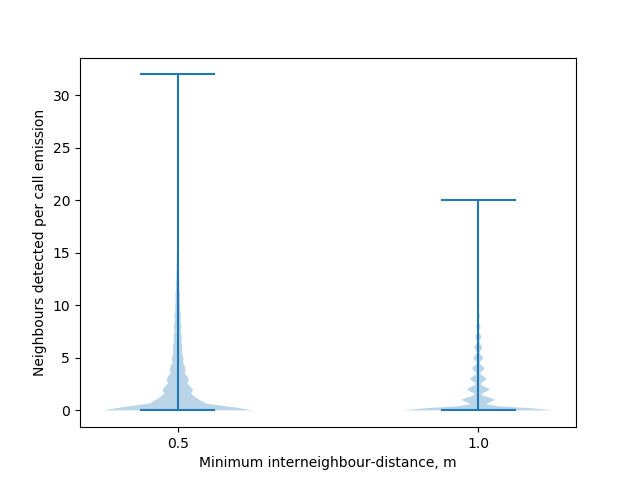

Text(0,0.5,'Neighbours detected per call emission')

In [132]:
by_spacing = simulation_data.groupby('min_spacing')
neighbours_by_spacing = [ np.array(df['nbrs_detected']) for value, df in by_spacing]
plt.figure()
plt.violinplot(neighbours_by_spacing)
plt.xticks([1,2],[0.5,1.0]); plt.xlabel('Minimum interneighbour-distance, m');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


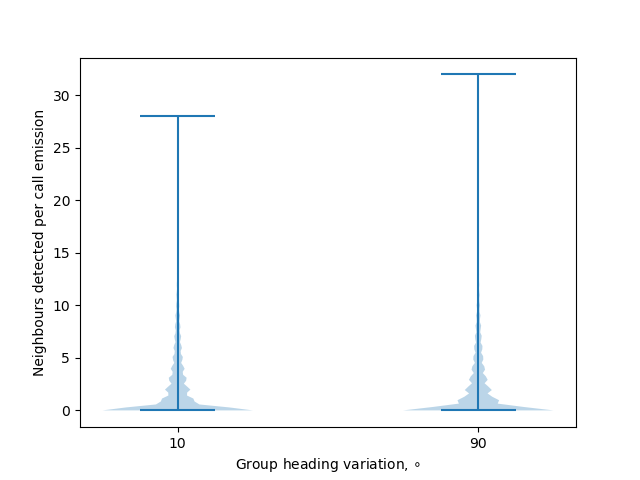

Text(0,0.5,'Neighbours detected per call emission')

In [133]:
by_heading = simulation_data.groupby('heading_variation')
neighbours_by_spacing = [ np.array(df['nbrs_detected']) for value, df in by_heading]
plt.figure()
plt.violinplot(neighbours_by_spacing)
plt.xticks([1,2],[10,90]); plt.xlabel('Group heading variation, $\circ$');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


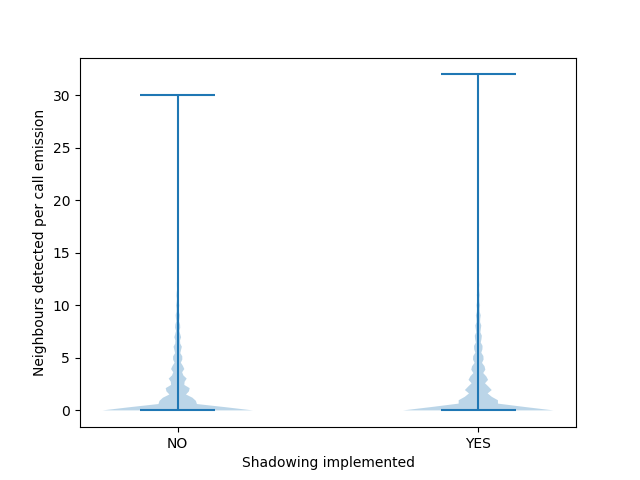

Text(0,0.5,'Neighbours detected per call emission')

In [134]:
by_shadowing = simulation_data.groupby('implement_shadowing')
neighbours_by_shadowing = [ np.array(df['nbrs_detected']) for value, df in by_shadowing]
plt.figure()
plt.violinplot(neighbours_by_shadowing)
plt.xticks([1,2],['NO', 'YES']); plt.xlabel('Shadowing implemented');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


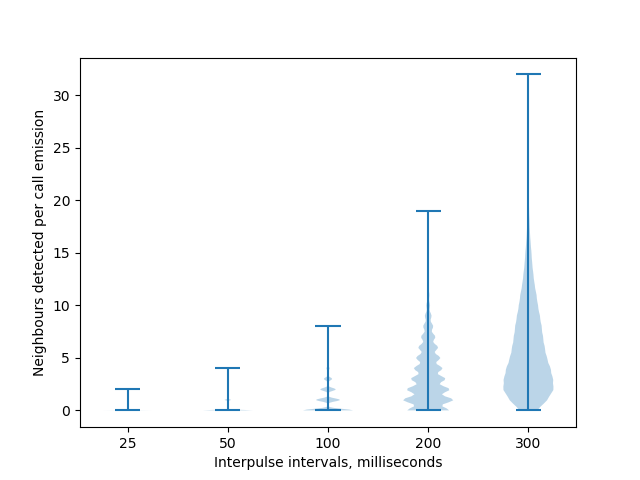

Text(0,0.5,'Neighbours detected per call emission')

In [135]:
by_ipi = simulation_data.groupby('interpulse_interval')
neighbours_by_ipi = [ np.array(df['nbrs_detected']) for value, df in by_ipi]
plt.figure()
plt.violinplot(neighbours_by_ipi)
plt.xticks([1,2,3,4,5],[25, 50, 100, 200, 300]); plt.xlabel('Interpulse intervals, milliseconds');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


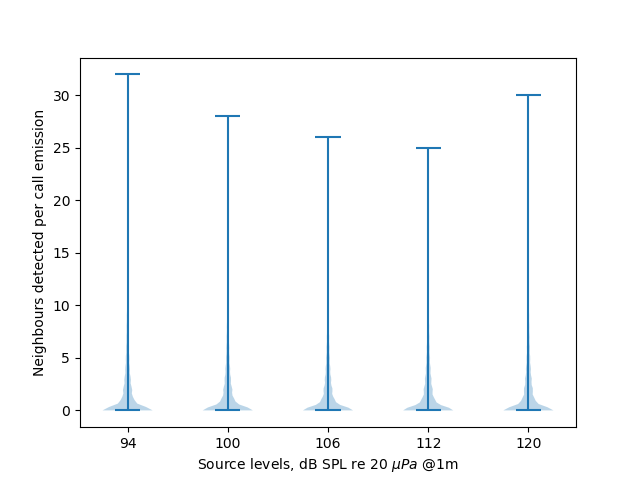

Text(0,0.5,'Neighbours detected per call emission')

In [136]:
by_sl = simulation_data.groupby('source_level')
neighbours_by_sl = [ np.array(df['nbrs_detected']) for value, df in by_sl]
plt.figure()
plt.violinplot(neighbours_by_sl)
plt.xticks([1,2,3,4,5],[94, 100, 106, 112, 120]); plt.xlabel('Source levels, dB SPL re 20 $\mu Pa$ @1m');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


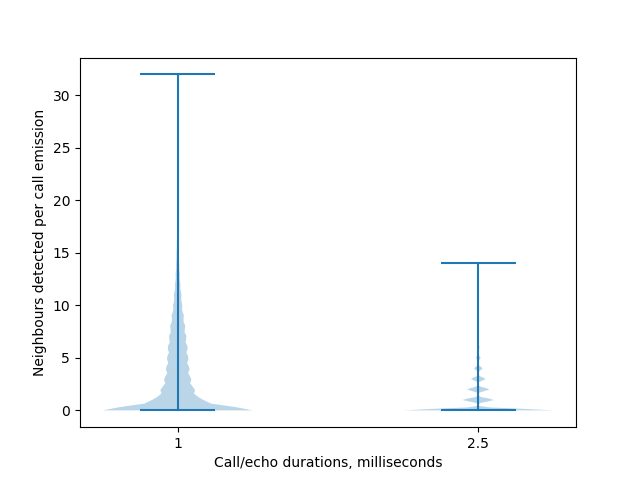

Text(0,0.5,'Neighbours detected per call emission')

In [137]:
by_duration = simulation_data.groupby('echocall_duration')
neighbours_by_duration = [ np.array(df['nbrs_detected']) for value, df in by_duration]
plt.figure()
plt.violinplot(neighbours_by_duration)
plt.xticks([1,2],[1, 2.5]); plt.xlabel('Call/echo durations, milliseconds');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


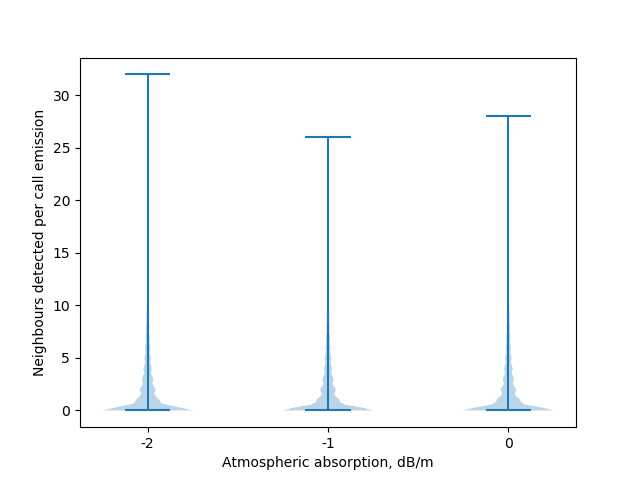

Text(0,0.5,'Neighbours detected per call emission')

In [138]:
by_attenuation = simulation_data.groupby('atmospheric_attenuation')
neighbours_by_atmabs = [ np.array(df['nbrs_detected']) for value, df in by_attenuation]
plt.figure()
plt.violinplot(neighbours_by_atmabs)
plt.xticks([1,2,3],[-2, -1, 0]); plt.xlabel('Atmospheric absorption, dB/m');
plt.ylabel('Neighbours detected per call emission')

## Which parameter set achieves an 'optimum' rate of neighbour detection ? 

<IPython.core.display.Javascript object>


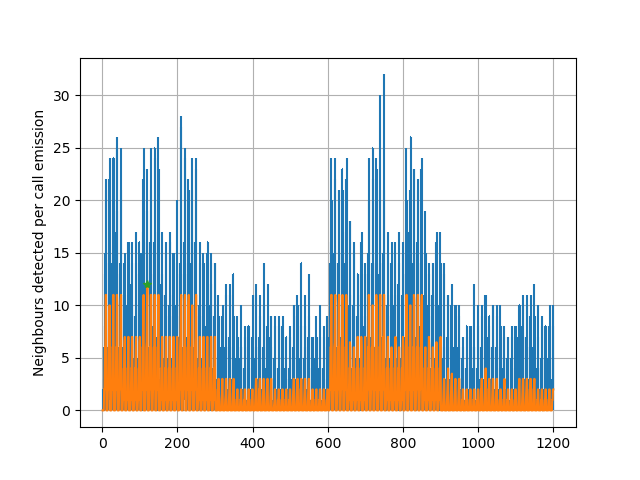

Text(0,0.5,'Neighbours detected per call emission')

In [139]:
by_paramid = simulation_data.groupby('paramset_id')
neighbours_by_params = [ np.array(df['nbrs_detected']) for value, df in by_paramid]
all_paramids = [value for value, df in by_paramid]
median_echoes = map(np.median, neighbours_by_params)
plt.figure()
plt.violinplot(neighbours_by_params)
plt.plot(np.arange(1,len(neighbours_by_params)+1),median_echoes)
best_paramset = np.argmax(median_echoes)
plt.plot(best_paramset+1, median_echoes[best_paramset],'*')
#plt.xticks([1,2],[1, 2.5]); plt.xlabel('Call/echo durations, milliseconds');
plt.grid()
plt.ylabel('Neighbours detected per call emission')

In [140]:
all_paramids[best_paramset]

'10*0.001*-2*0.5*106*0.3*True'

## Running regression analyses on the simulation outputs to understand which factors played a major role in the number of neighbours detected :

### Having done some visualisations - let's now do some regressions to understand how all of the variables contribute overall to the number of echoes a focal bat can actually detect:

In [141]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [142]:
simulation_data.head()

echo_directions  \
0            Series([], Name: theta, dtype: float64)   
1           2    33.3398
Name: theta, dtype: float64   
2            2    6.3389
Name: theta, dtype: float64   
3  1     -37.8798
3     169.1262
4      96.9039
5...   
4            Series([], Name: theta, dtype: float64)   

                                         echo_levels  group_diameter  \
0            Series([], Name: level, dtype: float64)       14.200637   
1         2    85.896433
Name: level, dtype: float64        7.200687   
2         2    56.334859
Name: level, dtype: float64       14.180115   
3  1     50.781637
3     35.344129
4     36.44448...       14.386090   
4            Series([], Name: level, dtype: float64)       14.157732   

   group_size  nbrs_detected  \
0         100              0   
1         100              1   
2         100              1   
3         100             10   
4         100              0   

                              nbrs_detected_distance  \
0                                                 []   
1                               [0.6234210867233229]   
2                               [1.2115445731783536]   
3  [1.2068506589447259, 1.4572132244561569, 1.719...   
4                                                 []   

                          nearest_neighbour_distance  \
0  [1.0738870171204988, 1.2275738371897262, 1.310...   
1  [0.5040997912106178, 0.5805986746798041, 0.623...   
2  [1.002187567497149, 1.1047736710966196, 1.2115...   
3  [1.181548533918081, 1.2068506589447259, 1.3046...   
4  [1.0210001460745612, 1.118407000244618, 1.3868...   

                         parameters_joint                     paramset_id  \
0  [90, 0.0025, -1, 1.0, 106, 0.05, True]  90*0.0025*-1*1.0*106*0.05*True   
1   [10, 0.001, 0, 0.5, 120, 0.05, False]   10*0.001*0*0.5*120*0.05*False   
2    [90, 0.001, -1, 1.0, 94, 0.2, False]    90*0.001*-1*1.0*94*0.2*False   
3     [90, 0.001, -1, 1.0, 94, 0.3, True]     90*0.001*-1*1.0*94*0.3*True   
4   [90, 0.0025, -1, 1.0, 112, 0.3, True]   90*0.0025*-1*1.0*112*0.3*True   

        seed                                  uuid  heading_variation  \
0  698146828  de3d78d0-d71f-44b0-ada9-16fef6f18435                 90   
1  428387352  bf86593a-3674-4391-abc1-638cb6f37351                 10   
2  442299525  fdee9447-c0ef-4ce1-80bc-4f3280e1853c                 90   
3  139245842  74a66af3-ee75-4417-be14-7ecbf69af1c0                 90   
4  633627683  2ae6f99a-6ebb-47aa-afc0-f6c21dd0f6c4                 90   

   echocall_duration  atmospheric_attenuation  min_spacing  source_level  \
0             0.0025                       -1          1.0           106   
1             0.0010                        0          0.5           120   
2             0.0010                       -1          1.0            94   
3             0.0010                       -1          1.0            94   
4             0.0025                       -1          1.0           112   

   interpulse_interval  implement_shadowing  
0                 0.05                 True  
1                 0.05                False  
2                 0.20                False  
3                 0.30                 True  
4                 0.30                 True

In [143]:
# make most of the columns categorical because I've done such sparse sampling
regression_rundata = simulation_data.copy()
for column in keyword_arguments['variables_to_extract'] :
    regression_rundata[column] = regression_rundata[column].astype('category')

In [144]:
formula = 'nbrs_detected~heading_variation+atmospheric_attenuation \
            +implement_shadowing+interpulse_interval+min_spacing+source_level+echocall_duration\
            +source_level+atmospheric_attenuation'


## Which parameters predict the probability of detecting at least 1 neighbour ?
### I now reduce the whole problem to whether a neighbour was detected or not! Every simulation give 0 or $\ge$ 0 number of neighbours detected. This will then reduce it to a binomial distribution, where the two states are 'no neighbours detected' and 'at least one neighbour detected'.

In [145]:
at_least_one = regression_rundata['nbrs_detected'] > 0
regression_rundata['geq_oneneighbour'] = np.zeros(at_least_one.size)
regression_rundata.loc[at_least_one,'geq_oneneighbour'] = 1

In [146]:
detection = regression_rundata['geq_oneneighbour']

In [147]:
# only presenting the final and reduced model 
logit_formula = 'geq_oneneighbour~heading_variation+ \
        implement_shadowing+interpulse_interval+\
        min_spacing+echocall_duration+source_level+atmospheric_attenuation'

In [148]:
logit_model = smf.logit(logit_formula, data=regression_rundata)
logit_fit = logit_model.fit( maxiter=200)

Optimization terminated successfully.
         Current function value: 0.238334
         Iterations 10


In [149]:
logit_predict = logit_fit.predict()

In [150]:
logit_resid = detection - logit_predict

### Let's build an ROC curve to figure out which thresholds give us the best predictions - and then use it to decide how well the logistic regression model predicts the $P(\geq1 neighbour)$  being detected.

In [151]:
from sklearn import metrics


In [152]:
fpr, tpr, thresholds = metrics.roc_curve(detection, logit_predict)
roc_data = pd.DataFrame(data={'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds})

<IPython.core.display.Javascript object>


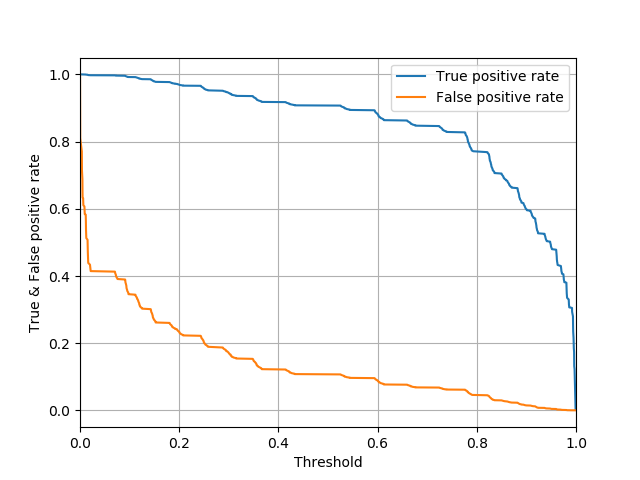

In [153]:
plt.figure()
plt.plot(thresholds, tpr, label='True positive rate')
plt.plot(thresholds, fpr, label='False positive rate')
plt.xlim(0,1)
plt.xlabel('Threshold');plt.ylabel('True & False positive rate')
plt.legend();plt.grid()

### Choosing a reasonable threshold to get the confusion matrix from the logistic regression results:
 The ROC curve above shows us how the false and true positive rates vary as we alter the threshold at which we consider $\geq1$ neighbour detected. The model should have a low false positive rate to be useful, and so I will choose accept a 5% false positive rate. Within the thresholds that satsify this criteria, I will then choose the threshold with the highest true positive rate. 

In [154]:
acceptable_fpr = 0.05
rows_w_acceptable_fpr = roc_data[roc_data['fpr']<=acceptable_fpr].reset_index(drop=True)
highest_tpr_row = rows_w_acceptable_fpr['tpr'].argmax()
best_threshold = rows_w_acceptable_fpr.loc[highest_tpr_row,:]['thresholds']

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  app.launch_new_instance()


In [155]:
best_threshold

0.7861980084949216

<IPython.core.display.Javascript object>


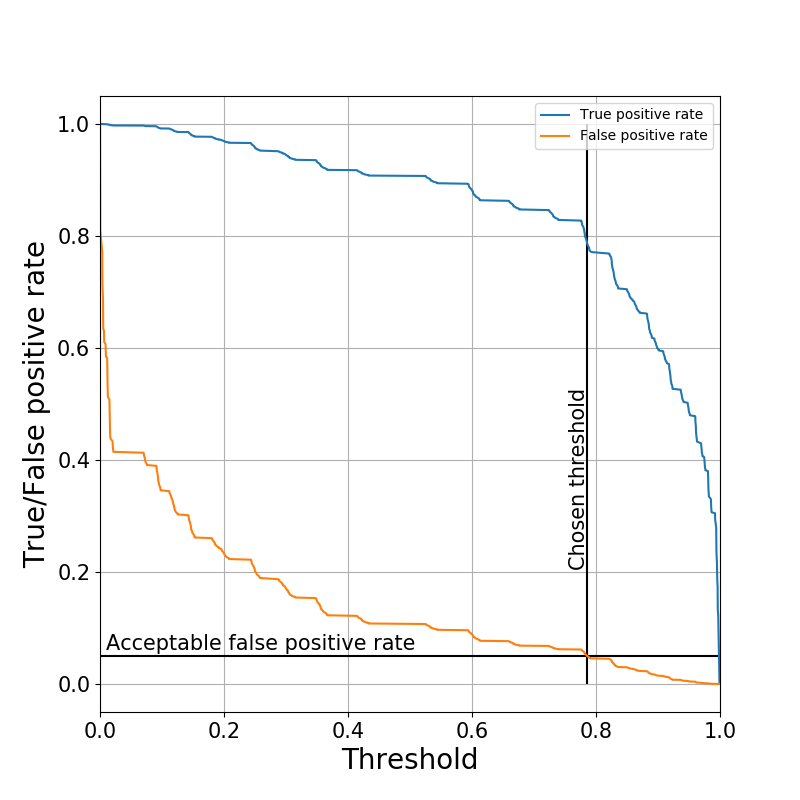

Text(0.01,0.06,'Acceptable false positive rate')

In [156]:
plt.figure(figsize=(8,8))
plt.plot(thresholds, tpr, label='True positive rate')
plt.plot(thresholds, fpr, label='False positive rate')
plt.xlim(0,1)
plt.xticks(fontsize=15);plt.yticks(fontsize=15)
plt.xlabel('Threshold', fontsize=20);plt.ylabel('True/False positive rate',fontsize=20)
plt.legend();plt.grid()
plt.vlines(best_threshold,0,1);
plt.hlines(acceptable_fpr, 0, 1)
plt.text(best_threshold-0.03, 0.5,'Chosen threshold', rotation=90, fontsize=15)
plt.text(0.01,acceptable_fpr+0.01,'Acceptable false positive rate',fontsize=15)

In [157]:
from sklearn.preprocessing import Binarizer 

In [158]:
binarise_probs = Binarizer(best_threshold)
predicted_binary = binarise_probs.fit_transform(logit_predict.reshape(-1,1))

In [159]:
logit_confusion_matrix = metrics.confusion_matrix(detection, predicted_binary)
true_positive, false_positive, true_negative, false_negative = metrics.confusion_matrix(detection, 
                                                                                        predicted_binary).ravel()

In [160]:
logit_confusion_matrix

array([[116038,   6024],
       [ 25546,  92958]])

In [161]:
true_positive, false_positive, true_negative, false_negative

(116038, 6024, 25546, 92958)

In [162]:
def calc_rate_per_column(X):
    X_float = np.float64(X)
    X_rate = X_float/np.sum(X_float)
    return(X_rate)

In [163]:
rate_logit = np.apply_along_axis(calc_rate_per_column, 0, logit_confusion_matrix)

In [164]:
np.around(rate_logit,2)

array([[0.82, 0.06],
       [0.18, 0.94]])

In [165]:
# rows are the predicted values - columns are the observed values
pd.DataFrame(np.around(rate_logit,2))

0     1
0  0.82  0.06
1  0.18  0.94

### The logistic regression predicting whether $\geq1$ neighbour is heard seems to be a much better model. It predicts the observed data with a 82% true negative and 94% true positive rate. I am currently satisfied with this mdoel - and now let us see which parameters affect the probability of hearing at least one neighbour. 

In [166]:
np.unique(regression_rundata['interpulse_interval'],return_counts=True)

(array([0.025, 0.05 , 0.1  , 0.2  , 0.3  ]),
 array([47993, 47993, 47996, 48584, 48000]))

In [167]:
logit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       geq_oneneighbour   No. Observations:               240566
Model:                          Logit   Df Residuals:                   240551
Method:                           MLE   Df Model:                           14
Date:                Thu, 26 Sep 2019   Pseudo R-squ.:                  0.6561
Time:                        14:50:19   Log-Likelihood:                -57335.
converged:                       True   LL-Null:                   -1.6672e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -4.7023      0.074    -63.204      0.000      -4.848      -4.556
heading_variation[T.90]           0.2780      0.015     18.350      0.000       0.248       0.308
implement_shadowing[T.True]       0.2823      0.015     18.632      0.000       0.253       0.312
interpulse_interval[T.0.05]       3.8054      0.072     52.493      0.000       3.663       3.947
interpulse_interval[T.0.1]        6.8435      0.073     93.520      0.000       6.700       6.987
interpulse_interval[T.0.2]        9.5244      0.076    125.589      0.000       9.376       9.673
interpulse_interval[T.0.3]       11.1568      0.079    141.761      0.000      11.003      11.311
min_spacing[T.1.0]               -1.1674      0.016    -72.826      0.000      -1.199      -1.136
echocall_duration[T.0.0025]      -3.5455      0.022   -158.834      0.000      -3.589      -3.502
source_level[T.100]               0.0136      0.024      0.568      0.570      -0.033       0.060
source_level[T.106]               0.0260      0.024      1.089      0.276      -0.021       0.073
source_level[T.112]               0.0255      0.024      1.064      0.287      -0.021       0.072
source_level[T.120]              -0.0037      0.024     -0.156      0.876      -0.050       0.043
atmospheric_attenuation[T.-1]    -0.0051      0.018     -0.274      0.784      -0.041       0.031
atmospheric_attenuation[T.0]      0.0409      0.018      2.211      0.027       0.005       0.077
=================================================================================================
"""

### To interpret the model we need to first convert the coefficients from log(odds ratio) to odds ratio. See [here](https://rpubs.com/OmaymaS/182726) for a nice explanation of interpreting logistic regresion outcomes.

In [169]:
# Convert log(odds ratio) to odds ratio :
pd.DataFrame(data = {'oddsratio':np.exp(logit_fit.params),'pvalue': np.around(logit_fit.pvalues,2)})

oddsratio  pvalue
Intercept                          0.009075    0.00
heading_variation[T.90]            1.320484    0.00
implement_shadowing[T.True]        1.326155    0.00
interpulse_interval[T.0.05]       44.941312    0.00
interpulse_interval[T.0.1]       937.739194    0.00
interpulse_interval[T.0.2]     13689.946704    0.00
interpulse_interval[T.0.3]     70035.497267    0.00
min_spacing[T.1.0]                 0.311175    0.00
echocall_duration[T.0.0025]        0.028855    0.00
source_level[T.100]                1.013676    0.57
source_level[T.106]                1.026377    0.28
source_level[T.112]                1.025782    0.29
source_level[T.120]                0.996287    0.88
atmospheric_attenuation[T.-1]      0.994953    0.78
atmospheric_attenuation[T.0]       1.041722    0.03

### A note on the final and only model:
I have not attempted any kind of model selection/reduction as the intention of the regression analyses is to quantify the extent to which each variable contributes to neighbour detection. Moreover the simulations themselves are a result of *all* variables being altered intentionally - and so I chose to keep them final model (Bolker et 2009) even at the cost of less precise predictions. 

### Reference:
Bolker, B. M., Brooks, M. E., Clark, C. J., Geange, S. W., Poulsen, J. R., Stevens, M. H. H., & White, J. S. S. (2009). Generalized linear mixed models: a practical guide for ecology and evolution. Trends in ecology & evolution, 24(3), 127-135.

## Interpreting the model :
Parameters explained in descending order of their odds ratios : 

### 1. Inter pulse intervals play a strong role : 
The interpulse interval (ipi) is duration of time between the end of one call and the start of the next call. The longer the interpulse interval, the longer a bat waits between two calls. In the simulations, every bat had the same interpulse interval - and we see that the longer the time bats wait between calls - the better they are able to detect their neighbours. The reference group here was $interpulse \ interval = 25 milliseconds$, and we see dramatic odds ratios as the interpulse interval is increased first to 50 and then 100 milliseconds. The odds ratio of detecting a neighbour increases 45 (at 50ms ipi) to 70,035 (300 ms ipi) times the reference of 25 ms ipi. 

### 2. Acoustic shadowing promotes neighbour detection : 
Here I refer to acoustic shadowing as the decrease in sound pressure level of a sound as it passes obstacles. In a group of bats, the neighbouring bats centred around a focal bat are the obstacles. The reference group ('implement_shadowing') is the set of simulations without acoustic shadowing implemented - where every bat is 'transparent' when sounds pass through them. The odds ratio increases 1.32 times by implementing acoustic shadowing. 

### 3. Heading variation in a group increases neighbour detection : 
This parameter describes the amount of variation in the direction that individuals are pointing their beams at. The reference group is $heading \ variation = 10 ^\circ$ and we see that a group with  $heading \ variation = 90 ^\circ$ has a 1.32 time increase in detecting $\geq1$ neighbour. This implies that a group engaging in behaviours where there is low alignment of bat scanning/flight directions could actually be advantageous. 


### 4. Bats flying closer to each other can detect each other better :
The minimum spacing between two adjacent bats was set to be either 0.5 or 1.0 meters. When bats were placed further from each other (1m minimum spacing) they detected each other better in the midst of the loud calls, than when they were further apart (0.5m minimum spacing). The reference group is 0.5m minimum spacing, and we see the odds ratio drops to 0.3 at 1.0m minimum spacing between bats. 

### 5. Shorter calls allow better detection of neighbours : 
Calls were set to be either 1ms or 2.5ms long. The reference was the neighbour detection at 1ms call duration. A longer call of 2.5 ms led to the odds ratio dropping to ~ 0.03 times the reference group. 

### 6. Call source levels do not affect neighbour detection : 
All bats in a group were simulated to emit calls at one of 94, 100, 106, 112 or 120 dB SPL re 20 $\mu$Pa at 1m. 
The regressions results show mixed and very small variations in odds ratio was between 0.99-1.03 times the reference group. 
The reference group was all bats emitting at 94 dB SPL re 20 $\mu$Pa at 1m. Since all bats were emitting at the same 
source level - there was no change in echo to masker levels and thus source levels do not contribute to much variation in the detection of neighbours. 

### 7. Atmospheric attenuation : 
The atmospheric attenuation varied between 0, -1 and -2 dB/m. The reference group was -2 dB/m. The odds ratio of neighbour detection for different atmospheric absorption rates  lies between 0.99-1.04. Variation in atmospheric attenuation is also not expected to change neighbour detection because there is no effective change in the echo-masker levels. The effect of atmospheric absorption is applicable to both echoes and maskers equally. 

## Regression Analyses that did not explain the data as well - but nonetheless showed similar trends :
To be transparent - I present here the other regression models that I tried to fit the data to - but which were not as succesful in their predictions. 

In [170]:
regression_rundata.columns

Index([u'echo_directions', u'echo_levels', u'group_diameter', u'group_size',
       u'nbrs_detected', u'nbrs_detected_distance',
       u'nearest_neighbour_distance', u'parameters_joint', u'paramset_id',
       u'seed', u'uuid', u'heading_variation', u'echocall_duration',
       u'atmospheric_attenuation', u'min_spacing', u'source_level',
       u'interpulse_interval', u'implement_shadowing', u'geq_oneneighbour'],
      dtype='object')

In [171]:
formula = 'nbrs_detected~heading_variation+ \
        implement_shadowing+interpulse_interval+\
        min_spacing+echocall_duration + source_level + atmospheric_attenuation'

In [172]:
model_num_echoes = smf.glm(formula, data=regression_rundata, 
                           family = sm.families.NegativeBinomial(sm.families.links.log))

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  from ipykernel import kernelapp as app


In [173]:
negbinom_fit = model_num_echoes.fit()

In [174]:
negbinom_fit.aic

621148.370513462

In [175]:
model_num_echoes.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          nbrs_detected   No. Observations:               240566
Model:                            GLM   Df Residuals:                   240551
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1056e+05
Date:                Thu, 26 Sep 2019   Deviance:                       78838.
Time:                        14:50:22   Pearson chi2:                 1.00e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -4.8268      0.071    -67.878      0.000      -4.966      -4.687
heading_variation[T.90]           0.0309      0.006      4.855      0.000       0.018       0.043
implement_shadowing[T.True]       0.0908      0.006     14.243      0.000       0.078       0.103
interpulse_interval[T.0.05]       3.5390      0.072     49.366      0.000       3.399       3.680
interpulse_interval[T.0.1]        5.3725      0.071     75.852      0.000       5.234       5.511
interpulse_interval[T.0.2]        6.6790      0.071     94.473      0.000       6.540       6.818
interpulse_interval[T.0.3]        7.3326      0.071    103.747      0.000       7.194       7.471
min_spacing[T.1.0]               -0.5077      0.006    -79.252      0.000      -0.520      -0.495
echocall_duration[T.0.0025]      -1.4501      0.007   -219.066      0.000      -1.463      -1.437
source_level[T.100]               0.0034      0.010      0.334      0.738      -0.016       0.023
source_level[T.106]               0.0042      0.010      0.411      0.681      -0.016       0.024
source_level[T.112]               0.0045      0.010      0.446      0.656      -0.015       0.024
source_level[T.120]               0.0003      0.010      0.029      0.977      -0.019       0.020
atmospheric_attenuation[T.-1]    -0.0036      0.008     -0.465      0.642      -0.019       0.012
atmospheric_attenuation[T.0]      0.0013      0.008      0.160      0.872      -0.014       0.017
=================================================================================================
"""

In [176]:
predictions = model_num_echoes.fit().predict()
observed = np.array(regression_rundata['nbrs_detected'])
residue = observed - predictions

<IPython.core.display.Javascript object>


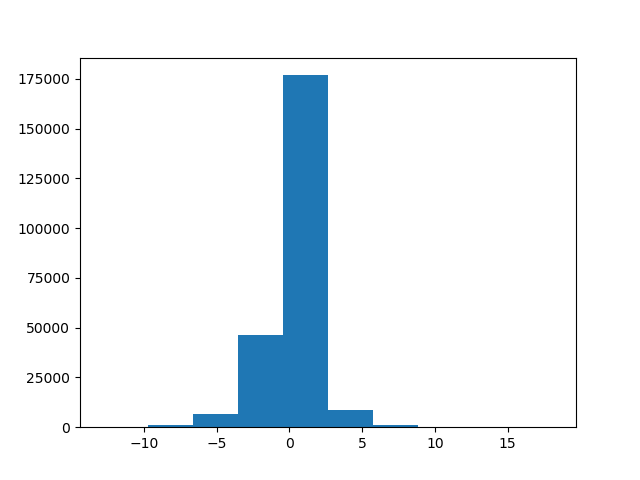

In [177]:
plt.figure()
plt.hist(residue);

In [178]:
prediction_error, occurence = np.unique(residue, return_counts=True)
occurence = np.float64(occurence)
occurence /= np.sum(occurence)

<IPython.core.display.Javascript object>


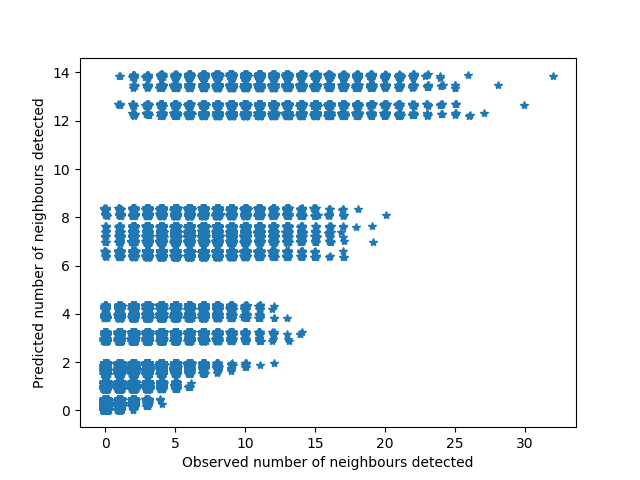

Text(0,0.5,'Predicted number of neighbours detected')

In [179]:
plt.figure()
plt.plot(observed+np.random.normal(0,0.05,observed.size),
         predictions, '*')
plt.xlabel('Observed number of neighbours detected')
plt.ylabel('Predicted number of neighbours detected')

In [180]:
negbinom_confusion_matrix = metrics.confusion_matrix(observed, np.around(predictions))

In [181]:
negbinom_rates = calc_rate_per_column(negbinom_confusion_matrix)

<IPython.core.display.Javascript object>


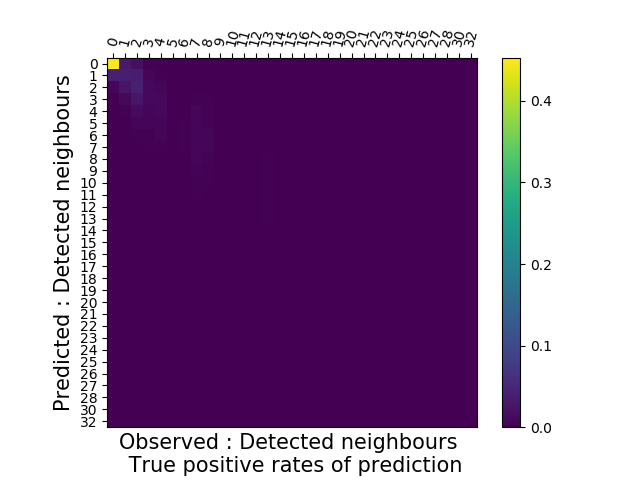

Text(0,0.5,'Predicted : Detected neighbours')

In [182]:
fig, ax = plt.subplots()
heatmap = ax.imshow(negbinom_rates)
fig.colorbar(heatmap)
ax.set_xticks(np.arange(negbinom_rates.shape[0]))
ax.set_xticklabels(np.unique(observed), rotation=75);
ax.xaxis.tick_top()
ax.set_yticks(np.arange(negbinom_rates.shape[0]))
ax.set_yticklabels(np.unique(observed));
plt.xlabel('Observed : Detected neighbours \n True positive rates of prediction', fontsize=15)
plt.ylabel('Predicted : Detected neighbours', fontsize=15)

### We can see that the predictions are correct highest at predicting when 0 neighbours are detected - and that too only 50% of the time. The negative binomial model isn't doing a very great job at predicting the number of neighbours detected. 

<IPython.core.display.Javascript object>


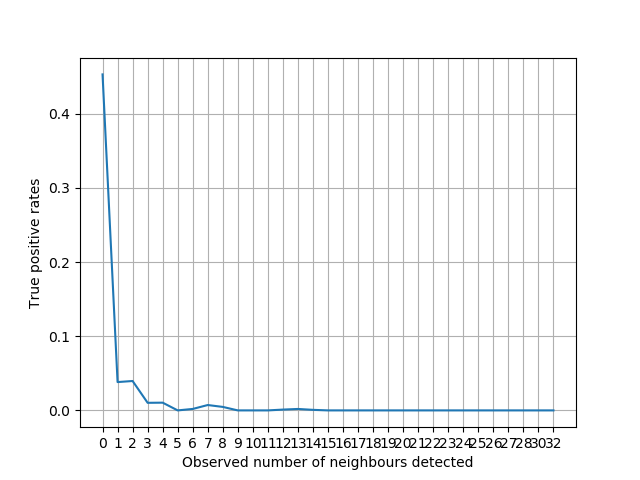

In [183]:
plt.figure()
plt.plot(np.diag(negbinom_rates));plt.ylabel('True positive rates')
plt.xticks(range(np.unique(observed).size), np.unique(observed))
plt.xlabel('Observed number of neighbours detected');plt.grid()

### Perhaps zero-inflation is affecting the efficacy of prediction?
#### Many of the simulations actually show that a bat has detected zero neighbours - and unless accounted for specifically many regression models are not formulated with zero-inflated data. 

<IPython.core.display.Javascript object>


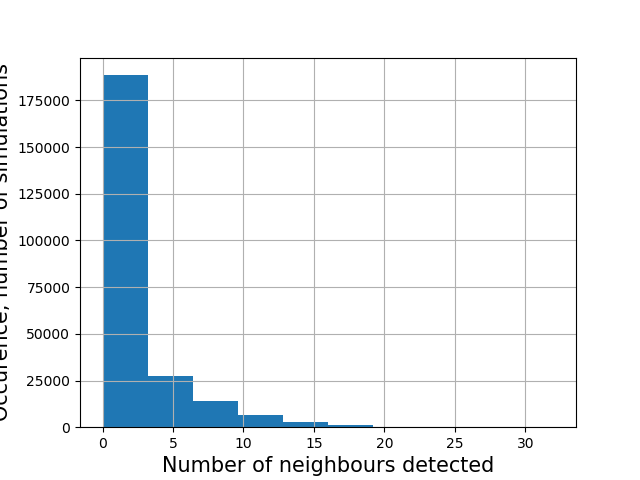

Text(0,0.5,'Occurence, number of simulations')

In [184]:
plt.figure()
plt.hist(observed);
plt.grid()
plt.xlabel('Number of neighbours detected', fontsize=15)
plt.ylabel('Occurence, number of simulations', fontsize=15)

### The histogram shows a preponderance of zeroes in the dataset. Let us use zero-inflated Poisson models to handle the dataset.

In [185]:
# folllowing https://bryansweber.com/2018/10/26/python-and-zero-inflated-models/ accessed 14-09-2019
import statsmodels.discrete.count_model as reg_models

In [186]:
modelw_zip = reg_models.ZeroInflatedPoisson.from_formula(formula, regression_rundata)

In [187]:
zipmodel_fit = modelw_zip.fit()

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 1.116698
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [188]:
zipmodel_predict = zipmodel_fit.predict()

In [189]:
zipmodel_residues = observed - zipmodel_predict

<IPython.core.display.Javascript object>


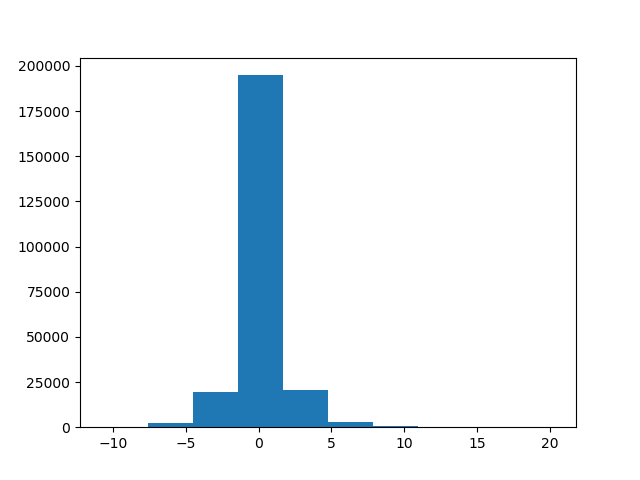

In [190]:
plt.figure()
plt.hist(zipmodel_residues);

<IPython.core.display.Javascript object>


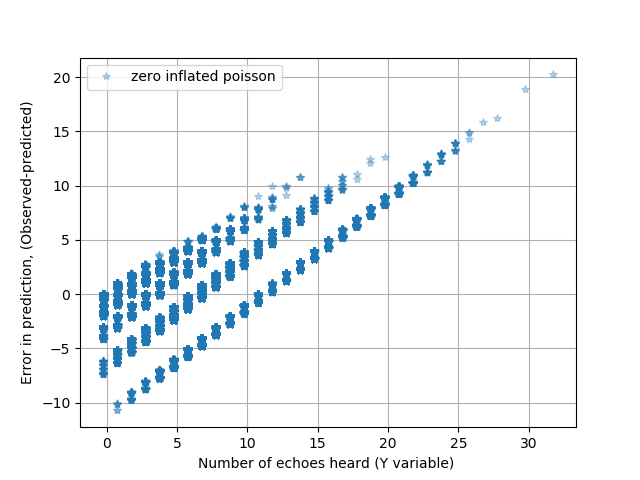

In [191]:
plt.figure()
plt.plot(observed-0.25+np.random.normal(0,0.01,observed.size),
         zipmodel_residues, '*', alpha=0.3,
         label='zero inflated poisson')

plt.xlabel('Number of echoes heard (Y variable) ')
plt.ylabel('Error in prediction, (Observed-predicted)')
plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


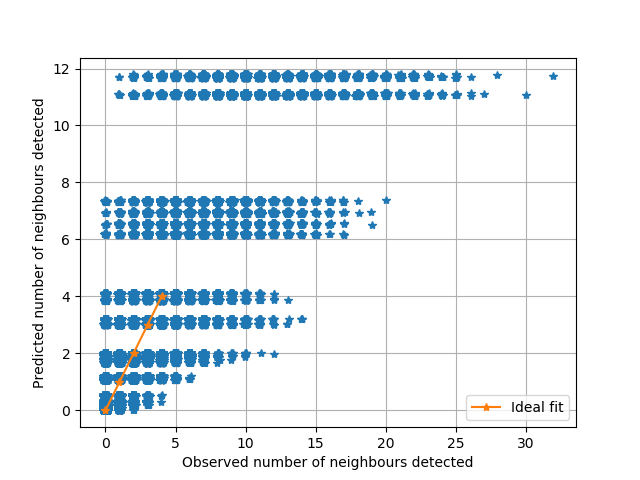

In [192]:
plt.figure()
plt.plot(observed+np.random.normal(0,0.05,observed.size),
         zipmodel_predict, '*')
plt.plot(np.arange(5),np.arange(5),'-*',label='Ideal fit')
plt.xlabel('Observed number of neighbours detected')
plt.ylabel('Predicted number of neighbours detected')
plt.legend();plt.grid()

In [193]:
# calculate the confusion matrix for the zero inflated Poisson 
zip_confusion_matrix = metrics.confusion_matrix(observed, np.around(zipmodel_predict))
zip_prediction_rates = calc_rate_per_column(zip_confusion_matrix)

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


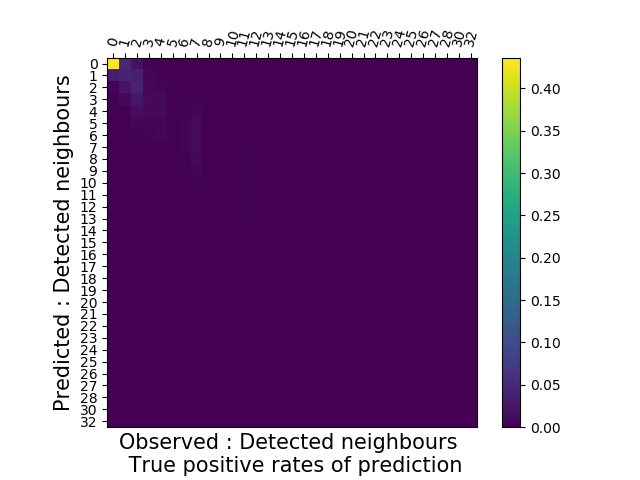

Text(0,0.5,'Predicted : Detected neighbours')

In [194]:
# rate of true positives in the predictions
fig, ax = plt.subplots()
heatmap = ax.imshow(zip_prediction_rates)
fig.colorbar(heatmap)
ax.set_xticks(np.arange(zip_prediction_rates.shape[0]))
ax.set_xticklabels(np.unique(observed), rotation=75);
ax.xaxis.tick_top()
ax.set_yticks(np.arange(zip_prediction_rates.shape[0]))
ax.set_yticklabels(np.unique(observed));
plt.xlabel('Observed : Detected neighbours \n True positive rates of prediction', fontsize=15)
plt.ylabel('Predicted : Detected neighbours', fontsize=15)

### Even the zero-inflated Poisson model doesn't predict the observed data too well. At its best the cases of zero neighbours detected are predicted, but that too only about 50%  of the time. 

## The negative binomial and zero-inflated Poisson models:


In [195]:
zipmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:           nbrs_detected   No. Observations:               240566
Model:             ZeroInflatedPoisson   Df Residuals:                   240551
Method:                            MLE   Df Model:                           14
Date:                 Thu, 26 Sep 2019   Pseudo R-squ.:                  0.4601
Time:                         14:50:41   Log-Likelihood:            -2.6864e+05
converged:                       False   LL-Null:                   -4.9756e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
inflate_const                    -8.1326      0.388    -20.938      0.000      -8.894      -7.371
Intercept                        -4.8584      0.071    -68.158      0.000      -4.998      -4.719
heading_variation[T.90]          -0.0016      0.003     -0.565      0.572      -0.007       0.004
implement_shadowing[T.True]       0.0561      0.003     19.761      0.000       0.051       0.062
interpulse_interval[T.0.05]       3.6014      0.072     49.937      0.000       3.460       3.743
interpulse_interval[T.0.1]        5.4607      0.071     76.581      0.000       5.321       5.600
interpulse_interval[T.0.2]        6.6846      0.071     93.886      0.000       6.545       6.824
interpulse_interval[T.0.3]        7.2678      0.071    102.105      0.000       7.128       7.407
min_spacing[T.1.0]               -0.4679      0.003   -160.315      0.000      -0.474      -0.462
echocall_duration[T.0.0025]      -1.2996      0.003   -376.151      0.000      -1.306      -1.293
source_level[T.100]               0.0023      0.004      0.516      0.606      -0.006       0.011
source_level[T.106]              -0.0026      0.004     -0.584      0.559      -0.011       0.006
source_level[T.112]             1.55e-06      0.004      0.000      1.000      -0.009       0.009
source_level[T.120]              -0.0037      0.004     -0.824      0.410      -0.012       0.005
atmospheric_attenuation[T.-1]    -0.0042      0.003     -1.208      0.227      -0.011       0.003
atmospheric_attenuation[T.0]     -0.0026      0.003     -0.763      0.445      -0.009       0.004
=================================================================================================
"""

In [196]:
negbinom_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          nbrs_detected   No. Observations:               240566
Model:                            GLM   Df Residuals:                   240551
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1056e+05
Date:                Thu, 26 Sep 2019   Deviance:                       78838.
Time:                        14:50:41   Pearson chi2:                 1.00e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -4.8268      0.071    -67.878      0.000      -4.966      -4.687
heading_variation[T.90]           0.0309      0.006      4.855      0.000       0.018       0.043
implement_shadowing[T.True]       0.0908      0.006     14.243      0.000       0.078       0.103
interpulse_interval[T.0.05]       3.5390      0.072     49.366      0.000       3.399       3.680
interpulse_interval[T.0.1]        5.3725      0.071     75.852      0.000       5.234       5.511
interpulse_interval[T.0.2]        6.6790      0.071     94.473      0.000       6.540       6.818
interpulse_interval[T.0.3]        7.3326      0.071    103.747      0.000       7.194       7.471
min_spacing[T.1.0]               -0.5077      0.006    -79.252      0.000      -0.520      -0.495
echocall_duration[T.0.0025]      -1.4501      0.007   -219.066      0.000      -1.463      -1.437
source_level[T.100]               0.0034      0.010      0.334      0.738      -0.016       0.023
source_level[T.106]               0.0042      0.010      0.411      0.681      -0.016       0.024
source_level[T.112]               0.0045      0.010      0.446      0.656      -0.015       0.024
source_level[T.120]               0.0003      0.010      0.029      0.977      -0.019       0.020
atmospheric_attenuation[T.-1]    -0.0036      0.008     -0.465      0.642      -0.019       0.012
atmospheric_attenuation[T.0]      0.0013      0.008      0.160      0.872      -0.014       0.017
=================================================================================================
"""

### Both count models show the same trends as the logistic regression.